In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from numba import njit, prange
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import math
import deep_utils as du
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, reshape=False)

train_dataset = mnist.train.images
train_labels = mnist.train.labels
validation_dataset = mnist.validation.images
validation_labels = mnist.validation.labels
test_dataset = mnist.test.images
test_labels = mnist.test.labels

print('train_labels', train_labels.shape)
print('train_dataset', train_dataset.shape)
print('validation_labels', validation_labels.shape)
print('validation_dataset', validation_dataset.shape)
print('test_labels', test_labels.shape)
print('test_dataset', test_dataset.shape, '\n')

train_dataset = np.pad(train_dataset, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
validation_dataset = np.pad(validation_dataset, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
test_dataset = np.pad(test_dataset, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

print('train_dataset', train_dataset.shape)
print('validation_dataset', validation_dataset.shape)
print('test_dataset', test_dataset.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
train_labels (55000, 10)
train_dataset (55000, 28, 28, 1)
validation_labels (5000, 10)
validation_dataset (5000, 28, 28, 1)
test_labels (10000, 10)
test_dataset (10000, 28, 28, 1) 

train_dataset (55000, 32, 32, 1)
validation_dataset (5000, 32, 32, 1)
test_dataset (10000, 32, 32, 1)


In [3]:
# pl.imshow(np.squeeze(train_dataset[0]), cmap='gray')

In [4]:
# print(train_dataset[0, 12, 5])
# a = np.pad(train_dataset[0], ((2, 2), (2, 2), (0, 0)), 'constant')
# print(a[14, 7])

# b = du.padding(np.squeeze(train_dataset[0]), np.zeros((5, 5)))
# print(b[14, 7])

In [3]:
def weight_init_he(np_ar, previous_neurons_num):
    return np.sqrt(2 / previous_neurons_num) * np.random.randn(*np_ar.shape)

def pooling(np_ar, pooling_func, stride=2):
    # block size for both single image or images array
    block_size = *((len(np_ar.shape)-3)*[1]), stride, stride, 1
    return block_reduce(np_ar, block_size=(block_size), func=pooling_func)

def pipe_operation_conv(np_ar, conv_w, conv_b, activ_func=du.relu):
    
    hks = int((conv_w.shape[1] - 1) / 2)
    conv = np.zeros((np_ar.shape[0] - 2*hks, np_ar.shape[1] - 2*hks, conv_w.shape[-1]))
    
    for i in range(conv_w.shape[-1]):
        conv[:, :, i] = activ_func(du.convolution(np_ar, conv_w[:, :, :, i], stride=1, bias=conv_b))
    
    return conv

def pipe_operation_dense(np_ar, den_w, den_b):
    return np.dot(np_ar, den_w) + den_b

def forward(img):
    c1 = pipe_operation_conv(img, conv1_w, conv1_b)
    p1 = pooling(c1, np.mean, stride=2)
    c2 = pipe_operation_conv(p1, conv2_w, conv2_b)
    p2 = pooling(c2, np.mean, stride=2)
    c3 = pipe_operation_conv(p2, conv3_w, conv3_b)
    c3 = c3.squeeze()

    d1 = pipe_operation_dense(c3, dens1_w, dens1_b)
    d2 = pipe_operation_dense(d1, dens2_w, dens2_b)
    
    return d2

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def batch_gen(dataset, dataset_labels, batch_size, steps, normalization=True):
    for batch in range(steps):
#         print('batch', batch)
        batch_data    = np.take(dataset       , range(32*batch, 32*(batch+1)), axis=0, mode='wrap')
        batch_classes = np.take(dataset_labels, range(32*batch, 32*(batch+1)), axis=0, mode='wrap')
        if normalization:
            batch_mean = batch_data.sum(axis=0) / len(batch_data)
            delta = batch_data - batch_mean
            batch_var = ((delta) ** 2).sum(axis=0) / len(batch_data)
            resulting_batch = (delta)/ ( (batch_var + 1e-8) ** 0.5 )
        else:
            resulting_batch = batch_data

#         plt.imshow(np.squeeze(resulting_batch[0,:,:,:]),cmap='gray')
#         plt.show()

#         plt.imshow(np.squeeze(resulting_batch[4,:,:,:]),cmap='gray')
#         plt.show()

#         print('\n=================================')
#         print('============== Case 3 Implementation ===================')
#         print("Data Shape: ",resulting_batch.shape)
#         print("Data Max: ",resulting_batch.max())
#         print("Data Min: ",resulting_batch.min())
#         print("Data Mean: ",resulting_batch.mean())
#         print("Data Variance: ",resulting_batch.var())
#         plt.hist(resulting_batch.flatten() ,bins='auto')
#         plt.show()
#         print('=================================')            
        
        yield resulting_batch, batch_classes

In [6]:
print(pooling(train_dataset, np.mean, stride=2).shape)
print(pooling(train_dataset[0], np.max, stride=2).shape)

(55000, 16, 16, 1)
(16, 16, 1)


In [7]:
conv1_w = weight_init_he(np.zeros((5, 5, 1, 6)), previous_neurons_num=32*32)
conv1_b = 0.01

conv2_w = weight_init_he(np.zeros((5, 5, 6, 16)), previous_neurons_num=6*14*14)
conv2_b = 0.01

conv3_w = weight_init_he(np.zeros((5, 5, 16, 120)), previous_neurons_num=16*5*5)
conv3_b = 0.01

dens1_w = weight_init_he(np.zeros((120, 84)), previous_neurons_num=120)
dens1_b = 0.01

dens2_w = weight_init_he(np.zeros((84, 10)), previous_neurons_num=84)
dens2_b = 0.01

In [8]:
print('train_dataset[0].shape', train_dataset[0].shape)

print('CONV')
c1 = pipe_operation_conv(train_dataset[0], conv1_w, conv1_b)
print('c1.shape', c1.shape)
p1 = pooling(c1, np.mean, stride=2)
print('p1.shape', p1.shape)

c2 = pipe_operation_conv(p1, conv2_w, conv2_b)
print('c2.shape', c2.shape)
p2 = pooling(c2, np.mean, stride=2)
print('p2.shape', p2.shape)

c3 = pipe_operation_conv(p2, conv3_w, conv3_b)
print('c3.shape', c3.shape)
c3 = c3.squeeze()
print('c3.shape', c3.shape)

print('DENSE')
d1 = np.dot(c3, dens1_w) + dens1_b
print('d1.shape', d1.shape)

d2 = np.dot(d1, dens2_w) + dens2_b
print('d2.shape', d2.shape)

train_dataset[0].shape (32, 32, 1)
CONV
c1.shape (28, 28, 6)
p1.shape (14, 14, 6)
c2.shape (10, 10, 16)
p2.shape (5, 5, 16)
c3.shape (1, 1, 120)
c3.shape (120,)
DENSE
d1.shape (84,)
d2.shape (10,)


In [9]:
print(forward(train_dataset[0]))

[ 0.05317765  0.09170563  0.0931014  -0.00992178  0.02737605  0.05211363
 -0.07712322  0.11410405 -0.00167618 -0.00794574]


(32, 32, 32, 1)
Class = 7


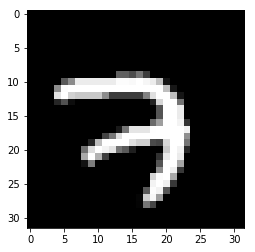

(32, 32, 32, 1)
Class = 4


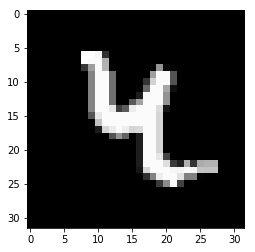

(32, 32, 32, 1)
Class = 4


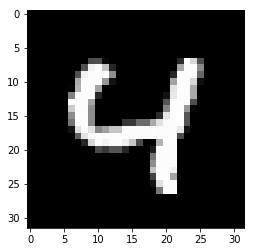

In [5]:
for batch, batch_classes in batch_gen(train_dataset, train_labels, batch_size=32, steps=3, normalization=False):
    print(batch.shape)
    print('Class =', batch_classes[0].tolist().index(1))
    plt.imshow(np.squeeze(batch[0]), cmap='gray')
    plt.show()


In [11]:
conv1_w.size
idx, val = next(np.ndenumerate(conv1_w))
print(idx)
print(conv1_w[idx])
print(conv1_w[0,0,0,0])
batch_size=32
steps=len(train_dataset)//batch_size
# for it, (batch, classes) in enumerate(batch_gen(train_dataset, train_labels, batch_size=batch_size, steps=steps, normalization=True)):
#     print(it)

i = 0
for layer in [conv1_w, conv2_w, conv3_w, dens1_w, dens2_w]:
    for idx, val in np.ndenumerate(layer):
        print(i)
        i += 1
#         print(idx)

(0, 0, 0, 0)
-0.01978141689973074
-0.01978141689973074
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263

3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539


6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538


9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348
9349
9350
9351
9352
9353
9354
9355
9356
9357
9358
9359
9360
9361
9362
9363
9364
9365
9366
9367
9368
9369
9370
9371
9372
9373
9374
9375
9376
9377
9378
9379
9380
9381
9382
9383
9384
9385
9386
9387
9388
9389
9390
9391
9392
9393
9394
9395
9396
9397
9398
9399
9400
9401
9402
9403
9404
9405
9406
9407
9408
9409
9410
9411
9412
9413
9414
9415
9416
9417
9418
9419
9420
9421
9422
9423
9424
9425
9426
9427
9428
9429
9430
9431
9432
9433
9434
9435
9436
9437
9438
9439
9440
9441
9442
9443
9444
9445
9446
9447
9448
9449
9450
9451
9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536


10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856
10857
10858
10859
10860
10861
10862
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872
10873
10874
10875
10876
10877
10878
10879
10880
10881
10882
10883
10884
10885
10886
10887
10888
10889
10890
10891
10892
10893
10894
10895
10896
10897
10898
10899
10900
10901
10902
10903
10904
10905
10906
10907
10908
10909
10910
10911
10912
10913
10914
10915
10916
10917
10918
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931
10932
10933
10934
10935
10936
10937
10938
10939
10940
10941
10942
10943
10944
10945
10946
10947
10948
10949
10950
10951
10952
10953
10954
10955
10956
10957
10958
10959
10960
10961
10962
10963
10964
10965
10966
10967
10968
10969
10970
10971
10972
10973
10974
10975
10976
10977
10978
10979
10980
10981
10982
10983
10984
10985
10986
10987
10988
10989
10990
10991
10992
10993
10994
10995
10996
10997
10998
10999
11000
11001
1100

12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
12380
12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411
12412
12413
12414
12415
12416
12417
12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
12470
12471
12472
12473
12474
12475
12476
12477
12478
12479
12480
12481
12482
12483
12484
12485
12486
12487
12488
12489
12490
12491
12492
12493
12494
12495
12496
12497
12498
12499
12500
12501
1250

13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
13957
13958
13959
13960
13961
13962
13963
13964
13965
13966
13967
13968
13969
13970
13971
13972
13973
13974
13975
13976
13977
13978
13979
13980
13981
13982
13983
13984
13985
13986
13987
13988
13989
13990
13991
13992
13993
13994
13995
13996
13997
13998
13999
14000
1400

15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
1600

17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17855
17856
17857
17858
17859
17860
17861
17862
17863
17864
17865
17866
17867
17868
17869
17870
17871
17872
17873
17874
17875
17876
17877
17878
17879
17880
17881
17882
17883
17884
17885
17886
17887
17888
17889
17890
17891
17892
17893
17894
17895
17896
17897
17898
17899
17900
17901
17902
17903
17904
17905
17906
17907
17908
17909
17910
17911
17912
17913
17914
17915
17916
17917
17918
17919
17920
17921
17922
17923
17924
17925
17926
17927
17928
17929
17930
17931
17932
17933
17934
17935
17936
17937
17938
17939
17940
17941
17942
17943
17944
17945
17946
17947
17948
17949
17950
17951
17952
17953
17954
17955
17956
17957
17958
17959
17960
17961
17962
17963
17964
17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
17975
17976
17977
17978
17979
17980
17981
17982
17983
17984
17985
17986
17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
1799

20832
20833
20834
20835
20836
20837
20838
20839
20840
20841
20842
20843
20844
20845
20846
20847
20848
20849
20850
20851
20852
20853
20854
20855
20856
20857
20858
20859
20860
20861
20862
20863
20864
20865
20866
20867
20868
20869
20870
20871
20872
20873
20874
20875
20876
20877
20878
20879
20880
20881
20882
20883
20884
20885
20886
20887
20888
20889
20890
20891
20892
20893
20894
20895
20896
20897
20898
20899
20900
20901
20902
20903
20904
20905
20906
20907
20908
20909
20910
20911
20912
20913
20914
20915
20916
20917
20918
20919
20920
20921
20922
20923
20924
20925
20926
20927
20928
20929
20930
20931
20932
20933
20934
20935
20936
20937
20938
20939
20940
20941
20942
20943
20944
20945
20946
20947
20948
20949
20950
20951
20952
20953
20954
20955
20956
20957
20958
20959
20960
20961
20962
20963
20964
20965
20966
20967
20968
20969
20970
20971
20972
20973
20974
20975
20976
20977
20978
20979
20980
20981
20982
20983
20984
20985
20986
20987
20988
20989
20990
20991
20992
20993
20994
20995
20996
20997
2099

23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
2399

26830
26831
26832
26833
26834
26835
26836
26837
26838
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848
26849
26850
26851
26852
26853
26854
26855
26856
26857
26858
26859
26860
26861
26862
26863
26864
26865
26866
26867
26868
26869
26870
26871
26872
26873
26874
26875
26876
26877
26878
26879
26880
26881
26882
26883
26884
26885
26886
26887
26888
26889
26890
26891
26892
26893
26894
26895
26896
26897
26898
26899
26900
26901
26902
26903
26904
26905
26906
26907
26908
26909
26910
26911
26912
26913
26914
26915
26916
26917
26918
26919
26920
26921
26922
26923
26924
26925
26926
26927
26928
26929
26930
26931
26932
26933
26934
26935
26936
26937
26938
26939
26940
26941
26942
26943
26944
26945
26946
26947
26948
26949
26950
26951
26952
26953
26954
26955
26956
26957
26958
26959
26960
26961
26962
26963
26964
26965
26966
26967
26968
26969
26970
26971
26972
26973
26974
26975
26976
26977
26978
26979
26980
26981
26982
26983
26984
26985
26986
26987
26988
26989
26990
26991
26992
26993
26994
26995
2699

29829
29830
29831
29832
29833
29834
29835
29836
29837
29838
29839
29840
29841
29842
29843
29844
29845
29846
29847
29848
29849
29850
29851
29852
29853
29854
29855
29856
29857
29858
29859
29860
29861
29862
29863
29864
29865
29866
29867
29868
29869
29870
29871
29872
29873
29874
29875
29876
29877
29878
29879
29880
29881
29882
29883
29884
29885
29886
29887
29888
29889
29890
29891
29892
29893
29894
29895
29896
29897
29898
29899
29900
29901
29902
29903
29904
29905
29906
29907
29908
29909
29910
29911
29912
29913
29914
29915
29916
29917
29918
29919
29920
29921
29922
29923
29924
29925
29926
29927
29928
29929
29930
29931
29932
29933
29934
29935
29936
29937
29938
29939
29940
29941
29942
29943
29944
29945
29946
29947
29948
29949
29950
29951
29952
29953
29954
29955
29956
29957
29958
29959
29960
29961
29962
29963
29964
29965
29966
29967
29968
29969
29970
29971
29972
29973
29974
29975
29976
29977
29978
29979
29980
29981
29982
29983
29984
29985
29986
29987
29988
29989
29990
29991
29992
29993
29994
2999

33328
33329
33330
33331
33332
33333
33334
33335
33336
33337
33338
33339
33340
33341
33342
33343
33344
33345
33346
33347
33348
33349
33350
33351
33352
33353
33354
33355
33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
33374
33375
33376
33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
3349

36562
36563
36564
36565
36566
36567
36568
36569
36570
36571
36572
36573
36574
36575
36576
36577
36578
36579
36580
36581
36582
36583
36584
36585
36586
36587
36588
36589
36590
36591
36592
36593
36594
36595
36596
36597
36598
36599
36600
36601
36602
36603
36604
36605
36606
36607
36608
36609
36610
36611
36612
36613
36614
36615
36616
36617
36618
36619
36620
36621
36622
36623
36624
36625
36626
36627
36628
36629
36630
36631
36632
36633
36634
36635
36636
36637
36638
36639
36640
36641
36642
36643
36644
36645
36646
36647
36648
36649
36650
36651
36652
36653
36654
36655
36656
36657
36658
36659
36660
36661
36662
36663
36664
36665
36666
36667
36668
36669
36670
36671
36672
36673
36674
36675
36676
36677
36678
36679
36680
36681
36682
36683
36684
36685
36686
36687
36688
36689
36690
36691
36692
36693
36694
36695
36696
36697
36698
36699
36700
36701
36702
36703
36704
36705
36706
36707
36708
36709
36710
36711
36712
36713
36714
36715
36716
36717
36718
36719
36720
36721
36722
36723
36724
36725
36726
36727
3672

39826
39827
39828
39829
39830
39831
39832
39833
39834
39835
39836
39837
39838
39839
39840
39841
39842
39843
39844
39845
39846
39847
39848
39849
39850
39851
39852
39853
39854
39855
39856
39857
39858
39859
39860
39861
39862
39863
39864
39865
39866
39867
39868
39869
39870
39871
39872
39873
39874
39875
39876
39877
39878
39879
39880
39881
39882
39883
39884
39885
39886
39887
39888
39889
39890
39891
39892
39893
39894
39895
39896
39897
39898
39899
39900
39901
39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
39925
39926
39927
39928
39929
39930
39931
39932
39933
39934
39935
39936
39937
39938
39939
39940
39941
39942
39943
39944
39945
39946
39947
39948
39949
39950
39951
39952
39953
39954
39955
39956
39957
39958
39959
39960
39961
39962
39963
39964
39965
39966
39967
39968
39969
39970
39971
39972
39973
39974
39975
39976
39977
39978
39979
39980
39981
39982
39983
39984
39985
39986
39987
39988
39989
39990
39991
3999

42981
42982
42983
42984
42985
42986
42987
42988
42989
42990
42991
42992
42993
42994
42995
42996
42997
42998
42999
43000
43001
43002
43003
43004
43005
43006
43007
43008
43009
43010
43011
43012
43013
43014
43015
43016
43017
43018
43019
43020
43021
43022
43023
43024
43025
43026
43027
43028
43029
43030
43031
43032
43033
43034
43035
43036
43037
43038
43039
43040
43041
43042
43043
43044
43045
43046
43047
43048
43049
43050
43051
43052
43053
43054
43055
43056
43057
43058
43059
43060
43061
43062
43063
43064
43065
43066
43067
43068
43069
43070
43071
43072
43073
43074
43075
43076
43077
43078
43079
43080
43081
43082
43083
43084
43085
43086
43087
43088
43089
43090
43091
43092
43093
43094
43095
43096
43097
43098
43099
43100
43101
43102
43103
43104
43105
43106
43107
43108
43109
43110
43111
43112
43113
43114
43115
43116
43117
43118
43119
43120
43121
43122
43123
43124
43125
43126
43127
43128
43129
43130
43131
43132
43133
43134
43135
43136
43137
43138
43139
43140
43141
43142
43143
43144
43145
43146
4314

46824
46825
46826
46827
46828
46829
46830
46831
46832
46833
46834
46835
46836
46837
46838
46839
46840
46841
46842
46843
46844
46845
46846
46847
46848
46849
46850
46851
46852
46853
46854
46855
46856
46857
46858
46859
46860
46861
46862
46863
46864
46865
46866
46867
46868
46869
46870
46871
46872
46873
46874
46875
46876
46877
46878
46879
46880
46881
46882
46883
46884
46885
46886
46887
46888
46889
46890
46891
46892
46893
46894
46895
46896
46897
46898
46899
46900
46901
46902
46903
46904
46905
46906
46907
46908
46909
46910
46911
46912
46913
46914
46915
46916
46917
46918
46919
46920
46921
46922
46923
46924
46925
46926
46927
46928
46929
46930
46931
46932
46933
46934
46935
46936
46937
46938
46939
46940
46941
46942
46943
46944
46945
46946
46947
46948
46949
46950
46951
46952
46953
46954
46955
46956
46957
46958
46959
46960
46961
46962
46963
46964
46965
46966
46967
46968
46969
46970
46971
46972
46973
46974
46975
46976
46977
46978
46979
46980
46981
46982
46983
46984
46985
46986
46987
46988
46989
4699

49998
49999
50000
50001
50002
50003
50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
50014
50015
50016
50017
50018
50019
50020
50021
50022
50023
50024
50025
50026
50027
50028
50029
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50055
50056
50057
50058
50059
50060
50061
50062
50063
50064
50065
50066
50067
50068
50069
50070
50071
50072
50073
50074
50075
50076
50077
50078
50079
50080
50081
50082
50083
50084
50085
50086
50087
50088
50089
50090
50091
50092
50093
50094
50095
50096
50097
50098
50099
50100
50101
50102
50103
50104
50105
50106
50107
50108
50109
50110
50111
50112
50113
50114
50115
50116
50117
50118
50119
50120
50121
50122
50123
50124
50125
50126
50127
50128
50129
50130
50131
50132
50133
50134
50135
50136
50137
50138
50139
50140
50141
50142
50143
50144
50145
50146
50147
50148
50149
50150
50151
50152
50153
50154
50155
50156
50157
50158
50159
50160
50161
50162
50163
5016

53322
53323
53324
53325
53326
53327
53328
53329
53330
53331
53332
53333
53334
53335
53336
53337
53338
53339
53340
53341
53342
53343
53344
53345
53346
53347
53348
53349
53350
53351
53352
53353
53354
53355
53356
53357
53358
53359
53360
53361
53362
53363
53364
53365
53366
53367
53368
53369
53370
53371
53372
53373
53374
53375
53376
53377
53378
53379
53380
53381
53382
53383
53384
53385
53386
53387
53388
53389
53390
53391
53392
53393
53394
53395
53396
53397
53398
53399
53400
53401
53402
53403
53404
53405
53406
53407
53408
53409
53410
53411
53412
53413
53414
53415
53416
53417
53418
53419
53420
53421
53422
53423
53424
53425
53426
53427
53428
53429
53430
53431
53432
53433
53434
53435
53436
53437
53438
53439
53440
53441
53442
53443
53444
53445
53446
53447
53448
53449
53450
53451
53452
53453
53454
53455
53456
53457
53458
53459
53460
53461
53462
53463
53464
53465
53466
53467
53468
53469
53470
53471
53472
53473
53474
53475
53476
53477
53478
53479
53480
53481
53482
53483
53484
53485
53486
53487
5348

56821
56822
56823
56824
56825
56826
56827
56828
56829
56830
56831
56832
56833
56834
56835
56836
56837
56838
56839
56840
56841
56842
56843
56844
56845
56846
56847
56848
56849
56850
56851
56852
56853
56854
56855
56856
56857
56858
56859
56860
56861
56862
56863
56864
56865
56866
56867
56868
56869
56870
56871
56872
56873
56874
56875
56876
56877
56878
56879
56880
56881
56882
56883
56884
56885
56886
56887
56888
56889
56890
56891
56892
56893
56894
56895
56896
56897
56898
56899
56900
56901
56902
56903
56904
56905
56906
56907
56908
56909
56910
56911
56912
56913
56914
56915
56916
56917
56918
56919
56920
56921
56922
56923
56924
56925
56926
56927
56928
56929
56930
56931
56932
56933
56934
56935
56936
56937
56938
56939
56940
56941
56942
56943
56944
56945
56946
56947
56948
56949
56950
56951
56952
56953
56954
56955
56956
56957
56958
56959
56960
56961
56962
56963
56964
56965
56966
56967
56968
56969
56970
56971
56972
56973
56974
56975
56976
56977
56978
56979
56980
56981
56982
56983
56984
56985
56986
5698

59820
59821
59822
59823
59824
59825
59826
59827
59828
59829
59830
59831
59832
59833
59834
59835
59836
59837
59838
59839
59840
59841
59842
59843
59844
59845
59846
59847
59848
59849
59850
59851
59852
59853
59854
59855
59856
59857
59858
59859
59860
59861
59862
59863
59864
59865
59866
59867
59868
59869
59870
59871
59872
59873
59874
59875
59876
59877
59878
59879
59880
59881
59882
59883
59884
59885
59886
59887
59888
59889
59890
59891
59892
59893
59894
59895
59896
59897
59898
59899
59900
59901
59902
59903
59904
59905
59906
59907
59908
59909
59910
59911
59912
59913
59914
59915
59916
59917
59918
59919
59920
59921
59922
59923
59924
59925
59926
59927
59928
59929
59930
59931
59932
59933
59934
59935
59936
59937
59938
59939
59940
59941
59942
59943
59944
59945
59946
59947
59948
59949
59950
59951
59952
59953
59954
59955
59956
59957
59958
59959
59960
59961
59962
59963
59964
59965
59966
59967
59968
59969
59970
59971
59972
59973
59974
59975
59976
59977
59978
59979
59980
59981
59982
59983
59984
59985
5998

In [12]:
%%time

batch_size = 32
h = 0.001
learning_rate = 0.01
layers = [conv1_w, conv2_w, conv3_w, dens1_w, dens2_w]
# prev_dw = np.inf

for batch, classes in batch_gen(train_dataset, train_labels, batch_size=batch_size, steps=1, normalization=True):

    classes = np.argmax(classes, axis=1)

    for layer_idx, layer in enumerate(layers):
        print('layer:', layer_idx)

        for idx, val in np.ndenumerate(layer):

            # calculando L(w)
            Lw_results = np.zeros((batch_size,))
            for i, img, cl in zip(range(batch_size), batch, classes):
                # print(cl)
                # plt.imshow(np.squeeze(img), cmap='gray')
                # plt.show()
                softscores = softmax(forward(img))
                Lw_results[i] = -np.log(softscores[cl])

            # calculando L(w+h)
            layer[idx] += h
            Lwh_results = np.zeros((batch_size,))
            for i, img, cl in zip(range(batch_size), batch, classes):
                softscores = softmax(forward(img))
                Lwh_results[i] = -np.log(softscores[cl])
            layer[idx] -= h

            Lw =  Lw_results.mean()
            Lwh = Lwh_results.mean()

            # dw
            dw = (Lwh - Lw) / h

            #========================================#
            # SGD
#             if abs(dw) < abs(prev_dw):
            print(idx, end='\t')
            print('Loss:\t', Lw)
            layer[idx] -= dw * learning_rate
#             prev_dw = dw

layer: 0
(0, 0, 0, 0)	Loss:	 2.30499926167023
(0, 0, 0, 1)	Loss:	 2.3049992257027014
(0, 0, 0, 2)	Loss:	 2.304993976465189
(0, 0, 0, 3)	Loss:	 2.304992972828166
(0, 0, 0, 4)	Loss:	 2.3049894015007615
(0, 0, 0, 5)	Loss:	 2.3049762321586424
(0, 1, 0, 0)	Loss:	 2.304965355949447
(0, 1, 0, 1)	Loss:	 2.3049653306421236
(0, 1, 0, 2)	Loss:	 2.3049652392552615
(0, 1, 0, 3)	Loss:	 2.304965115782225
(0, 1, 0, 4)	Loss:	 2.304963563540236
(0, 1, 0, 5)	Loss:	 2.304958513310414
(0, 2, 0, 0)	Loss:	 2.304943214376389
(0, 2, 0, 1)	Loss:	 2.30494277058217
(0, 2, 0, 2)	Loss:	 2.3049362328415763
(0, 2, 0, 3)	Loss:	 2.304935817981945
(0, 2, 0, 4)	Loss:	 2.3049319709122846
(0, 2, 0, 5)	Loss:	 2.304930853687037
(0, 3, 0, 0)	Loss:	 2.3049155848535383
(0, 3, 0, 1)	Loss:	 2.304914336894698
(0, 3, 0, 2)	Loss:	 2.304905186709676
(0, 3, 0, 3)	Loss:	 2.3049019807820885
(0, 3, 0, 4)	Loss:	 2.3048947014647183
(0, 3, 0, 5)	Loss:	 2.3048946634939727
(0, 4, 0, 0)	Loss:	 2.3048846460150756
(0, 4, 0, 1)	Loss:	 2.304884635

(0, 0, 3, 14)	Loss:	 2.3042892552692655
(0, 0, 3, 15)	Loss:	 2.30428925403805
(0, 0, 4, 0)	Loss:	 2.3042892534310506
(0, 0, 4, 1)	Loss:	 2.3042892344406587
(0, 0, 4, 2)	Loss:	 2.304289226904645
(0, 0, 4, 3)	Loss:	 2.3042890723430274
(0, 0, 4, 4)	Loss:	 2.304289023786021
(0, 0, 4, 5)	Loss:	 2.304289005256951
(0, 0, 4, 6)	Loss:	 2.3042888660604017
(0, 0, 4, 7)	Loss:	 2.3042887814310666
(0, 0, 4, 8)	Loss:	 2.3042887377438963
(0, 0, 4, 9)	Loss:	 2.304288737743849
(0, 0, 4, 10)	Loss:	 2.3042886522126946
(0, 0, 4, 11)	Loss:	 2.3042882611752318
(0, 0, 4, 12)	Loss:	 2.304288260696951
(0, 0, 4, 13)	Loss:	 2.304288206903631
(0, 0, 4, 14)	Loss:	 2.304288185622577
(0, 0, 4, 15)	Loss:	 2.3042865942470576
(0, 0, 5, 0)	Loss:	 2.304286592664102
(0, 0, 5, 1)	Loss:	 2.304286590672807
(0, 0, 5, 2)	Loss:	 2.3042863651870307
(0, 0, 5, 3)	Loss:	 2.304286101370218
(0, 0, 5, 4)	Loss:	 2.3042858796518964
(0, 0, 5, 5)	Loss:	 2.3042858706384144
(0, 0, 5, 6)	Loss:	 2.3042856763377846
(0, 0, 5, 7)	Loss:	 2.3042856

(0, 2, 5, 1)	Loss:	 2.3041899335246026
(0, 2, 5, 2)	Loss:	 2.3041899246667352
(0, 2, 5, 3)	Loss:	 2.3041894985673044
(0, 2, 5, 4)	Loss:	 2.30418930001694
(0, 2, 5, 5)	Loss:	 2.3041892972365026
(0, 2, 5, 6)	Loss:	 2.3041892377555655
(0, 2, 5, 7)	Loss:	 2.304189110382935
(0, 2, 5, 8)	Loss:	 2.3041890555713005
(0, 2, 5, 9)	Loss:	 2.304189051320699
(0, 2, 5, 10)	Loss:	 2.304188732428061
(0, 2, 5, 11)	Loss:	 2.304186619293441
(0, 2, 5, 12)	Loss:	 2.3041864745024263
(0, 2, 5, 13)	Loss:	 2.304186468688277
(0, 2, 5, 14)	Loss:	 2.304186446675711
(0, 2, 5, 15)	Loss:	 2.3041858066905307
(0, 3, 0, 0)	Loss:	 2.3041858065433747
(0, 3, 0, 1)	Loss:	 2.304185035428876
(0, 3, 0, 2)	Loss:	 2.304185032886532
(0, 3, 0, 3)	Loss:	 2.304184516170343
(0, 3, 0, 4)	Loss:	 2.304183089628333
(0, 3, 0, 5)	Loss:	 2.3041829853470626
(0, 3, 0, 6)	Loss:	 2.3041828748725672
(0, 3, 0, 7)	Loss:	 2.3041823883184955
(0, 3, 0, 8)	Loss:	 2.3041822700374444
(0, 3, 0, 9)	Loss:	 2.304182269789351
(0, 3, 0, 10)	Loss:	 2.304181694

(1, 0, 0, 4)	Loss:	 2.304118522551517
(1, 0, 0, 5)	Loss:	 2.304118522506532
(1, 0, 0, 6)	Loss:	 2.3041185115630145
(1, 0, 0, 7)	Loss:	 2.304118476789764
(1, 0, 0, 8)	Loss:	 2.3041166136439615
(1, 0, 0, 9)	Loss:	 2.304116611471536
(1, 0, 0, 10)	Loss:	 2.304116221302424
(1, 0, 0, 11)	Loss:	 2.304115892987004
(1, 0, 0, 12)	Loss:	 2.3041157642944676
(1, 0, 0, 13)	Loss:	 2.3041157000956636
(1, 0, 0, 14)	Loss:	 2.3041156565038112
(1, 0, 0, 15)	Loss:	 2.3041154988186943
(1, 0, 1, 0)	Loss:	 2.3041154986236743
(1, 0, 1, 1)	Loss:	 2.3041154985057943
(1, 0, 1, 2)	Loss:	 2.304115498134264
(1, 0, 1, 3)	Loss:	 2.3041150457733544
(1, 0, 1, 4)	Loss:	 2.3041150447724137
(1, 0, 1, 5)	Loss:	 2.304115017873144
(1, 0, 1, 6)	Loss:	 2.3041149998553236
(1, 0, 1, 7)	Loss:	 2.3041105524531
(1, 0, 1, 8)	Loss:	 2.304110069487505
(1, 0, 1, 9)	Loss:	 2.304109991388624
(1, 0, 1, 10)	Loss:	 2.304109981092547
(1, 0, 1, 11)	Loss:	 2.3040908658877086
(1, 0, 1, 12)	Loss:	 2.304090327194812
(1, 0, 1, 13)	Loss:	 2.30409028

(1, 2, 1, 8)	Loss:	 2.3039910430028514
(1, 2, 1, 9)	Loss:	 2.3039910115786535
(1, 2, 1, 10)	Loss:	 2.3039851462271748
(1, 2, 1, 11)	Loss:	 2.3039823285203616
(1, 2, 1, 12)	Loss:	 2.3039779539222827
(1, 2, 1, 13)	Loss:	 2.303977767785712
(1, 2, 1, 14)	Loss:	 2.3039776824885823
(1, 2, 1, 15)	Loss:	 2.3039743247165556
(1, 2, 2, 0)	Loss:	 2.3039743185501074
(1, 2, 2, 1)	Loss:	 2.3039741892393035
(1, 2, 2, 2)	Loss:	 2.3039741700229115
(1, 2, 2, 3)	Loss:	 2.303973868297038
(1, 2, 2, 4)	Loss:	 2.303971992262986
(1, 2, 2, 5)	Loss:	 2.3039718946939325
(1, 2, 2, 6)	Loss:	 2.303969382341882
(1, 2, 2, 7)	Loss:	 2.3039693703227115
(1, 2, 2, 8)	Loss:	 2.3039693397674488
(1, 2, 2, 9)	Loss:	 2.3039692864173134
(1, 2, 2, 10)	Loss:	 2.3039687476474318
(1, 2, 2, 11)	Loss:	 2.3039670936928798
(1, 2, 2, 12)	Loss:	 2.3039670930241694
(1, 2, 2, 13)	Loss:	 2.303967078250465
(1, 2, 2, 14)	Loss:	 2.303966606089294
(1, 2, 2, 15)	Loss:	 2.30396626431829
(1, 2, 3, 0)	Loss:	 2.3039662633277285
(1, 2, 3, 1)	Loss:	 2

(1, 4, 2, 11)	Loss:	 2.303881126056575
(1, 4, 2, 12)	Loss:	 2.3038810518740944
(1, 4, 2, 13)	Loss:	 2.303881051674094
(1, 4, 2, 14)	Loss:	 2.303879626375716
(1, 4, 2, 15)	Loss:	 2.3038793051950366
(1, 4, 3, 0)	Loss:	 2.3038793051902076
(1, 4, 3, 1)	Loss:	 2.3038791916789862
(1, 4, 3, 2)	Loss:	 2.303879190196138
(1, 4, 3, 3)	Loss:	 2.3038791478274643
(1, 4, 3, 4)	Loss:	 2.3038782734862986
(1, 4, 3, 5)	Loss:	 2.3038782529755126
(1, 4, 3, 6)	Loss:	 2.3038782489955816
(1, 4, 3, 7)	Loss:	 2.3038781978082663
(1, 4, 3, 8)	Loss:	 2.3038775513408405
(1, 4, 3, 9)	Loss:	 2.303877534439973
(1, 4, 3, 10)	Loss:	 2.3038751475743826
(1, 4, 3, 11)	Loss:	 2.3038751014903047
(1, 4, 3, 12)	Loss:	 2.303875012852962
(1, 4, 3, 13)	Loss:	 2.3038749847967632
(1, 4, 3, 14)	Loss:	 2.3038748601538694
(1, 4, 3, 15)	Loss:	 2.303874713825545
(1, 4, 4, 0)	Loss:	 2.3038747136347446
(1, 4, 4, 1)	Loss:	 2.303874710194574
(1, 4, 4, 2)	Loss:	 2.3038747099356236
(1, 4, 4, 3)	Loss:	 2.303874580060497
(1, 4, 4, 4)	Loss:	 2.3

(2, 1, 3, 14)	Loss:	 2.3037674176556093
(2, 1, 3, 15)	Loss:	 2.303766980097185
(2, 1, 4, 0)	Loss:	 2.303766980011655
(2, 1, 4, 1)	Loss:	 2.303766961048379
(2, 1, 4, 2)	Loss:	 2.3037669610604854
(2, 1, 4, 3)	Loss:	 2.3037669610064175
(2, 1, 4, 4)	Loss:	 2.3037668336396973
(2, 1, 4, 5)	Loss:	 2.303766831867421
(2, 1, 4, 6)	Loss:	 2.3037667434583717
(2, 1, 4, 7)	Loss:	 2.3037664289404924
(2, 1, 4, 8)	Loss:	 2.303766125821567
(2, 1, 4, 9)	Loss:	 2.3037661248023014
(2, 1, 4, 10)	Loss:	 2.303765505997314
(2, 1, 4, 11)	Loss:	 2.3037644635310195
(2, 1, 4, 12)	Loss:	 2.303764373535773
(2, 1, 4, 13)	Loss:	 2.3037641778871505
(2, 1, 4, 14)	Loss:	 2.30376414692799
(2, 1, 4, 15)	Loss:	 2.3037639499887312
(2, 1, 5, 0)	Loss:	 2.303763949977196
(2, 1, 5, 1)	Loss:	 2.30376380025715
(2, 1, 5, 2)	Loss:	 2.30376379837377
(2, 1, 5, 3)	Loss:	 2.3037637976543115
(2, 1, 5, 4)	Loss:	 2.3037633006422005
(2, 1, 5, 5)	Loss:	 2.3037632476142607
(2, 1, 5, 6)	Loss:	 2.3037630936473454
(2, 1, 5, 7)	Loss:	 2.303762802

(2, 3, 5, 1)	Loss:	 2.3036018000379537
(2, 3, 5, 2)	Loss:	 2.3036017544317957
(2, 3, 5, 3)	Loss:	 2.303601407945397
(2, 3, 5, 4)	Loss:	 2.3036012756363453
(2, 3, 5, 5)	Loss:	 2.303601274331664
(2, 3, 5, 6)	Loss:	 2.303600791234755
(2, 3, 5, 7)	Loss:	 2.3036006544520737
(2, 3, 5, 8)	Loss:	 2.3035991726724014
(2, 3, 5, 9)	Loss:	 2.3035991699166845
(2, 3, 5, 10)	Loss:	 2.3035989598715165
(2, 3, 5, 11)	Loss:	 2.3035983050262305
(2, 3, 5, 12)	Loss:	 2.303597971880771
(2, 3, 5, 13)	Loss:	 2.303597948416315
(2, 3, 5, 14)	Loss:	 2.303597939854135
(2, 3, 5, 15)	Loss:	 2.303597545627393
(2, 4, 0, 0)	Loss:	 2.303597542542725
(2, 4, 0, 1)	Loss:	 2.3035974941160426
(2, 4, 0, 2)	Loss:	 2.3035974933360617
(2, 4, 0, 3)	Loss:	 2.303597218543123
(2, 4, 0, 4)	Loss:	 2.3035969576870654
(2, 4, 0, 5)	Loss:	 2.3035968776554805
(2, 4, 0, 6)	Loss:	 2.303595938380229
(2, 4, 0, 7)	Loss:	 2.30359589840161
(2, 4, 0, 8)	Loss:	 2.303593899439157
(2, 4, 0, 9)	Loss:	 2.303593876843569
(2, 4, 0, 10)	Loss:	 2.3035906187

(3, 1, 0, 4)	Loss:	 2.303455673398104
(3, 1, 0, 5)	Loss:	 2.3034556721639157
(3, 1, 0, 6)	Loss:	 2.3034545067334404
(3, 1, 0, 7)	Loss:	 2.3034545033878544
(3, 1, 0, 8)	Loss:	 2.303454382719144
(3, 1, 0, 9)	Loss:	 2.303454366771305
(3, 1, 0, 10)	Loss:	 2.3034511847116623
(3, 1, 0, 11)	Loss:	 2.303448209319756
(3, 1, 0, 12)	Loss:	 2.303448165153224
(3, 1, 0, 13)	Loss:	 2.3034481265029814
(3, 1, 0, 14)	Loss:	 2.3034475969816155
(3, 1, 0, 15)	Loss:	 2.303446574406862
(3, 1, 1, 0)	Loss:	 2.3034465695373925
(3, 1, 1, 1)	Loss:	 2.303445320108989
(3, 1, 1, 2)	Loss:	 2.3034453137866007
(3, 1, 1, 3)	Loss:	 2.3034447520768184
(3, 1, 1, 4)	Loss:	 2.3034447504119506
(3, 1, 1, 5)	Loss:	 2.303444669801424
(3, 1, 1, 6)	Loss:	 2.303443118508535
(3, 1, 1, 7)	Loss:	 2.303439320943403
(3, 1, 1, 8)	Loss:	 2.303435340090463
(3, 1, 1, 9)	Loss:	 2.303435339237412
(3, 1, 1, 10)	Loss:	 2.303435323160722
(3, 1, 1, 11)	Loss:	 2.3034347009612772
(3, 1, 1, 12)	Loss:	 2.3034302568416196
(3, 1, 1, 13)	Loss:	 2.303428

(3, 3, 1, 7)	Loss:	 2.3032986782672573
(3, 3, 1, 8)	Loss:	 2.303297992997413
(3, 3, 1, 9)	Loss:	 2.3032979922105543
(3, 3, 1, 10)	Loss:	 2.303257511318665
(3, 3, 1, 11)	Loss:	 2.303257423814374
(3, 3, 1, 12)	Loss:	 2.30325110943431
(3, 3, 1, 13)	Loss:	 2.3032506155521624
(3, 3, 1, 14)	Loss:	 2.303250510695505
(3, 3, 1, 15)	Loss:	 2.3032497926819766
(3, 3, 2, 0)	Loss:	 2.3032497926521227
(3, 3, 2, 1)	Loss:	 2.303249673741316
(3, 3, 2, 2)	Loss:	 2.3032494206992062
(3, 3, 2, 3)	Loss:	 2.303249245053694
(3, 3, 2, 4)	Loss:	 2.303248988534462
(3, 3, 2, 5)	Loss:	 2.303248940862162
(3, 3, 2, 6)	Loss:	 2.303248509498225
(3, 3, 2, 7)	Loss:	 2.3032485080730947
(3, 3, 2, 8)	Loss:	 2.3032428261154143
(3, 3, 2, 9)	Loss:	 2.3032427432061082
(3, 3, 2, 10)	Loss:	 2.303233381530319
(3, 3, 2, 11)	Loss:	 2.3032275447285038
(3, 3, 2, 12)	Loss:	 2.3032272715832676
(3, 3, 2, 13)	Loss:	 2.3032272339415085
(3, 3, 2, 14)	Loss:	 2.303227094347762
(3, 3, 2, 15)	Loss:	 2.3032267807370843
(3, 3, 3, 0)	Loss:	 2.3032

(4, 0, 2, 10)	Loss:	 2.30307577703371
(4, 0, 2, 11)	Loss:	 2.3030677752487883
(4, 0, 2, 12)	Loss:	 2.3030677179753645
(4, 0, 2, 13)	Loss:	 2.3030676927690616
(4, 0, 2, 14)	Loss:	 2.3030668655766404
(4, 0, 2, 15)	Loss:	 2.3030668575576283
(4, 0, 3, 0)	Loss:	 2.3030668567314008
(4, 0, 3, 1)	Loss:	 2.303066839283135
(4, 0, 3, 2)	Loss:	 2.3030663171491166
(4, 0, 3, 3)	Loss:	 2.3030659251588212
(4, 0, 3, 4)	Loss:	 2.3030658772424992
(4, 0, 3, 5)	Loss:	 2.3030658761455087
(4, 0, 3, 6)	Loss:	 2.30306584317262
(4, 0, 3, 7)	Loss:	 2.3030658041298255
(4, 0, 3, 8)	Loss:	 2.3030658026901403
(4, 0, 3, 9)	Loss:	 2.303065802689024
(4, 0, 3, 10)	Loss:	 2.3030657844588167
(4, 0, 3, 11)	Loss:	 2.30306418973021
(4, 0, 3, 12)	Loss:	 2.303064052101492
(4, 0, 3, 13)	Loss:	 2.303064037523545
(4, 0, 3, 14)	Loss:	 2.303063951451734
(4, 0, 3, 15)	Loss:	 2.3030639514815467
(4, 0, 4, 0)	Loss:	 2.3030639512791025
(4, 0, 4, 1)	Loss:	 2.3030636750529836
(4, 0, 4, 2)	Loss:	 2.3030636682781433
(4, 0, 4, 3)	Loss:	 2.30

(4, 2, 3, 13)	Loss:	 2.3029399301215268
(4, 2, 3, 14)	Loss:	 2.302939929604647
(4, 2, 3, 15)	Loss:	 2.3029399289004227
(4, 2, 4, 0)	Loss:	 2.302939928899323
(4, 2, 4, 1)	Loss:	 2.30293983664971
(4, 2, 4, 2)	Loss:	 2.3029398330718895
(4, 2, 4, 3)	Loss:	 2.3029394232952574
(4, 2, 4, 4)	Loss:	 2.3029394166456294
(4, 2, 4, 5)	Loss:	 2.3029394166329453
(4, 2, 4, 6)	Loss:	 2.302938683813035
(4, 2, 4, 7)	Loss:	 2.302938563564605
(4, 2, 4, 8)	Loss:	 2.302937845149552
(4, 2, 4, 9)	Loss:	 2.3029378451118276
(4, 2, 4, 10)	Loss:	 2.302937733930223
(4, 2, 4, 11)	Loss:	 2.302937732091687
(4, 2, 4, 12)	Loss:	 2.302937661599953
(4, 2, 4, 13)	Loss:	 2.3029376591372497
(4, 2, 4, 14)	Loss:	 2.302937651530922
(4, 2, 4, 15)	Loss:	 2.302937636913354
(4, 2, 5, 0)	Loss:	 2.302937636800454
(4, 2, 5, 1)	Loss:	 2.3029371635487523
(4, 2, 5, 2)	Loss:	 2.302937161775656
(4, 2, 5, 3)	Loss:	 2.3029360240052763
(4, 2, 5, 4)	Loss:	 2.3029360209733682
(4, 2, 5, 5)	Loss:	 2.3029360147303235
(4, 2, 5, 6)	Loss:	 2.30293581

(4, 4, 5, 0)	Loss:	 2.3027965384561497
(4, 4, 5, 1)	Loss:	 2.302796401914269
(4, 4, 5, 2)	Loss:	 2.3027963716892277
(4, 4, 5, 3)	Loss:	 2.302796050427877
(4, 4, 5, 4)	Loss:	 2.3027958771584816
(4, 4, 5, 5)	Loss:	 2.3027958756061504
(4, 4, 5, 6)	Loss:	 2.302794964885325
(4, 4, 5, 7)	Loss:	 2.3027949624042954
(4, 4, 5, 8)	Loss:	 2.3027949241636048
(4, 4, 5, 9)	Loss:	 2.302794818148234
(4, 4, 5, 10)	Loss:	 2.3027930355278445
(4, 4, 5, 11)	Loss:	 2.302793027449824
(4, 4, 5, 12)	Loss:	 2.302792160644322
(4, 4, 5, 13)	Loss:	 2.3027921396289077
(4, 4, 5, 14)	Loss:	 2.302792002991601
(4, 4, 5, 15)	Loss:	 2.3027920030899036
layer: 2
(0, 0, 0, 0)	Loss:	 2.3027919998355557
(0, 0, 0, 1)	Loss:	 2.3027919829138606
(0, 0, 0, 2)	Loss:	 2.302791982008603
(0, 0, 0, 3)	Loss:	 2.3027919819671845
(0, 0, 0, 4)	Loss:	 2.30279197876646
(0, 0, 0, 5)	Loss:	 2.3027919712646083
(0, 0, 0, 6)	Loss:	 2.3027919712646003
(0, 0, 0, 7)	Loss:	 2.3027919711080287
(0, 0, 0, 8)	Loss:	 2.302791971107993
(0, 0, 0, 9)	Loss:	 2

(0, 0, 1, 72)	Loss:	 2.3027916922190204
(0, 0, 1, 73)	Loss:	 2.3027916922014477
(0, 0, 1, 74)	Loss:	 2.3027916920927094
(0, 0, 1, 75)	Loss:	 2.302791692054158
(0, 0, 1, 76)	Loss:	 2.302791692026277
(0, 0, 1, 77)	Loss:	 2.30279169092397
(0, 0, 1, 78)	Loss:	 2.302791687807498
(0, 0, 1, 79)	Loss:	 2.3027916875568173
(0, 0, 1, 80)	Loss:	 2.3027916875294365
(0, 0, 1, 81)	Loss:	 2.3027916875294365
(0, 0, 1, 82)	Loss:	 2.302791687268294
(0, 0, 1, 83)	Loss:	 2.302791687247864
(0, 0, 1, 84)	Loss:	 2.302791687193975
(0, 0, 1, 85)	Loss:	 2.3027916871939267
(0, 0, 1, 86)	Loss:	 2.3027916871939267
(0, 0, 1, 87)	Loss:	 2.3027916871939267
(0, 0, 1, 88)	Loss:	 2.3027916871625473
(0, 0, 1, 89)	Loss:	 2.3027916871625473
(0, 0, 1, 90)	Loss:	 2.3027916871625056
(0, 0, 1, 91)	Loss:	 2.3027916866733236
(0, 0, 1, 92)	Loss:	 2.3027916866733236
(0, 0, 1, 93)	Loss:	 2.302791686502492
(0, 0, 1, 94)	Loss:	 2.302791686438396
(0, 0, 1, 95)	Loss:	 2.302791686415418
(0, 0, 1, 96)	Loss:	 2.3027916864054525
(0, 0, 1, 9

(0, 0, 3, 39)	Loss:	 2.30279043192109
(0, 0, 3, 40)	Loss:	 2.3027904319148753
(0, 0, 3, 41)	Loss:	 2.3027904313046164
(0, 0, 3, 42)	Loss:	 2.302790429241151
(0, 0, 3, 43)	Loss:	 2.302790428103375
(0, 0, 3, 44)	Loss:	 2.3027904271373894
(0, 0, 3, 45)	Loss:	 2.3027904237265995
(0, 0, 3, 46)	Loss:	 2.3027904233862317
(0, 0, 3, 47)	Loss:	 2.3027904227542444
(0, 0, 3, 48)	Loss:	 2.302790421679088
(0, 0, 3, 49)	Loss:	 2.3027904141774806
(0, 0, 3, 50)	Loss:	 2.30279041392261
(0, 0, 3, 51)	Loss:	 2.302790413152125
(0, 0, 3, 52)	Loss:	 2.302790413149591
(0, 0, 3, 53)	Loss:	 2.302790396749227
(0, 0, 3, 54)	Loss:	 2.30279039674874
(0, 0, 3, 55)	Loss:	 2.3027903956062623
(0, 0, 3, 56)	Loss:	 2.3027903928764077
(0, 0, 3, 57)	Loss:	 2.3027903895965522
(0, 0, 3, 58)	Loss:	 2.3027903824607714
(0, 0, 3, 59)	Loss:	 2.3027903824591176
(0, 0, 3, 60)	Loss:	 2.3027903820588076
(0, 0, 3, 61)	Loss:	 2.302790380635682
(0, 0, 3, 62)	Loss:	 2.302790380277205
(0, 0, 3, 63)	Loss:	 2.3027903799948395
(0, 0, 3, 64)	

(0, 0, 5, 7)	Loss:	 2.3027899515122217
(0, 0, 5, 8)	Loss:	 2.3027899451208977
(0, 0, 5, 9)	Loss:	 2.302789897109597
(0, 0, 5, 10)	Loss:	 2.3027898688661277
(0, 0, 5, 11)	Loss:	 2.3027898681450525
(0, 0, 5, 12)	Loss:	 2.302789850214935
(0, 0, 5, 13)	Loss:	 2.302789847393408
(0, 0, 5, 14)	Loss:	 2.302789847393408
(0, 0, 5, 15)	Loss:	 2.302789847393408
(0, 0, 5, 16)	Loss:	 2.302789806788993
(0, 0, 5, 17)	Loss:	 2.3027896620747375
(0, 0, 5, 18)	Loss:	 2.3027896549284197
(0, 0, 5, 19)	Loss:	 2.30278965367013
(0, 0, 5, 20)	Loss:	 2.30278965367013
(0, 0, 5, 21)	Loss:	 2.30278965367013
(0, 0, 5, 22)	Loss:	 2.3027896452712966
(0, 0, 5, 23)	Loss:	 2.3027896452628744
(0, 0, 5, 24)	Loss:	 2.3027896452448906
(0, 0, 5, 25)	Loss:	 2.302789645107991
(0, 0, 5, 26)	Loss:	 2.30278964497231
(0, 0, 5, 27)	Loss:	 2.3027896393686866
(0, 0, 5, 28)	Loss:	 2.3027896393686866
(0, 0, 5, 29)	Loss:	 2.3027896353481503
(0, 0, 5, 30)	Loss:	 2.302789627088599
(0, 0, 5, 31)	Loss:	 2.302789627088599
(0, 0, 5, 32)	Loss:	

(0, 0, 6, 95)	Loss:	 2.3027882925246335
(0, 0, 6, 96)	Loss:	 2.302788290103974
(0, 0, 6, 97)	Loss:	 2.302788288800463
(0, 0, 6, 98)	Loss:	 2.3027882884603668
(0, 0, 6, 99)	Loss:	 2.302788288434048
(0, 0, 6, 100)	Loss:	 2.3027882883936344
(0, 0, 6, 101)	Loss:	 2.302788287548278
(0, 0, 6, 102)	Loss:	 2.3027882875482772
(0, 0, 6, 103)	Loss:	 2.3027882874943835
(0, 0, 6, 104)	Loss:	 2.3027882872583887
(0, 0, 6, 105)	Loss:	 2.3027882872583887
(0, 0, 6, 106)	Loss:	 2.3027882872582435
(0, 0, 6, 107)	Loss:	 2.3027882871839935
(0, 0, 6, 108)	Loss:	 2.3027882871584087
(0, 0, 6, 109)	Loss:	 2.3027882871584087
(0, 0, 6, 110)	Loss:	 2.302788287157953
(0, 0, 6, 111)	Loss:	 2.3027882871360106
(0, 0, 6, 112)	Loss:	 2.302788287132651
(0, 0, 6, 113)	Loss:	 2.302788287095641
(0, 0, 6, 114)	Loss:	 2.30278828554264
(0, 0, 6, 115)	Loss:	 2.302788285541822
(0, 0, 6, 116)	Loss:	 2.3027882840482152
(0, 0, 6, 117)	Loss:	 2.302788280676681
(0, 0, 6, 118)	Loss:	 2.302788280663192
(0, 0, 6, 119)	Loss:	 2.302788278

(0, 0, 8, 62)	Loss:	 2.302787562434079
(0, 0, 8, 63)	Loss:	 2.302787562305275
(0, 0, 8, 64)	Loss:	 2.3027875614525266
(0, 0, 8, 65)	Loss:	 2.3027875613892617
(0, 0, 8, 66)	Loss:	 2.3027875613892617
(0, 0, 8, 67)	Loss:	 2.302787560634471
(0, 0, 8, 68)	Loss:	 2.302787558413037
(0, 0, 8, 69)	Loss:	 2.3027875581871307
(0, 0, 8, 70)	Loss:	 2.3027875581448836
(0, 0, 8, 71)	Loss:	 2.302787558023572
(0, 0, 8, 72)	Loss:	 2.302787557882316
(0, 0, 8, 73)	Loss:	 2.3027875577731445
(0, 0, 8, 74)	Loss:	 2.302787547087843
(0, 0, 8, 75)	Loss:	 2.302787547049168
(0, 0, 8, 76)	Loss:	 2.3027875469838426
(0, 0, 8, 77)	Loss:	 2.3027875469833106
(0, 0, 8, 78)	Loss:	 2.3027875434055716
(0, 0, 8, 79)	Loss:	 2.3027875432436264
(0, 0, 8, 80)	Loss:	 2.3027875432423652
(0, 0, 8, 81)	Loss:	 2.3027875432423652
(0, 0, 8, 82)	Loss:	 2.3027875432291727
(0, 0, 8, 83)	Loss:	 2.302787543105185
(0, 0, 8, 84)	Loss:	 2.3027875431012736
(0, 0, 8, 85)	Loss:	 2.3027875430883236
(0, 0, 8, 86)	Loss:	 2.3027875430883236
(0, 0, 8,

(0, 0, 10, 29)	Loss:	 2.302786562425167
(0, 0, 10, 30)	Loss:	 2.302786562338781
(0, 0, 10, 31)	Loss:	 2.302786562338781
(0, 0, 10, 32)	Loss:	 2.3027865589075955
(0, 0, 10, 33)	Loss:	 2.302786558882124
(0, 0, 10, 34)	Loss:	 2.302786555333813
(0, 0, 10, 35)	Loss:	 2.3027865514751924
(0, 0, 10, 36)	Loss:	 2.3027865514751924
(0, 0, 10, 37)	Loss:	 2.3027865254194833
(0, 0, 10, 38)	Loss:	 2.3027865180539595
(0, 0, 10, 39)	Loss:	 2.3027865180514775
(0, 0, 10, 40)	Loss:	 2.3027865176292526
(0, 0, 10, 41)	Loss:	 2.302786515708711
(0, 0, 10, 42)	Loss:	 2.3027865127643867
(0, 0, 10, 43)	Loss:	 2.302786512374131
(0, 0, 10, 44)	Loss:	 2.3027865122614886
(0, 0, 10, 45)	Loss:	 2.302786509072568
(0, 0, 10, 46)	Loss:	 2.302786469134505
(0, 0, 10, 47)	Loss:	 2.302786460079024
(0, 0, 10, 48)	Loss:	 2.3027864596759855
(0, 0, 10, 49)	Loss:	 2.302786446314787
(0, 0, 10, 50)	Loss:	 2.302786446002196
(0, 0, 10, 51)	Loss:	 2.302786445311435
(0, 0, 10, 52)	Loss:	 2.302786444904469
(0, 0, 10, 53)	Loss:	 2.302786

(0, 0, 11, 111)	Loss:	 2.3027857827157607
(0, 0, 11, 112)	Loss:	 2.3027857826854996
(0, 0, 11, 113)	Loss:	 2.3027857807859777
(0, 0, 11, 114)	Loss:	 2.3027857780773555
(0, 0, 11, 115)	Loss:	 2.3027857780032397
(0, 0, 11, 116)	Loss:	 2.3027857772044604
(0, 0, 11, 117)	Loss:	 2.302785771987037
(0, 0, 11, 118)	Loss:	 2.302785771797963
(0, 0, 11, 119)	Loss:	 2.3027857705940162
(0, 0, 12, 0)	Loss:	 2.302785770172266
(0, 0, 12, 1)	Loss:	 2.3027857644035334
(0, 0, 12, 2)	Loss:	 2.3027857643122083
(0, 0, 12, 3)	Loss:	 2.3027857636528344
(0, 0, 12, 4)	Loss:	 2.302785762484971
(0, 0, 12, 5)	Loss:	 2.3027857566407413
(0, 0, 12, 6)	Loss:	 2.302785755861603
(0, 0, 12, 7)	Loss:	 2.3027857551344546
(0, 0, 12, 8)	Loss:	 2.3027857546619392
(0, 0, 12, 9)	Loss:	 2.3027857544944954
(0, 0, 12, 10)	Loss:	 2.302785747340078
(0, 0, 12, 11)	Loss:	 2.3027857466661166
(0, 0, 12, 12)	Loss:	 2.3027857438880286
(0, 0, 12, 13)	Loss:	 2.3027857438866532
(0, 0, 12, 14)	Loss:	 2.3027857438866532
(0, 0, 12, 15)	Loss:	 2

(0, 0, 13, 73)	Loss:	 2.302785380494921
(0, 0, 13, 74)	Loss:	 2.3027853749708926
(0, 0, 13, 75)	Loss:	 2.302785374890158
(0, 0, 13, 76)	Loss:	 2.302785374564023
(0, 0, 13, 77)	Loss:	 2.3027853745486397
(0, 0, 13, 78)	Loss:	 2.3027853717529645
(0, 0, 13, 79)	Loss:	 2.3027853715871958
(0, 0, 13, 80)	Loss:	 2.3027853715631013
(0, 0, 13, 81)	Loss:	 2.3027853715631013
(0, 0, 13, 82)	Loss:	 2.3027853715414084
(0, 0, 13, 83)	Loss:	 2.3027853715402937
(0, 0, 13, 84)	Loss:	 2.3027853714671496
(0, 0, 13, 85)	Loss:	 2.302785371432468
(0, 0, 13, 86)	Loss:	 2.302785371432468
(0, 0, 13, 87)	Loss:	 2.302785371432468
(0, 0, 13, 88)	Loss:	 2.3027853714324684
(0, 0, 13, 89)	Loss:	 2.3027853714324684
(0, 0, 13, 90)	Loss:	 2.302785371353442
(0, 0, 13, 91)	Loss:	 2.302785370740733
(0, 0, 13, 92)	Loss:	 2.302785370740733
(0, 0, 13, 93)	Loss:	 2.30278537015131
(0, 0, 13, 94)	Loss:	 2.3027853687964233
(0, 0, 13, 95)	Loss:	 2.3027853685800013
(0, 0, 13, 96)	Loss:	 2.3027853685363384
(0, 0, 13, 97)	Loss:	 2.302

(0, 0, 15, 35)	Loss:	 2.3027852197228764
(0, 0, 15, 36)	Loss:	 2.3027852197228764
(0, 0, 15, 37)	Loss:	 2.302785219707277
(0, 0, 15, 38)	Loss:	 2.3027852197036536
(0, 0, 15, 39)	Loss:	 2.3027852197010983
(0, 0, 15, 40)	Loss:	 2.3027852196998606
(0, 0, 15, 41)	Loss:	 2.302785219674006
(0, 0, 15, 42)	Loss:	 2.3027852196468714
(0, 0, 15, 43)	Loss:	 2.3027852196467693
(0, 0, 15, 44)	Loss:	 2.302785219644609
(0, 0, 15, 45)	Loss:	 2.302785219643469
(0, 0, 15, 46)	Loss:	 2.302785219625224
(0, 0, 15, 47)	Loss:	 2.302785219625222
(0, 0, 15, 48)	Loss:	 2.3027852196220238
(0, 0, 15, 49)	Loss:	 2.3027852196199667
(0, 0, 15, 50)	Loss:	 2.3027852196199667
(0, 0, 15, 51)	Loss:	 2.302785219618828
(0, 0, 15, 52)	Loss:	 2.302785219618828
(0, 0, 15, 53)	Loss:	 2.302785219615086
(0, 0, 15, 54)	Loss:	 2.302785219615007
(0, 0, 15, 55)	Loss:	 2.3027852196148793
(0, 0, 15, 56)	Loss:	 2.3027852196143543
(0, 0, 15, 57)	Loss:	 2.3027852195734093
(0, 0, 15, 58)	Loss:	 2.302785219547325
(0, 0, 15, 59)	Loss:	 2.302

(0, 1, 1, 0)	Loss:	 2.302783573324451
(0, 1, 1, 1)	Loss:	 2.302783571511414
(0, 1, 1, 2)	Loss:	 2.3027835713805835
(0, 1, 1, 3)	Loss:	 2.302783570993733
(0, 1, 1, 4)	Loss:	 2.302783570991487
(0, 1, 1, 5)	Loss:	 2.3027835709899236
(0, 1, 1, 6)	Loss:	 2.3027835709273745
(0, 1, 1, 7)	Loss:	 2.302783570908157
(0, 1, 1, 8)	Loss:	 2.3027835708942193
(0, 1, 1, 9)	Loss:	 2.302783570267054
(0, 1, 1, 10)	Loss:	 2.3027835695958236
(0, 1, 1, 11)	Loss:	 2.3027835695801624
(0, 1, 1, 12)	Loss:	 2.302783569521392
(0, 1, 1, 13)	Loss:	 2.302783569521392
(0, 1, 1, 14)	Loss:	 2.302783569521392
(0, 1, 1, 15)	Loss:	 2.302783569521392
(0, 1, 1, 16)	Loss:	 2.30278356889934
(0, 1, 1, 17)	Loss:	 2.3027835661788965
(0, 1, 1, 18)	Loss:	 2.302783566178891
(0, 1, 1, 19)	Loss:	 2.3027835661488254
(0, 1, 1, 20)	Loss:	 2.3027835661488254
(0, 1, 1, 21)	Loss:	 2.3027835661488254
(0, 1, 1, 22)	Loss:	 2.3027835661488254
(0, 1, 1, 23)	Loss:	 2.3027835661472196
(0, 1, 1, 24)	Loss:	 2.302783566147064
(0, 1, 1, 25)	Loss:	 2.3

(0, 1, 2, 88)	Loss:	 2.3027822981178847
(0, 1, 2, 89)	Loss:	 2.3027822981178847
(0, 1, 2, 90)	Loss:	 2.3027822979336237
(0, 1, 2, 91)	Loss:	 2.302782251920083
(0, 1, 2, 92)	Loss:	 2.302782251920083
(0, 1, 2, 93)	Loss:	 2.3027822463708354
(0, 1, 2, 94)	Loss:	 2.302782224529952
(0, 1, 2, 95)	Loss:	 2.302782223702982
(0, 1, 2, 96)	Loss:	 2.3027822141981487
(0, 1, 2, 97)	Loss:	 2.302782201476142
(0, 1, 2, 98)	Loss:	 2.3027821979144947
(0, 1, 2, 99)	Loss:	 2.3027821603602914
(0, 1, 2, 100)	Loss:	 2.302782149960422
(0, 1, 2, 101)	Loss:	 2.302782145681617
(0, 1, 2, 102)	Loss:	 2.3027821448720083
(0, 1, 2, 103)	Loss:	 2.302782130413287
(0, 1, 2, 104)	Loss:	 2.3027821255645318
(0, 1, 2, 105)	Loss:	 2.3027821255645318
(0, 1, 2, 106)	Loss:	 2.302782125555808
(0, 1, 2, 107)	Loss:	 2.302782122400439
(0, 1, 2, 108)	Loss:	 2.3027821172644165
(0, 1, 2, 109)	Loss:	 2.3027821172644165
(0, 1, 2, 110)	Loss:	 2.302782116148553
(0, 1, 2, 111)	Loss:	 2.3027821160796407
(0, 1, 2, 112)	Loss:	 2.302782115396709

(0, 1, 4, 55)	Loss:	 2.3027816770003593
(0, 1, 4, 56)	Loss:	 2.3027816769197713
(0, 1, 4, 57)	Loss:	 2.302781676789201
(0, 1, 4, 58)	Loss:	 2.3027816767593468
(0, 1, 4, 59)	Loss:	 2.3027816767593468
(0, 1, 4, 60)	Loss:	 2.3027816767510343
(0, 1, 4, 61)	Loss:	 2.302781676504946
(0, 1, 4, 62)	Loss:	 2.3027816763087987
(0, 1, 4, 63)	Loss:	 2.3027816762764464
(0, 1, 4, 64)	Loss:	 2.3027816762655204
(0, 1, 4, 65)	Loss:	 2.3027816762654894
(0, 1, 4, 66)	Loss:	 2.3027816762654894
(0, 1, 4, 67)	Loss:	 2.30278167626546
(0, 1, 4, 68)	Loss:	 2.302781676174637
(0, 1, 4, 69)	Loss:	 2.302781676144442
(0, 1, 4, 70)	Loss:	 2.3027816761189
(0, 1, 4, 71)	Loss:	 2.302781676108993
(0, 1, 4, 72)	Loss:	 2.302781675894539
(0, 1, 4, 73)	Loss:	 2.302781675893164
(0, 1, 4, 74)	Loss:	 2.302781675780075
(0, 1, 4, 75)	Loss:	 2.3027816757471937
(0, 1, 4, 76)	Loss:	 2.302781675594361
(0, 1, 4, 77)	Loss:	 2.3027816755107278
(0, 1, 4, 78)	Loss:	 2.302781675253331
(0, 1, 4, 79)	Loss:	 2.302781675248207
(0, 1, 4, 80)	Lo

(0, 1, 6, 22)	Loss:	 2.302779480776133
(0, 1, 6, 23)	Loss:	 2.302779477686392
(0, 1, 6, 24)	Loss:	 2.302779477677209
(0, 1, 6, 25)	Loss:	 2.30277947760635
(0, 1, 6, 26)	Loss:	 2.302779477180759
(0, 1, 6, 27)	Loss:	 2.302779431086561
(0, 1, 6, 28)	Loss:	 2.302779431086561
(0, 1, 6, 29)	Loss:	 2.302779424705255
(0, 1, 6, 30)	Loss:	 2.3027794153041357
(0, 1, 6, 31)	Loss:	 2.3027794153041357
(0, 1, 6, 32)	Loss:	 2.3027793569139656
(0, 1, 6, 33)	Loss:	 2.302779355989349
(0, 1, 6, 34)	Loss:	 2.302779355989349
(0, 1, 6, 35)	Loss:	 2.3027793431800476
(0, 1, 6, 36)	Loss:	 2.3027793431800476
(0, 1, 6, 37)	Loss:	 2.302779342788693
(0, 1, 6, 38)	Loss:	 2.3027793151626677
(0, 1, 6, 39)	Loss:	 2.302779267067094
(0, 1, 6, 40)	Loss:	 2.302779267060294
(0, 1, 6, 41)	Loss:	 2.302779263790135
(0, 1, 6, 42)	Loss:	 2.302779245849377
(0, 1, 6, 43)	Loss:	 2.302779236576082
(0, 1, 6, 44)	Loss:	 2.302779236576082
(0, 1, 6, 45)	Loss:	 2.3027792348854783
(0, 1, 6, 46)	Loss:	 2.302779229152324
(0, 1, 6, 47)	Loss:

(0, 1, 7, 109)	Loss:	 2.3027776898504677
(0, 1, 7, 110)	Loss:	 2.302777689848626
(0, 1, 7, 111)	Loss:	 2.302777689845584
(0, 1, 7, 112)	Loss:	 2.3027776896026593
(0, 1, 7, 113)	Loss:	 2.302777685367772
(0, 1, 7, 114)	Loss:	 2.302777673955031
(0, 1, 7, 115)	Loss:	 2.3027776409526224
(0, 1, 7, 116)	Loss:	 2.3027776409176997
(0, 1, 7, 117)	Loss:	 2.3027776046884165
(0, 1, 7, 118)	Loss:	 2.3027776030791767
(0, 1, 7, 119)	Loss:	 2.3027776003490326
(0, 1, 8, 0)	Loss:	 2.302777585800882
(0, 1, 8, 1)	Loss:	 2.302777585219356
(0, 1, 8, 2)	Loss:	 2.3027775851354515
(0, 1, 8, 3)	Loss:	 2.3027775849777097
(0, 1, 8, 4)	Loss:	 2.302777584690121
(0, 1, 8, 5)	Loss:	 2.3027775827185426
(0, 1, 8, 6)	Loss:	 2.3027775823386354
(0, 1, 8, 7)	Loss:	 2.302777582282306
(0, 1, 8, 8)	Loss:	 2.3027775820995844
(0, 1, 8, 9)	Loss:	 2.302777581497115
(0, 1, 8, 10)	Loss:	 2.3027775783777864
(0, 1, 8, 11)	Loss:	 2.3027775779323836
(0, 1, 8, 12)	Loss:	 2.3027775759033506
(0, 1, 8, 13)	Loss:	 2.3027775759033506
(0, 1, 8

(0, 1, 9, 76)	Loss:	 2.3027762606805973
(0, 1, 9, 77)	Loss:	 2.3027762606097344
(0, 1, 9, 78)	Loss:	 2.302776230407511
(0, 1, 9, 79)	Loss:	 2.3027762303123263
(0, 1, 9, 80)	Loss:	 2.3027762259991973
(0, 1, 9, 81)	Loss:	 2.3027762259991973
(0, 1, 9, 82)	Loss:	 2.302776218203816
(0, 1, 9, 83)	Loss:	 2.3027762181945928
(0, 1, 9, 84)	Loss:	 2.3027762174666804
(0, 1, 9, 85)	Loss:	 2.3027762173928186
(0, 1, 9, 86)	Loss:	 2.3027762173928186
(0, 1, 9, 87)	Loss:	 2.3027762173928186
(0, 1, 9, 88)	Loss:	 2.3027762133204224
(0, 1, 9, 89)	Loss:	 2.3027762133204224
(0, 1, 9, 90)	Loss:	 2.302776211557353
(0, 1, 9, 91)	Loss:	 2.302776176353893
(0, 1, 9, 92)	Loss:	 2.302776176353893
(0, 1, 9, 93)	Loss:	 2.3027761584167363
(0, 1, 9, 94)	Loss:	 2.3027761000692903
(0, 1, 9, 95)	Loss:	 2.3027760909312915
(0, 1, 9, 96)	Loss:	 2.302776075105914
(0, 1, 9, 97)	Loss:	 2.3027760718312438
(0, 1, 9, 98)	Loss:	 2.3027760652016624
(0, 1, 9, 99)	Loss:	 2.30277600858514
(0, 1, 9, 100)	Loss:	 2.3027760085848126
(0, 1, 

(0, 1, 11, 39)	Loss:	 2.30277440080013
(0, 1, 11, 40)	Loss:	 2.302774400119606
(0, 1, 11, 41)	Loss:	 2.302774398743813
(0, 1, 11, 42)	Loss:	 2.3027743961534735
(0, 1, 11, 43)	Loss:	 2.3027743950381687
(0, 1, 11, 44)	Loss:	 2.302774395013204
(0, 1, 11, 45)	Loss:	 2.3027743945583232
(0, 1, 11, 46)	Loss:	 2.302774388651107
(0, 1, 11, 47)	Loss:	 2.3027743874713806
(0, 1, 11, 48)	Loss:	 2.302774384655674
(0, 1, 11, 49)	Loss:	 2.302774384638899
(0, 1, 11, 50)	Loss:	 2.302774384532616
(0, 1, 11, 51)	Loss:	 2.302774384530866
(0, 1, 11, 52)	Loss:	 2.3027743844497364
(0, 1, 11, 53)	Loss:	 2.302774377374052
(0, 1, 11, 54)	Loss:	 2.3027743773739613
(0, 1, 11, 55)	Loss:	 2.3027743765734203
(0, 1, 11, 56)	Loss:	 2.302774374774193
(0, 1, 11, 57)	Loss:	 2.3027743411168227
(0, 1, 11, 58)	Loss:	 2.3027743247230843
(0, 1, 11, 59)	Loss:	 2.302774322703446
(0, 1, 11, 60)	Loss:	 2.3027743113606967
(0, 1, 11, 61)	Loss:	 2.3027742816961023
(0, 1, 11, 62)	Loss:	 2.3027742790403565
(0, 1, 11, 63)	Loss:	 2.30277

(0, 1, 13, 1)	Loss:	 2.3027732755901327
(0, 1, 13, 2)	Loss:	 2.302773275019465
(0, 1, 13, 3)	Loss:	 2.30277327501266
(0, 1, 13, 4)	Loss:	 2.3027732712708895
(0, 1, 13, 5)	Loss:	 2.302773267486134
(0, 1, 13, 6)	Loss:	 2.302773267353462
(0, 1, 13, 7)	Loss:	 2.3027732650461896
(0, 1, 13, 8)	Loss:	 2.3027732627397466
(0, 1, 13, 9)	Loss:	 2.302773261183706
(0, 1, 13, 10)	Loss:	 2.3027732605783777
(0, 1, 13, 11)	Loss:	 2.3027732605524225
(0, 1, 13, 12)	Loss:	 2.3027732604314206
(0, 1, 13, 13)	Loss:	 2.3027732604056075
(0, 1, 13, 14)	Loss:	 2.3027732604056075
(0, 1, 13, 15)	Loss:	 2.3027732604056075
(0, 1, 13, 16)	Loss:	 2.3027732594657757
(0, 1, 13, 17)	Loss:	 2.3027732580256903
(0, 1, 13, 18)	Loss:	 2.302773256052775
(0, 1, 13, 19)	Loss:	 2.3027732557960223
(0, 1, 13, 20)	Loss:	 2.3027732557960223
(0, 1, 13, 21)	Loss:	 2.3027732557960223
(0, 1, 13, 22)	Loss:	 2.302773255300618
(0, 1, 13, 23)	Loss:	 2.3027732536555674
(0, 1, 13, 24)	Loss:	 2.3027732536465746
(0, 1, 13, 25)	Loss:	 2.302773251

(0, 1, 14, 83)	Loss:	 2.3027727227046473
(0, 1, 14, 84)	Loss:	 2.3027727226369503
(0, 1, 14, 85)	Loss:	 2.3027727221990517
(0, 1, 14, 86)	Loss:	 2.3027727221990517
(0, 1, 14, 87)	Loss:	 2.3027727221990517
(0, 1, 14, 88)	Loss:	 2.302772719975292
(0, 1, 14, 89)	Loss:	 2.302772719975292
(0, 1, 14, 90)	Loss:	 2.3027727129865805
(0, 1, 14, 91)	Loss:	 2.302772704477527
(0, 1, 14, 92)	Loss:	 2.302772704477527
(0, 1, 14, 93)	Loss:	 2.302772693532638
(0, 1, 14, 94)	Loss:	 2.302772688017644
(0, 1, 14, 95)	Loss:	 2.3027726842668947
(0, 1, 14, 96)	Loss:	 2.302772681647646
(0, 1, 14, 97)	Loss:	 2.3027726718859904
(0, 1, 14, 98)	Loss:	 2.302772671867496
(0, 1, 14, 99)	Loss:	 2.302772667291073
(0, 1, 14, 100)	Loss:	 2.30277266044895
(0, 1, 14, 101)	Loss:	 2.302772658774426
(0, 1, 14, 102)	Loss:	 2.30277265417816
(0, 1, 14, 103)	Loss:	 2.302772654022203
(0, 1, 14, 104)	Loss:	 2.3027726526251517
(0, 1, 14, 105)	Loss:	 2.3027726526251517
(0, 1, 14, 106)	Loss:	 2.3027726526184153
(0, 1, 14, 107)	Loss:	 2

(0, 2, 0, 47)	Loss:	 2.3027722738884258
(0, 2, 0, 48)	Loss:	 2.3027722724024784
(0, 2, 0, 49)	Loss:	 2.3027722682383693
(0, 2, 0, 50)	Loss:	 2.302772266568559
(0, 2, 0, 51)	Loss:	 2.3027722663654915
(0, 2, 0, 52)	Loss:	 2.302772266358308
(0, 2, 0, 53)	Loss:	 2.3027722628607306
(0, 2, 0, 54)	Loss:	 2.30277226281958
(0, 2, 0, 55)	Loss:	 2.3027722622576476
(0, 2, 0, 56)	Loss:	 2.3027722427766735
(0, 2, 0, 57)	Loss:	 2.3027722423708665
(0, 2, 0, 58)	Loss:	 2.3027721981262568
(0, 2, 0, 59)	Loss:	 2.3027721979841336
(0, 2, 0, 60)	Loss:	 2.302772186221647
(0, 2, 0, 61)	Loss:	 2.302772181787488
(0, 2, 0, 62)	Loss:	 2.3027721761441304
(0, 2, 0, 63)	Loss:	 2.30277217614223
(0, 2, 0, 64)	Loss:	 2.3027721722696963
(0, 2, 0, 65)	Loss:	 2.3027721711461826
(0, 2, 0, 66)	Loss:	 2.3027721711461826
(0, 2, 0, 67)	Loss:	 2.3027721657722395
(0, 2, 0, 68)	Loss:	 2.3027721652876885
(0, 2, 0, 69)	Loss:	 2.302772152293745
(0, 2, 0, 70)	Loss:	 2.3027721512889046
(0, 2, 0, 71)	Loss:	 2.3027721233273137
(0, 2, 0,

(0, 2, 2, 14)	Loss:	 2.3027712211217404
(0, 2, 2, 15)	Loss:	 2.3027712211217404
(0, 2, 2, 16)	Loss:	 2.3027711851037918
(0, 2, 2, 17)	Loss:	 2.302771166910234
(0, 2, 2, 18)	Loss:	 2.302771163824305
(0, 2, 2, 19)	Loss:	 2.3027711637252253
(0, 2, 2, 20)	Loss:	 2.3027711637252253
(0, 2, 2, 21)	Loss:	 2.3027711637252253
(0, 2, 2, 22)	Loss:	 2.3027711630187224
(0, 2, 2, 23)	Loss:	 2.302771161419073
(0, 2, 2, 24)	Loss:	 2.3027711614105177
(0, 2, 2, 25)	Loss:	 2.302771152183731
(0, 2, 2, 26)	Loss:	 2.3027711511380846
(0, 2, 2, 27)	Loss:	 2.3027710076753722
(0, 2, 2, 28)	Loss:	 2.3027710076753722
(0, 2, 2, 29)	Loss:	 2.302771003028151
(0, 2, 2, 30)	Loss:	 2.3027709933913245
(0, 2, 2, 31)	Loss:	 2.3027709933913245
(0, 2, 2, 32)	Loss:	 2.302770905573145
(0, 2, 2, 33)	Loss:	 2.3027709045250546
(0, 2, 2, 34)	Loss:	 2.302770904524853
(0, 2, 2, 35)	Loss:	 2.3027708743826407
(0, 2, 2, 36)	Loss:	 2.3027708743826407
(0, 2, 2, 37)	Loss:	 2.302770872213305
(0, 2, 2, 38)	Loss:	 2.3027708190290404
(0, 2, 2

(0, 2, 3, 102)	Loss:	 2.302768234718767
(0, 2, 3, 103)	Loss:	 2.302768234438955
(0, 2, 3, 104)	Loss:	 2.3027682344286085
(0, 2, 3, 105)	Loss:	 2.3027682344286085
(0, 2, 3, 106)	Loss:	 2.3027682344213396
(0, 2, 3, 107)	Loss:	 2.3027682342380618
(0, 2, 3, 108)	Loss:	 2.302768233954576
(0, 2, 3, 109)	Loss:	 2.302768233954576
(0, 2, 3, 110)	Loss:	 2.3027682339515367
(0, 2, 3, 111)	Loss:	 2.3027682339434845
(0, 2, 3, 112)	Loss:	 2.3027682339434845
(0, 2, 3, 113)	Loss:	 2.3027682261302145
(0, 2, 3, 114)	Loss:	 2.3027682249244688
(0, 2, 3, 115)	Loss:	 2.302768224239843
(0, 2, 3, 116)	Loss:	 2.3027682232839393
(0, 2, 3, 117)	Loss:	 2.3027682113879466
(0, 2, 3, 118)	Loss:	 2.302768210546783
(0, 2, 3, 119)	Loss:	 2.3027682103766667
(0, 2, 4, 0)	Loss:	 2.3027682089172887
(0, 2, 4, 1)	Loss:	 2.3027682089171475
(0, 2, 4, 2)	Loss:	 2.302768208723282
(0, 2, 4, 3)	Loss:	 2.302768206500021
(0, 2, 4, 4)	Loss:	 2.3027682064841475
(0, 2, 4, 5)	Loss:	 2.3027682064630324
(0, 2, 4, 6)	Loss:	 2.30276820406312

(0, 2, 5, 69)	Loss:	 2.3027665333821252
(0, 2, 5, 70)	Loss:	 2.302766524594537
(0, 2, 5, 71)	Loss:	 2.3027662080048286
(0, 2, 5, 72)	Loss:	 2.3027662028556097
(0, 2, 5, 73)	Loss:	 2.302766195986459
(0, 2, 5, 74)	Loss:	 2.3027661959824917
(0, 2, 5, 75)	Loss:	 2.3027661897451686
(0, 2, 5, 76)	Loss:	 2.3027660104635204
(0, 2, 5, 77)	Loss:	 2.302765975086095
(0, 2, 5, 78)	Loss:	 2.3027658952315972
(0, 2, 5, 79)	Loss:	 2.3027658501320647
(0, 2, 5, 80)	Loss:	 2.302765827262739
(0, 2, 5, 81)	Loss:	 2.302765827262739
(0, 2, 5, 82)	Loss:	 2.302765792809856
(0, 2, 5, 83)	Loss:	 2.3027657927988328
(0, 2, 5, 84)	Loss:	 2.302765792090082
(0, 2, 5, 85)	Loss:	 2.302765785828517
(0, 2, 5, 86)	Loss:	 2.302765785828517
(0, 2, 5, 87)	Loss:	 2.302765785828517
(0, 2, 5, 88)	Loss:	 2.3027657661153107
(0, 2, 5, 89)	Loss:	 2.3027657661153107
(0, 2, 5, 90)	Loss:	 2.302765765415237
(0, 2, 5, 91)	Loss:	 2.302765712559713
(0, 2, 5, 92)	Loss:	 2.302765712559713
(0, 2, 5, 93)	Loss:	 2.3027657119635463
(0, 2, 5, 94)

(0, 2, 7, 36)	Loss:	 2.3027643616321662
(0, 2, 7, 37)	Loss:	 2.302764350780386
(0, 2, 7, 38)	Loss:	 2.302764350413044
(0, 2, 7, 39)	Loss:	 2.3027643440157215
(0, 2, 7, 40)	Loss:	 2.302764337476596
(0, 2, 7, 41)	Loss:	 2.302764329233024
(0, 2, 7, 42)	Loss:	 2.3027642592049076
(0, 2, 7, 43)	Loss:	 2.3027642546442726
(0, 2, 7, 44)	Loss:	 2.302764254570352
(0, 2, 7, 45)	Loss:	 2.3027642501244303
(0, 2, 7, 46)	Loss:	 2.302764229995019
(0, 2, 7, 47)	Loss:	 2.302764220529569
(0, 2, 7, 48)	Loss:	 2.302764208527254
(0, 2, 7, 49)	Loss:	 2.302764205696888
(0, 2, 7, 50)	Loss:	 2.302764205618411
(0, 2, 7, 51)	Loss:	 2.3027642053235007
(0, 2, 7, 52)	Loss:	 2.3027642051322346
(0, 2, 7, 53)	Loss:	 2.302764191858554
(0, 2, 7, 54)	Loss:	 2.3027641916196364
(0, 2, 7, 55)	Loss:	 2.3027641910427663
(0, 2, 7, 56)	Loss:	 2.302764190288163
(0, 2, 7, 57)	Loss:	 2.3027641859682446
(0, 2, 7, 58)	Loss:	 2.3027641789217226
(0, 2, 7, 59)	Loss:	 2.3027641788799915
(0, 2, 7, 60)	Loss:	 2.302764178716128
(0, 2, 7, 61)

(0, 2, 9, 3)	Loss:	 2.302763333867576
(0, 2, 9, 4)	Loss:	 2.3027632967738327
(0, 2, 9, 5)	Loss:	 2.3027632747707267
(0, 2, 9, 6)	Loss:	 2.3027632543387258
(0, 2, 9, 7)	Loss:	 2.302763243924673
(0, 2, 9, 8)	Loss:	 2.3027632304075016
(0, 2, 9, 9)	Loss:	 2.302763166971622
(0, 2, 9, 10)	Loss:	 2.302763136359129
(0, 2, 9, 11)	Loss:	 2.3027631324983546
(0, 2, 9, 12)	Loss:	 2.3027631189988553
(0, 2, 9, 13)	Loss:	 2.3027631166562506
(0, 2, 9, 14)	Loss:	 2.3027631166562506
(0, 2, 9, 15)	Loss:	 2.3027631166562506
(0, 2, 9, 16)	Loss:	 2.3027630492217837
(0, 2, 9, 17)	Loss:	 2.302762856253079
(0, 2, 9, 18)	Loss:	 2.3027628490008407
(0, 2, 9, 19)	Loss:	 2.3027628462641925
(0, 2, 9, 20)	Loss:	 2.3027628462641925
(0, 2, 9, 21)	Loss:	 2.3027628462641925
(0, 2, 9, 22)	Loss:	 2.302762827294688
(0, 2, 9, 23)	Loss:	 2.302762811431121
(0, 2, 9, 24)	Loss:	 2.3027628113725696
(0, 2, 9, 25)	Loss:	 2.3027628007006378
(0, 2, 9, 26)	Loss:	 2.3027627899726775
(0, 2, 9, 27)	Loss:	 2.302762789969858
(0, 2, 9, 28)	L

(0, 2, 10, 88)	Loss:	 2.3027597063235303
(0, 2, 10, 89)	Loss:	 2.3027597063235303
(0, 2, 10, 90)	Loss:	 2.302759706174682
(0, 2, 10, 91)	Loss:	 2.3027596893432603
(0, 2, 10, 92)	Loss:	 2.3027596893432603
(0, 2, 10, 93)	Loss:	 2.302759689260402
(0, 2, 10, 94)	Loss:	 2.3027596791180667
(0, 2, 10, 95)	Loss:	 2.3027596760514717
(0, 2, 10, 96)	Loss:	 2.3027596747817185
(0, 2, 10, 97)	Loss:	 2.3027596501104046
(0, 2, 10, 98)	Loss:	 2.30275964560257
(0, 2, 10, 99)	Loss:	 2.3027595887416776
(0, 2, 10, 100)	Loss:	 2.30275958359628
(0, 2, 10, 101)	Loss:	 2.302759578656649
(0, 2, 10, 102)	Loss:	 2.3027595782758463
(0, 2, 10, 103)	Loss:	 2.302759511472457
(0, 2, 10, 104)	Loss:	 2.3027595113266948
(0, 2, 10, 105)	Loss:	 2.3027595113266948
(0, 2, 10, 106)	Loss:	 2.3027595113120656
(0, 2, 10, 107)	Loss:	 2.3027595081346783
(0, 2, 10, 108)	Loss:	 2.3027595044228155
(0, 2, 10, 109)	Loss:	 2.3027595044228155
(0, 2, 10, 110)	Loss:	 2.30275950286251
(0, 2, 10, 111)	Loss:	 2.302759502853739
(0, 2, 10, 112)

(0, 2, 12, 50)	Loss:	 2.3027585821883436
(0, 2, 12, 51)	Loss:	 2.3027585821883436
(0, 2, 12, 52)	Loss:	 2.302758581936837
(0, 2, 12, 53)	Loss:	 2.302758563742211
(0, 2, 12, 54)	Loss:	 2.3027585637105474
(0, 2, 12, 55)	Loss:	 2.3027585625021167
(0, 2, 12, 56)	Loss:	 2.302758518608676
(0, 2, 12, 57)	Loss:	 2.3027585165234856
(0, 2, 12, 58)	Loss:	 2.302758507860206
(0, 2, 12, 59)	Loss:	 2.3027585078377477
(0, 2, 12, 60)	Loss:	 2.302758506100279
(0, 2, 12, 61)	Loss:	 2.3027584803853975
(0, 2, 12, 62)	Loss:	 2.3027584620631245
(0, 2, 12, 63)	Loss:	 2.302758462062756
(0, 2, 12, 64)	Loss:	 2.302758439371333
(0, 2, 12, 65)	Loss:	 2.302758438974527
(0, 2, 12, 66)	Loss:	 2.302758438974527
(0, 2, 12, 67)	Loss:	 2.3027584360138853
(0, 2, 12, 68)	Loss:	 2.302758429552758
(0, 2, 12, 69)	Loss:	 2.302758422581602
(0, 2, 12, 70)	Loss:	 2.3027584219359114
(0, 2, 12, 71)	Loss:	 2.3027583627521944
(0, 2, 12, 72)	Loss:	 2.3027583627504633
(0, 2, 12, 73)	Loss:	 2.30275836154876
(0, 2, 12, 74)	Loss:	 2.30275

(0, 2, 14, 12)	Loss:	 2.302757576695964
(0, 2, 14, 13)	Loss:	 2.302757576316057
(0, 2, 14, 14)	Loss:	 2.302757576316057
(0, 2, 14, 15)	Loss:	 2.302757576316057
(0, 2, 14, 16)	Loss:	 2.302757572277982
(0, 2, 14, 17)	Loss:	 2.302757557359055
(0, 2, 14, 18)	Loss:	 2.3027575551850337
(0, 2, 14, 19)	Loss:	 2.3027575521869883
(0, 2, 14, 20)	Loss:	 2.3027575521869883
(0, 2, 14, 21)	Loss:	 2.3027575521869883
(0, 2, 14, 22)	Loss:	 2.3027575481757934
(0, 2, 14, 23)	Loss:	 2.302757547993864
(0, 2, 14, 24)	Loss:	 2.302757547992205
(0, 2, 14, 25)	Loss:	 2.302757547880036
(0, 2, 14, 26)	Loss:	 2.302757547823246
(0, 2, 14, 27)	Loss:	 2.302757547788896
(0, 2, 14, 28)	Loss:	 2.302757547788896
(0, 2, 14, 29)	Loss:	 2.3027575393437667
(0, 2, 14, 30)	Loss:	 2.302757527830189
(0, 2, 14, 31)	Loss:	 2.302757527830189
(0, 2, 14, 32)	Loss:	 2.3027575083290097
(0, 2, 14, 33)	Loss:	 2.3027575061578234
(0, 2, 14, 34)	Loss:	 2.302757506122788
(0, 2, 14, 35)	Loss:	 2.302757505860559
(0, 2, 14, 36)	Loss:	 2.30275750

(0, 2, 15, 95)	Loss:	 2.302757212187157
(0, 2, 15, 96)	Loss:	 2.3027572121868234
(0, 2, 15, 97)	Loss:	 2.3027572121868225
(0, 2, 15, 98)	Loss:	 2.3027572121775686
(0, 2, 15, 99)	Loss:	 2.302757212170831
(0, 2, 15, 100)	Loss:	 2.3027572121636775
(0, 2, 15, 101)	Loss:	 2.302757212163672
(0, 2, 15, 102)	Loss:	 2.3027572121499826
(0, 2, 15, 103)	Loss:	 2.3027572121189044
(0, 2, 15, 104)	Loss:	 2.3027572121177418
(0, 2, 15, 105)	Loss:	 2.3027572121177418
(0, 2, 15, 106)	Loss:	 2.3027572121176965
(0, 2, 15, 107)	Loss:	 2.3027572121142996
(0, 2, 15, 108)	Loss:	 2.302757212012292
(0, 2, 15, 109)	Loss:	 2.302757212012292
(0, 2, 15, 110)	Loss:	 2.3027572120122564
(0, 2, 15, 111)	Loss:	 2.3027572120122564
(0, 2, 15, 112)	Loss:	 2.3027572120119935
(0, 2, 15, 113)	Loss:	 2.302757212011942
(0, 2, 15, 114)	Loss:	 2.302757211993426
(0, 2, 15, 115)	Loss:	 2.302757211928744
(0, 2, 15, 116)	Loss:	 2.302757211928732
(0, 2, 15, 117)	Loss:	 2.3027572119208717
(0, 2, 15, 118)	Loss:	 2.3027572119107855
(0, 2,

(0, 3, 1, 62)	Loss:	 2.3027560842324606
(0, 3, 1, 63)	Loss:	 2.302756084022085
(0, 3, 1, 64)	Loss:	 2.3027560835205962
(0, 3, 1, 65)	Loss:	 2.3027560830147173
(0, 3, 1, 66)	Loss:	 2.3027560830147173
(0, 3, 1, 67)	Loss:	 2.302756082741536
(0, 3, 1, 68)	Loss:	 2.3027560810359304
(0, 3, 1, 69)	Loss:	 2.302756079893094
(0, 3, 1, 70)	Loss:	 2.302756079873886
(0, 3, 1, 71)	Loss:	 2.302756079592508
(0, 3, 1, 72)	Loss:	 2.3027560795404254
(0, 3, 1, 73)	Loss:	 2.3027560794391224
(0, 3, 1, 74)	Loss:	 2.302756079409442
(0, 3, 1, 75)	Loss:	 2.3027560790419077
(0, 3, 1, 76)	Loss:	 2.302756078058355
(0, 3, 1, 77)	Loss:	 2.3027560758383414
(0, 3, 1, 78)	Loss:	 2.302756071457898
(0, 3, 1, 79)	Loss:	 2.3027560713056943
(0, 3, 1, 80)	Loss:	 2.30275607128322
(0, 3, 1, 81)	Loss:	 2.30275607128322
(0, 3, 1, 82)	Loss:	 2.3027560709465815
(0, 3, 1, 83)	Loss:	 2.3027560708791914
(0, 3, 1, 84)	Loss:	 2.302756070877591
(0, 3, 1, 85)	Loss:	 2.3027560708765016
(0, 3, 1, 86)	Loss:	 2.3027560708765016
(0, 3, 1, 87)

(0, 3, 3, 29)	Loss:	 2.3027550769554486
(0, 3, 3, 30)	Loss:	 2.3027550689804928
(0, 3, 3, 31)	Loss:	 2.3027550689804928
(0, 3, 3, 32)	Loss:	 2.3027550510925807
(0, 3, 3, 33)	Loss:	 2.3027550286160907
(0, 3, 3, 34)	Loss:	 2.3027550262285588
(0, 3, 3, 35)	Loss:	 2.3027549944584402
(0, 3, 3, 36)	Loss:	 2.3027549944584402
(0, 3, 3, 37)	Loss:	 2.302754993298649
(0, 3, 3, 38)	Loss:	 2.302754987078137
(0, 3, 3, 39)	Loss:	 2.302754960442207
(0, 3, 3, 40)	Loss:	 2.3027549480605334
(0, 3, 3, 41)	Loss:	 2.3027549469998507
(0, 3, 3, 42)	Loss:	 2.302754894756983
(0, 3, 3, 43)	Loss:	 2.302754872798358
(0, 3, 3, 44)	Loss:	 2.302754872407932
(0, 3, 3, 45)	Loss:	 2.302754872133076
(0, 3, 3, 46)	Loss:	 2.302754872062736
(0, 3, 3, 47)	Loss:	 2.3027548720381126
(0, 3, 3, 48)	Loss:	 2.3027548676964127
(0, 3, 3, 49)	Loss:	 2.3027548611779913
(0, 3, 3, 50)	Loss:	 2.302754861177
(0, 3, 3, 51)	Loss:	 2.30275486078121
(0, 3, 3, 52)	Loss:	 2.3027548602290864
(0, 3, 3, 53)	Loss:	 2.302754859869937
(0, 3, 3, 54)	L

(0, 3, 4, 117)	Loss:	 2.302754505593823
(0, 3, 4, 118)	Loss:	 2.3027545055763494
(0, 3, 4, 119)	Loss:	 2.30275450534185
(0, 3, 5, 0)	Loss:	 2.30275450516375
(0, 3, 5, 1)	Loss:	 2.302754467412681
(0, 3, 5, 2)	Loss:	 2.3027544387689445
(0, 3, 5, 3)	Loss:	 2.3027543009886826
(0, 3, 5, 4)	Loss:	 2.302754261442672
(0, 3, 5, 5)	Loss:	 2.3027541968477054
(0, 3, 5, 6)	Loss:	 2.302754115816974
(0, 3, 5, 7)	Loss:	 2.3027541002027156
(0, 3, 5, 8)	Loss:	 2.3027540345805884
(0, 3, 5, 9)	Loss:	 2.302754015349918
(0, 3, 5, 10)	Loss:	 2.3027538774093874
(0, 3, 5, 11)	Loss:	 2.302753868444041
(0, 3, 5, 12)	Loss:	 2.3027538366383964
(0, 3, 5, 13)	Loss:	 2.3027538250241135
(0, 3, 5, 14)	Loss:	 2.3027538250241135
(0, 3, 5, 15)	Loss:	 2.3027538250241135
(0, 3, 5, 16)	Loss:	 2.302753803403652
(0, 3, 5, 17)	Loss:	 2.3027537565422027
(0, 3, 5, 18)	Loss:	 2.302753740253287
(0, 3, 5, 19)	Loss:	 2.3027537266631866
(0, 3, 5, 20)	Loss:	 2.3027537266631866
(0, 3, 5, 21)	Loss:	 2.3027537266631866
(0, 3, 5, 22)	Loss:

(0, 3, 6, 85)	Loss:	 2.302748489910384
(0, 3, 6, 86)	Loss:	 2.302748489910384
(0, 3, 6, 87)	Loss:	 2.302748489910384
(0, 3, 6, 88)	Loss:	 2.302748489830392
(0, 3, 6, 89)	Loss:	 2.302748489830392
(0, 3, 6, 90)	Loss:	 2.3027484897801767
(0, 3, 6, 91)	Loss:	 2.302748489735356
(0, 3, 6, 92)	Loss:	 2.302748489735356
(0, 3, 6, 93)	Loss:	 2.3027484819901334
(0, 3, 6, 94)	Loss:	 2.302748478340127
(0, 3, 6, 95)	Loss:	 2.302748478097172
(0, 3, 6, 96)	Loss:	 2.3027484769175497
(0, 3, 6, 97)	Loss:	 2.30274847606573
(0, 3, 6, 98)	Loss:	 2.302748473136706
(0, 3, 6, 99)	Loss:	 2.302748472134178
(0, 3, 6, 100)	Loss:	 2.302748472012375
(0, 3, 6, 101)	Loss:	 2.302748471981314
(0, 3, 6, 102)	Loss:	 2.3027484693583116
(0, 3, 6, 103)	Loss:	 2.302748454259717
(0, 3, 6, 104)	Loss:	 2.302748451798249
(0, 3, 6, 105)	Loss:	 2.302748451798249
(0, 3, 6, 106)	Loss:	 2.302748451798249
(0, 3, 6, 107)	Loss:	 2.302748451707715
(0, 3, 6, 108)	Loss:	 2.3027484517074077
(0, 3, 6, 109)	Loss:	 2.3027484517074077
(0, 3, 6, 

(0, 3, 8, 52)	Loss:	 2.3027472956522343
(0, 3, 8, 53)	Loss:	 2.3027472955751733
(0, 3, 8, 54)	Loss:	 2.3027472955751733
(0, 3, 8, 55)	Loss:	 2.302747295568058
(0, 3, 8, 56)	Loss:	 2.3027472949858936
(0, 3, 8, 57)	Loss:	 2.302747293722137
(0, 3, 8, 58)	Loss:	 2.3027472932521533
(0, 3, 8, 59)	Loss:	 2.3027472932521533
(0, 3, 8, 60)	Loss:	 2.302747293035308
(0, 3, 8, 61)	Loss:	 2.3027472928804196
(0, 3, 8, 62)	Loss:	 2.302747292868643
(0, 3, 8, 63)	Loss:	 2.302747292787539
(0, 3, 8, 64)	Loss:	 2.3027472916394367
(0, 3, 8, 65)	Loss:	 2.3027472916090614
(0, 3, 8, 66)	Loss:	 2.3027472916090614
(0, 3, 8, 67)	Loss:	 2.302747291407731
(0, 3, 8, 68)	Loss:	 2.3027472912846823
(0, 3, 8, 69)	Loss:	 2.3027472889667826
(0, 3, 8, 70)	Loss:	 2.3027472887905738
(0, 3, 8, 71)	Loss:	 2.302747287496514
(0, 3, 8, 72)	Loss:	 2.3027472872288772
(0, 3, 8, 73)	Loss:	 2.302747287224002
(0, 3, 8, 74)	Loss:	 2.302747287171093
(0, 3, 8, 75)	Loss:	 2.3027472871622305
(0, 3, 8, 76)	Loss:	 2.302747286960885
(0, 3, 8, 

(0, 3, 10, 19)	Loss:	 2.3027449326565472
(0, 3, 10, 20)	Loss:	 2.3027449326565472
(0, 3, 10, 21)	Loss:	 2.3027449326565472
(0, 3, 10, 22)	Loss:	 2.3027449044447947
(0, 3, 10, 23)	Loss:	 2.302744898677573
(0, 3, 10, 24)	Loss:	 2.3027448985510146
(0, 3, 10, 25)	Loss:	 2.302744819659285
(0, 3, 10, 26)	Loss:	 2.3027448196497717
(0, 3, 10, 27)	Loss:	 2.3027448193878586
(0, 3, 10, 28)	Loss:	 2.3027448193878586
(0, 3, 10, 29)	Loss:	 2.3027448192762625
(0, 3, 10, 30)	Loss:	 2.30274481876368
(0, 3, 10, 31)	Loss:	 2.30274481876368
(0, 3, 10, 32)	Loss:	 2.302744756068396
(0, 3, 10, 33)	Loss:	 2.3027447180971565
(0, 3, 10, 34)	Loss:	 2.302744711465901
(0, 3, 10, 35)	Loss:	 2.3027446352365324
(0, 3, 10, 36)	Loss:	 2.3027446352365324
(0, 3, 10, 37)	Loss:	 2.3027446081522465
(0, 3, 10, 38)	Loss:	 2.302744607291441
(0, 3, 10, 39)	Loss:	 2.30274458797157
(0, 3, 10, 40)	Loss:	 2.3027445559511683
(0, 3, 10, 41)	Loss:	 2.302744528884284
(0, 3, 10, 42)	Loss:	 2.302744431052642
(0, 3, 10, 43)	Loss:	 2.30274

(0, 3, 11, 101)	Loss:	 2.3027429593841955
(0, 3, 11, 102)	Loss:	 2.3027429588932415
(0, 3, 11, 103)	Loss:	 2.3027429455616435
(0, 3, 11, 104)	Loss:	 2.302742941573731
(0, 3, 11, 105)	Loss:	 2.302742941573731
(0, 3, 11, 106)	Loss:	 2.302742941573731
(0, 3, 11, 107)	Loss:	 2.302742941551844
(0, 3, 11, 108)	Loss:	 2.30274293893413
(0, 3, 11, 109)	Loss:	 2.30274293893413
(0, 3, 11, 110)	Loss:	 2.302742938870386
(0, 3, 11, 111)	Loss:	 2.302742938870386
(0, 3, 11, 112)	Loss:	 2.302742938870357
(0, 3, 11, 113)	Loss:	 2.3027429373768173
(0, 3, 11, 114)	Loss:	 2.302742932720453
(0, 3, 11, 115)	Loss:	 2.302742932126545
(0, 3, 11, 116)	Loss:	 2.302742930735193
(0, 3, 11, 117)	Loss:	 2.3027429301828315
(0, 3, 11, 118)	Loss:	 2.3027429265419928
(0, 3, 11, 119)	Loss:	 2.3027429248113185
(0, 3, 12, 0)	Loss:	 2.3027429221985387
(0, 3, 12, 1)	Loss:	 2.3027429217488686
(0, 3, 12, 2)	Loss:	 2.3027429213481567
(0, 3, 12, 3)	Loss:	 2.302742920907873
(0, 3, 12, 4)	Loss:	 2.3027429158651467
(0, 3, 12, 5)	Los

(0, 3, 13, 63)	Loss:	 2.302742092132176
(0, 3, 13, 64)	Loss:	 2.3027420878242584
(0, 3, 13, 65)	Loss:	 2.302742079874052
(0, 3, 13, 66)	Loss:	 2.302742079874052
(0, 3, 13, 67)	Loss:	 2.302742069545939
(0, 3, 13, 68)	Loss:	 2.3027420686693096
(0, 3, 13, 69)	Loss:	 2.3027420254036244
(0, 3, 13, 70)	Loss:	 2.3027420244676184
(0, 3, 13, 71)	Loss:	 2.3027420072427276
(0, 3, 13, 72)	Loss:	 2.3027420058386783
(0, 3, 13, 73)	Loss:	 2.302742005723897
(0, 3, 13, 74)	Loss:	 2.3027420055883296
(0, 3, 13, 75)	Loss:	 2.3027419985788224
(0, 3, 13, 76)	Loss:	 2.3027419852153472
(0, 3, 13, 77)	Loss:	 2.30274196404137
(0, 3, 13, 78)	Loss:	 2.302741942197885
(0, 3, 13, 79)	Loss:	 2.302741896863934
(0, 3, 13, 80)	Loss:	 2.3027418916772424
(0, 3, 13, 81)	Loss:	 2.3027418916772424
(0, 3, 13, 82)	Loss:	 2.3027418848801875
(0, 3, 13, 83)	Loss:	 2.302741884839058
(0, 3, 13, 84)	Loss:	 2.3027418845795817
(0, 3, 13, 85)	Loss:	 2.302741883330718
(0, 3, 13, 86)	Loss:	 2.302741883330718
(0, 3, 13, 87)	Loss:	 2.3027

(0, 3, 15, 25)	Loss:	 2.3027411458214333
(0, 3, 15, 26)	Loss:	 2.302741145821419
(0, 3, 15, 27)	Loss:	 2.3027411457235076
(0, 3, 15, 28)	Loss:	 2.3027411457235076
(0, 3, 15, 29)	Loss:	 2.3027411457219116
(0, 3, 15, 30)	Loss:	 2.3027411456311855
(0, 3, 15, 31)	Loss:	 2.3027411456311855
(0, 3, 15, 32)	Loss:	 2.3027411455818068
(0, 3, 15, 33)	Loss:	 2.3027411455721065
(0, 3, 15, 34)	Loss:	 2.3027411455721065
(0, 3, 15, 35)	Loss:	 2.3027411455659084
(0, 3, 15, 36)	Loss:	 2.3027411455659084
(0, 3, 15, 37)	Loss:	 2.30274114549787
(0, 3, 15, 38)	Loss:	 2.3027411454178974
(0, 3, 15, 39)	Loss:	 2.302741145417891
(0, 3, 15, 40)	Loss:	 2.302741145394759
(0, 3, 15, 41)	Loss:	 2.3027411453757654
(0, 3, 15, 42)	Loss:	 2.3027411453657707
(0, 3, 15, 43)	Loss:	 2.3027411453646787
(0, 3, 15, 44)	Loss:	 2.3027411453646787
(0, 3, 15, 45)	Loss:	 2.3027411453624205
(0, 3, 15, 46)	Loss:	 2.3027411452217827
(0, 3, 15, 47)	Loss:	 2.3027411452147533
(0, 3, 15, 48)	Loss:	 2.302741145187027
(0, 3, 15, 49)	Loss:	 

(0, 4, 0, 110)	Loss:	 2.3027394088781046
(0, 4, 0, 111)	Loss:	 2.3027394088486686
(0, 4, 0, 112)	Loss:	 2.302739408839883
(0, 4, 0, 113)	Loss:	 2.302739326641399
(0, 4, 0, 114)	Loss:	 2.302739306235473
(0, 4, 0, 115)	Loss:	 2.3027393055671697
(0, 4, 0, 116)	Loss:	 2.302739283083044
(0, 4, 0, 117)	Loss:	 2.302739282757824
(0, 4, 0, 118)	Loss:	 2.302739233108296
(0, 4, 0, 119)	Loss:	 2.302739223997823
(0, 4, 1, 0)	Loss:	 2.3027392216343334
(0, 4, 1, 1)	Loss:	 2.3027392176849757
(0, 4, 1, 2)	Loss:	 2.3027392176746617
(0, 4, 1, 3)	Loss:	 2.302739217580593
(0, 4, 1, 4)	Loss:	 2.302739217334279
(0, 4, 1, 5)	Loss:	 2.3027392173249073
(0, 4, 1, 6)	Loss:	 2.3027392171588987
(0, 4, 1, 7)	Loss:	 2.3027392171527836
(0, 4, 1, 8)	Loss:	 2.302739216590934
(0, 4, 1, 9)	Loss:	 2.302739214418934
(0, 4, 1, 10)	Loss:	 2.302739214360416
(0, 4, 1, 11)	Loss:	 2.302739214360258
(0, 4, 1, 12)	Loss:	 2.3027392142266465
(0, 4, 1, 13)	Loss:	 2.3027392141418885
(0, 4, 1, 14)	Loss:	 2.3027392141418885
(0, 4, 1, 15)

(0, 4, 2, 77)	Loss:	 2.3027368601720495
(0, 4, 2, 78)	Loss:	 2.302736856159436
(0, 4, 2, 79)	Loss:	 2.302736855913942
(0, 4, 2, 80)	Loss:	 2.302736832324838
(0, 4, 2, 81)	Loss:	 2.302736832324838
(0, 4, 2, 82)	Loss:	 2.3027367483439165
(0, 4, 2, 83)	Loss:	 2.3027367483000516
(0, 4, 2, 84)	Loss:	 2.302736679485032
(0, 4, 2, 85)	Loss:	 2.3027366793844974
(0, 4, 2, 86)	Loss:	 2.3027366793844974
(0, 4, 2, 87)	Loss:	 2.3027366793844974
(0, 4, 2, 88)	Loss:	 2.3027366793770137
(0, 4, 2, 89)	Loss:	 2.3027366793770137
(0, 4, 2, 90)	Loss:	 2.302736677702896
(0, 4, 2, 91)	Loss:	 2.302736619577521
(0, 4, 2, 92)	Loss:	 2.302736619577521
(0, 4, 2, 93)	Loss:	 2.302736595097947
(0, 4, 2, 94)	Loss:	 2.3027365917508704
(0, 4, 2, 95)	Loss:	 2.302736591167295
(0, 4, 2, 96)	Loss:	 2.3027365653671814
(0, 4, 2, 97)	Loss:	 2.3027365114514975
(0, 4, 2, 98)	Loss:	 2.302736510751396
(0, 4, 2, 99)	Loss:	 2.3027363954785445
(0, 4, 2, 100)	Loss:	 2.302736375831322
(0, 4, 2, 101)	Loss:	 2.302736375559772
(0, 4, 2, 1

(0, 4, 4, 44)	Loss:	 2.3027354203268473
(0, 4, 4, 45)	Loss:	 2.302735420323052
(0, 4, 4, 46)	Loss:	 2.3027354200781467
(0, 4, 4, 47)	Loss:	 2.3027354200774957
(0, 4, 4, 48)	Loss:	 2.3027354190553133
(0, 4, 4, 49)	Loss:	 2.3027354188915394
(0, 4, 4, 50)	Loss:	 2.3027354188915288
(0, 4, 4, 51)	Loss:	 2.3027354188635147
(0, 4, 4, 52)	Loss:	 2.302735418861775
(0, 4, 4, 53)	Loss:	 2.3027354185480666
(0, 4, 4, 54)	Loss:	 2.3027354185480666
(0, 4, 4, 55)	Loss:	 2.3027354167840315
(0, 4, 4, 56)	Loss:	 2.3027354149550074
(0, 4, 4, 57)	Loss:	 2.302735413076669
(0, 4, 4, 58)	Loss:	 2.3027354127546698
(0, 4, 4, 59)	Loss:	 2.302735412753185
(0, 4, 4, 60)	Loss:	 2.3027354124921673
(0, 4, 4, 61)	Loss:	 2.3027354124717894
(0, 4, 4, 62)	Loss:	 2.3027354100966875
(0, 4, 4, 63)	Loss:	 2.302735410095803
(0, 4, 4, 64)	Loss:	 2.3027354100094635
(0, 4, 4, 65)	Loss:	 2.302735408216093
(0, 4, 4, 66)	Loss:	 2.302735408216093
(0, 4, 4, 67)	Loss:	 2.302735407903757
(0, 4, 4, 68)	Loss:	 2.302735407607753
(0, 4, 4,

(0, 4, 6, 11)	Loss:	 2.3027324647906977
(0, 4, 6, 12)	Loss:	 2.3027324604603043
(0, 4, 6, 13)	Loss:	 2.302732455471368
(0, 4, 6, 14)	Loss:	 2.302732455471368
(0, 4, 6, 15)	Loss:	 2.302732455471368
(0, 4, 6, 16)	Loss:	 2.3027324492531402
(0, 4, 6, 17)	Loss:	 2.302732445190261
(0, 4, 6, 18)	Loss:	 2.302732445097006
(0, 4, 6, 19)	Loss:	 2.3027324442327095
(0, 4, 6, 20)	Loss:	 2.3027324442327095
(0, 4, 6, 21)	Loss:	 2.3027324442327095
(0, 4, 6, 22)	Loss:	 2.3027324437140653
(0, 4, 6, 23)	Loss:	 2.302732437283555
(0, 4, 6, 24)	Loss:	 2.3027324372820823
(0, 4, 6, 25)	Loss:	 2.3027324300397995
(0, 4, 6, 26)	Loss:	 2.302732430030399
(0, 4, 6, 27)	Loss:	 2.3027323661098684
(0, 4, 6, 28)	Loss:	 2.3027323661098684
(0, 4, 6, 29)	Loss:	 2.3027323652560563
(0, 4, 6, 30)	Loss:	 2.3027323535384596
(0, 4, 6, 31)	Loss:	 2.3027323535384596
(0, 4, 6, 32)	Loss:	 2.302732347016611
(0, 4, 6, 33)	Loss:	 2.3027323463786398
(0, 4, 6, 34)	Loss:	 2.302732346376068
(0, 4, 6, 35)	Loss:	 2.3027323441937897
(0, 4, 6,

(0, 4, 7, 99)	Loss:	 2.3027301092250507
(0, 4, 7, 100)	Loss:	 2.302730108286827
(0, 4, 7, 101)	Loss:	 2.3027301047243407
(0, 4, 7, 102)	Loss:	 2.302730103699642
(0, 4, 7, 103)	Loss:	 2.3027300749932578
(0, 4, 7, 104)	Loss:	 2.30273007380332
(0, 4, 7, 105)	Loss:	 2.30273007380332
(0, 4, 7, 106)	Loss:	 2.302730073789518
(0, 4, 7, 107)	Loss:	 2.3027300719278188
(0, 4, 7, 108)	Loss:	 2.3027300613812685
(0, 4, 7, 109)	Loss:	 2.3027300613812685
(0, 4, 7, 110)	Loss:	 2.3027300607559904
(0, 4, 7, 111)	Loss:	 2.3027300606514047
(0, 4, 7, 112)	Loss:	 2.3027300606384715
(0, 4, 7, 113)	Loss:	 2.30273001080454
(0, 4, 7, 114)	Loss:	 2.302730010802939
(0, 4, 7, 115)	Loss:	 2.3027300074299584
(0, 4, 7, 116)	Loss:	 2.3027299854689844
(0, 4, 7, 117)	Loss:	 2.30272997234905
(0, 4, 7, 118)	Loss:	 2.302729940551643
(0, 4, 7, 119)	Loss:	 2.3027299341626795
(0, 4, 8, 0)	Loss:	 2.3027299339155505
(0, 4, 8, 1)	Loss:	 2.302729933407778
(0, 4, 8, 2)	Loss:	 2.302729933296691
(0, 4, 8, 3)	Loss:	 2.3027299332724414

(0, 4, 9, 66)	Loss:	 2.302728330993932
(0, 4, 9, 67)	Loss:	 2.302728306455258
(0, 4, 9, 68)	Loss:	 2.3027283055839103
(0, 4, 9, 69)	Loss:	 2.302728298580809
(0, 4, 9, 70)	Loss:	 2.3027282718780544
(0, 4, 9, 71)	Loss:	 2.3027280759297275
(0, 4, 9, 72)	Loss:	 2.3027280728728288
(0, 4, 9, 73)	Loss:	 2.302728067357556
(0, 4, 9, 74)	Loss:	 2.3027280660989655
(0, 4, 9, 75)	Loss:	 2.3027280588710455
(0, 4, 9, 76)	Loss:	 2.3027280531186403
(0, 4, 9, 77)	Loss:	 2.3027280488448945
(0, 4, 9, 78)	Loss:	 2.302728047884763
(0, 4, 9, 79)	Loss:	 2.3027280063326843
(0, 4, 9, 80)	Loss:	 2.3027279815184443
(0, 4, 9, 81)	Loss:	 2.3027279815184443
(0, 4, 9, 82)	Loss:	 2.302727968581782
(0, 4, 9, 83)	Loss:	 2.3027279685391644
(0, 4, 9, 84)	Loss:	 2.3027279547694013
(0, 4, 9, 85)	Loss:	 2.302727953959022
(0, 4, 9, 86)	Loss:	 2.302727953959022
(0, 4, 9, 87)	Loss:	 2.302727953959022
(0, 4, 9, 88)	Loss:	 2.302727946702581
(0, 4, 9, 89)	Loss:	 2.302727946702581
(0, 4, 9, 90)	Loss:	 2.3027279349557235
(0, 4, 9, 9

(0, 4, 11, 29)	Loss:	 2.3027258393043883
(0, 4, 11, 30)	Loss:	 2.3027258390359835
(0, 4, 11, 31)	Loss:	 2.3027258390359835
(0, 4, 11, 32)	Loss:	 2.3027258383181497
(0, 4, 11, 33)	Loss:	 2.3027258382313986
(0, 4, 11, 34)	Loss:	 2.302725838226424
(0, 4, 11, 35)	Loss:	 2.302725838136182
(0, 4, 11, 36)	Loss:	 2.302725838136182
(0, 4, 11, 37)	Loss:	 2.302725837098311
(0, 4, 11, 38)	Loss:	 2.302725837080307
(0, 4, 11, 39)	Loss:	 2.3027258369662142
(0, 4, 11, 40)	Loss:	 2.3027258369305974
(0, 4, 11, 41)	Loss:	 2.30272583682122
(0, 4, 11, 42)	Loss:	 2.30272583674499
(0, 4, 11, 43)	Loss:	 2.302725836726709
(0, 4, 11, 44)	Loss:	 2.302725836725776
(0, 4, 11, 45)	Loss:	 2.3027258367027623
(0, 4, 11, 46)	Loss:	 2.302725835581395
(0, 4, 11, 47)	Loss:	 2.302725835576882
(0, 4, 11, 48)	Loss:	 2.3027258353705022
(0, 4, 11, 49)	Loss:	 2.30272583530417
(0, 4, 11, 50)	Loss:	 2.302725835303308
(0, 4, 11, 51)	Loss:	 2.3027258353015707
(0, 4, 11, 52)	Loss:	 2.3027258353015707
(0, 4, 11, 53)	Loss:	 2.30272583

(0, 4, 12, 111)	Loss:	 2.3027233912254768
(0, 4, 12, 112)	Loss:	 2.3027233912254768
(0, 4, 12, 113)	Loss:	 2.302723330369297
(0, 4, 12, 114)	Loss:	 2.3027233003936978
(0, 4, 12, 115)	Loss:	 2.302723294836113
(0, 4, 12, 116)	Loss:	 2.3027232784149323
(0, 4, 12, 117)	Loss:	 2.3027232779697684
(0, 4, 12, 118)	Loss:	 2.302723225057602
(0, 4, 12, 119)	Loss:	 2.302723210543218
(0, 4, 13, 0)	Loss:	 2.302723194838821
(0, 4, 13, 1)	Loss:	 2.302723194522338
(0, 4, 13, 2)	Loss:	 2.3027231938329407
(0, 4, 13, 3)	Loss:	 2.3027231881379677
(0, 4, 13, 4)	Loss:	 2.302723187713491
(0, 4, 13, 5)	Loss:	 2.30272318732758
(0, 4, 13, 6)	Loss:	 2.3027231867885556
(0, 4, 13, 7)	Loss:	 2.302723186414325
(0, 4, 13, 8)	Loss:	 2.302723177191708
(0, 4, 13, 9)	Loss:	 2.3027231769253182
(0, 4, 13, 10)	Loss:	 2.30272317584237
(0, 4, 13, 11)	Loss:	 2.3027231754551654
(0, 4, 13, 12)	Loss:	 2.3027231725531623
(0, 4, 13, 13)	Loss:	 2.302723172207339
(0, 4, 13, 14)	Loss:	 2.302723172207339
(0, 4, 13, 15)	Loss:	 2.30272317

(0, 4, 14, 74)	Loss:	 2.302721951585226
(0, 4, 14, 75)	Loss:	 2.3027219515775603
(0, 4, 14, 76)	Loss:	 2.3027219086039903
(0, 4, 14, 77)	Loss:	 2.302721905282126
(0, 4, 14, 78)	Loss:	 2.3027218470051847
(0, 4, 14, 79)	Loss:	 2.302721842516001
(0, 4, 14, 80)	Loss:	 2.3027218424552895
(0, 4, 14, 81)	Loss:	 2.3027218424552895
(0, 4, 14, 82)	Loss:	 2.3027218381041292
(0, 4, 14, 83)	Loss:	 2.302721837891448
(0, 4, 14, 84)	Loss:	 2.3027218378886536
(0, 4, 14, 85)	Loss:	 2.3027218378160192
(0, 4, 14, 86)	Loss:	 2.3027218378160192
(0, 4, 14, 87)	Loss:	 2.3027218378160192
(0, 4, 14, 88)	Loss:	 2.3027218357325188
(0, 4, 14, 89)	Loss:	 2.3027218357325188
(0, 4, 14, 90)	Loss:	 2.302721829753523
(0, 4, 14, 91)	Loss:	 2.3027217661995945
(0, 4, 14, 92)	Loss:	 2.3027217661995945
(0, 4, 14, 93)	Loss:	 2.3027217464194076
(0, 4, 14, 94)	Loss:	 2.302721720061747
(0, 4, 14, 95)	Loss:	 2.3027217195717347
(0, 4, 14, 96)	Loss:	 2.302721719495521
(0, 4, 14, 97)	Loss:	 2.3027216789487945
(0, 4, 14, 98)	Loss:	 2

(1, 0, 0, 37)	Loss:	 2.302721385253485
(1, 0, 0, 38)	Loss:	 2.302721378726802
(1, 0, 0, 39)	Loss:	 2.302721375514765
(1, 0, 0, 40)	Loss:	 2.3027213647269793
(1, 0, 0, 41)	Loss:	 2.3027213646382725
(1, 0, 0, 42)	Loss:	 2.3027213419511265
(1, 0, 0, 43)	Loss:	 2.302721313717531
(1, 0, 0, 44)	Loss:	 2.302721313586193
(1, 0, 0, 45)	Loss:	 2.3027213121718173
(1, 0, 0, 46)	Loss:	 2.3027213097877306
(1, 0, 0, 47)	Loss:	 2.3027213090612184
(1, 0, 0, 48)	Loss:	 2.3027212948302767
(1, 0, 0, 49)	Loss:	 2.302721291831425
(1, 0, 0, 50)	Loss:	 2.30272129182734
(1, 0, 0, 51)	Loss:	 2.3027212914847857
(1, 0, 0, 52)	Loss:	 2.302721290795235
(1, 0, 0, 53)	Loss:	 2.3027212747467094
(1, 0, 0, 54)	Loss:	 2.302721274584152
(1, 0, 0, 55)	Loss:	 2.3027212697647172
(1, 0, 0, 56)	Loss:	 2.3027212355677324
(1, 0, 0, 57)	Loss:	 2.3027212303152726
(1, 0, 0, 58)	Loss:	 2.3027212174532847
(1, 0, 0, 59)	Loss:	 2.3027212174516
(1, 0, 0, 60)	Loss:	 2.302721213481254
(1, 0, 0, 61)	Loss:	 2.302721207074263
(1, 0, 0, 62)	L

(1, 0, 2, 4)	Loss:	 2.3027207619509333
(1, 0, 2, 5)	Loss:	 2.3027207612903746
(1, 0, 2, 6)	Loss:	 2.302720761283646
(1, 0, 2, 7)	Loss:	 2.302720751727444
(1, 0, 2, 8)	Loss:	 2.3027207512948724
(1, 0, 2, 9)	Loss:	 2.3027207428379253
(1, 0, 2, 10)	Loss:	 2.302720740937234
(1, 0, 2, 11)	Loss:	 2.3027207389295627
(1, 0, 2, 12)	Loss:	 2.3027207251504516
(1, 0, 2, 13)	Loss:	 2.302720718239521
(1, 0, 2, 14)	Loss:	 2.302720718239521
(1, 0, 2, 15)	Loss:	 2.302720718239521
(1, 0, 2, 16)	Loss:	 2.3027207180014657
(1, 0, 2, 17)	Loss:	 2.3027207179537
(1, 0, 2, 18)	Loss:	 2.3027207088783417
(1, 0, 2, 19)	Loss:	 2.302720705731798
(1, 0, 2, 20)	Loss:	 2.302720705731798
(1, 0, 2, 21)	Loss:	 2.302720705731798
(1, 0, 2, 22)	Loss:	 2.302720694433627
(1, 0, 2, 23)	Loss:	 2.3027206928821364
(1, 0, 2, 24)	Loss:	 2.302720692768217
(1, 0, 2, 25)	Loss:	 2.3027206807306944
(1, 0, 2, 26)	Loss:	 2.302720679907541
(1, 0, 2, 27)	Loss:	 2.3027206322962606
(1, 0, 2, 28)	Loss:	 2.3027206322962606
(1, 0, 2, 29)	Loss:	 

(1, 0, 3, 92)	Loss:	 2.302718599153339
(1, 0, 3, 93)	Loss:	 2.3027185688305094
(1, 0, 3, 94)	Loss:	 2.3027185545975173
(1, 0, 3, 95)	Loss:	 2.302718551127968
(1, 0, 3, 96)	Loss:	 2.3027185318905685
(1, 0, 3, 97)	Loss:	 2.30271852675867
(1, 0, 3, 98)	Loss:	 2.302718510921128
(1, 0, 3, 99)	Loss:	 2.3027185001472272
(1, 0, 3, 100)	Loss:	 2.30271849689798
(1, 0, 3, 101)	Loss:	 2.3027184631974067
(1, 0, 3, 102)	Loss:	 2.302718456535412
(1, 0, 3, 103)	Loss:	 2.302718429942511
(1, 0, 3, 104)	Loss:	 2.302718399891834
(1, 0, 3, 105)	Loss:	 2.302718399891834
(1, 0, 3, 106)	Loss:	 2.302718399891834
(1, 0, 3, 107)	Loss:	 2.30271839978827
(1, 0, 3, 108)	Loss:	 2.3027183928703767
(1, 0, 3, 109)	Loss:	 2.3027183928703767
(1, 0, 3, 110)	Loss:	 2.302718390873341
(1, 0, 3, 111)	Loss:	 2.3027183908732765
(1, 0, 3, 112)	Loss:	 2.3027183908732765
(1, 0, 3, 113)	Loss:	 2.3027183718914124
(1, 0, 3, 114)	Loss:	 2.3027183710308483
(1, 0, 3, 115)	Loss:	 2.302718360488604
(1, 0, 3, 116)	Loss:	 2.3027183520857557

(1, 0, 5, 59)	Loss:	 2.302717244184027
(1, 0, 5, 60)	Loss:	 2.3027171850924137
(1, 0, 5, 61)	Loss:	 2.3027171777201723
(1, 0, 5, 62)	Loss:	 2.30271717177399
(1, 0, 5, 63)	Loss:	 2.3027171716110226
(1, 0, 5, 64)	Loss:	 2.302717163594464
(1, 0, 5, 65)	Loss:	 2.3027171512798095
(1, 0, 5, 66)	Loss:	 2.3027171512798095
(1, 0, 5, 67)	Loss:	 2.302717097317187
(1, 0, 5, 68)	Loss:	 2.3027170940350046
(1, 0, 5, 69)	Loss:	 2.3027170771319225
(1, 0, 5, 70)	Loss:	 2.3027170712525216
(1, 0, 5, 71)	Loss:	 2.3027170712019527
(1, 0, 5, 72)	Loss:	 2.302717069698696
(1, 0, 5, 73)	Loss:	 2.3027170683793616
(1, 0, 5, 74)	Loss:	 2.302716955690572
(1, 0, 5, 75)	Loss:	 2.302716955494354
(1, 0, 5, 76)	Loss:	 2.3027169434093775
(1, 0, 5, 77)	Loss:	 2.3027169004694423
(1, 0, 5, 78)	Loss:	 2.3027166970000863
(1, 0, 5, 79)	Loss:	 2.3027166929152845
(1, 0, 5, 80)	Loss:	 2.302716685321113
(1, 0, 5, 81)	Loss:	 2.302716685321113
(1, 0, 5, 82)	Loss:	 2.3027166525347935
(1, 0, 5, 83)	Loss:	 2.3027166492902458
(1, 0, 5, 

(1, 0, 7, 27)	Loss:	 2.302716077513174
(1, 0, 7, 28)	Loss:	 2.302716077513174
(1, 0, 7, 29)	Loss:	 2.302716077063373
(1, 0, 7, 30)	Loss:	 2.3027160729393015
(1, 0, 7, 31)	Loss:	 2.3027160729393015
(1, 0, 7, 32)	Loss:	 2.302716067253498
(1, 0, 7, 33)	Loss:	 2.30271603503898
(1, 0, 7, 34)	Loss:	 2.3027160350115947
(1, 0, 7, 35)	Loss:	 2.302716027939094
(1, 0, 7, 36)	Loss:	 2.302716027939094
(1, 0, 7, 37)	Loss:	 2.3027160256155073
(1, 0, 7, 38)	Loss:	 2.3027160193475393
(1, 0, 7, 39)	Loss:	 2.3027160140768537
(1, 0, 7, 40)	Loss:	 2.3027159943925017
(1, 0, 7, 41)	Loss:	 2.3027159943455944
(1, 0, 7, 42)	Loss:	 2.3027159674348585
(1, 0, 7, 43)	Loss:	 2.3027159521854097
(1, 0, 7, 44)	Loss:	 2.3027159520914995
(1, 0, 7, 45)	Loss:	 2.302715951548363
(1, 0, 7, 46)	Loss:	 2.3027159377148916
(1, 0, 7, 47)	Loss:	 2.302715937708371
(1, 0, 7, 48)	Loss:	 2.3027159210666452
(1, 0, 7, 49)	Loss:	 2.3027159189190938
(1, 0, 7, 50)	Loss:	 2.3027159189190938
(1, 0, 7, 51)	Loss:	 2.302715918877811
(1, 0, 7, 5

(1, 0, 8, 114)	Loss:	 2.3027153336131807
(1, 0, 8, 115)	Loss:	 2.302715329778963
(1, 0, 8, 116)	Loss:	 2.30271532950811
(1, 0, 8, 117)	Loss:	 2.3027153263922706
(1, 0, 8, 118)	Loss:	 2.3027153259847006
(1, 0, 8, 119)	Loss:	 2.3027153257895754
(1, 0, 9, 0)	Loss:	 2.302715325242729
(1, 0, 9, 1)	Loss:	 2.3027152050212996
(1, 0, 9, 2)	Loss:	 2.3027152036628973
(1, 0, 9, 3)	Loss:	 2.302715199592925
(1, 0, 9, 4)	Loss:	 2.3027151856223167
(1, 0, 9, 5)	Loss:	 2.3027151830971557
(1, 0, 9, 6)	Loss:	 2.3027151795228384
(1, 0, 9, 7)	Loss:	 2.3027151787456273
(1, 0, 9, 8)	Loss:	 2.302715101459788
(1, 0, 9, 9)	Loss:	 2.302715088984807
(1, 0, 9, 10)	Loss:	 2.302715088386393
(1, 0, 9, 11)	Loss:	 2.302715086594751
(1, 0, 9, 12)	Loss:	 2.302715078252687
(1, 0, 9, 13)	Loss:	 2.3027150761007222
(1, 0, 9, 14)	Loss:	 2.3027150761007222
(1, 0, 9, 15)	Loss:	 2.3027150761007222
(1, 0, 9, 16)	Loss:	 2.3027150641718395
(1, 0, 9, 17)	Loss:	 2.3027150383156334
(1, 0, 9, 18)	Loss:	 2.302715022826561
(1, 0, 9, 19)	L

(1, 0, 10, 79)	Loss:	 2.3027127195587287
(1, 0, 10, 80)	Loss:	 2.3027127157235077
(1, 0, 10, 81)	Loss:	 2.3027127157235077
(1, 0, 10, 82)	Loss:	 2.3027127071508504
(1, 0, 10, 83)	Loss:	 2.3027127048517286
(1, 0, 10, 84)	Loss:	 2.302712703689864
(1, 0, 10, 85)	Loss:	 2.3027127033768067
(1, 0, 10, 86)	Loss:	 2.3027127033768067
(1, 0, 10, 87)	Loss:	 2.3027127033768067
(1, 0, 10, 88)	Loss:	 2.302712703137396
(1, 0, 10, 89)	Loss:	 2.302712703137396
(1, 0, 10, 90)	Loss:	 2.3027127014400133
(1, 0, 10, 91)	Loss:	 2.3027126973781673
(1, 0, 10, 92)	Loss:	 2.3027126973781673
(1, 0, 10, 93)	Loss:	 2.3027126813532846
(1, 0, 10, 94)	Loss:	 2.3027126811735714
(1, 0, 10, 95)	Loss:	 2.3027126804671116
(1, 0, 10, 96)	Loss:	 2.302712665625463
(1, 0, 10, 97)	Loss:	 2.302712653323314
(1, 0, 10, 98)	Loss:	 2.302712646564199
(1, 0, 10, 99)	Loss:	 2.3027126385573298
(1, 0, 10, 100)	Loss:	 2.302712638484027
(1, 0, 10, 101)	Loss:	 2.302712613912809
(1, 0, 10, 102)	Loss:	 2.3027126005648064
(1, 0, 10, 103)	Loss:

(1, 0, 12, 41)	Loss:	 2.302712095378172
(1, 0, 12, 42)	Loss:	 2.3027120710885436
(1, 0, 12, 43)	Loss:	 2.302712045496544
(1, 0, 12, 44)	Loss:	 2.3027120454934433
(1, 0, 12, 45)	Loss:	 2.3027120449533856
(1, 0, 12, 46)	Loss:	 2.302712028081112
(1, 0, 12, 47)	Loss:	 2.3027120279546844
(1, 0, 12, 48)	Loss:	 2.302712003239334
(1, 0, 12, 49)	Loss:	 2.3027119994832086
(1, 0, 12, 50)	Loss:	 2.3027119994830487
(1, 0, 12, 51)	Loss:	 2.3027119993031673
(1, 0, 12, 52)	Loss:	 2.302711999247654
(1, 0, 12, 53)	Loss:	 2.3027119792249287
(1, 0, 12, 54)	Loss:	 2.3027119791438384
(1, 0, 12, 55)	Loss:	 2.3027119669028417
(1, 0, 12, 56)	Loss:	 2.302711916639914
(1, 0, 12, 57)	Loss:	 2.3027119033473094
(1, 0, 12, 58)	Loss:	 2.3027119033354824
(1, 0, 12, 59)	Loss:	 2.3027119033354824
(1, 0, 12, 60)	Loss:	 2.3027118972043823
(1, 0, 12, 61)	Loss:	 2.3027118964843174
(1, 0, 12, 62)	Loss:	 2.302711879648524
(1, 0, 12, 63)	Loss:	 2.3027118785711047
(1, 0, 12, 64)	Loss:	 2.30271187647679
(1, 0, 12, 65)	Loss:	 2.3

(1, 0, 14, 3)	Loss:	 2.3027112023546206
(1, 0, 14, 4)	Loss:	 2.3027111983188524
(1, 0, 14, 5)	Loss:	 2.3027111956316837
(1, 0, 14, 6)	Loss:	 2.3027111955090147
(1, 0, 14, 7)	Loss:	 2.302711195183694
(1, 0, 14, 8)	Loss:	 2.302711193633588
(1, 0, 14, 9)	Loss:	 2.3027111904046897
(1, 0, 14, 10)	Loss:	 2.302711186344676
(1, 0, 14, 11)	Loss:	 2.3027111863195993
(1, 0, 14, 12)	Loss:	 2.3027111840349077
(1, 0, 14, 13)	Loss:	 2.302711181997274
(1, 0, 14, 14)	Loss:	 2.302711181997274
(1, 0, 14, 15)	Loss:	 2.302711181997274
(1, 0, 14, 16)	Loss:	 2.3027111804928158
(1, 0, 14, 17)	Loss:	 2.302711180405024
(1, 0, 14, 18)	Loss:	 2.3027111716223256
(1, 0, 14, 19)	Loss:	 2.3027111703764156
(1, 0, 14, 20)	Loss:	 2.3027111703764156
(1, 0, 14, 21)	Loss:	 2.3027111703764156
(1, 0, 14, 22)	Loss:	 2.302711168601504
(1, 0, 14, 23)	Loss:	 2.30271116789309
(1, 0, 14, 24)	Loss:	 2.3027111678919323
(1, 0, 14, 25)	Loss:	 2.302711167603631
(1, 0, 14, 26)	Loss:	 2.302711167545997
(1, 0, 14, 27)	Loss:	 2.30271115541

(1, 0, 15, 85)	Loss:	 2.3027106270884166
(1, 0, 15, 86)	Loss:	 2.3027106270884166
(1, 0, 15, 87)	Loss:	 2.3027106270884166
(1, 0, 15, 88)	Loss:	 2.3027106270884166
(1, 0, 15, 89)	Loss:	 2.3027106270884166
(1, 0, 15, 90)	Loss:	 2.3027106270884166
(1, 0, 15, 91)	Loss:	 2.3027106270884166
(1, 0, 15, 92)	Loss:	 2.3027106270884166
(1, 0, 15, 93)	Loss:	 2.3027106270884166
(1, 0, 15, 94)	Loss:	 2.3027106270884166
(1, 0, 15, 95)	Loss:	 2.3027106270884166
(1, 0, 15, 96)	Loss:	 2.3027106270884166
(1, 0, 15, 97)	Loss:	 2.3027106270884166
(1, 0, 15, 98)	Loss:	 2.3027106270884166
(1, 0, 15, 99)	Loss:	 2.3027106270884166
(1, 0, 15, 100)	Loss:	 2.3027106270884166
(1, 0, 15, 101)	Loss:	 2.3027106270884166
(1, 0, 15, 102)	Loss:	 2.3027106270884166
(1, 0, 15, 103)	Loss:	 2.3027106270884166
(1, 0, 15, 104)	Loss:	 2.3027106270884166
(1, 0, 15, 105)	Loss:	 2.3027106270884166
(1, 0, 15, 106)	Loss:	 2.3027106270884166
(1, 0, 15, 107)	Loss:	 2.3027106270884166
(1, 0, 15, 108)	Loss:	 2.3027106270884166
(1, 0, 

(1, 1, 1, 51)	Loss:	 2.3027099923090857
(1, 1, 1, 52)	Loss:	 2.3027099923090857
(1, 1, 1, 53)	Loss:	 2.3027099922220744
(1, 1, 1, 54)	Loss:	 2.3027099922220744
(1, 1, 1, 55)	Loss:	 2.302709991888306
(1, 1, 1, 56)	Loss:	 2.3027099918015357
(1, 1, 1, 57)	Loss:	 2.3027099915157336
(1, 1, 1, 58)	Loss:	 2.302709991331043
(1, 1, 1, 59)	Loss:	 2.302709991331043
(1, 1, 1, 60)	Loss:	 2.302709991331043
(1, 1, 1, 61)	Loss:	 2.302709991267047
(1, 1, 1, 62)	Loss:	 2.302709991252513
(1, 1, 1, 63)	Loss:	 2.302709991252513
(1, 1, 1, 64)	Loss:	 2.302709991244993
(1, 1, 1, 65)	Loss:	 2.302709991016277
(1, 1, 1, 66)	Loss:	 2.302709991016277
(1, 1, 1, 67)	Loss:	 2.3027099910146225
(1, 1, 1, 68)	Loss:	 2.302709990974422
(1, 1, 1, 69)	Loss:	 2.302709990543351
(1, 1, 1, 70)	Loss:	 2.302709990542364
(1, 1, 1, 71)	Loss:	 2.302709989566891
(1, 1, 1, 72)	Loss:	 2.3027099895664325
(1, 1, 1, 73)	Loss:	 2.3027099895663588
(1, 1, 1, 74)	Loss:	 2.3027099895663588
(1, 1, 1, 75)	Loss:	 2.3027099893540015
(1, 1, 1, 76)	

(1, 1, 3, 19)	Loss:	 2.3027084904925115
(1, 1, 3, 20)	Loss:	 2.3027084904925115
(1, 1, 3, 21)	Loss:	 2.3027084904925115
(1, 1, 3, 22)	Loss:	 2.3027084892707483
(1, 1, 3, 23)	Loss:	 2.3027084888426685
(1, 1, 3, 24)	Loss:	 2.3027084888275557
(1, 1, 3, 25)	Loss:	 2.3027084843124928
(1, 1, 3, 26)	Loss:	 2.302708483743939
(1, 1, 3, 27)	Loss:	 2.302708480460531
(1, 1, 3, 28)	Loss:	 2.302708480460531
(1, 1, 3, 29)	Loss:	 2.302708480313773
(1, 1, 3, 30)	Loss:	 2.3027084692716118
(1, 1, 3, 31)	Loss:	 2.3027084692716118
(1, 1, 3, 32)	Loss:	 2.3027084628687837
(1, 1, 3, 33)	Loss:	 2.3027084612793383
(1, 1, 3, 34)	Loss:	 2.302708458531443
(1, 1, 3, 35)	Loss:	 2.3027084500975477
(1, 1, 3, 36)	Loss:	 2.3027084500975477
(1, 1, 3, 37)	Loss:	 2.3027084491759187
(1, 1, 3, 38)	Loss:	 2.302708440612694
(1, 1, 3, 39)	Loss:	 2.3027084396887787
(1, 1, 3, 40)	Loss:	 2.3027084384839975
(1, 1, 3, 41)	Loss:	 2.302708437414847
(1, 1, 3, 42)	Loss:	 2.3027084286473323
(1, 1, 3, 43)	Loss:	 2.3027084166858214
(1, 1, 

(1, 1, 4, 107)	Loss:	 2.302708248077858
(1, 1, 4, 108)	Loss:	 2.302708248071696
(1, 1, 4, 109)	Loss:	 2.302708248071696
(1, 1, 4, 110)	Loss:	 2.3027082479864442
(1, 1, 4, 111)	Loss:	 2.3027082479864442
(1, 1, 4, 112)	Loss:	 2.3027082479864442
(1, 1, 4, 113)	Loss:	 2.3027082475412586
(1, 1, 4, 114)	Loss:	 2.302708247513891
(1, 1, 4, 115)	Loss:	 2.3027082473547082
(1, 1, 4, 116)	Loss:	 2.3027082473546843
(1, 1, 4, 117)	Loss:	 2.3027082471572964
(1, 1, 4, 118)	Loss:	 2.302708247144567
(1, 1, 4, 119)	Loss:	 2.3027082466610573
(1, 1, 5, 0)	Loss:	 2.3027082461325823
(1, 1, 5, 1)	Loss:	 2.3027078479144962
(1, 1, 5, 2)	Loss:	 2.3027078474621208
(1, 1, 5, 3)	Loss:	 2.3027078254403164
(1, 1, 5, 4)	Loss:	 2.3027078183682903
(1, 1, 5, 5)	Loss:	 2.3027077832974387
(1, 1, 5, 6)	Loss:	 2.3027077828119698
(1, 1, 5, 7)	Loss:	 2.3027077775269875
(1, 1, 5, 8)	Loss:	 2.3027077722314933
(1, 1, 5, 9)	Loss:	 2.302707734439636
(1, 1, 5, 10)	Loss:	 2.3027075730702267
(1, 1, 5, 11)	Loss:	 2.3027075661272614
(1,

(1, 1, 6, 74)	Loss:	 2.3027038854192714
(1, 1, 6, 75)	Loss:	 2.3027038828221613
(1, 1, 6, 76)	Loss:	 2.3027037635977257
(1, 1, 6, 77)	Loss:	 2.3027037634285907
(1, 1, 6, 78)	Loss:	 2.3027037634270986
(1, 1, 6, 79)	Loss:	 2.302703760641121
(1, 1, 6, 80)	Loss:	 2.3027037604862923
(1, 1, 6, 81)	Loss:	 2.3027037604862923
(1, 1, 6, 82)	Loss:	 2.3027037558441665
(1, 1, 6, 83)	Loss:	 2.3027037558441665
(1, 1, 6, 84)	Loss:	 2.3027037554748873
(1, 1, 6, 85)	Loss:	 2.302703755338621
(1, 1, 6, 86)	Loss:	 2.302703755338621
(1, 1, 6, 87)	Loss:	 2.302703755338621
(1, 1, 6, 88)	Loss:	 2.3027037443464273
(1, 1, 6, 89)	Loss:	 2.3027037443464273
(1, 1, 6, 90)	Loss:	 2.302703741810671
(1, 1, 6, 91)	Loss:	 2.302703694074671
(1, 1, 6, 92)	Loss:	 2.302703694074671
(1, 1, 6, 93)	Loss:	 2.302703660056908
(1, 1, 6, 94)	Loss:	 2.3027036171385276
(1, 1, 6, 95)	Loss:	 2.3027036161696532
(1, 1, 6, 96)	Loss:	 2.3027035930682933
(1, 1, 6, 97)	Loss:	 2.3027035924512402
(1, 1, 6, 98)	Loss:	 2.3027035853679125
(1, 1, 6

(1, 1, 8, 41)	Loss:	 2.3027033061351547
(1, 1, 8, 42)	Loss:	 2.3027033036489084
(1, 1, 8, 43)	Loss:	 2.302703302718629
(1, 1, 8, 44)	Loss:	 2.302703302718378
(1, 1, 8, 45)	Loss:	 2.3027033026361963
(1, 1, 8, 46)	Loss:	 2.3027033024116346
(1, 1, 8, 47)	Loss:	 2.3027033023977994
(1, 1, 8, 48)	Loss:	 2.3027033022596104
(1, 1, 8, 49)	Loss:	 2.302703302209196
(1, 1, 8, 50)	Loss:	 2.302703302209196
(1, 1, 8, 51)	Loss:	 2.302703302209196
(1, 1, 8, 52)	Loss:	 2.302703302150517
(1, 1, 8, 53)	Loss:	 2.302703302028098
(1, 1, 8, 54)	Loss:	 2.302703302012196
(1, 1, 8, 55)	Loss:	 2.3027033018664773
(1, 1, 8, 56)	Loss:	 2.3027033006758373
(1, 1, 8, 57)	Loss:	 2.3027033001014963
(1, 1, 8, 58)	Loss:	 2.302703300061236
(1, 1, 8, 59)	Loss:	 2.302703300061236
(1, 1, 8, 60)	Loss:	 2.302703300014214
(1, 1, 8, 61)	Loss:	 2.302703299473227
(1, 1, 8, 62)	Loss:	 2.3027032993796137
(1, 1, 8, 63)	Loss:	 2.3027032989900573
(1, 1, 8, 64)	Loss:	 2.3027032989836664
(1, 1, 8, 65)	Loss:	 2.302703298530373
(1, 1, 8, 66)

(1, 1, 10, 8)	Loss:	 2.3026986917185504
(1, 1, 10, 9)	Loss:	 2.3026986901344655
(1, 1, 10, 10)	Loss:	 2.30269868477154
(1, 1, 10, 11)	Loss:	 2.302698680918147
(1, 1, 10, 12)	Loss:	 2.302698624723897
(1, 1, 10, 13)	Loss:	 2.3026986232079327
(1, 1, 10, 14)	Loss:	 2.3026986232079327
(1, 1, 10, 15)	Loss:	 2.3026986232079327
(1, 1, 10, 16)	Loss:	 2.302698610124403
(1, 1, 10, 17)	Loss:	 2.302698595250627
(1, 1, 10, 18)	Loss:	 2.302698555764976
(1, 1, 10, 19)	Loss:	 2.3026985489140657
(1, 1, 10, 20)	Loss:	 2.3026985489140657
(1, 1, 10, 21)	Loss:	 2.3026985489140657
(1, 1, 10, 22)	Loss:	 2.302698530056298
(1, 1, 10, 23)	Loss:	 2.3026985299741356
(1, 1, 10, 24)	Loss:	 2.3026985299693763
(1, 1, 10, 25)	Loss:	 2.302698353217893
(1, 1, 10, 26)	Loss:	 2.302698351965478
(1, 1, 10, 27)	Loss:	 2.3026983476279064
(1, 1, 10, 28)	Loss:	 2.3026983476279064
(1, 1, 10, 29)	Loss:	 2.3026983404711046
(1, 1, 10, 30)	Loss:	 2.302698231391209
(1, 1, 10, 31)	Loss:	 2.302698231391209
(1, 1, 10, 32)	Loss:	 2.302698

(1, 1, 11, 90)	Loss:	 2.3026958924321184
(1, 1, 11, 91)	Loss:	 2.302695873369175
(1, 1, 11, 92)	Loss:	 2.302695873369175
(1, 1, 11, 93)	Loss:	 2.3026958711455325
(1, 1, 11, 94)	Loss:	 2.3026958652540808
(1, 1, 11, 95)	Loss:	 2.3026958650967178
(1, 1, 11, 96)	Loss:	 2.3026958643767648
(1, 1, 11, 97)	Loss:	 2.3026958636916235
(1, 1, 11, 98)	Loss:	 2.3026958636439763
(1, 1, 11, 99)	Loss:	 2.3026958629502987
(1, 1, 11, 100)	Loss:	 2.302695861970984
(1, 1, 11, 101)	Loss:	 2.3026958619528637
(1, 1, 11, 102)	Loss:	 2.302695861718626
(1, 1, 11, 103)	Loss:	 2.302695861460533
(1, 1, 11, 104)	Loss:	 2.3026958555629857
(1, 1, 11, 105)	Loss:	 2.3026958555629857
(1, 1, 11, 106)	Loss:	 2.3026958555622112
(1, 1, 11, 107)	Loss:	 2.302695855389453
(1, 1, 11, 108)	Loss:	 2.302695850545436
(1, 1, 11, 109)	Loss:	 2.302695850545436
(1, 1, 11, 110)	Loss:	 2.302695850250254
(1, 1, 11, 111)	Loss:	 2.302695850249827
(1, 1, 11, 112)	Loss:	 2.3026958502333827
(1, 1, 11, 113)	Loss:	 2.302695849563446
(1, 1, 11, 11

(1, 1, 13, 53)	Loss:	 2.3026954240708375
(1, 1, 13, 54)	Loss:	 2.302695424066356
(1, 1, 13, 55)	Loss:	 2.3026954239216955
(1, 1, 13, 56)	Loss:	 2.3026954239189705
(1, 1, 13, 57)	Loss:	 2.3026954225064475
(1, 1, 13, 58)	Loss:	 2.302695418096964
(1, 1, 13, 59)	Loss:	 2.3026954179204453
(1, 1, 13, 60)	Loss:	 2.3026954162241653
(1, 1, 13, 61)	Loss:	 2.302695415154429
(1, 1, 13, 62)	Loss:	 2.3026954140210645
(1, 1, 13, 63)	Loss:	 2.302695413801761
(1, 1, 13, 64)	Loss:	 2.3026954137049023
(1, 1, 13, 65)	Loss:	 2.3026954136538063
(1, 1, 13, 66)	Loss:	 2.3026954136538063
(1, 1, 13, 67)	Loss:	 2.3026954128410253
(1, 1, 13, 68)	Loss:	 2.3026954127892236
(1, 1, 13, 69)	Loss:	 2.302695412733829
(1, 1, 13, 70)	Loss:	 2.3026954126645753
(1, 1, 13, 71)	Loss:	 2.302695412118963
(1, 1, 13, 72)	Loss:	 2.3026954111388016
(1, 1, 13, 73)	Loss:	 2.302695410613638
(1, 1, 13, 74)	Loss:	 2.302695408808207
(1, 1, 13, 75)	Loss:	 2.302695408115374
(1, 1, 13, 76)	Loss:	 2.3026954073468366
(1, 1, 13, 77)	Loss:	 2.3

(1, 1, 15, 15)	Loss:	 2.30269488864094
(1, 1, 15, 16)	Loss:	 2.3026948886409393
(1, 1, 15, 17)	Loss:	 2.302694888639461
(1, 1, 15, 18)	Loss:	 2.302694888639037
(1, 1, 15, 19)	Loss:	 2.302694888638741
(1, 1, 15, 20)	Loss:	 2.302694888638741
(1, 1, 15, 21)	Loss:	 2.302694888638741
(1, 1, 15, 22)	Loss:	 2.302694888638741
(1, 1, 15, 23)	Loss:	 2.3026948886344236
(1, 1, 15, 24)	Loss:	 2.3026948886344236
(1, 1, 15, 25)	Loss:	 2.3026948886248726
(1, 1, 15, 26)	Loss:	 2.302694888623497
(1, 1, 15, 27)	Loss:	 2.3026948886233374
(1, 1, 15, 28)	Loss:	 2.3026948886233374
(1, 1, 15, 29)	Loss:	 2.3026948886233356
(1, 1, 15, 30)	Loss:	 2.302694888615606
(1, 1, 15, 31)	Loss:	 2.302694888615606
(1, 1, 15, 32)	Loss:	 2.302694888615531
(1, 1, 15, 33)	Loss:	 2.3026948886148952
(1, 1, 15, 34)	Loss:	 2.3026948886148952
(1, 1, 15, 35)	Loss:	 2.3026948886148952
(1, 1, 15, 36)	Loss:	 2.3026948886148952
(1, 1, 15, 37)	Loss:	 2.302694888614649
(1, 1, 15, 38)	Loss:	 2.302694888601011
(1, 1, 15, 39)	Loss:	 2.302694

(1, 2, 0, 100)	Loss:	 2.302694208168367
(1, 2, 0, 101)	Loss:	 2.3026941996060772
(1, 2, 0, 102)	Loss:	 2.3026941923465865
(1, 2, 0, 103)	Loss:	 2.302694184633049
(1, 2, 0, 104)	Loss:	 2.302694183109825
(1, 2, 0, 105)	Loss:	 2.302694183109825
(1, 2, 0, 106)	Loss:	 2.3026941830904843
(1, 2, 0, 107)	Loss:	 2.3026941830518783
(1, 2, 0, 108)	Loss:	 2.3026941815617232
(1, 2, 0, 109)	Loss:	 2.3026941815617232
(1, 2, 0, 110)	Loss:	 2.3026941815424937
(1, 2, 0, 111)	Loss:	 2.302694181501511
(1, 2, 0, 112)	Loss:	 2.302694181498447
(1, 2, 0, 113)	Loss:	 2.302694145495063
(1, 2, 0, 114)	Loss:	 2.3026941447890756
(1, 2, 0, 115)	Loss:	 2.3026941447749545
(1, 2, 0, 116)	Loss:	 2.3026941445848412
(1, 2, 0, 117)	Loss:	 2.3026941215030394
(1, 2, 0, 118)	Loss:	 2.3026941214520105
(1, 2, 0, 119)	Loss:	 2.3026941186039105
(1, 2, 1, 0)	Loss:	 2.3026941182683895
(1, 2, 1, 1)	Loss:	 2.3026941181477696
(1, 2, 1, 2)	Loss:	 2.302694118142727
(1, 2, 1, 3)	Loss:	 2.3026941181175524
(1, 2, 1, 4)	Loss:	 2.3026941181

(1, 2, 2, 67)	Loss:	 2.302692493267557
(1, 2, 2, 68)	Loss:	 2.302692492733889
(1, 2, 2, 69)	Loss:	 2.3026924250765894
(1, 2, 2, 70)	Loss:	 2.302692419083092
(1, 2, 2, 71)	Loss:	 2.3026924185412785
(1, 2, 2, 72)	Loss:	 2.3026924168718184
(1, 2, 2, 73)	Loss:	 2.302692415218225
(1, 2, 2, 74)	Loss:	 2.302692275561392
(1, 2, 2, 75)	Loss:	 2.3026922745051595
(1, 2, 2, 76)	Loss:	 2.302692212226646
(1, 2, 2, 77)	Loss:	 2.3026921996570184
(1, 2, 2, 78)	Loss:	 2.3026920066271575
(1, 2, 2, 79)	Loss:	 2.3026920064982614
(1, 2, 2, 80)	Loss:	 2.3026920031373916
(1, 2, 2, 81)	Loss:	 2.3026920031373916
(1, 2, 2, 82)	Loss:	 2.3026919725815524
(1, 2, 2, 83)	Loss:	 2.3026919707910114
(1, 2, 2, 84)	Loss:	 2.302691967109358
(1, 2, 2, 85)	Loss:	 2.302691967109196
(1, 2, 2, 86)	Loss:	 2.302691967109196
(1, 2, 2, 87)	Loss:	 2.302691967109196
(1, 2, 2, 88)	Loss:	 2.302691964288982
(1, 2, 2, 89)	Loss:	 2.302691964288982
(1, 2, 2, 90)	Loss:	 2.302691952669456
(1, 2, 2, 91)	Loss:	 2.3026917979606925
(1, 2, 2, 92)

(1, 2, 4, 34)	Loss:	 2.302690578210341
(1, 2, 4, 35)	Loss:	 2.3026905782094746
(1, 2, 4, 36)	Loss:	 2.3026905782094746
(1, 2, 4, 37)	Loss:	 2.302690578188706
(1, 2, 4, 38)	Loss:	 2.302690578186974
(1, 2, 4, 39)	Loss:	 2.3026905781829443
(1, 2, 4, 40)	Loss:	 2.3026905781812412
(1, 2, 4, 41)	Loss:	 2.3026905781791642
(1, 2, 4, 42)	Loss:	 2.302690578171921
(1, 2, 4, 43)	Loss:	 2.3026905781699445
(1, 2, 4, 44)	Loss:	 2.3026905781699445
(1, 2, 4, 45)	Loss:	 2.302690578169823
(1, 2, 4, 46)	Loss:	 2.3026905781528733
(1, 2, 4, 47)	Loss:	 2.3026905781454907
(1, 2, 4, 48)	Loss:	 2.3026905781442855
(1, 2, 4, 49)	Loss:	 2.302690578140818
(1, 2, 4, 50)	Loss:	 2.302690578140818
(1, 2, 4, 51)	Loss:	 2.302690578140818
(1, 2, 4, 52)	Loss:	 2.302690578140818
(1, 2, 4, 53)	Loss:	 2.302690578140125
(1, 2, 4, 54)	Loss:	 2.302690578140125
(1, 2, 4, 55)	Loss:	 2.302690578137522
(1, 2, 4, 56)	Loss:	 2.302690578137521
(1, 2, 4, 57)	Loss:	 2.3026905781308127
(1, 2, 4, 58)	Loss:	 2.302690578128459
(1, 2, 4, 59)	

(1, 2, 6, 1)	Loss:	 2.3026878115396956
(1, 2, 6, 2)	Loss:	 2.3026878115196627
(1, 2, 6, 3)	Loss:	 2.3026878108656748
(1, 2, 6, 4)	Loss:	 2.302687810642485
(1, 2, 6, 5)	Loss:	 2.3026878058419173
(1, 2, 6, 6)	Loss:	 2.3026878035978124
(1, 2, 6, 7)	Loss:	 2.302687803472572
(1, 2, 6, 8)	Loss:	 2.3026878028628883
(1, 2, 6, 9)	Loss:	 2.3026878023759174
(1, 2, 6, 10)	Loss:	 2.302687800232363
(1, 2, 6, 11)	Loss:	 2.3026878001459354
(1, 2, 6, 12)	Loss:	 2.3026878001233033
(1, 2, 6, 13)	Loss:	 2.3026878001233033
(1, 2, 6, 14)	Loss:	 2.3026878001233033
(1, 2, 6, 15)	Loss:	 2.3026878001233033
(1, 2, 6, 16)	Loss:	 2.302687796189307
(1, 2, 6, 17)	Loss:	 2.302687794622724
(1, 2, 6, 18)	Loss:	 2.3026877938299393
(1, 2, 6, 19)	Loss:	 2.3026877937347647
(1, 2, 6, 20)	Loss:	 2.3026877937347647
(1, 2, 6, 21)	Loss:	 2.3026877937347647
(1, 2, 6, 22)	Loss:	 2.30268779334196
(1, 2, 6, 23)	Loss:	 2.3026877931296337
(1, 2, 6, 24)	Loss:	 2.30268779312399
(1, 2, 6, 25)	Loss:	 2.302687791762522
(1, 2, 6, 26)	Loss:

(1, 2, 7, 89)	Loss:	 2.302686915163672
(1, 2, 7, 90)	Loss:	 2.3026869151236595
(1, 2, 7, 91)	Loss:	 2.302686914920166
(1, 2, 7, 92)	Loss:	 2.302686914920166
(1, 2, 7, 93)	Loss:	 2.3026869093847804
(1, 2, 7, 94)	Loss:	 2.3026869076271006
(1, 2, 7, 95)	Loss:	 2.302686900450164
(1, 2, 7, 96)	Loss:	 2.3026868890089416
(1, 2, 7, 97)	Loss:	 2.302686874448429
(1, 2, 7, 98)	Loss:	 2.3026868730517123
(1, 2, 7, 99)	Loss:	 2.3026868672744367
(1, 2, 7, 100)	Loss:	 2.3026868543932633
(1, 2, 7, 101)	Loss:	 2.3026868508119467
(1, 2, 7, 102)	Loss:	 2.3026868395053612
(1, 2, 7, 103)	Loss:	 2.3026868393629316
(1, 2, 7, 104)	Loss:	 2.3026868392406965
(1, 2, 7, 105)	Loss:	 2.3026868392406965
(1, 2, 7, 106)	Loss:	 2.302686839222668
(1, 2, 7, 107)	Loss:	 2.302686839012467
(1, 2, 7, 108)	Loss:	 2.3026868360356127
(1, 2, 7, 109)	Loss:	 2.3026868360356127
(1, 2, 7, 110)	Loss:	 2.302686835611941
(1, 2, 7, 111)	Loss:	 2.302686835611941
(1, 2, 7, 112)	Loss:	 2.3026868356009587
(1, 2, 7, 113)	Loss:	 2.302686825202

(1, 2, 9, 56)	Loss:	 2.30268559267671
(1, 2, 9, 57)	Loss:	 2.3026855906876578
(1, 2, 9, 58)	Loss:	 2.3026855824966623
(1, 2, 9, 59)	Loss:	 2.302685582183056
(1, 2, 9, 60)	Loss:	 2.302685579978932
(1, 2, 9, 61)	Loss:	 2.302685576664751
(1, 2, 9, 62)	Loss:	 2.3026855729257885
(1, 2, 9, 63)	Loss:	 2.302685560838909
(1, 2, 9, 64)	Loss:	 2.3026855493053073
(1, 2, 9, 65)	Loss:	 2.3026855492975127
(1, 2, 9, 66)	Loss:	 2.3026855492975127
(1, 2, 9, 67)	Loss:	 2.3026855356716007
(1, 2, 9, 68)	Loss:	 2.302685529989513
(1, 2, 9, 69)	Loss:	 2.302685486074991
(1, 2, 9, 70)	Loss:	 2.302685476511426
(1, 2, 9, 71)	Loss:	 2.3026852237082984
(1, 2, 9, 72)	Loss:	 2.3026851944370064
(1, 2, 9, 73)	Loss:	 2.302685187765201
(1, 2, 9, 74)	Loss:	 2.30268517734671
(1, 2, 9, 75)	Loss:	 2.302685156342092
(1, 2, 9, 76)	Loss:	 2.3026851563419797
(1, 2, 9, 77)	Loss:	 2.3026851379756126
(1, 2, 9, 78)	Loss:	 2.3026850548123523
(1, 2, 9, 79)	Loss:	 2.3026849090400465
(1, 2, 9, 80)	Loss:	 2.3026848661410138
(1, 2, 9, 81)

(1, 2, 11, 20)	Loss:	 2.302681847970489
(1, 2, 11, 21)	Loss:	 2.302681847970489
(1, 2, 11, 22)	Loss:	 2.3026818470317947
(1, 2, 11, 23)	Loss:	 2.302681847030011
(1, 2, 11, 24)	Loss:	 2.3026818470246453
(1, 2, 11, 25)	Loss:	 2.302681810580222
(1, 2, 11, 26)	Loss:	 2.302681810578377
(1, 2, 11, 27)	Loss:	 2.302681810438544
(1, 2, 11, 28)	Loss:	 2.302681810438544
(1, 2, 11, 29)	Loss:	 2.3026818084229204
(1, 2, 11, 30)	Loss:	 2.3026818083810774
(1, 2, 11, 31)	Loss:	 2.3026818083810774
(1, 2, 11, 32)	Loss:	 2.30268179726481
(1, 2, 11, 33)	Loss:	 2.3026817695484167
(1, 2, 11, 34)	Loss:	 2.3026817695231747
(1, 2, 11, 35)	Loss:	 2.302681762266703
(1, 2, 11, 36)	Loss:	 2.302681762266703
(1, 2, 11, 37)	Loss:	 2.30268176055442
(1, 2, 11, 38)	Loss:	 2.302681757581727
(1, 2, 11, 39)	Loss:	 2.3026817480106425
(1, 2, 11, 40)	Loss:	 2.302681728735011
(1, 2, 11, 41)	Loss:	 2.3026817286286527
(1, 2, 11, 42)	Loss:	 2.302681723580182
(1, 2, 11, 43)	Loss:	 2.302681709200829
(1, 2, 11, 44)	Loss:	 2.302681709

(1, 2, 12, 103)	Loss:	 2.3026800220599704
(1, 2, 12, 104)	Loss:	 2.30268000628472
(1, 2, 12, 105)	Loss:	 2.30268000628472
(1, 2, 12, 106)	Loss:	 2.3026800062453447
(1, 2, 12, 107)	Loss:	 2.302680006243339
(1, 2, 12, 108)	Loss:	 2.3026800054735728
(1, 2, 12, 109)	Loss:	 2.3026800054735728
(1, 2, 12, 110)	Loss:	 2.3026800054391345
(1, 2, 12, 111)	Loss:	 2.3026800054184973
(1, 2, 12, 112)	Loss:	 2.3026800054184973
(1, 2, 12, 113)	Loss:	 2.302679973670758
(1, 2, 12, 114)	Loss:	 2.3026799728818155
(1, 2, 12, 115)	Loss:	 2.3026799671840656
(1, 2, 12, 116)	Loss:	 2.3026799656776733
(1, 2, 12, 117)	Loss:	 2.3026799475341937
(1, 2, 12, 118)	Loss:	 2.3026799474190147
(1, 2, 12, 119)	Loss:	 2.3026799467376824
(1, 2, 13, 0)	Loss:	 2.3026799453133
(1, 2, 13, 1)	Loss:	 2.3026798861044857
(1, 2, 13, 2)	Loss:	 2.302679886018632
(1, 2, 13, 3)	Loss:	 2.302679877516136
(1, 2, 13, 4)	Loss:	 2.302679877185251
(1, 2, 13, 5)	Loss:	 2.302679876610008
(1, 2, 13, 6)	Loss:	 2.302679874868526
(1, 2, 13, 7)	Loss:	

(1, 2, 14, 65)	Loss:	 2.3026788945249805
(1, 2, 14, 66)	Loss:	 2.3026788945249805
(1, 2, 14, 67)	Loss:	 2.3026788942649032
(1, 2, 14, 68)	Loss:	 2.302678880110871
(1, 2, 14, 69)	Loss:	 2.302678876120756
(1, 2, 14, 70)	Loss:	 2.302678860986335
(1, 2, 14, 71)	Loss:	 2.30267883902627
(1, 2, 14, 72)	Loss:	 2.302678838825134
(1, 2, 14, 73)	Loss:	 2.3026788386762984
(1, 2, 14, 74)	Loss:	 2.3026788386406434
(1, 2, 14, 75)	Loss:	 2.3026788346473563
(1, 2, 14, 76)	Loss:	 2.302678827749747
(1, 2, 14, 77)	Loss:	 2.302678792718252
(1, 2, 14, 78)	Loss:	 2.302678756944482
(1, 2, 14, 79)	Loss:	 2.3026787531434016
(1, 2, 14, 80)	Loss:	 2.3026787424443205
(1, 2, 14, 81)	Loss:	 2.3026787424443205
(1, 2, 14, 82)	Loss:	 2.30267870082762
(1, 2, 14, 83)	Loss:	 2.3026787007631784
(1, 2, 14, 84)	Loss:	 2.3026786838919966
(1, 2, 14, 85)	Loss:	 2.302678683821555
(1, 2, 14, 86)	Loss:	 2.302678683821555
(1, 2, 14, 87)	Loss:	 2.302678683821555
(1, 2, 14, 88)	Loss:	 2.302678682430511
(1, 2, 14, 89)	Loss:	 2.3026786

(1, 3, 0, 27)	Loss:	 2.302678064869404
(1, 3, 0, 28)	Loss:	 2.302678064869404
(1, 3, 0, 29)	Loss:	 2.302678063335717
(1, 3, 0, 30)	Loss:	 2.3026780211068116
(1, 3, 0, 31)	Loss:	 2.3026780211068116
(1, 3, 0, 32)	Loss:	 2.3026780207128965
(1, 3, 0, 33)	Loss:	 2.30267792037891
(1, 3, 0, 34)	Loss:	 2.3026779144786955
(1, 3, 0, 35)	Loss:	 2.302677806433972
(1, 3, 0, 36)	Loss:	 2.302677806433972
(1, 3, 0, 37)	Loss:	 2.302677781665536
(1, 3, 0, 38)	Loss:	 2.302677721639852
(1, 3, 0, 39)	Loss:	 2.302677637795445
(1, 3, 0, 40)	Loss:	 2.302677572530351
(1, 3, 0, 41)	Loss:	 2.302677572333371
(1, 3, 0, 42)	Loss:	 2.3026774399782424
(1, 3, 0, 43)	Loss:	 2.30267737546534
(1, 3, 0, 44)	Loss:	 2.302677374751419
(1, 3, 0, 45)	Loss:	 2.30267736473994
(1, 3, 0, 46)	Loss:	 2.3026773300789825
(1, 3, 0, 47)	Loss:	 2.3026773294688505
(1, 3, 0, 48)	Loss:	 2.3026773294687715
(1, 3, 0, 49)	Loss:	 2.3026773146987263
(1, 3, 0, 50)	Loss:	 2.302677314698398
(1, 3, 0, 51)	Loss:	 2.3026773142933656
(1, 3, 0, 52)	Loss

(1, 3, 1, 115)	Loss:	 2.302675255819394
(1, 3, 1, 116)	Loss:	 2.3026752544971982
(1, 3, 1, 117)	Loss:	 2.30267525362908
(1, 3, 1, 118)	Loss:	 2.302675246460452
(1, 3, 1, 119)	Loss:	 2.30267524594828
(1, 3, 2, 0)	Loss:	 2.302675245600559
(1, 3, 2, 1)	Loss:	 2.3026752422751353
(1, 3, 2, 2)	Loss:	 2.302675231322337
(1, 3, 2, 3)	Loss:	 2.302675173850184
(1, 3, 2, 4)	Loss:	 2.302675166904617
(1, 3, 2, 5)	Loss:	 2.302675122372526
(1, 3, 2, 6)	Loss:	 2.302675115362593
(1, 3, 2, 7)	Loss:	 2.3026751122081652
(1, 3, 2, 8)	Loss:	 2.3026750509583924
(1, 3, 2, 9)	Loss:	 2.302675037808755
(1, 3, 2, 10)	Loss:	 2.3026750324284992
(1, 3, 2, 11)	Loss:	 2.3026750252316326
(1, 3, 2, 12)	Loss:	 2.3026750248880647
(1, 3, 2, 13)	Loss:	 2.302675022909204
(1, 3, 2, 14)	Loss:	 2.302675022909204
(1, 3, 2, 15)	Loss:	 2.302675022909204
(1, 3, 2, 16)	Loss:	 2.302675022841578
(1, 3, 2, 17)	Loss:	 2.302674986261936
(1, 3, 2, 18)	Loss:	 2.302674977843214
(1, 3, 2, 19)	Loss:	 2.30267495224623
(1, 3, 2, 20)	Loss:	 2.302

(1, 3, 3, 83)	Loss:	 2.3026727490153784
(1, 3, 3, 84)	Loss:	 2.3026727483165885
(1, 3, 3, 85)	Loss:	 2.3026727476272226
(1, 3, 3, 86)	Loss:	 2.3026727476272226
(1, 3, 3, 87)	Loss:	 2.3026727476272226
(1, 3, 3, 88)	Loss:	 2.3026727465710985
(1, 3, 3, 89)	Loss:	 2.3026727465710985
(1, 3, 3, 90)	Loss:	 2.3026727463576457
(1, 3, 3, 91)	Loss:	 2.3026727416487582
(1, 3, 3, 92)	Loss:	 2.3026727416487582
(1, 3, 3, 93)	Loss:	 2.3026727415518904
(1, 3, 3, 94)	Loss:	 2.3026727342011615
(1, 3, 3, 95)	Loss:	 2.302672732854951
(1, 3, 3, 96)	Loss:	 2.302672732509404
(1, 3, 3, 97)	Loss:	 2.3026727324341643
(1, 3, 3, 98)	Loss:	 2.30267273180629
(1, 3, 3, 99)	Loss:	 2.3026727289389823
(1, 3, 3, 100)	Loss:	 2.3026727237054105
(1, 3, 3, 101)	Loss:	 2.302672723703637
(1, 3, 3, 102)	Loss:	 2.302672723703636
(1, 3, 3, 103)	Loss:	 2.302672722794476
(1, 3, 3, 104)	Loss:	 2.3026727205985305
(1, 3, 3, 105)	Loss:	 2.3026727205985305
(1, 3, 3, 106)	Loss:	 2.3026727205974895
(1, 3, 3, 107)	Loss:	 2.3026727197237173

(1, 3, 5, 50)	Loss:	 2.302670971651599
(1, 3, 5, 51)	Loss:	 2.3026709705117385
(1, 3, 5, 52)	Loss:	 2.3026709612565677
(1, 3, 5, 53)	Loss:	 2.302670955932703
(1, 3, 5, 54)	Loss:	 2.3026709543525126
(1, 3, 5, 55)	Loss:	 2.302670931004502
(1, 3, 5, 56)	Loss:	 2.302670931140518
(1, 3, 5, 57)	Loss:	 2.302670893922768
(1, 3, 5, 58)	Loss:	 2.302670858012336
(1, 3, 5, 59)	Loss:	 2.302670853469789
(1, 3, 5, 60)	Loss:	 2.3026708506676696
(1, 3, 5, 61)	Loss:	 2.3026706123373746
(1, 3, 5, 62)	Loss:	 2.302670607033242
(1, 3, 5, 63)	Loss:	 2.302670588669308
(1, 3, 5, 64)	Loss:	 2.3026705770507094
(1, 3, 5, 65)	Loss:	 2.30267057601296
(1, 3, 5, 66)	Loss:	 2.30267057601296
(1, 3, 5, 67)	Loss:	 2.3026705607176776
(1, 3, 5, 68)	Loss:	 2.3026705141362216
(1, 3, 5, 69)	Loss:	 2.302670512370605
(1, 3, 5, 70)	Loss:	 2.3026704619245755
(1, 3, 5, 71)	Loss:	 2.3026702618302806
(1, 3, 5, 72)	Loss:	 2.30267025844011
(1, 3, 5, 73)	Loss:	 2.3026702468270335
(1, 3, 5, 74)	Loss:	 2.302670243270037
(1, 3, 5, 75)	Los

(1, 3, 7, 17)	Loss:	 2.3026678598667307
(1, 3, 7, 18)	Loss:	 2.3026678421502114
(1, 3, 7, 19)	Loss:	 2.302667842059363
(1, 3, 7, 20)	Loss:	 2.302667842059363
(1, 3, 7, 21)	Loss:	 2.302667842059363
(1, 3, 7, 22)	Loss:	 2.3026678380408465
(1, 3, 7, 23)	Loss:	 2.3026678364900497
(1, 3, 7, 24)	Loss:	 2.3026678364844937
(1, 3, 7, 25)	Loss:	 2.302667694168545
(1, 3, 7, 26)	Loss:	 2.302667694167643
(1, 3, 7, 27)	Loss:	 2.3026676940847484
(1, 3, 7, 28)	Loss:	 2.3026676940847484
(1, 3, 7, 29)	Loss:	 2.302667694005459
(1, 3, 7, 30)	Loss:	 2.302667690845702
(1, 3, 7, 31)	Loss:	 2.302667690845702
(1, 3, 7, 32)	Loss:	 2.3026676886191804
(1, 3, 7, 33)	Loss:	 2.3026676452390777
(1, 3, 7, 34)	Loss:	 2.3026676448882144
(1, 3, 7, 35)	Loss:	 2.302667598868619
(1, 3, 7, 36)	Loss:	 2.302667598868619
(1, 3, 7, 37)	Loss:	 2.302667594525686
(1, 3, 7, 38)	Loss:	 2.3026675657068507
(1, 3, 7, 39)	Loss:	 2.3026675454345096
(1, 3, 7, 40)	Loss:	 2.302667477574718
(1, 3, 7, 41)	Loss:	 2.3026674734557524
(1, 3, 7, 42

(1, 3, 8, 105)	Loss:	 2.302666572296712
(1, 3, 8, 106)	Loss:	 2.302666572296712
(1, 3, 8, 107)	Loss:	 2.302666572296591
(1, 3, 8, 108)	Loss:	 2.3026665722952
(1, 3, 8, 109)	Loss:	 2.3026665722952
(1, 3, 8, 110)	Loss:	 2.3026665722665838
(1, 3, 8, 111)	Loss:	 2.3026665722665838
(1, 3, 8, 112)	Loss:	 2.3026665722628503
(1, 3, 8, 113)	Loss:	 2.3026665721513773
(1, 3, 8, 114)	Loss:	 2.3026665721341963
(1, 3, 8, 115)	Loss:	 2.302666572057378
(1, 3, 8, 116)	Loss:	 2.3026665720502693
(1, 3, 8, 117)	Loss:	 2.302666572034253
(1, 3, 8, 118)	Loss:	 2.30266657199492
(1, 3, 8, 119)	Loss:	 2.3026665719320825
(1, 3, 9, 0)	Loss:	 2.302666571899061
(1, 3, 9, 1)	Loss:	 2.302666322059059
(1, 3, 9, 2)	Loss:	 2.30266630591595
(1, 3, 9, 3)	Loss:	 2.3026662813453007
(1, 3, 9, 4)	Loss:	 2.3026662737991033
(1, 3, 9, 5)	Loss:	 2.3026662725391915
(1, 3, 9, 6)	Loss:	 2.3026662595777028
(1, 3, 9, 7)	Loss:	 2.302666259006141
(1, 3, 9, 8)	Loss:	 2.302666244785752
(1, 3, 9, 9)	Loss:	 2.3026662367571076
(1, 3, 9, 10)	

(1, 3, 10, 71)	Loss:	 2.3026593337718806
(1, 3, 10, 72)	Loss:	 2.3026593173464023
(1, 3, 10, 73)	Loss:	 2.3026593173441245
(1, 3, 10, 74)	Loss:	 2.3026592356765594
(1, 3, 10, 75)	Loss:	 2.3026592052080734
(1, 3, 10, 76)	Loss:	 2.302659181240255
(1, 3, 10, 77)	Loss:	 2.3026590939473754
(1, 3, 10, 78)	Loss:	 2.302658706049667
(1, 3, 10, 79)	Loss:	 2.302658634982633
(1, 3, 10, 80)	Loss:	 2.3026586257118105
(1, 3, 10, 81)	Loss:	 2.3026586257118105
(1, 3, 10, 82)	Loss:	 2.30265862422407
(1, 3, 10, 83)	Loss:	 2.3026586216888587
(1, 3, 10, 84)	Loss:	 2.3026585935437938
(1, 3, 10, 85)	Loss:	 2.302658592353823
(1, 3, 10, 86)	Loss:	 2.302658592353823
(1, 3, 10, 87)	Loss:	 2.302658592353823
(1, 3, 10, 88)	Loss:	 2.302658577871564
(1, 3, 10, 89)	Loss:	 2.302658577871564
(1, 3, 10, 90)	Loss:	 2.3026585778686934
(1, 3, 10, 91)	Loss:	 2.3026585772129717
(1, 3, 10, 92)	Loss:	 2.3026585772129717
(1, 3, 10, 93)	Loss:	 2.302658492406885
(1, 3, 10, 94)	Loss:	 2.302658432008701
(1, 3, 10, 95)	Loss:	 2.3026

(1, 3, 12, 33)	Loss:	 2.30265733672118
(1, 3, 12, 34)	Loss:	 2.3026573309656175
(1, 3, 12, 35)	Loss:	 2.3026572651286523
(1, 3, 12, 36)	Loss:	 2.3026572651286523
(1, 3, 12, 37)	Loss:	 2.302657263491353
(1, 3, 12, 38)	Loss:	 2.3026572288220466
(1, 3, 12, 39)	Loss:	 2.3026571445384754
(1, 3, 12, 40)	Loss:	 2.302657084440594
(1, 3, 12, 41)	Loss:	 2.3026570841182603
(1, 3, 12, 42)	Loss:	 2.302657026650982
(1, 3, 12, 43)	Loss:	 2.3026569852021193
(1, 3, 12, 44)	Loss:	 2.3026569847337788
(1, 3, 12, 45)	Loss:	 2.30265697933575
(1, 3, 12, 46)	Loss:	 2.3026569468428217
(1, 3, 12, 47)	Loss:	 2.3026569465833155
(1, 3, 12, 48)	Loss:	 2.3026569452015817
(1, 3, 12, 49)	Loss:	 2.302656933910389
(1, 3, 12, 50)	Loss:	 2.302656933910389
(1, 3, 12, 51)	Loss:	 2.3026569337281884
(1, 3, 12, 52)	Loss:	 2.302656933392294
(1, 3, 12, 53)	Loss:	 2.302656887822148
(1, 3, 12, 54)	Loss:	 2.3026568878191322
(1, 3, 12, 55)	Loss:	 2.302656818131082
(1, 3, 12, 56)	Loss:	 2.3026567207542943
(1, 3, 12, 57)	Loss:	 2.3026

(1, 3, 13, 115)	Loss:	 2.3026540614586612
(1, 3, 13, 116)	Loss:	 2.3026540586796984
(1, 3, 13, 117)	Loss:	 2.3026540389799344
(1, 3, 13, 118)	Loss:	 2.3026540385314282
(1, 3, 13, 119)	Loss:	 2.3026540380193063
(1, 3, 14, 0)	Loss:	 2.30265403184046
(1, 3, 14, 1)	Loss:	 2.3026540059773764
(1, 3, 14, 2)	Loss:	 2.3026540048937374
(1, 3, 14, 3)	Loss:	 2.3026539709244194
(1, 3, 14, 4)	Loss:	 2.3026539629656373
(1, 3, 14, 5)	Loss:	 2.3026539595454496
(1, 3, 14, 6)	Loss:	 2.3026539504715187
(1, 3, 14, 7)	Loss:	 2.30265393696365
(1, 3, 14, 8)	Loss:	 2.302653934612027
(1, 3, 14, 9)	Loss:	 2.3026539340038106
(1, 3, 14, 10)	Loss:	 2.3026539029432027
(1, 3, 14, 11)	Loss:	 2.3026539013415146
(1, 3, 14, 12)	Loss:	 2.3026538949976496
(1, 3, 14, 13)	Loss:	 2.302653889184314
(1, 3, 14, 14)	Loss:	 2.302653889184314
(1, 3, 14, 15)	Loss:	 2.302653889184314
(1, 3, 14, 16)	Loss:	 2.3026538777526615
(1, 3, 14, 17)	Loss:	 2.3026538776150614
(1, 3, 14, 18)	Loss:	 2.3026538774900507
(1, 3, 14, 19)	Loss:	 2.30265

(1, 3, 15, 77)	Loss:	 2.3026527121009757
(1, 3, 15, 78)	Loss:	 2.3026527120652234
(1, 3, 15, 79)	Loss:	 2.3026527120611764
(1, 3, 15, 80)	Loss:	 2.30265271205751
(1, 3, 15, 81)	Loss:	 2.30265271205751
(1, 3, 15, 82)	Loss:	 2.3026527120510236
(1, 3, 15, 83)	Loss:	 2.3026527120510236
(1, 3, 15, 84)	Loss:	 2.302652712049651
(1, 3, 15, 85)	Loss:	 2.302652712049651
(1, 3, 15, 86)	Loss:	 2.302652712049651
(1, 3, 15, 87)	Loss:	 2.302652712049651
(1, 3, 15, 88)	Loss:	 2.302652712049651
(1, 3, 15, 89)	Loss:	 2.302652712049651
(1, 3, 15, 90)	Loss:	 2.302652712049651
(1, 3, 15, 91)	Loss:	 2.3026527120437494
(1, 3, 15, 92)	Loss:	 2.3026527120437494
(1, 3, 15, 93)	Loss:	 2.3026527120108913
(1, 3, 15, 94)	Loss:	 2.3026527120027436
(1, 3, 15, 95)	Loss:	 2.302652711996787
(1, 3, 15, 96)	Loss:	 2.3026527119781672
(1, 3, 15, 97)	Loss:	 2.302652711976216
(1, 3, 15, 98)	Loss:	 2.302652711970934
(1, 3, 15, 99)	Loss:	 2.3026527119472053
(1, 3, 15, 100)	Loss:	 2.3026527119472053
(1, 3, 15, 101)	Loss:	 2.3026

(1, 4, 1, 44)	Loss:	 2.302652341606392
(1, 4, 1, 45)	Loss:	 2.3026523412510267
(1, 4, 1, 46)	Loss:	 2.302652340654185
(1, 4, 1, 47)	Loss:	 2.302652340391921
(1, 4, 1, 48)	Loss:	 2.3026523401521706
(1, 4, 1, 49)	Loss:	 2.3026523395694296
(1, 4, 1, 50)	Loss:	 2.302652339430336
(1, 4, 1, 51)	Loss:	 2.302652339430336
(1, 4, 1, 52)	Loss:	 2.302652339430336
(1, 4, 1, 53)	Loss:	 2.3026523372231043
(1, 4, 1, 54)	Loss:	 2.3026523372231043
(1, 4, 1, 55)	Loss:	 2.3026523370163274
(1, 4, 1, 56)	Loss:	 2.3026523369630354
(1, 4, 1, 57)	Loss:	 2.30265233667424
(1, 4, 1, 58)	Loss:	 2.3026523359807953
(1, 4, 1, 59)	Loss:	 2.3026523359807953
(1, 4, 1, 60)	Loss:	 2.3026523359263282
(1, 4, 1, 61)	Loss:	 2.302652334880168
(1, 4, 1, 62)	Loss:	 2.302652334791145
(1, 4, 1, 63)	Loss:	 2.302652334758262
(1, 4, 1, 64)	Loss:	 2.3026523333960838
(1, 4, 1, 65)	Loss:	 2.3026523329064665
(1, 4, 1, 66)	Loss:	 2.3026523329064665
(1, 4, 1, 67)	Loss:	 2.3026523329041924
(1, 4, 1, 68)	Loss:	 2.30265233265114
(1, 4, 1, 69)

(1, 4, 3, 11)	Loss:	 2.3026505606088556
(1, 4, 3, 12)	Loss:	 2.3026505315335313
(1, 4, 3, 13)	Loss:	 2.3026505315335313
(1, 4, 3, 14)	Loss:	 2.3026505315335313
(1, 4, 3, 15)	Loss:	 2.3026505315335313
(1, 4, 3, 16)	Loss:	 2.3026505181692043
(1, 4, 3, 17)	Loss:	 2.302650517635784
(1, 4, 3, 18)	Loss:	 2.302650502222667
(1, 4, 3, 19)	Loss:	 2.3026505011051963
(1, 4, 3, 20)	Loss:	 2.3026505011051963
(1, 4, 3, 21)	Loss:	 2.3026505011051963
(1, 4, 3, 22)	Loss:	 2.3026504915508434
(1, 4, 3, 23)	Loss:	 2.3026504884143764
(1, 4, 3, 24)	Loss:	 2.3026504884099235
(1, 4, 3, 25)	Loss:	 2.3026504416246745
(1, 4, 3, 26)	Loss:	 2.3026504413353734
(1, 4, 3, 27)	Loss:	 2.3026504273589867
(1, 4, 3, 28)	Loss:	 2.3026504273589867
(1, 4, 3, 29)	Loss:	 2.302650427096346
(1, 4, 3, 30)	Loss:	 2.302650424244864
(1, 4, 3, 31)	Loss:	 2.302650424244864
(1, 4, 3, 32)	Loss:	 2.3026504154159615
(1, 4, 3, 33)	Loss:	 2.3026504040101576
(1, 4, 3, 34)	Loss:	 2.302650403757771
(1, 4, 3, 35)	Loss:	 2.3026503953802675
(1, 4,

(1, 4, 4, 98)	Loss:	 2.3026496286114813
(1, 4, 4, 99)	Loss:	 2.3026496252559174
(1, 4, 4, 100)	Loss:	 2.3026496232762588
(1, 4, 4, 101)	Loss:	 2.3026496215563683
(1, 4, 4, 102)	Loss:	 2.302649620438567
(1, 4, 4, 103)	Loss:	 2.302649620159262
(1, 4, 4, 104)	Loss:	 2.302649618899962
(1, 4, 4, 105)	Loss:	 2.302649618899962
(1, 4, 4, 106)	Loss:	 2.302649618899962
(1, 4, 4, 107)	Loss:	 2.3026496188987853
(1, 4, 4, 108)	Loss:	 2.3026496186990597
(1, 4, 4, 109)	Loss:	 2.3026496186990597
(1, 4, 4, 110)	Loss:	 2.302649618690076
(1, 4, 4, 111)	Loss:	 2.3026496186892285
(1, 4, 4, 112)	Loss:	 2.30264961868788
(1, 4, 4, 113)	Loss:	 2.302649610210115
(1, 4, 4, 114)	Loss:	 2.3026496100906395
(1, 4, 4, 115)	Loss:	 2.3026496100673155
(1, 4, 4, 116)	Loss:	 2.30264961002616
(1, 4, 4, 117)	Loss:	 2.302649609290541
(1, 4, 4, 118)	Loss:	 2.302649609290195
(1, 4, 4, 119)	Loss:	 2.302649609288335
(1, 4, 5, 0)	Loss:	 2.3026496091316844
(1, 4, 5, 1)	Loss:	 2.3026496087850647
(1, 4, 5, 2)	Loss:	 2.30264958409910

(1, 4, 6, 65)	Loss:	 2.3026437581977017
(1, 4, 6, 66)	Loss:	 2.3026437581977017
(1, 4, 6, 67)	Loss:	 2.302643757556768
(1, 4, 6, 68)	Loss:	 2.3026437356118876
(1, 4, 6, 69)	Loss:	 2.3026436158697643
(1, 4, 6, 70)	Loss:	 2.3026436038701954
(1, 4, 6, 71)	Loss:	 2.3026435697147614
(1, 4, 6, 72)	Loss:	 2.3026435682838198
(1, 4, 6, 73)	Loss:	 2.3026435682451303
(1, 4, 6, 74)	Loss:	 2.30264356740437
(1, 4, 6, 75)	Loss:	 2.3026435664559717
(1, 4, 6, 76)	Loss:	 2.3026433969891196
(1, 4, 6, 77)	Loss:	 2.3026433969412947
(1, 4, 6, 78)	Loss:	 2.302643396936223
(1, 4, 6, 79)	Loss:	 2.3026433630780314
(1, 4, 6, 80)	Loss:	 2.3026433599750926
(1, 4, 6, 81)	Loss:	 2.3026433599750926
(1, 4, 6, 82)	Loss:	 2.3026433427676976
(1, 4, 6, 83)	Loss:	 2.3026433427676976
(1, 4, 6, 84)	Loss:	 2.3026433371305766
(1, 4, 6, 85)	Loss:	 2.3026433365310375
(1, 4, 6, 86)	Loss:	 2.3026433365310375
(1, 4, 6, 87)	Loss:	 2.3026433365310375
(1, 4, 6, 88)	Loss:	 2.3026433277316984
(1, 4, 6, 89)	Loss:	 2.3026433277316984
(1, 

(1, 4, 8, 33)	Loss:	 2.3026427013310737
(1, 4, 8, 34)	Loss:	 2.302642701330269
(1, 4, 8, 35)	Loss:	 2.3026427007223345
(1, 4, 8, 36)	Loss:	 2.3026427007223345
(1, 4, 8, 37)	Loss:	 2.3026427006471293
(1, 4, 8, 38)	Loss:	 2.3026427006465777
(1, 4, 8, 39)	Loss:	 2.302642700517797
(1, 4, 8, 40)	Loss:	 2.302642699068065
(1, 4, 8, 41)	Loss:	 2.302642699068065
(1, 4, 8, 42)	Loss:	 2.3026426986958834
(1, 4, 8, 43)	Loss:	 2.302642697732771
(1, 4, 8, 44)	Loss:	 2.302642697732771
(1, 4, 8, 45)	Loss:	 2.3026426977326357
(1, 4, 8, 46)	Loss:	 2.302642697725373
(1, 4, 8, 47)	Loss:	 2.302642697708113
(1, 4, 8, 48)	Loss:	 2.3026426971568537
(1, 4, 8, 49)	Loss:	 2.302642697154937
(1, 4, 8, 50)	Loss:	 2.302642697154937
(1, 4, 8, 51)	Loss:	 2.3026426971167266
(1, 4, 8, 52)	Loss:	 2.3026426971167266
(1, 4, 8, 53)	Loss:	 2.30264269711672
(1, 4, 8, 54)	Loss:	 2.30264269711672
(1, 4, 8, 55)	Loss:	 2.3026426970283884
(1, 4, 8, 56)	Loss:	 2.3026426968770464
(1, 4, 8, 57)	Loss:	 2.302642696585831
(1, 4, 8, 58)	L

(1, 4, 10, 0)	Loss:	 2.302640481264776
(1, 4, 10, 1)	Loss:	 2.3026403211710598
(1, 4, 10, 2)	Loss:	 2.30264032098691
(1, 4, 10, 3)	Loss:	 2.3026403183526787
(1, 4, 10, 4)	Loss:	 2.302640316102896
(1, 4, 10, 5)	Loss:	 2.302640313977461
(1, 4, 10, 6)	Loss:	 2.302640256644568
(1, 4, 10, 7)	Loss:	 2.3026402401289268
(1, 4, 10, 8)	Loss:	 2.3026402294478574
(1, 4, 10, 9)	Loss:	 2.302640207848837
(1, 4, 10, 10)	Loss:	 2.3026401358750563
(1, 4, 10, 11)	Loss:	 2.302640132191872
(1, 4, 10, 12)	Loss:	 2.3026400802837763
(1, 4, 10, 13)	Loss:	 2.3026400778843055
(1, 4, 10, 14)	Loss:	 2.3026400778843055
(1, 4, 10, 15)	Loss:	 2.3026400778843055
(1, 4, 10, 16)	Loss:	 2.3026400474140285
(1, 4, 10, 17)	Loss:	 2.302640034141088
(1, 4, 10, 18)	Loss:	 2.3026399988079276
(1, 4, 10, 19)	Loss:	 2.3026399981620567
(1, 4, 10, 20)	Loss:	 2.3026399981620567
(1, 4, 10, 21)	Loss:	 2.3026399981620567
(1, 4, 10, 22)	Loss:	 2.302639984211321
(1, 4, 10, 23)	Loss:	 2.302639983430354
(1, 4, 10, 24)	Loss:	 2.3026399830431

(1, 4, 11, 83)	Loss:	 2.302638193612454
(1, 4, 11, 84)	Loss:	 2.3026381927535042
(1, 4, 11, 85)	Loss:	 2.3026381926043507
(1, 4, 11, 86)	Loss:	 2.3026381926043507
(1, 4, 11, 87)	Loss:	 2.3026381926043507
(1, 4, 11, 88)	Loss:	 2.302638192141255
(1, 4, 11, 89)	Loss:	 2.302638192141255
(1, 4, 11, 90)	Loss:	 2.3026381920712478
(1, 4, 11, 91)	Loss:	 2.302638190917585
(1, 4, 11, 92)	Loss:	 2.302638190917585
(1, 4, 11, 93)	Loss:	 2.3026381908608307
(1, 4, 11, 94)	Loss:	 2.3026381907908835
(1, 4, 11, 95)	Loss:	 2.302638188890734
(1, 4, 11, 96)	Loss:	 2.302638188735628
(1, 4, 11, 97)	Loss:	 2.3026381887187917
(1, 4, 11, 98)	Loss:	 2.3026381886504934
(1, 4, 11, 99)	Loss:	 2.3026381885242353
(1, 4, 11, 100)	Loss:	 2.3026381885241913
(1, 4, 11, 101)	Loss:	 2.302638188503903
(1, 4, 11, 102)	Loss:	 2.302638188430344
(1, 4, 11, 103)	Loss:	 2.3026381884129674
(1, 4, 11, 104)	Loss:	 2.3026381880525975
(1, 4, 11, 105)	Loss:	 2.3026381880525975
(1, 4, 11, 106)	Loss:	 2.302638188052597
(1, 4, 11, 107)	Los

(1, 4, 13, 45)	Loss:	 2.3026378919094794
(1, 4, 13, 46)	Loss:	 2.3026378910222176
(1, 4, 13, 47)	Loss:	 2.302637887531196
(1, 4, 13, 48)	Loss:	 2.302637885519569
(1, 4, 13, 49)	Loss:	 2.3026378851247773
(1, 4, 13, 50)	Loss:	 2.3026378850980627
(1, 4, 13, 51)	Loss:	 2.302637884597135
(1, 4, 13, 52)	Loss:	 2.3026378844958133
(1, 4, 13, 53)	Loss:	 2.3026378514977104
(1, 4, 13, 54)	Loss:	 2.3026378514977104
(1, 4, 13, 55)	Loss:	 2.302637847826751
(1, 4, 13, 56)	Loss:	 2.302637846401825
(1, 4, 13, 57)	Loss:	 2.302637846362654
(1, 4, 13, 58)	Loss:	 2.3026378347455605
(1, 4, 13, 59)	Loss:	 2.3026378342577996
(1, 4, 13, 60)	Loss:	 2.302637833896423
(1, 4, 13, 61)	Loss:	 2.302637818286657
(1, 4, 13, 62)	Loss:	 2.302637816608694
(1, 4, 13, 63)	Loss:	 2.302637816444406
(1, 4, 13, 64)	Loss:	 2.302637810467682
(1, 4, 13, 65)	Loss:	 2.3026378093662383
(1, 4, 13, 66)	Loss:	 2.3026378093662383
(1, 4, 13, 67)	Loss:	 2.3026378069297193
(1, 4, 13, 68)	Loss:	 2.3026378040781434
(1, 4, 13, 69)	Loss:	 2.302

(1, 4, 15, 7)	Loss:	 2.3026363610692666
(1, 4, 15, 8)	Loss:	 2.3026363610358693
(1, 4, 15, 9)	Loss:	 2.3026363610063108
(1, 4, 15, 10)	Loss:	 2.3026363609711753
(1, 4, 15, 11)	Loss:	 2.3026363609711753
(1, 4, 15, 12)	Loss:	 2.3026363609690037
(1, 4, 15, 13)	Loss:	 2.3026363609689087
(1, 4, 15, 14)	Loss:	 2.3026363609689087
(1, 4, 15, 15)	Loss:	 2.3026363609689087
(1, 4, 15, 16)	Loss:	 2.3026363609685596
(1, 4, 15, 17)	Loss:	 2.3026363609390925
(1, 4, 15, 18)	Loss:	 2.3026363609389033
(1, 4, 15, 19)	Loss:	 2.3026363609357787
(1, 4, 15, 20)	Loss:	 2.3026363609357787
(1, 4, 15, 21)	Loss:	 2.3026363609357787
(1, 4, 15, 22)	Loss:	 2.3026363609357787
(1, 4, 15, 23)	Loss:	 2.3026363609082394
(1, 4, 15, 24)	Loss:	 2.3026363609082385
(1, 4, 15, 25)	Loss:	 2.3026363608238407
(1, 4, 15, 26)	Loss:	 2.3026363607987013
(1, 4, 15, 27)	Loss:	 2.302636360798548
(1, 4, 15, 28)	Loss:	 2.302636360798548
(1, 4, 15, 29)	Loss:	 2.302636360797992
(1, 4, 15, 30)	Loss:	 2.30263636072056
(1, 4, 15, 31)	Loss:	 2.

(2, 0, 0, 92)	Loss:	 2.3026359112894683
(2, 0, 0, 93)	Loss:	 2.302635896700318
(2, 0, 0, 94)	Loss:	 2.3026358868445795
(2, 0, 0, 95)	Loss:	 2.3026358856568523
(2, 0, 0, 96)	Loss:	 2.3026358823306268
(2, 0, 0, 97)	Loss:	 2.3026358750445812
(2, 0, 0, 98)	Loss:	 2.30263587468417
(2, 0, 0, 99)	Loss:	 2.302635874673043
(2, 0, 0, 100)	Loss:	 2.3026358718075643
(2, 0, 0, 101)	Loss:	 2.3026358581397592
(2, 0, 0, 102)	Loss:	 2.302635858113943
(2, 0, 0, 103)	Loss:	 2.302635819026481
(2, 0, 0, 104)	Loss:	 2.3026357972114706
(2, 0, 0, 105)	Loss:	 2.3026357972114706
(2, 0, 0, 106)	Loss:	 2.3026357972114706
(2, 0, 0, 107)	Loss:	 2.3026357969988807
(2, 0, 0, 108)	Loss:	 2.302635789176012
(2, 0, 0, 109)	Loss:	 2.302635789176012
(2, 0, 0, 110)	Loss:	 2.302635789067703
(2, 0, 0, 111)	Loss:	 2.302635789067316
(2, 0, 0, 112)	Loss:	 2.3026357890641114
(2, 0, 0, 113)	Loss:	 2.3026357887365645
(2, 0, 0, 114)	Loss:	 2.302635783800567
(2, 0, 0, 115)	Loss:	 2.302635777484138
(2, 0, 0, 116)	Loss:	 2.302635777609

(2, 0, 2, 59)	Loss:	 2.3026349119427576
(2, 0, 2, 60)	Loss:	 2.302634892850123
(2, 0, 2, 61)	Loss:	 2.302634814883359
(2, 0, 2, 62)	Loss:	 2.302634801025591
(2, 0, 2, 63)	Loss:	 2.302634796372151
(2, 0, 2, 64)	Loss:	 2.3026347903653153
(2, 0, 2, 65)	Loss:	 2.302634789973914
(2, 0, 2, 66)	Loss:	 2.302634789973914
(2, 0, 2, 67)	Loss:	 2.30263478189001
(2, 0, 2, 68)	Loss:	 2.302634770069135
(2, 0, 2, 69)	Loss:	 2.3026347355774814
(2, 0, 2, 70)	Loss:	 2.302634732594526
(2, 0, 2, 71)	Loss:	 2.3026346618698623
(2, 0, 2, 72)	Loss:	 2.302634659868799
(2, 0, 2, 73)	Loss:	 2.3026346571783773
(2, 0, 2, 74)	Loss:	 2.3026346426257827
(2, 0, 2, 75)	Loss:	 2.302634642359836
(2, 0, 2, 76)	Loss:	 2.302634497645866
(2, 0, 2, 77)	Loss:	 2.302634484885884
(2, 0, 2, 78)	Loss:	 2.3026344411120663
(2, 0, 2, 79)	Loss:	 2.3026344400731884
(2, 0, 2, 80)	Loss:	 2.3026344373071677
(2, 0, 2, 81)	Loss:	 2.3026344373071677
(2, 0, 2, 82)	Loss:	 2.3026344176687408
(2, 0, 2, 83)	Loss:	 2.302634417349422
(2, 0, 2, 84)	L

(2, 0, 4, 27)	Loss:	 2.302632801088808
(2, 0, 4, 28)	Loss:	 2.302632801088808
(2, 0, 4, 29)	Loss:	 2.3026328010019923
(2, 0, 4, 30)	Loss:	 2.3026328009744463
(2, 0, 4, 31)	Loss:	 2.3026328009744463
(2, 0, 4, 32)	Loss:	 2.302632800119776
(2, 0, 4, 33)	Loss:	 2.302632794015569
(2, 0, 4, 34)	Loss:	 2.3026327939958255
(2, 0, 4, 35)	Loss:	 2.3026327907932203
(2, 0, 4, 36)	Loss:	 2.3026327907932203
(2, 0, 4, 37)	Loss:	 2.302632790787537
(2, 0, 4, 38)	Loss:	 2.3026327892363794
(2, 0, 4, 39)	Loss:	 2.3026327880211914
(2, 0, 4, 40)	Loss:	 2.3026327838688054
(2, 0, 4, 41)	Loss:	 2.3026327838688054
(2, 0, 4, 42)	Loss:	 2.302632779949291
(2, 0, 4, 43)	Loss:	 2.3026327780800195
(2, 0, 4, 44)	Loss:	 2.3026327780800195
(2, 0, 4, 45)	Loss:	 2.3026327779123754
(2, 0, 4, 46)	Loss:	 2.302632776488159
(2, 0, 4, 47)	Loss:	 2.3026327764476595
(2, 0, 4, 48)	Loss:	 2.302632776359305
(2, 0, 4, 49)	Loss:	 2.302632776164136
(2, 0, 4, 50)	Loss:	 2.302632776164136
(2, 0, 4, 51)	Loss:	 2.302632776164136
(2, 0, 4, 5

(2, 0, 5, 114)	Loss:	 2.3026309079107334
(2, 0, 5, 115)	Loss:	 2.3026309063135093
(2, 0, 5, 116)	Loss:	 2.302630906014654
(2, 0, 5, 117)	Loss:	 2.3026308373282838
(2, 0, 5, 118)	Loss:	 2.3026308367841146
(2, 0, 5, 119)	Loss:	 2.302630836350941
(2, 0, 6, 0)	Loss:	 2.3026308323219538
(2, 0, 6, 1)	Loss:	 2.3026308323156073
(2, 0, 6, 2)	Loss:	 2.3026308311028174
(2, 0, 6, 3)	Loss:	 2.302630827588574
(2, 0, 6, 4)	Loss:	 2.3026308275876954
(2, 0, 6, 5)	Loss:	 2.3026308182913753
(2, 0, 6, 6)	Loss:	 2.302630815574911
(2, 0, 6, 7)	Loss:	 2.3026308121094803
(2, 0, 6, 8)	Loss:	 2.302630796989628
(2, 0, 6, 9)	Loss:	 2.302630788196441
(2, 0, 6, 10)	Loss:	 2.3026307873598295
(2, 0, 6, 11)	Loss:	 2.3026307861581694
(2, 0, 6, 12)	Loss:	 2.302630783959654
(2, 0, 6, 13)	Loss:	 2.302630783957545
(2, 0, 6, 14)	Loss:	 2.302630783957545
(2, 0, 6, 15)	Loss:	 2.302630783957545
(2, 0, 6, 16)	Loss:	 2.30263078349069
(2, 0, 6, 17)	Loss:	 2.302630775040172
(2, 0, 6, 18)	Loss:	 2.3026307749562074
(2, 0, 6, 19)	Los

(2, 0, 7, 82)	Loss:	 2.302630267263363
(2, 0, 7, 83)	Loss:	 2.3026302672329924
(2, 0, 7, 84)	Loss:	 2.302630266137041
(2, 0, 7, 85)	Loss:	 2.3026302642837573
(2, 0, 7, 86)	Loss:	 2.3026302642837573
(2, 0, 7, 87)	Loss:	 2.3026302642837573
(2, 0, 7, 88)	Loss:	 2.302630264175022
(2, 0, 7, 89)	Loss:	 2.302630264175022
(2, 0, 7, 90)	Loss:	 2.302630263929663
(2, 0, 7, 91)	Loss:	 2.302630263115322
(2, 0, 7, 92)	Loss:	 2.302630263115322
(2, 0, 7, 93)	Loss:	 2.302630252654237
(2, 0, 7, 94)	Loss:	 2.302630246223778
(2, 0, 7, 95)	Loss:	 2.3026302460741537
(2, 0, 7, 96)	Loss:	 2.3026302439149355
(2, 0, 7, 97)	Loss:	 2.302630233465123
(2, 0, 7, 98)	Loss:	 2.3026302327742636
(2, 0, 7, 99)	Loss:	 2.302630231553291
(2, 0, 7, 100)	Loss:	 2.302630231123939
(2, 0, 7, 101)	Loss:	 2.3026302307826123
(2, 0, 7, 102)	Loss:	 2.302630230102894
(2, 0, 7, 103)	Loss:	 2.3026302296801298
(2, 0, 7, 104)	Loss:	 2.3026302274284025
(2, 0, 7, 105)	Loss:	 2.3026302274284025
(2, 0, 7, 106)	Loss:	 2.3026302274284025
(2, 0,

(2, 0, 9, 49)	Loss:	 2.302628681258889
(2, 0, 9, 50)	Loss:	 2.3026286803590965
(2, 0, 9, 51)	Loss:	 2.3026286793016695
(2, 0, 9, 52)	Loss:	 2.302628676682179
(2, 0, 9, 53)	Loss:	 2.302628659942608
(2, 0, 9, 54)	Loss:	 2.3026286594587497
(2, 0, 9, 55)	Loss:	 2.302628557636236
(2, 0, 9, 56)	Loss:	 2.3026285414872714
(2, 0, 9, 57)	Loss:	 2.302628493226006
(2, 0, 9, 58)	Loss:	 2.3026284867829103
(2, 0, 9, 59)	Loss:	 2.3026284851495693
(2, 0, 9, 60)	Loss:	 2.302628356154825
(2, 0, 9, 61)	Loss:	 2.3026283391739906
(2, 0, 9, 62)	Loss:	 2.302628335927434
(2, 0, 9, 63)	Loss:	 2.302628335720911
(2, 0, 9, 64)	Loss:	 2.302628327681087
(2, 0, 9, 65)	Loss:	 2.302628327002942
(2, 0, 9, 66)	Loss:	 2.302628327002942
(2, 0, 9, 67)	Loss:	 2.30262827437324
(2, 0, 9, 68)	Loss:	 2.302628256524439
(2, 0, 9, 69)	Loss:	 2.3026282291871922
(2, 0, 9, 70)	Loss:	 2.3026282199963646
(2, 0, 9, 71)	Loss:	 2.3026281836356013
(2, 0, 9, 72)	Loss:	 2.302628175923716
(2, 0, 9, 73)	Loss:	 2.302628165181781
(2, 0, 9, 74)	Lo

(2, 0, 11, 13)	Loss:	 2.3026246043149436
(2, 0, 11, 14)	Loss:	 2.3026246043149436
(2, 0, 11, 15)	Loss:	 2.3026246043149436
(2, 0, 11, 16)	Loss:	 2.302624603700734
(2, 0, 11, 17)	Loss:	 2.3026246025982138
(2, 0, 11, 18)	Loss:	 2.302624602514353
(2, 0, 11, 19)	Loss:	 2.3026246013145006
(2, 0, 11, 20)	Loss:	 2.3026246013145006
(2, 0, 11, 21)	Loss:	 2.3026246013145006
(2, 0, 11, 22)	Loss:	 2.302624600810657
(2, 0, 11, 23)	Loss:	 2.302624600808294
(2, 0, 11, 24)	Loss:	 2.3026246007866007
(2, 0, 11, 25)	Loss:	 2.30262460075012
(2, 0, 11, 26)	Loss:	 2.3026246006887865
(2, 0, 11, 27)	Loss:	 2.302624592841883
(2, 0, 11, 28)	Loss:	 2.302624592841883
(2, 0, 11, 29)	Loss:	 2.3026245925090247
(2, 0, 11, 30)	Loss:	 2.3026245841062982
(2, 0, 11, 31)	Loss:	 2.3026245841062982
(2, 0, 11, 32)	Loss:	 2.302624583333106
(2, 0, 11, 33)	Loss:	 2.3026245770645324
(2, 0, 11, 34)	Loss:	 2.3026245770423466
(2, 0, 11, 35)	Loss:	 2.3026245729630883
(2, 0, 11, 36)	Loss:	 2.3026245729630883
(2, 0, 11, 37)	Loss:	 2.3

(2, 0, 12, 96)	Loss:	 2.3026241773434464
(2, 0, 12, 97)	Loss:	 2.3026241772259928
(2, 0, 12, 98)	Loss:	 2.3026241767726425
(2, 0, 12, 99)	Loss:	 2.3026241759733503
(2, 0, 12, 100)	Loss:	 2.3026241759661077
(2, 0, 12, 101)	Loss:	 2.3026241725463406
(2, 0, 12, 102)	Loss:	 2.3026241725187204
(2, 0, 12, 103)	Loss:	 2.302624163985927
(2, 0, 12, 104)	Loss:	 2.302624154099205
(2, 0, 12, 105)	Loss:	 2.302624154099205
(2, 0, 12, 106)	Loss:	 2.302624154099205
(2, 0, 12, 107)	Loss:	 2.3026241537514514
(2, 0, 12, 108)	Loss:	 2.3026241536065344
(2, 0, 12, 109)	Loss:	 2.3026241536065344
(2, 0, 12, 110)	Loss:	 2.3026241535656617
(2, 0, 12, 111)	Loss:	 2.3026241535656617
(2, 0, 12, 112)	Loss:	 2.302624153565482
(2, 0, 12, 113)	Loss:	 2.3026241525260094
(2, 0, 12, 114)	Loss:	 2.3026241497980884
(2, 0, 12, 115)	Loss:	 2.302624145862922
(2, 0, 12, 116)	Loss:	 2.3026241452108875
(2, 0, 12, 117)	Loss:	 2.3026241413745585
(2, 0, 12, 118)	Loss:	 2.3026241411919344
(2, 0, 12, 119)	Loss:	 2.3026241400703062
(2

(2, 0, 14, 58)	Loss:	 2.3026233262035243
(2, 0, 14, 59)	Loss:	 2.302623324600787
(2, 0, 14, 60)	Loss:	 2.302623311203125
(2, 0, 14, 61)	Loss:	 2.302623256984971
(2, 0, 14, 62)	Loss:	 2.3026232523853007
(2, 0, 14, 63)	Loss:	 2.302623252384861
(2, 0, 14, 64)	Loss:	 2.30262325213172
(2, 0, 14, 65)	Loss:	 2.3026232480124005
(2, 0, 14, 66)	Loss:	 2.3026232480124005
(2, 0, 14, 67)	Loss:	 2.3026232437045504
(2, 0, 14, 68)	Loss:	 2.3026232309348558
(2, 0, 14, 69)	Loss:	 2.3026232025905555
(2, 0, 14, 70)	Loss:	 2.302623201014259
(2, 0, 14, 71)	Loss:	 2.3026231827852044
(2, 0, 14, 72)	Loss:	 2.302623182776406
(2, 0, 14, 73)	Loss:	 2.302623181388273
(2, 0, 14, 74)	Loss:	 2.302623177340011
(2, 0, 14, 75)	Loss:	 2.302623174463276
(2, 0, 14, 76)	Loss:	 2.302623067668605
(2, 0, 14, 77)	Loss:	 2.302623067251977
(2, 0, 14, 78)	Loss:	 2.302623064938613
(2, 0, 14, 79)	Loss:	 2.3026230636785257
(2, 0, 14, 80)	Loss:	 2.3026230630582702
(2, 0, 14, 81)	Loss:	 2.3026230630582702
(2, 0, 14, 82)	Loss:	 2.302623

(2, 1, 0, 19)	Loss:	 2.302622639853804
(2, 1, 0, 20)	Loss:	 2.302622639853804
(2, 1, 0, 21)	Loss:	 2.302622639853804
(2, 1, 0, 22)	Loss:	 2.3026226395287535
(2, 1, 0, 23)	Loss:	 2.302622639396466
(2, 1, 0, 24)	Loss:	 2.302622639396365
(2, 1, 0, 25)	Loss:	 2.302622633116283
(2, 1, 0, 26)	Loss:	 2.302622633085034
(2, 1, 0, 27)	Loss:	 2.302622632374445
(2, 1, 0, 28)	Loss:	 2.302622632374445
(2, 1, 0, 29)	Loss:	 2.3026226225161315
(2, 1, 0, 30)	Loss:	 2.30262262055394
(2, 1, 0, 31)	Loss:	 2.30262262055394
(2, 1, 0, 32)	Loss:	 2.3026226095963067
(2, 1, 0, 33)	Loss:	 2.3026226005708823
(2, 1, 0, 34)	Loss:	 2.302622600088685
(2, 1, 0, 35)	Loss:	 2.3026225987792275
(2, 1, 0, 36)	Loss:	 2.3026225987792275
(2, 1, 0, 37)	Loss:	 2.302622574346972
(2, 1, 0, 38)	Loss:	 2.302622564618898
(2, 1, 0, 39)	Loss:	 2.302622564592289
(2, 1, 0, 40)	Loss:	 2.3026225553975497
(2, 1, 0, 41)	Loss:	 2.302622555378441
(2, 1, 0, 42)	Loss:	 2.3026225545222383
(2, 1, 0, 43)	Loss:	 2.3026225484570118
(2, 1, 0, 44)	Loss

(2, 1, 1, 106)	Loss:	 2.302622156609093
(2, 1, 1, 107)	Loss:	 2.302622156609093
(2, 1, 1, 108)	Loss:	 2.3026221566015783
(2, 1, 1, 109)	Loss:	 2.3026221566015783
(2, 1, 1, 110)	Loss:	 2.3026221566015783
(2, 1, 1, 111)	Loss:	 2.3026221566015783
(2, 1, 1, 112)	Loss:	 2.3026221566015783
(2, 1, 1, 113)	Loss:	 2.3026221538675697
(2, 1, 1, 114)	Loss:	 2.3026221538413782
(2, 1, 1, 115)	Loss:	 2.302622153746849
(2, 1, 1, 116)	Loss:	 2.302622153746595
(2, 1, 1, 117)	Loss:	 2.3026221533725706
(2, 1, 1, 118)	Loss:	 2.302622153359511
(2, 1, 1, 119)	Loss:	 2.3026221533467823
(2, 1, 2, 0)	Loss:	 2.3026221532490907
(2, 1, 2, 1)	Loss:	 2.302621990625772
(2, 1, 2, 2)	Loss:	 2.302621990163984
(2, 1, 2, 3)	Loss:	 2.3026219899970077
(2, 1, 2, 4)	Loss:	 2.3026219780291735
(2, 1, 2, 5)	Loss:	 2.3026219690045115
(2, 1, 2, 6)	Loss:	 2.3026219634833676
(2, 1, 2, 7)	Loss:	 2.302621963432432
(2, 1, 2, 8)	Loss:	 2.3026219591282375
(2, 1, 2, 9)	Loss:	 2.302621929712866
(2, 1, 2, 10)	Loss:	 2.302621925468487
(2, 1,

(2, 1, 3, 74)	Loss:	 2.3026200363936855
(2, 1, 3, 75)	Loss:	 2.30262003638404
(2, 1, 3, 76)	Loss:	 2.3026200357938507
(2, 1, 3, 77)	Loss:	 2.302620034567744
(2, 1, 3, 78)	Loss:	 2.302620001887993
(2, 1, 3, 79)	Loss:	 2.302620001682161
(2, 1, 3, 80)	Loss:	 2.3026200004950104
(2, 1, 3, 81)	Loss:	 2.3026200004950104
(2, 1, 3, 82)	Loss:	 2.3026199991610383
(2, 1, 3, 83)	Loss:	 2.3026199989619913
(2, 1, 3, 84)	Loss:	 2.302619992227486
(2, 1, 3, 85)	Loss:	 2.302619992113881
(2, 1, 3, 86)	Loss:	 2.302619992113881
(2, 1, 3, 87)	Loss:	 2.302619992113881
(2, 1, 3, 88)	Loss:	 2.3026199905183584
(2, 1, 3, 89)	Loss:	 2.3026199905183584
(2, 1, 3, 90)	Loss:	 2.3026199727748375
(2, 1, 3, 91)	Loss:	 2.3026199724584777
(2, 1, 3, 92)	Loss:	 2.3026199724584777
(2, 1, 3, 93)	Loss:	 2.302619971541503
(2, 1, 3, 94)	Loss:	 2.3026199715350506
(2, 1, 3, 95)	Loss:	 2.3026199559829568
(2, 1, 3, 96)	Loss:	 2.3026199539776817
(2, 1, 3, 97)	Loss:	 2.302619940724329
(2, 1, 3, 98)	Loss:	 2.3026199358240493
(2, 1, 3, 9

(2, 1, 5, 41)	Loss:	 2.3026178892714784
(2, 1, 5, 42)	Loss:	 2.3026177123443876
(2, 1, 5, 43)	Loss:	 2.302617603260697
(2, 1, 5, 44)	Loss:	 2.3026176032316092
(2, 1, 5, 45)	Loss:	 2.3026175926832972
(2, 1, 5, 46)	Loss:	 2.3026175496980894
(2, 1, 5, 47)	Loss:	 2.302617549660594
(2, 1, 5, 48)	Loss:	 2.3026173243496464
(2, 1, 5, 49)	Loss:	 2.3026172772051385
(2, 1, 5, 50)	Loss:	 2.3026172771056634
(2, 1, 5, 51)	Loss:	 2.3026172749151894
(2, 1, 5, 52)	Loss:	 2.302617273769436
(2, 1, 5, 53)	Loss:	 2.3026169328675326
(2, 1, 5, 54)	Loss:	 2.3026169319571914
(2, 1, 5, 55)	Loss:	 2.302616882369068
(2, 1, 5, 56)	Loss:	 2.302616423176241
(2, 1, 5, 57)	Loss:	 2.3026162813770052
(2, 1, 5, 58)	Loss:	 2.3026162782484576
(2, 1, 5, 59)	Loss:	 2.3026162782431228
(2, 1, 5, 60)	Loss:	 2.3026162777083705
(2, 1, 5, 61)	Loss:	 2.302616227758207
(2, 1, 5, 62)	Loss:	 2.3026161375948337
(2, 1, 5, 63)	Loss:	 2.3026161242959375
(2, 1, 5, 64)	Loss:	 2.3026160924700476
(2, 1, 5, 65)	Loss:	 2.3026160068817125
(2, 1,

(2, 1, 7, 8)	Loss:	 2.302611349618396
(2, 1, 7, 9)	Loss:	 2.3026113493256517
(2, 1, 7, 10)	Loss:	 2.3026113481885186
(2, 1, 7, 11)	Loss:	 2.3026113480226535
(2, 1, 7, 12)	Loss:	 2.302611346023013
(2, 1, 7, 13)	Loss:	 2.302611346023013
(2, 1, 7, 14)	Loss:	 2.302611346023013
(2, 1, 7, 15)	Loss:	 2.302611346023013
(2, 1, 7, 16)	Loss:	 2.3026113445119627
(2, 1, 7, 17)	Loss:	 2.3026113380531275
(2, 1, 7, 18)	Loss:	 2.302611337609465
(2, 1, 7, 19)	Loss:	 2.3026113365549725
(2, 1, 7, 20)	Loss:	 2.3026113365549725
(2, 1, 7, 21)	Loss:	 2.3026113365549725
(2, 1, 7, 22)	Loss:	 2.302611336251502
(2, 1, 7, 23)	Loss:	 2.3026113350834803
(2, 1, 7, 24)	Loss:	 2.3026113350415183
(2, 1, 7, 25)	Loss:	 2.3026113342946744
(2, 1, 7, 26)	Loss:	 2.3026113342863903
(2, 1, 7, 27)	Loss:	 2.3026113330884677
(2, 1, 7, 28)	Loss:	 2.3026113330884677
(2, 1, 7, 29)	Loss:	 2.3026113319302395
(2, 1, 7, 30)	Loss:	 2.302611325610912
(2, 1, 7, 31)	Loss:	 2.302611325610912
(2, 1, 7, 32)	Loss:	 2.302611323669317
(2, 1, 7, 33

(2, 1, 8, 96)	Loss:	 2.3026112419825076
(2, 1, 8, 97)	Loss:	 2.3026112419564977
(2, 1, 8, 98)	Loss:	 2.302611241944263
(2, 1, 8, 99)	Loss:	 2.3026112416639672
(2, 1, 8, 100)	Loss:	 2.3026112416560167
(2, 1, 8, 101)	Loss:	 2.3026112416545734
(2, 1, 8, 102)	Loss:	 2.302611241362814
(2, 1, 8, 103)	Loss:	 2.3026112407534107
(2, 1, 8, 104)	Loss:	 2.302611240724988
(2, 1, 8, 105)	Loss:	 2.302611240724988
(2, 1, 8, 106)	Loss:	 2.302611240724988
(2, 1, 8, 107)	Loss:	 2.3026112407093082
(2, 1, 8, 108)	Loss:	 2.302611240556719
(2, 1, 8, 109)	Loss:	 2.302611240556719
(2, 1, 8, 110)	Loss:	 2.302611240549566
(2, 1, 8, 111)	Loss:	 2.302611240549566
(2, 1, 8, 112)	Loss:	 2.3026112405481975
(2, 1, 8, 113)	Loss:	 2.3026112405168373
(2, 1, 8, 114)	Loss:	 2.3026112403363035
(2, 1, 8, 115)	Loss:	 2.3026112401226353
(2, 1, 8, 116)	Loss:	 2.302611240122582
(2, 1, 8, 117)	Loss:	 2.302611240040874
(2, 1, 8, 118)	Loss:	 2.302611240037474
(2, 1, 8, 119)	Loss:	 2.3026112399869225
(2, 1, 9, 0)	Loss:	 2.3026112393

(2, 1, 10, 62)	Loss:	 2.3026051107392878
(2, 1, 10, 63)	Loss:	 2.302605106813254
(2, 1, 10, 64)	Loss:	 2.3026050839259216
(2, 1, 10, 65)	Loss:	 2.3026050837989445
(2, 1, 10, 66)	Loss:	 2.3026050837989445
(2, 1, 10, 67)	Loss:	 2.3026050350662475
(2, 1, 10, 68)	Loss:	 2.3026050348113016
(2, 1, 10, 69)	Loss:	 2.3026050118130668
(2, 1, 10, 70)	Loss:	 2.3026049876715193
(2, 1, 10, 71)	Loss:	 2.30260485772056
(2, 1, 10, 72)	Loss:	 2.3026048540417072
(2, 1, 10, 73)	Loss:	 2.30260483570963
(2, 1, 10, 74)	Loss:	 2.302604780706764
(2, 1, 10, 75)	Loss:	 2.3026047798874503
(2, 1, 10, 76)	Loss:	 2.302604722028066
(2, 1, 10, 77)	Loss:	 2.3026047191576797
(2, 1, 10, 78)	Loss:	 2.302604704881506
(2, 1, 10, 79)	Loss:	 2.302604700852531
(2, 1, 10, 80)	Loss:	 2.3026046854782165
(2, 1, 10, 81)	Loss:	 2.3026046854782165
(2, 1, 10, 82)	Loss:	 2.3026046747322493
(2, 1, 10, 83)	Loss:	 2.302604674724171
(2, 1, 10, 84)	Loss:	 2.3026046662019417
(2, 1, 10, 85)	Loss:	 2.3026046659986905
(2, 1, 10, 86)	Loss:	 2.30

(2, 1, 12, 24)	Loss:	 2.3026039657959956
(2, 1, 12, 25)	Loss:	 2.3026039642688967
(2, 1, 12, 26)	Loss:	 2.3026039642688687
(2, 1, 12, 27)	Loss:	 2.3026039642107565
(2, 1, 12, 28)	Loss:	 2.3026039642107565
(2, 1, 12, 29)	Loss:	 2.302603959457537
(2, 1, 12, 30)	Loss:	 2.3026039558171947
(2, 1, 12, 31)	Loss:	 2.3026039558171947
(2, 1, 12, 32)	Loss:	 2.3026039477094176
(2, 1, 12, 33)	Loss:	 2.3026039473733304
(2, 1, 12, 34)	Loss:	 2.3026039473676256
(2, 1, 12, 35)	Loss:	 2.302603945026715
(2, 1, 12, 36)	Loss:	 2.302603945026715
(2, 1, 12, 37)	Loss:	 2.302603935693792
(2, 1, 12, 38)	Loss:	 2.3026039356794703
(2, 1, 12, 39)	Loss:	 2.3026039334220703
(2, 1, 12, 40)	Loss:	 2.302603932452193
(2, 1, 12, 41)	Loss:	 2.3026039324336307
(2, 1, 12, 42)	Loss:	 2.302603930000963
(2, 1, 12, 43)	Loss:	 2.302603929795964
(2, 1, 12, 44)	Loss:	 2.3026039297034533
(2, 1, 12, 45)	Loss:	 2.3026039296874776
(2, 1, 12, 46)	Loss:	 2.3026039296654
(2, 1, 12, 47)	Loss:	 2.3026039277702286
(2, 1, 12, 48)	Loss:	 2.30

(2, 1, 13, 106)	Loss:	 2.302603309480649
(2, 1, 13, 107)	Loss:	 2.3026033091774676
(2, 1, 13, 108)	Loss:	 2.302603298288196
(2, 1, 13, 109)	Loss:	 2.302603298288196
(2, 1, 13, 110)	Loss:	 2.302603297474281
(2, 1, 13, 111)	Loss:	 2.302603297474281
(2, 1, 13, 112)	Loss:	 2.302603297452835
(2, 1, 13, 113)	Loss:	 2.3026032662545575
(2, 1, 13, 114)	Loss:	 2.302603262447197
(2, 1, 13, 115)	Loss:	 2.302603262210261
(2, 1, 13, 116)	Loss:	 2.3026032579867803
(2, 1, 13, 117)	Loss:	 2.3026032578550444
(2, 1, 13, 118)	Loss:	 2.302603243649852
(2, 1, 13, 119)	Loss:	 2.3026032421667044
(2, 1, 14, 0)	Loss:	 2.3026032382141164
(2, 1, 14, 1)	Loss:	 2.3026032351014782
(2, 1, 14, 2)	Loss:	 2.302603234964551
(2, 1, 14, 3)	Loss:	 2.302603234964473
(2, 1, 14, 4)	Loss:	 2.302603234331635
(2, 1, 14, 5)	Loss:	 2.3026032340287275
(2, 1, 14, 6)	Loss:	 2.302603233447348
(2, 1, 14, 7)	Loss:	 2.3026032331394752
(2, 1, 14, 8)	Loss:	 2.3026032325082033
(2, 1, 14, 9)	Loss:	 2.302603231702058
(2, 1, 14, 10)	Loss:	 2.30

(2, 1, 15, 71)	Loss:	 2.30260293547292
(2, 1, 15, 72)	Loss:	 2.30260293547292
(2, 1, 15, 73)	Loss:	 2.30260293547292
(2, 1, 15, 74)	Loss:	 2.30260293547292
(2, 1, 15, 75)	Loss:	 2.30260293547292
(2, 1, 15, 76)	Loss:	 2.30260293547292
(2, 1, 15, 77)	Loss:	 2.30260293547292
(2, 1, 15, 78)	Loss:	 2.30260293547292
(2, 1, 15, 79)	Loss:	 2.30260293547292
(2, 1, 15, 80)	Loss:	 2.30260293547292
(2, 1, 15, 81)	Loss:	 2.30260293547292
(2, 1, 15, 82)	Loss:	 2.30260293547292
(2, 1, 15, 83)	Loss:	 2.30260293547292
(2, 1, 15, 84)	Loss:	 2.30260293547292
(2, 1, 15, 85)	Loss:	 2.30260293547292
(2, 1, 15, 86)	Loss:	 2.30260293547292
(2, 1, 15, 87)	Loss:	 2.30260293547292
(2, 1, 15, 88)	Loss:	 2.30260293547292
(2, 1, 15, 89)	Loss:	 2.30260293547292
(2, 1, 15, 90)	Loss:	 2.30260293547292
(2, 1, 15, 91)	Loss:	 2.30260293547292
(2, 1, 15, 92)	Loss:	 2.30260293547292
(2, 1, 15, 93)	Loss:	 2.30260293547292
(2, 1, 15, 94)	Loss:	 2.30260293547292
(2, 1, 15, 95)	Loss:	 2.30260293547292
(2, 1, 15, 96)	Loss:	 2.3

(2, 2, 1, 39)	Loss:	 2.302602286716578
(2, 2, 1, 40)	Loss:	 2.302602286639506
(2, 2, 1, 41)	Loss:	 2.302602286639506
(2, 2, 1, 42)	Loss:	 2.302602284810235
(2, 2, 1, 43)	Loss:	 2.3026022845139584
(2, 2, 1, 44)	Loss:	 2.3026022845139584
(2, 2, 1, 45)	Loss:	 2.302602284431927
(2, 2, 1, 46)	Loss:	 2.302602284279186
(2, 2, 1, 47)	Loss:	 2.302602284274273
(2, 2, 1, 48)	Loss:	 2.3026022842415426
(2, 2, 1, 49)	Loss:	 2.3026022841397453
(2, 2, 1, 50)	Loss:	 2.3026022841397453
(2, 2, 1, 51)	Loss:	 2.3026022841397453
(2, 2, 1, 52)	Loss:	 2.302602284042449
(2, 2, 1, 53)	Loss:	 2.302602283754627
(2, 2, 1, 54)	Loss:	 2.302602283754627
(2, 2, 1, 55)	Loss:	 2.3026022836060465
(2, 2, 1, 56)	Loss:	 2.302602282953222
(2, 2, 1, 57)	Loss:	 2.302602282921818
(2, 2, 1, 58)	Loss:	 2.302602282814248
(2, 2, 1, 59)	Loss:	 2.302602282814248
(2, 2, 1, 60)	Loss:	 2.3026022828125243
(2, 2, 1, 61)	Loss:	 2.3026022826025514
(2, 2, 1, 62)	Loss:	 2.3026022824245365
(2, 2, 1, 63)	Loss:	 2.3026022824169425
(2, 2, 1, 64)	

(2, 2, 3, 6)	Loss:	 2.3026002535259518
(2, 2, 3, 7)	Loss:	 2.3026002344646397
(2, 2, 3, 8)	Loss:	 2.302600229672569
(2, 2, 3, 9)	Loss:	 2.302600223357842
(2, 2, 3, 10)	Loss:	 2.302600218112235
(2, 2, 3, 11)	Loss:	 2.3026002177638767
(2, 2, 3, 12)	Loss:	 2.3026002175336244
(2, 2, 3, 13)	Loss:	 2.3026002175175293
(2, 2, 3, 14)	Loss:	 2.3026002175175293
(2, 2, 3, 15)	Loss:	 2.3026002175175293
(2, 2, 3, 16)	Loss:	 2.302600213064137
(2, 2, 3, 17)	Loss:	 2.302600213049831
(2, 2, 3, 18)	Loss:	 2.302600211974271
(2, 2, 3, 19)	Loss:	 2.3026002119410793
(2, 2, 3, 20)	Loss:	 2.3026002119410793
(2, 2, 3, 21)	Loss:	 2.3026002119410793
(2, 2, 3, 22)	Loss:	 2.3026001897546826
(2, 2, 3, 23)	Loss:	 2.302600189754612
(2, 2, 3, 24)	Loss:	 2.302600189652663
(2, 2, 3, 25)	Loss:	 2.3026001840950516
(2, 2, 3, 26)	Loss:	 2.3026001820363486
(2, 2, 3, 27)	Loss:	 2.302600166378028
(2, 2, 3, 28)	Loss:	 2.302600166378028
(2, 2, 3, 29)	Loss:	 2.302600160090835
(2, 2, 3, 30)	Loss:	 2.302600137354943
(2, 2, 3, 31)	Lo

(2, 2, 4, 94)	Loss:	 2.3025992004108895
(2, 2, 4, 95)	Loss:	 2.3025992004103806
(2, 2, 4, 96)	Loss:	 2.302599200409345
(2, 2, 4, 97)	Loss:	 2.3025992003488898
(2, 2, 4, 98)	Loss:	 2.3025992003488107
(2, 2, 4, 99)	Loss:	 2.3025992003385216
(2, 2, 4, 100)	Loss:	 2.3025992003298237
(2, 2, 4, 101)	Loss:	 2.302599200329637
(2, 2, 4, 102)	Loss:	 2.3025992003198157
(2, 2, 4, 103)	Loss:	 2.302599200295468
(2, 2, 4, 104)	Loss:	 2.302599200218329
(2, 2, 4, 105)	Loss:	 2.302599200218329
(2, 2, 4, 106)	Loss:	 2.302599200218329
(2, 2, 4, 107)	Loss:	 2.302599200216582
(2, 2, 4, 108)	Loss:	 2.3025992001862674
(2, 2, 4, 109)	Loss:	 2.3025992001862674
(2, 2, 4, 110)	Loss:	 2.3025992001826063
(2, 2, 4, 111)	Loss:	 2.3025992001826063
(2, 2, 4, 112)	Loss:	 2.3025992001826063
(2, 2, 4, 113)	Loss:	 2.3025992001822493
(2, 2, 4, 114)	Loss:	 2.302599200179682
(2, 2, 4, 115)	Loss:	 2.3025992001795705
(2, 2, 4, 116)	Loss:	 2.302599200168715
(2, 2, 4, 117)	Loss:	 2.3025992001631117
(2, 2, 4, 118)	Loss:	 2.3025992

(2, 2, 6, 61)	Loss:	 2.302594720145405
(2, 2, 6, 62)	Loss:	 2.3025947179339576
(2, 2, 6, 63)	Loss:	 2.302594714716381
(2, 2, 6, 64)	Loss:	 2.3025947130240723
(2, 2, 6, 65)	Loss:	 2.302594713010624
(2, 2, 6, 66)	Loss:	 2.302594713010624
(2, 2, 6, 67)	Loss:	 2.302594712842944
(2, 2, 6, 68)	Loss:	 2.3025947061171657
(2, 2, 6, 69)	Loss:	 2.3025946998826012
(2, 2, 6, 70)	Loss:	 2.302594699720419
(2, 2, 6, 71)	Loss:	 2.3025946973109708
(2, 2, 6, 72)	Loss:	 2.3025946939049025
(2, 2, 6, 73)	Loss:	 2.3025946939002346
(2, 2, 6, 74)	Loss:	 2.3025946927094045
(2, 2, 6, 75)	Loss:	 2.3025946911850275
(2, 2, 6, 76)	Loss:	 2.3025946853970667
(2, 2, 6, 77)	Loss:	 2.3025946805956163
(2, 2, 6, 78)	Loss:	 2.3025946736315444
(2, 2, 6, 79)	Loss:	 2.302594672187388
(2, 2, 6, 80)	Loss:	 2.3025946721283983
(2, 2, 6, 81)	Loss:	 2.3025946721283983
(2, 2, 6, 82)	Loss:	 2.3025946718942474
(2, 2, 6, 83)	Loss:	 2.3025946716459527
(2, 2, 6, 84)	Loss:	 2.3025946678745104
(2, 2, 6, 85)	Loss:	 2.3025946661102563
(2, 2, 

(2, 2, 8, 28)	Loss:	 2.302594321553679
(2, 2, 8, 29)	Loss:	 2.3025943215476445
(2, 2, 8, 30)	Loss:	 2.302594321524888
(2, 2, 8, 31)	Loss:	 2.302594321524888
(2, 2, 8, 32)	Loss:	 2.3025943215231988
(2, 2, 8, 33)	Loss:	 2.302594321496409
(2, 2, 8, 34)	Loss:	 2.302594321496409
(2, 2, 8, 35)	Loss:	 2.302594321493001
(2, 2, 8, 36)	Loss:	 2.302594321493001
(2, 2, 8, 37)	Loss:	 2.3025943214210107
(2, 2, 8, 38)	Loss:	 2.3025943214164277
(2, 2, 8, 39)	Loss:	 2.302594321408325
(2, 2, 8, 40)	Loss:	 2.3025943214076747
(2, 2, 8, 41)	Loss:	 2.302594321401082
(2, 2, 8, 42)	Loss:	 2.3025943213257536
(2, 2, 8, 43)	Loss:	 2.302594321322121
(2, 2, 8, 44)	Loss:	 2.302594321322121
(2, 2, 8, 45)	Loss:	 2.302594321310619
(2, 2, 8, 46)	Loss:	 2.3025943212291162
(2, 2, 8, 47)	Loss:	 2.3025943212287734
(2, 2, 8, 48)	Loss:	 2.3025943212145434
(2, 2, 8, 49)	Loss:	 2.302594321204925
(2, 2, 8, 50)	Loss:	 2.302594321204925
(2, 2, 8, 51)	Loss:	 2.3025943212047357
(2, 2, 8, 52)	Loss:	 2.3025943212047357
(2, 2, 8, 53)	

(2, 2, 9, 115)	Loss:	 2.3025900780080386
(2, 2, 9, 116)	Loss:	 2.3025900471690335
(2, 2, 9, 117)	Loss:	 2.3025899122843905
(2, 2, 9, 118)	Loss:	 2.3025898411209114
(2, 2, 9, 119)	Loss:	 2.3025897936830426
(2, 2, 10, 0)	Loss:	 2.302589771403687
(2, 2, 10, 1)	Loss:	 2.3025894996589154
(2, 2, 10, 2)	Loss:	 2.3025894870202492
(2, 2, 10, 3)	Loss:	 2.3025894713528583
(2, 2, 10, 4)	Loss:	 2.302589421090652
(2, 2, 10, 5)	Loss:	 2.3025894197024876
(2, 2, 10, 6)	Loss:	 2.3025893638273924
(2, 2, 10, 7)	Loss:	 2.302589363454477
(2, 2, 10, 8)	Loss:	 2.3025893584868906
(2, 2, 10, 9)	Loss:	 2.3025893223385596
(2, 2, 10, 10)	Loss:	 2.3025893057252382
(2, 2, 10, 11)	Loss:	 2.30258930040808
(2, 2, 10, 12)	Loss:	 2.302589272391089
(2, 2, 10, 13)	Loss:	 2.302589268618524
(2, 2, 10, 14)	Loss:	 2.302589268618524
(2, 2, 10, 15)	Loss:	 2.302589268618524
(2, 2, 10, 16)	Loss:	 2.30258923199131
(2, 2, 10, 17)	Loss:	 2.302589107935234
(2, 2, 10, 18)	Loss:	 2.302589080735395
(2, 2, 10, 19)	Loss:	 2.302589060234960

(2, 2, 11, 78)	Loss:	 2.30258674755454
(2, 2, 11, 79)	Loss:	 2.302586746618842
(2, 2, 11, 80)	Loss:	 2.3025867463794354
(2, 2, 11, 81)	Loss:	 2.3025867463794354
(2, 2, 11, 82)	Loss:	 2.3025867463783687
(2, 2, 11, 83)	Loss:	 2.30258674637711
(2, 2, 11, 84)	Loss:	 2.30258674637697
(2, 2, 11, 85)	Loss:	 2.3025867462950993
(2, 2, 11, 86)	Loss:	 2.3025867462950993
(2, 2, 11, 87)	Loss:	 2.3025867462950993
(2, 2, 11, 88)	Loss:	 2.302586746279887
(2, 2, 11, 89)	Loss:	 2.302586746279887
(2, 2, 11, 90)	Loss:	 2.302586746260207
(2, 2, 11, 91)	Loss:	 2.3025867456674574
(2, 2, 11, 92)	Loss:	 2.3025867456674574
(2, 2, 11, 93)	Loss:	 2.3025867432366347
(2, 2, 11, 94)	Loss:	 2.3025867430646105
(2, 2, 11, 95)	Loss:	 2.3025867428781677
(2, 2, 11, 96)	Loss:	 2.302586742246702
(2, 2, 11, 97)	Loss:	 2.3025867415681622
(2, 2, 11, 98)	Loss:	 2.302586741442001
(2, 2, 11, 99)	Loss:	 2.3025867411857774
(2, 2, 11, 100)	Loss:	 2.302586741122066
(2, 2, 11, 101)	Loss:	 2.3025867404391014
(2, 2, 11, 102)	Loss:	 2.30

(2, 2, 13, 40)	Loss:	 2.3025857545019233
(2, 2, 13, 41)	Loss:	 2.3025857463204735
(2, 2, 13, 42)	Loss:	 2.3025857384170747
(2, 2, 13, 43)	Loss:	 2.3025856852681477
(2, 2, 13, 44)	Loss:	 2.302585684747435
(2, 2, 13, 45)	Loss:	 2.302585669575927
(2, 2, 13, 46)	Loss:	 2.3025856343130657
(2, 2, 13, 47)	Loss:	 2.3025855625752216
(2, 2, 13, 48)	Loss:	 2.3025855463069673
(2, 2, 13, 49)	Loss:	 2.3025855461473728
(2, 2, 13, 50)	Loss:	 2.302585546129419
(2, 2, 13, 51)	Loss:	 2.302585546121905
(2, 2, 13, 52)	Loss:	 2.302585546121905
(2, 2, 13, 53)	Loss:	 2.3025855419320127
(2, 2, 13, 54)	Loss:	 2.3025855419320127
(2, 2, 13, 55)	Loss:	 2.3025855410349894
(2, 2, 13, 56)	Loss:	 2.3025855292493245
(2, 2, 13, 57)	Loss:	 2.3025855075695905
(2, 2, 13, 58)	Loss:	 2.3025855075674784
(2, 2, 13, 59)	Loss:	 2.302585507500529
(2, 2, 13, 60)	Loss:	 2.302585504851717
(2, 2, 13, 61)	Loss:	 2.3025854866795683
(2, 2, 13, 62)	Loss:	 2.302585476934252
(2, 2, 13, 63)	Loss:	 2.3025854734752844
(2, 2, 13, 64)	Loss:	 2.

(2, 2, 15, 2)	Loss:	 2.3025844644034072
(2, 2, 15, 3)	Loss:	 2.302584464403343
(2, 2, 15, 4)	Loss:	 2.302584464403343
(2, 2, 15, 5)	Loss:	 2.3025844644017472
(2, 2, 15, 6)	Loss:	 2.3025844643978255
(2, 2, 15, 7)	Loss:	 2.302584464394846
(2, 2, 15, 8)	Loss:	 2.302584464387553
(2, 2, 15, 9)	Loss:	 2.3025844643867592
(2, 2, 15, 10)	Loss:	 2.3025844643851388
(2, 2, 15, 11)	Loss:	 2.3025844643835813
(2, 2, 15, 12)	Loss:	 2.3025844643833455
(2, 2, 15, 13)	Loss:	 2.3025844643833455
(2, 2, 15, 14)	Loss:	 2.3025844643833455
(2, 2, 15, 15)	Loss:	 2.3025844643833455
(2, 2, 15, 16)	Loss:	 2.3025844643832394
(2, 2, 15, 17)	Loss:	 2.3025844643826545
(2, 2, 15, 18)	Loss:	 2.3025844643804296
(2, 2, 15, 19)	Loss:	 2.302584464379867
(2, 2, 15, 20)	Loss:	 2.302584464379867
(2, 2, 15, 21)	Loss:	 2.302584464379867
(2, 2, 15, 22)	Loss:	 2.302584464379867
(2, 2, 15, 23)	Loss:	 2.3025844643798563
(2, 2, 15, 24)	Loss:	 2.3025844643798563
(2, 2, 15, 25)	Loss:	 2.3025844643796862
(2, 2, 15, 26)	Loss:	 2.30258446

(2, 3, 0, 87)	Loss:	 2.302583803979802
(2, 3, 0, 88)	Loss:	 2.302583802182104
(2, 3, 0, 89)	Loss:	 2.302583802182104
(2, 3, 0, 90)	Loss:	 2.302583802071106
(2, 3, 0, 91)	Loss:	 2.30258380139884
(2, 3, 0, 92)	Loss:	 2.30258380139884
(2, 3, 0, 93)	Loss:	 2.3025837796831925
(2, 3, 0, 94)	Loss:	 2.302583779564178
(2, 3, 0, 95)	Loss:	 2.3025837788840784
(2, 3, 0, 96)	Loss:	 2.3025837713166513
(2, 3, 0, 97)	Loss:	 2.3025837681027936
(2, 3, 0, 98)	Loss:	 2.3025837677386747
(2, 3, 0, 99)	Loss:	 2.3025837639283475
(2, 3, 0, 100)	Loss:	 2.3025837592090217
(2, 3, 0, 101)	Loss:	 2.3025837499540573
(2, 3, 0, 102)	Loss:	 2.302583748912337
(2, 3, 0, 103)	Loss:	 2.3025837486741385
(2, 3, 0, 104)	Loss:	 2.3025837453658182
(2, 3, 0, 105)	Loss:	 2.3025837453658182
(2, 3, 0, 106)	Loss:	 2.3025837453657756
(2, 3, 0, 107)	Loss:	 2.3025837441193
(2, 3, 0, 108)	Loss:	 2.3025837397540787
(2, 3, 0, 109)	Loss:	 2.3025837397540787
(2, 3, 0, 110)	Loss:	 2.302583739728199
(2, 3, 0, 111)	Loss:	 2.302583739728199
(2,

(2, 3, 2, 54)	Loss:	 2.302582881851124
(2, 3, 2, 55)	Loss:	 2.3025828816863023
(2, 3, 2, 56)	Loss:	 2.3025828808159243
(2, 3, 2, 57)	Loss:	 2.302582840874953
(2, 3, 2, 58)	Loss:	 2.302582811392314
(2, 3, 2, 59)	Loss:	 2.302582807200463
(2, 3, 2, 60)	Loss:	 2.302582805864804
(2, 3, 2, 61)	Loss:	 2.3025827284275615
(2, 3, 2, 62)	Loss:	 2.302582727990886
(2, 3, 2, 63)	Loss:	 2.3025827013189613
(2, 3, 2, 64)	Loss:	 2.3025826785700847
(2, 3, 2, 65)	Loss:	 2.3025826785696637
(2, 3, 2, 66)	Loss:	 2.3025826785696637
(2, 3, 2, 67)	Loss:	 2.3025826709080244
(2, 3, 2, 68)	Loss:	 2.302582651587577
(2, 3, 2, 69)	Loss:	 2.3025826312432898
(2, 3, 2, 70)	Loss:	 2.302582628848418
(2, 3, 2, 71)	Loss:	 2.3025825165009484
(2, 3, 2, 72)	Loss:	 2.3025825123206918
(2, 3, 2, 73)	Loss:	 2.302582508812458
(2, 3, 2, 74)	Loss:	 2.3025825071392654
(2, 3, 2, 75)	Loss:	 2.3025825019680592
(2, 3, 2, 76)	Loss:	 2.302582388256674
(2, 3, 2, 77)	Loss:	 2.302582366401343
(2, 3, 2, 78)	Loss:	 2.3025823408769455
(2, 3, 2, 7

(2, 3, 4, 21)	Loss:	 2.3025814584525337
(2, 3, 4, 22)	Loss:	 2.3025814584492537
(2, 3, 4, 23)	Loss:	 2.3025814583233153
(2, 3, 4, 24)	Loss:	 2.302581458319631
(2, 3, 4, 25)	Loss:	 2.3025814578649118
(2, 3, 4, 26)	Loss:	 2.30258145782513
(2, 3, 4, 27)	Loss:	 2.302581457789033
(2, 3, 4, 28)	Loss:	 2.302581457789033
(2, 3, 4, 29)	Loss:	 2.3025814577886057
(2, 3, 4, 30)	Loss:	 2.3025814574049615
(2, 3, 4, 31)	Loss:	 2.3025814574049615
(2, 3, 4, 32)	Loss:	 2.3025814574049432
(2, 3, 4, 33)	Loss:	 2.302581457192195
(2, 3, 4, 34)	Loss:	 2.3025814571557297
(2, 3, 4, 35)	Loss:	 2.3025814571168572
(2, 3, 4, 36)	Loss:	 2.3025814571168572
(2, 3, 4, 37)	Loss:	 2.302581457116835
(2, 3, 4, 38)	Loss:	 2.302581457084634
(2, 3, 4, 39)	Loss:	 2.3025814569028373
(2, 3, 4, 40)	Loss:	 2.302581456534833
(2, 3, 4, 41)	Loss:	 2.302581456534833
(2, 3, 4, 42)	Loss:	 2.3025814565041207
(2, 3, 4, 43)	Loss:	 2.3025814558442383
(2, 3, 4, 44)	Loss:	 2.3025814558339714
(2, 3, 4, 45)	Loss:	 2.3025814558339404
(2, 3, 4, 

(2, 3, 5, 108)	Loss:	 2.302575594406721
(2, 3, 5, 109)	Loss:	 2.302575594406721
(2, 3, 5, 110)	Loss:	 2.3025755925402898
(2, 3, 5, 111)	Loss:	 2.3025755925402898
(2, 3, 5, 112)	Loss:	 2.302575591861837
(2, 3, 5, 113)	Loss:	 2.3025755820107285
(2, 3, 5, 114)	Loss:	 2.3025755819634344
(2, 3, 5, 115)	Loss:	 2.30257557272422
(2, 3, 5, 116)	Loss:	 2.302575571813914
(2, 3, 5, 117)	Loss:	 2.3025755224677473
(2, 3, 5, 118)	Loss:	 2.3025755199762252
(2, 3, 5, 119)	Loss:	 2.3025754887834076
(2, 3, 6, 0)	Loss:	 2.302575488744461
(2, 3, 6, 1)	Loss:	 2.3025754887437846
(2, 3, 6, 2)	Loss:	 2.302575488591401
(2, 3, 6, 3)	Loss:	 2.3025754885628755
(2, 3, 6, 4)	Loss:	 2.3025754885556635
(2, 3, 6, 5)	Loss:	 2.302575488533879
(2, 3, 6, 6)	Loss:	 2.3025754865678185
(2, 3, 6, 7)	Loss:	 2.302575484211296
(2, 3, 6, 8)	Loss:	 2.3025754839249357
(2, 3, 6, 9)	Loss:	 2.302575483781381
(2, 3, 6, 10)	Loss:	 2.3025754443191295
(2, 3, 6, 11)	Loss:	 2.3025754434437133
(2, 3, 6, 12)	Loss:	 2.3025754004054892
(2, 3, 6,

(2, 3, 7, 76)	Loss:	 2.3025741389758134
(2, 3, 7, 77)	Loss:	 2.302574131678589
(2, 3, 7, 78)	Loss:	 2.3025741194023097
(2, 3, 7, 79)	Loss:	 2.3025741187996585
(2, 3, 7, 80)	Loss:	 2.3025741187785926
(2, 3, 7, 81)	Loss:	 2.3025741187785926
(2, 3, 7, 82)	Loss:	 2.3025741179625547
(2, 3, 7, 83)	Loss:	 2.302574117683411
(2, 3, 7, 84)	Loss:	 2.3025741176830903
(2, 3, 7, 85)	Loss:	 2.3025741176224206
(2, 3, 7, 86)	Loss:	 2.3025741176224206
(2, 3, 7, 87)	Loss:	 2.3025741176224206
(2, 3, 7, 88)	Loss:	 2.3025741154841777
(2, 3, 7, 89)	Loss:	 2.3025741154841777
(2, 3, 7, 90)	Loss:	 2.302574115327806
(2, 3, 7, 91)	Loss:	 2.3025741090084537
(2, 3, 7, 92)	Loss:	 2.3025741090084537
(2, 3, 7, 93)	Loss:	 2.3025741089811627
(2, 3, 7, 94)	Loss:	 2.302574105308543
(2, 3, 7, 95)	Loss:	 2.3025741048608874
(2, 3, 7, 96)	Loss:	 2.30257410452316
(2, 3, 7, 97)	Loss:	 2.3025741028410804
(2, 3, 7, 98)	Loss:	 2.302574102749203
(2, 3, 7, 99)	Loss:	 2.302574102371948
(2, 3, 7, 100)	Loss:	 2.3025740997900477
(2, 3, 

(2, 3, 9, 43)	Loss:	 2.302572495949029
(2, 3, 9, 44)	Loss:	 2.3025724954983025
(2, 3, 9, 45)	Loss:	 2.3025724946876496
(2, 3, 9, 46)	Loss:	 2.3025724130914837
(2, 3, 9, 47)	Loss:	 2.3025724112072674
(2, 3, 9, 48)	Loss:	 2.3025724101928837
(2, 3, 9, 49)	Loss:	 2.30257238068015
(2, 3, 9, 50)	Loss:	 2.302572378499126
(2, 3, 9, 51)	Loss:	 2.3025723776166505
(2, 3, 9, 52)	Loss:	 2.302572372414281
(2, 3, 9, 53)	Loss:	 2.3025723560339317
(2, 3, 9, 54)	Loss:	 2.3025723542138588
(2, 3, 9, 55)	Loss:	 2.302572320010924
(2, 3, 9, 56)	Loss:	 2.302572317249857
(2, 3, 9, 57)	Loss:	 2.3025722609323163
(2, 3, 9, 58)	Loss:	 2.302572246469088
(2, 3, 9, 59)	Loss:	 2.3025722359135994
(2, 3, 9, 60)	Loss:	 2.3025722347126014
(2, 3, 9, 61)	Loss:	 2.302572166680604
(2, 3, 9, 62)	Loss:	 2.3025721663247563
(2, 3, 9, 63)	Loss:	 2.302572163432972
(2, 3, 9, 64)	Loss:	 2.3025721539497903
(2, 3, 9, 65)	Loss:	 2.302572152985963
(2, 3, 9, 66)	Loss:	 2.302572152985963
(2, 3, 9, 67)	Loss:	 2.302572133122072
(2, 3, 9, 68)

(2, 3, 11, 7)	Loss:	 2.3025676862975986
(2, 3, 11, 8)	Loss:	 2.302567686149035
(2, 3, 11, 9)	Loss:	 2.302567685839933
(2, 3, 11, 10)	Loss:	 2.3025676857657764
(2, 3, 11, 11)	Loss:	 2.302567685765032
(2, 3, 11, 12)	Loss:	 2.3025676853151342
(2, 3, 11, 13)	Loss:	 2.3025676852558794
(2, 3, 11, 14)	Loss:	 2.3025676852558794
(2, 3, 11, 15)	Loss:	 2.3025676852558794
(2, 3, 11, 16)	Loss:	 2.30256768524797
(2, 3, 11, 17)	Loss:	 2.3025676852281056
(2, 3, 11, 18)	Loss:	 2.302567684467393
(2, 3, 11, 19)	Loss:	 2.3025676844654748
(2, 3, 11, 20)	Loss:	 2.3025676844654748
(2, 3, 11, 21)	Loss:	 2.3025676844654748
(2, 3, 11, 22)	Loss:	 2.3025676844645515
(2, 3, 11, 23)	Loss:	 2.302567684419566
(2, 3, 11, 24)	Loss:	 2.3025676844065726
(2, 3, 11, 25)	Loss:	 2.3025676835770295
(2, 3, 11, 26)	Loss:	 2.3025676834852584
(2, 3, 11, 27)	Loss:	 2.3025676828919712
(2, 3, 11, 28)	Loss:	 2.3025676828919712
(2, 3, 11, 29)	Loss:	 2.302567682840637
(2, 3, 11, 30)	Loss:	 2.302567682744054
(2, 3, 11, 31)	Loss:	 2.3025

(2, 3, 12, 89)	Loss:	 2.3025675157428935
(2, 3, 12, 90)	Loss:	 2.3025675151788687
(2, 3, 12, 91)	Loss:	 2.3025675149516776
(2, 3, 12, 92)	Loss:	 2.3025675149516776
(2, 3, 12, 93)	Loss:	 2.302567511061038
(2, 3, 12, 94)	Loss:	 2.302567510581163
(2, 3, 12, 95)	Loss:	 2.3025675105263357
(2, 3, 12, 96)	Loss:	 2.3025675097874023
(2, 3, 12, 97)	Loss:	 2.302567508239946
(2, 3, 12, 98)	Loss:	 2.3025675081827757
(2, 3, 12, 99)	Loss:	 2.3025675081670944
(2, 3, 12, 100)	Loss:	 2.302567504945625
(2, 3, 12, 101)	Loss:	 2.302567504383303
(2, 3, 12, 102)	Loss:	 2.3025675042102405
(2, 3, 12, 103)	Loss:	 2.3025675023068084
(2, 3, 12, 104)	Loss:	 2.3025675016070055
(2, 3, 12, 105)	Loss:	 2.3025675016070055
(2, 3, 12, 106)	Loss:	 2.302567501606795
(2, 3, 12, 107)	Loss:	 2.3025675014166076
(2, 3, 12, 108)	Loss:	 2.302567500418016
(2, 3, 12, 109)	Loss:	 2.302567500418016
(2, 3, 12, 110)	Loss:	 2.302567500174067
(2, 3, 12, 111)	Loss:	 2.302567500174067
(2, 3, 12, 112)	Loss:	 2.302567500146352
(2, 3, 12, 113

(2, 3, 14, 51)	Loss:	 2.3025668399876538
(2, 3, 14, 52)	Loss:	 2.3025668390785423
(2, 3, 14, 53)	Loss:	 2.3025668381190894
(2, 3, 14, 54)	Loss:	 2.3025668381190894
(2, 3, 14, 55)	Loss:	 2.3025668321869115
(2, 3, 14, 56)	Loss:	 2.3025668285658822
(2, 3, 14, 57)	Loss:	 2.3025667075495053
(2, 3, 14, 58)	Loss:	 2.302566691373618
(2, 3, 14, 59)	Loss:	 2.302566690275013
(2, 3, 14, 60)	Loss:	 2.3025666684260577
(2, 3, 14, 61)	Loss:	 2.302566635749919
(2, 3, 14, 62)	Loss:	 2.302566631511736
(2, 3, 14, 63)	Loss:	 2.3025666240770035
(2, 3, 14, 64)	Loss:	 2.302566623968704
(2, 3, 14, 65)	Loss:	 2.3025666214972382
(2, 3, 14, 66)	Loss:	 2.3025666214972382
(2, 3, 14, 67)	Loss:	 2.302566614773565
(2, 3, 14, 68)	Loss:	 2.302566603627751
(2, 3, 14, 69)	Loss:	 2.3025665275488505
(2, 3, 14, 70)	Loss:	 2.3025665202096572
(2, 3, 14, 71)	Loss:	 2.302566491552825
(2, 3, 14, 72)	Loss:	 2.302566491551083
(2, 3, 14, 73)	Loss:	 2.30256649137571
(2, 3, 14, 74)	Loss:	 2.302566487709778
(2, 3, 14, 75)	Loss:	 2.3025

(2, 4, 0, 14)	Loss:	 2.3025659588009475
(2, 4, 0, 15)	Loss:	 2.3025659588009475
(2, 4, 0, 16)	Loss:	 2.302565950819597
(2, 4, 0, 17)	Loss:	 2.302565932668411
(2, 4, 0, 18)	Loss:	 2.302565930510048
(2, 4, 0, 19)	Loss:	 2.3025659251375217
(2, 4, 0, 20)	Loss:	 2.3025659251375217
(2, 4, 0, 21)	Loss:	 2.3025659251375217
(2, 4, 0, 22)	Loss:	 2.3025659191408776
(2, 4, 0, 23)	Loss:	 2.3025659175448254
(2, 4, 0, 24)	Loss:	 2.3025659174217403
(2, 4, 0, 25)	Loss:	 2.3025659173845527
(2, 4, 0, 26)	Loss:	 2.3025659153676283
(2, 4, 0, 27)	Loss:	 2.3025659145407245
(2, 4, 0, 28)	Loss:	 2.3025659145407245
(2, 4, 0, 29)	Loss:	 2.302565910603543
(2, 4, 0, 30)	Loss:	 2.3025658881664555
(2, 4, 0, 31)	Loss:	 2.3025658881664555
(2, 4, 0, 32)	Loss:	 2.3025658881627984
(2, 4, 0, 33)	Loss:	 2.3025658873047323
(2, 4, 0, 34)	Loss:	 2.302565886953545
(2, 4, 0, 35)	Loss:	 2.3025658866064904
(2, 4, 0, 36)	Loss:	 2.3025658866064904
(2, 4, 0, 37)	Loss:	 2.3025658537232303
(2, 4, 0, 38)	Loss:	 2.3025658512555163
(2, 4

(2, 4, 1, 101)	Loss:	 2.302565539270332
(2, 4, 1, 102)	Loss:	 2.302565538907939
(2, 4, 1, 103)	Loss:	 2.3025655364025956
(2, 4, 1, 104)	Loss:	 2.3025655353516
(2, 4, 1, 105)	Loss:	 2.3025655353516
(2, 4, 1, 106)	Loss:	 2.302565535351577
(2, 4, 1, 107)	Loss:	 2.3025655353320174
(2, 4, 1, 108)	Loss:	 2.302565534386822
(2, 4, 1, 109)	Loss:	 2.302565534386822
(2, 4, 1, 110)	Loss:	 2.302565534370885
(2, 4, 1, 111)	Loss:	 2.302565534357787
(2, 4, 1, 112)	Loss:	 2.3025655343550393
(2, 4, 1, 113)	Loss:	 2.3025655315111386
(2, 4, 1, 114)	Loss:	 2.302565531338161
(2, 4, 1, 115)	Loss:	 2.3025655312231836
(2, 4, 1, 116)	Loss:	 2.3025655308622555
(2, 4, 1, 117)	Loss:	 2.3025655304061514
(2, 4, 1, 118)	Loss:	 2.3025655291313543
(2, 4, 1, 119)	Loss:	 2.302565525969954
(2, 4, 2, 0)	Loss:	 2.302565525918822
(2, 4, 2, 1)	Loss:	 2.30256539681746
(2, 4, 2, 2)	Loss:	 2.3025653962370907
(2, 4, 2, 3)	Loss:	 2.302565394098355
(2, 4, 2, 4)	Loss:	 2.302565377626051
(2, 4, 2, 5)	Loss:	 2.3025653751951323
(2, 4, 

(2, 4, 3, 69)	Loss:	 2.3025633330255535
(2, 4, 3, 70)	Loss:	 2.3025633328982504
(2, 4, 3, 71)	Loss:	 2.3025633290588674
(2, 4, 3, 72)	Loss:	 2.302563328951279
(2, 4, 3, 73)	Loss:	 2.302563328823748
(2, 4, 3, 74)	Loss:	 2.302563328730252
(2, 4, 3, 75)	Loss:	 2.3025633173657845
(2, 4, 3, 76)	Loss:	 2.3025632703986685
(2, 4, 3, 77)	Loss:	 2.302563239181219
(2, 4, 3, 78)	Loss:	 2.302563170679239
(2, 4, 3, 79)	Loss:	 2.302563146607446
(2, 4, 3, 80)	Loss:	 2.3025631450971735
(2, 4, 3, 81)	Loss:	 2.3025631450971735
(2, 4, 3, 82)	Loss:	 2.3025631354926612
(2, 4, 3, 83)	Loss:	 2.3025631349662614
(2, 4, 3, 84)	Loss:	 2.3025631349192595
(2, 4, 3, 85)	Loss:	 2.3025631347272046
(2, 4, 3, 86)	Loss:	 2.3025631347272046
(2, 4, 3, 87)	Loss:	 2.3025631347272046
(2, 4, 3, 88)	Loss:	 2.3025631346524387
(2, 4, 3, 89)	Loss:	 2.3025631346524387
(2, 4, 3, 90)	Loss:	 2.3025631335392447
(2, 4, 3, 91)	Loss:	 2.3025631288315385
(2, 4, 3, 92)	Loss:	 2.3025631288315385
(2, 4, 3, 93)	Loss:	 2.3025631182447377
(2, 4,

(2, 4, 5, 36)	Loss:	 2.3025614499792963
(2, 4, 5, 37)	Loss:	 2.3025613920917145
(2, 4, 5, 38)	Loss:	 2.3025613917805545
(2, 4, 5, 39)	Loss:	 2.3025612579796215
(2, 4, 5, 40)	Loss:	 2.30256117699828
(2, 4, 5, 41)	Loss:	 2.30256116003344
(2, 4, 5, 42)	Loss:	 2.3025611352948268
(2, 4, 5, 43)	Loss:	 2.3025611054287127
(2, 4, 5, 44)	Loss:	 2.3025611036644893
(2, 4, 5, 45)	Loss:	 2.3025611035934688
(2, 4, 5, 46)	Loss:	 2.302561100847765
(2, 4, 5, 47)	Loss:	 2.30256109937302
(2, 4, 5, 48)	Loss:	 2.3025609977756236
(2, 4, 5, 49)	Loss:	 2.302560963374933
(2, 4, 5, 50)	Loss:	 2.302560962827675
(2, 4, 5, 51)	Loss:	 2.302560960224483
(2, 4, 5, 52)	Loss:	 2.302560960224483
(2, 4, 5, 53)	Loss:	 2.3025609321143565
(2, 4, 5, 54)	Loss:	 2.3025609320309814
(2, 4, 5, 55)	Loss:	 2.302560903375016
(2, 4, 5, 56)	Loss:	 2.3025608509594226
(2, 4, 5, 57)	Loss:	 2.3025606906437357
(2, 4, 5, 58)	Loss:	 2.3025606539462142
(2, 4, 5, 59)	Loss:	 2.302560653768543
(2, 4, 5, 60)	Loss:	 2.3025606522862025
(2, 4, 5, 61)

(2, 4, 7, 4)	Loss:	 2.302556864429514
(2, 4, 7, 5)	Loss:	 2.302556863896341
(2, 4, 7, 6)	Loss:	 2.3025568624756674
(2, 4, 7, 7)	Loss:	 2.3025568623713477
(2, 4, 7, 8)	Loss:	 2.3025568609633966
(2, 4, 7, 9)	Loss:	 2.3025568577096696
(2, 4, 7, 10)	Loss:	 2.302556846235903
(2, 4, 7, 11)	Loss:	 2.302556845932337
(2, 4, 7, 12)	Loss:	 2.302556840900043
(2, 4, 7, 13)	Loss:	 2.302556840707488
(2, 4, 7, 14)	Loss:	 2.302556840707488
(2, 4, 7, 15)	Loss:	 2.302556840707488
(2, 4, 7, 16)	Loss:	 2.3025568321412653
(2, 4, 7, 17)	Loss:	 2.3025568243104404
(2, 4, 7, 18)	Loss:	 2.3025568170189814
(2, 4, 7, 19)	Loss:	 2.3025568160005028
(2, 4, 7, 20)	Loss:	 2.3025568160005028
(2, 4, 7, 21)	Loss:	 2.3025568160005028
(2, 4, 7, 22)	Loss:	 2.3025568129270266
(2, 4, 7, 23)	Loss:	 2.302556812920842
(2, 4, 7, 24)	Loss:	 2.30255681291547
(2, 4, 7, 25)	Loss:	 2.302556803779995
(2, 4, 7, 26)	Loss:	 2.3025568031305497
(2, 4, 7, 27)	Loss:	 2.302556802382557
(2, 4, 7, 28)	Loss:	 2.302556802382557
(2, 4, 7, 29)	Loss:	

(2, 4, 8, 91)	Loss:	 2.30255664556911
(2, 4, 8, 92)	Loss:	 2.30255664556911
(2, 4, 8, 93)	Loss:	 2.3025566455012223
(2, 4, 8, 94)	Loss:	 2.302556645465798
(2, 4, 8, 95)	Loss:	 2.3025566451651827
(2, 4, 8, 96)	Loss:	 2.3025566451651827
(2, 4, 8, 97)	Loss:	 2.3025566446597523
(2, 4, 8, 98)	Loss:	 2.3025566443863967
(2, 4, 8, 99)	Loss:	 2.30255664372593
(2, 4, 8, 100)	Loss:	 2.3025566435599085
(2, 4, 8, 101)	Loss:	 2.3025566435599085
(2, 4, 8, 102)	Loss:	 2.302556643558632
(2, 4, 8, 103)	Loss:	 2.3025566435581135
(2, 4, 8, 104)	Loss:	 2.3025566435580567
(2, 4, 8, 105)	Loss:	 2.3025566435580567
(2, 4, 8, 106)	Loss:	 2.3025566435580567
(2, 4, 8, 107)	Loss:	 2.3025566435580567
(2, 4, 8, 108)	Loss:	 2.302556643138247
(2, 4, 8, 109)	Loss:	 2.302556643138247
(2, 4, 8, 110)	Loss:	 2.302556643138247
(2, 4, 8, 111)	Loss:	 2.3025566431240696
(2, 4, 8, 112)	Loss:	 2.3025566431240696
(2, 4, 8, 113)	Loss:	 2.302556642741255
(2, 4, 8, 114)	Loss:	 2.3025566422174473
(2, 4, 8, 115)	Loss:	 2.3025566418910

(2, 4, 10, 57)	Loss:	 2.3025530043264375
(2, 4, 10, 58)	Loss:	 2.302553001860616
(2, 4, 10, 59)	Loss:	 2.30255300083497
(2, 4, 10, 60)	Loss:	 2.3025530003637242
(2, 4, 10, 61)	Loss:	 2.3025529375625897
(2, 4, 10, 62)	Loss:	 2.3025529371235307
(2, 4, 10, 63)	Loss:	 2.3025529337394177
(2, 4, 10, 64)	Loss:	 2.3025529332325902
(2, 4, 10, 65)	Loss:	 2.3025529246511964
(2, 4, 10, 66)	Loss:	 2.3025529246511964
(2, 4, 10, 67)	Loss:	 2.302552918322137
(2, 4, 10, 68)	Loss:	 2.3025529102853457
(2, 4, 10, 69)	Loss:	 2.3025529102285835
(2, 4, 10, 70)	Loss:	 2.30255288215601
(2, 4, 10, 71)	Loss:	 2.3025528370258623
(2, 4, 10, 72)	Loss:	 2.3025528352638696
(2, 4, 10, 73)	Loss:	 2.3025528193962033
(2, 4, 10, 74)	Loss:	 2.3025528193960403
(2, 4, 10, 75)	Loss:	 2.3025527891619038
(2, 4, 10, 76)	Loss:	 2.302552789019331
(2, 4, 10, 77)	Loss:	 2.3025527413173466
(2, 4, 10, 78)	Loss:	 2.3025527046680208
(2, 4, 10, 79)	Loss:	 2.3025526802837804
(2, 4, 10, 80)	Loss:	 2.3025526632400024
(2, 4, 10, 81)	Loss:	 2

(2, 4, 12, 20)	Loss:	 2.3025522088757593
(2, 4, 12, 21)	Loss:	 2.3025522088757593
(2, 4, 12, 22)	Loss:	 2.30255220332712
(2, 4, 12, 23)	Loss:	 2.302552201175349
(2, 4, 12, 24)	Loss:	 2.302552201092457
(2, 4, 12, 25)	Loss:	 2.3025521982334185
(2, 4, 12, 26)	Loss:	 2.3025521972243457
(2, 4, 12, 27)	Loss:	 2.3025521918065484
(2, 4, 12, 28)	Loss:	 2.3025521918065484
(2, 4, 12, 29)	Loss:	 2.302552191796307
(2, 4, 12, 30)	Loss:	 2.302552172753199
(2, 4, 12, 31)	Loss:	 2.302552172753199
(2, 4, 12, 32)	Loss:	 2.302552171678081
(2, 4, 12, 33)	Loss:	 2.30255216906387
(2, 4, 12, 34)	Loss:	 2.3025521688254065
(2, 4, 12, 35)	Loss:	 2.3025521677354632
(2, 4, 12, 36)	Loss:	 2.3025521677354632
(2, 4, 12, 37)	Loss:	 2.302552163667629
(2, 4, 12, 38)	Loss:	 2.302552157729415
(2, 4, 12, 39)	Loss:	 2.3025521577050716
(2, 4, 12, 40)	Loss:	 2.302552157261574
(2, 4, 12, 41)	Loss:	 2.302552157088372
(2, 4, 12, 42)	Loss:	 2.302552156238724
(2, 4, 12, 43)	Loss:	 2.3025521510859885
(2, 4, 12, 44)	Loss:	 2.3025521

(2, 4, 13, 103)	Loss:	 2.3025513487129565
(2, 4, 13, 104)	Loss:	 2.3025513283945913
(2, 4, 13, 105)	Loss:	 2.3025513283945913
(2, 4, 13, 106)	Loss:	 2.302551328387623
(2, 4, 13, 107)	Loss:	 2.3025513273610336
(2, 4, 13, 108)	Loss:	 2.3025513145599037
(2, 4, 13, 109)	Loss:	 2.3025513145599037
(2, 4, 13, 110)	Loss:	 2.302551313643158
(2, 4, 13, 111)	Loss:	 2.3025513136127898
(2, 4, 13, 112)	Loss:	 2.302551313556688
(2, 4, 13, 113)	Loss:	 2.302551309617708
(2, 4, 13, 114)	Loss:	 2.302551300076588
(2, 4, 13, 115)	Loss:	 2.3025512998284583
(2, 4, 13, 116)	Loss:	 2.302551292794983
(2, 4, 13, 117)	Loss:	 2.302551292498886
(2, 4, 13, 118)	Loss:	 2.3025512901468415
(2, 4, 13, 119)	Loss:	 2.302551279800403
(2, 4, 14, 0)	Loss:	 2.3025512746203916
(2, 4, 14, 1)	Loss:	 2.3025512732871243
(2, 4, 14, 2)	Loss:	 2.302551264834784
(2, 4, 14, 3)	Loss:	 2.3025512207818486
(2, 4, 14, 4)	Loss:	 2.302551218758854
(2, 4, 14, 5)	Loss:	 2.3025512081181265
(2, 4, 14, 6)	Loss:	 2.3025511949175703
(2, 4, 14, 7)	Lo

(2, 4, 15, 65)	Loss:	 2.3025493676350166
(2, 4, 15, 66)	Loss:	 2.3025493676350166
(2, 4, 15, 67)	Loss:	 2.302549367625089
(2, 4, 15, 68)	Loss:	 2.302549367609357
(2, 4, 15, 69)	Loss:	 2.302549367590357
(2, 4, 15, 70)	Loss:	 2.3025493675874187
(2, 4, 15, 71)	Loss:	 2.302549367580416
(2, 4, 15, 72)	Loss:	 2.302549367580026
(2, 4, 15, 73)	Loss:	 2.302549367580017
(2, 4, 15, 74)	Loss:	 2.3025493675647803
(2, 4, 15, 75)	Loss:	 2.3025493675638704
(2, 4, 15, 76)	Loss:	 2.302549367562579
(2, 4, 15, 77)	Loss:	 2.3025493675574
(2, 4, 15, 78)	Loss:	 2.3025493675270683
(2, 4, 15, 79)	Loss:	 2.302549367447223
(2, 4, 15, 80)	Loss:	 2.3025493674471416
(2, 4, 15, 81)	Loss:	 2.3025493674471416
(2, 4, 15, 82)	Loss:	 2.30254936744714
(2, 4, 15, 83)	Loss:	 2.30254936744714
(2, 4, 15, 84)	Loss:	 2.302549367447119
(2, 4, 15, 85)	Loss:	 2.3025493674425515
(2, 4, 15, 86)	Loss:	 2.3025493674425515
(2, 4, 15, 87)	Loss:	 2.3025493674425515
(2, 4, 15, 88)	Loss:	 2.3025493674425443
(2, 4, 15, 89)	Loss:	 2.30254936

(3, 0, 1, 31)	Loss:	 2.302548961375449
(3, 0, 1, 32)	Loss:	 2.30254896042175
(3, 0, 1, 33)	Loss:	 2.3025489602909723
(3, 0, 1, 34)	Loss:	 2.3025489602518654
(3, 0, 1, 35)	Loss:	 2.3025489602518245
(3, 0, 1, 36)	Loss:	 2.3025489602518245
(3, 0, 1, 37)	Loss:	 2.3025489602011664
(3, 0, 1, 38)	Loss:	 2.30254895946028
(3, 0, 1, 39)	Loss:	 2.3025489594540796
(3, 0, 1, 40)	Loss:	 2.3025489592899087
(3, 0, 1, 41)	Loss:	 2.302548958711555
(3, 0, 1, 42)	Loss:	 2.302548958615874
(3, 0, 1, 43)	Loss:	 2.3025489584756285
(3, 0, 1, 44)	Loss:	 2.3025489584748433
(3, 0, 1, 45)	Loss:	 2.3025489582610907
(3, 0, 1, 46)	Loss:	 2.3025489582580825
(3, 0, 1, 47)	Loss:	 2.3025489579520295
(3, 0, 1, 48)	Loss:	 2.302548957334279
(3, 0, 1, 49)	Loss:	 2.30254895733229
(3, 0, 1, 50)	Loss:	 2.30254895733229
(3, 0, 1, 51)	Loss:	 2.302548957328158
(3, 0, 1, 52)	Loss:	 2.302548957328157
(3, 0, 1, 53)	Loss:	 2.302548957055171
(3, 0, 1, 54)	Loss:	 2.302548957055171
(3, 0, 1, 55)	Loss:	 2.3025489570185895
(3, 0, 1, 56)	Lo

(3, 0, 2, 119)	Loss:	 2.3025468000288636
(3, 0, 3, 0)	Loss:	 2.302546799947902
(3, 0, 3, 1)	Loss:	 2.302546797386107
(3, 0, 3, 2)	Loss:	 2.302546795471026
(3, 0, 3, 3)	Loss:	 2.3025467947609344
(3, 0, 3, 4)	Loss:	 2.3025467870682848
(3, 0, 3, 5)	Loss:	 2.30254678697133
(3, 0, 3, 6)	Loss:	 2.3025467684073853
(3, 0, 3, 7)	Loss:	 2.3025467681523217
(3, 0, 3, 8)	Loss:	 2.302546751585984
(3, 0, 3, 9)	Loss:	 2.302546749953666
(3, 0, 3, 10)	Loss:	 2.3025467435088602
(3, 0, 3, 11)	Loss:	 2.302546743367713
(3, 0, 3, 12)	Loss:	 2.3025466914288812
(3, 0, 3, 13)	Loss:	 2.3025466914288812
(3, 0, 3, 14)	Loss:	 2.3025466914288812
(3, 0, 3, 15)	Loss:	 2.3025466914288812
(3, 0, 3, 16)	Loss:	 2.302546670658484
(3, 0, 3, 17)	Loss:	 2.302546670068875
(3, 0, 3, 18)	Loss:	 2.3025466447490834
(3, 0, 3, 19)	Loss:	 2.3025466444661893
(3, 0, 3, 20)	Loss:	 2.3025466444661893
(3, 0, 3, 21)	Loss:	 2.3025466444661893
(3, 0, 3, 22)	Loss:	 2.3025466388452163
(3, 0, 3, 23)	Loss:	 2.3025466335928106
(3, 0, 3, 24)	Loss:

(3, 0, 4, 87)	Loss:	 2.302545663572021
(3, 0, 4, 88)	Loss:	 2.302545663571875
(3, 0, 4, 89)	Loss:	 2.302545663571875
(3, 0, 4, 90)	Loss:	 2.3025456635651276
(3, 0, 4, 91)	Loss:	 2.3025456628105707
(3, 0, 4, 92)	Loss:	 2.3025456628105707
(3, 0, 4, 93)	Loss:	 2.302545662289272
(3, 0, 4, 94)	Loss:	 2.302545661628967
(3, 0, 4, 95)	Loss:	 2.302545661283302
(3, 0, 4, 96)	Loss:	 2.3025456612620268
(3, 0, 4, 97)	Loss:	 2.3025456611202486
(3, 0, 4, 98)	Loss:	 2.3025456609631503
(3, 0, 4, 99)	Loss:	 2.302545660947615
(3, 0, 4, 100)	Loss:	 2.3025456609467314
(3, 0, 4, 101)	Loss:	 2.3025456609467314
(3, 0, 4, 102)	Loss:	 2.3025456606387444
(3, 0, 4, 103)	Loss:	 2.3025456604803507
(3, 0, 4, 104)	Loss:	 2.3025456604748546
(3, 0, 4, 105)	Loss:	 2.3025456604748546
(3, 0, 4, 106)	Loss:	 2.3025456604748546
(3, 0, 4, 107)	Loss:	 2.3025456603786187
(3, 0, 4, 108)	Loss:	 2.3025456597034846
(3, 0, 4, 109)	Loss:	 2.3025456597034846
(3, 0, 4, 110)	Loss:	 2.3025456596863156
(3, 0, 4, 111)	Loss:	 2.302545659686

(3, 0, 6, 54)	Loss:	 2.302543298119053
(3, 0, 6, 55)	Loss:	 2.30254328976429
(3, 0, 6, 56)	Loss:	 2.3025432884768366
(3, 0, 6, 57)	Loss:	 2.3025432872803564
(3, 0, 6, 58)	Loss:	 2.302543278567814
(3, 0, 6, 59)	Loss:	 2.3025432784900266
(3, 0, 6, 60)	Loss:	 2.3025432770366727
(3, 0, 6, 61)	Loss:	 2.3025432770053196
(3, 0, 6, 62)	Loss:	 2.302543274720703
(3, 0, 6, 63)	Loss:	 2.302543272993381
(3, 0, 6, 64)	Loss:	 2.3025432723572354
(3, 0, 6, 65)	Loss:	 2.3025432723476356
(3, 0, 6, 66)	Loss:	 2.3025432723476356
(3, 0, 6, 67)	Loss:	 2.3025432718313175
(3, 0, 6, 68)	Loss:	 2.3025432717003
(3, 0, 6, 69)	Loss:	 2.302543271450776
(3, 0, 6, 70)	Loss:	 2.3025432693579315
(3, 0, 6, 71)	Loss:	 2.302543260720607
(3, 0, 6, 72)	Loss:	 2.302543260133007
(3, 0, 6, 73)	Loss:	 2.302543257932352
(3, 0, 6, 74)	Loss:	 2.302543257930865
(3, 0, 6, 75)	Loss:	 2.302543255560118
(3, 0, 6, 76)	Loss:	 2.3025432534745267
(3, 0, 6, 77)	Loss:	 2.3025432514876254
(3, 0, 6, 78)	Loss:	 2.302543251298471
(3, 0, 6, 79)	Lo

(3, 0, 8, 21)	Loss:	 2.3025430836865004
(3, 0, 8, 22)	Loss:	 2.3025430836863947
(3, 0, 8, 23)	Loss:	 2.302543083659952
(3, 0, 8, 24)	Loss:	 2.3025430836579073
(3, 0, 8, 25)	Loss:	 2.3025430836511624
(3, 0, 8, 26)	Loss:	 2.3025430836354333
(3, 0, 8, 27)	Loss:	 2.3025430836342924
(3, 0, 8, 28)	Loss:	 2.3025430836342924
(3, 0, 8, 29)	Loss:	 2.3025430836300895
(3, 0, 8, 30)	Loss:	 2.3025430836279233
(3, 0, 8, 31)	Loss:	 2.3025430836279233
(3, 0, 8, 32)	Loss:	 2.302543083609847
(3, 0, 8, 33)	Loss:	 2.3025430836084944
(3, 0, 8, 34)	Loss:	 2.3025430836075955
(3, 0, 8, 35)	Loss:	 2.302543083607307
(3, 0, 8, 36)	Loss:	 2.302543083607307
(3, 0, 8, 37)	Loss:	 2.3025430835824467
(3, 0, 8, 38)	Loss:	 2.302543083564464
(3, 0, 8, 39)	Loss:	 2.3025430835091956
(3, 0, 8, 40)	Loss:	 2.3025430834898053
(3, 0, 8, 41)	Loss:	 2.3025430834898053
(3, 0, 8, 42)	Loss:	 2.302543083403149
(3, 0, 8, 43)	Loss:	 2.3025430833294873
(3, 0, 8, 44)	Loss:	 2.3025430833294873
(3, 0, 8, 45)	Loss:	 2.302543083329473
(3, 0, 

(3, 0, 9, 108)	Loss:	 2.302541018449232
(3, 0, 9, 109)	Loss:	 2.302541018449232
(3, 0, 9, 110)	Loss:	 2.302541018253182
(3, 0, 9, 111)	Loss:	 2.302541018222268
(3, 0, 9, 112)	Loss:	 2.3025410178414254
(3, 0, 9, 113)	Loss:	 2.3025409953309564
(3, 0, 9, 114)	Loss:	 2.3025409881029546
(3, 0, 9, 115)	Loss:	 2.3025409634745064
(3, 0, 9, 116)	Loss:	 2.3025409457206814
(3, 0, 9, 117)	Loss:	 2.3025408451682026
(3, 0, 9, 118)	Loss:	 2.3025408294697023
(3, 0, 9, 119)	Loss:	 2.3025408218301378
(3, 0, 10, 0)	Loss:	 2.3025408216461924
(3, 0, 10, 1)	Loss:	 2.3025408178671594
(3, 0, 10, 2)	Loss:	 2.3025408131610074
(3, 0, 10, 3)	Loss:	 2.3025408131426928
(3, 0, 10, 4)	Loss:	 2.3025408046621623
(3, 0, 10, 5)	Loss:	 2.3025408045940345
(3, 0, 10, 6)	Loss:	 2.302540791142158
(3, 0, 10, 7)	Loss:	 2.3025407849439077
(3, 0, 10, 8)	Loss:	 2.302540717707092
(3, 0, 10, 9)	Loss:	 2.302540717245569
(3, 0, 10, 10)	Loss:	 2.3025407112819156
(3, 0, 10, 11)	Loss:	 2.3025407089554584
(3, 0, 10, 12)	Loss:	 2.302540673

(3, 0, 11, 70)	Loss:	 2.302539000763593
(3, 0, 11, 71)	Loss:	 2.3025389760254904
(3, 0, 11, 72)	Loss:	 2.3025389749744374
(3, 0, 11, 73)	Loss:	 2.3025389715257445
(3, 0, 11, 74)	Loss:	 2.30253896689842
(3, 0, 11, 75)	Loss:	 2.3025389645550565
(3, 0, 11, 76)	Loss:	 2.3025389567380428
(3, 0, 11, 77)	Loss:	 2.3025389536333174
(3, 0, 11, 78)	Loss:	 2.3025389514674925
(3, 0, 11, 79)	Loss:	 2.3025389513211296
(3, 0, 11, 80)	Loss:	 2.3025389468006647
(3, 0, 11, 81)	Loss:	 2.3025389468006647
(3, 0, 11, 82)	Loss:	 2.302538939293262
(3, 0, 11, 83)	Loss:	 2.3025389392928823
(3, 0, 11, 84)	Loss:	 2.3025389290307547
(3, 0, 11, 85)	Loss:	 2.3025389289761344
(3, 0, 11, 86)	Loss:	 2.3025389289761344
(3, 0, 11, 87)	Loss:	 2.3025389289761344
(3, 0, 11, 88)	Loss:	 2.302538928976087
(3, 0, 11, 89)	Loss:	 2.302538928976087
(3, 0, 11, 90)	Loss:	 2.3025389285368916
(3, 0, 11, 91)	Loss:	 2.3025389268327316
(3, 0, 11, 92)	Loss:	 2.3025389268327316
(3, 0, 11, 93)	Loss:	 2.3025389267702496
(3, 0, 11, 94)	Loss:	 

(3, 0, 13, 32)	Loss:	 2.302538660336155
(3, 0, 13, 33)	Loss:	 2.302538655026546
(3, 0, 13, 34)	Loss:	 2.3025386549333717
(3, 0, 13, 35)	Loss:	 2.3025386455624326
(3, 0, 13, 36)	Loss:	 2.3025386455624326
(3, 0, 13, 37)	Loss:	 2.302538643653887
(3, 0, 13, 38)	Loss:	 2.302538641851453
(3, 0, 13, 39)	Loss:	 2.3025386349369548
(3, 0, 13, 40)	Loss:	 2.302538630842034
(3, 0, 13, 41)	Loss:	 2.3025386308213642
(3, 0, 13, 42)	Loss:	 2.30253862165694
(3, 0, 13, 43)	Loss:	 2.302538612478379
(3, 0, 13, 44)	Loss:	 2.3025386124770995
(3, 0, 13, 45)	Loss:	 2.3025386119773525
(3, 0, 13, 46)	Loss:	 2.3025386118684366
(3, 0, 13, 47)	Loss:	 2.3025386115669613
(3, 0, 13, 48)	Loss:	 2.3025386108600587
(3, 0, 13, 49)	Loss:	 2.302538609834928
(3, 0, 13, 50)	Loss:	 2.3025386098100937
(3, 0, 13, 51)	Loss:	 2.3025386097739067
(3, 0, 13, 52)	Loss:	 2.302538609675752
(3, 0, 13, 53)	Loss:	 2.302538609098433
(3, 0, 13, 54)	Loss:	 2.3025386090247477
(3, 0, 13, 55)	Loss:	 2.3025386082063184
(3, 0, 13, 56)	Loss:	 2.302

(3, 0, 14, 114)	Loss:	 2.3025378102628205
(3, 0, 14, 115)	Loss:	 2.3025378102509544
(3, 0, 14, 116)	Loss:	 2.3025378086071777
(3, 0, 14, 117)	Loss:	 2.3025378075445584
(3, 0, 14, 118)	Loss:	 2.3025378070460807
(3, 0, 14, 119)	Loss:	 2.3025378060261605
(3, 0, 15, 0)	Loss:	 2.3025378059945387
(3, 0, 15, 1)	Loss:	 2.3025378059945387
(3, 0, 15, 2)	Loss:	 2.3025378059945387
(3, 0, 15, 3)	Loss:	 2.3025378059945387
(3, 0, 15, 4)	Loss:	 2.3025378059945387
(3, 0, 15, 5)	Loss:	 2.3025378059945387
(3, 0, 15, 6)	Loss:	 2.3025378059945387
(3, 0, 15, 7)	Loss:	 2.3025378059945387
(3, 0, 15, 8)	Loss:	 2.3025378059945387
(3, 0, 15, 9)	Loss:	 2.3025378059945387
(3, 0, 15, 10)	Loss:	 2.3025378059945387
(3, 0, 15, 11)	Loss:	 2.3025378059945387
(3, 0, 15, 12)	Loss:	 2.3025378059945387
(3, 0, 15, 13)	Loss:	 2.3025378059945387
(3, 0, 15, 14)	Loss:	 2.3025378059945387
(3, 0, 15, 15)	Loss:	 2.3025378059945387
(3, 0, 15, 16)	Loss:	 2.3025378059945387
(3, 0, 15, 17)	Loss:	 2.3025378059945387
(3, 0, 15, 18)	Loss:

(3, 1, 0, 77)	Loss:	 2.302537608754063
(3, 1, 0, 78)	Loss:	 2.302537602080571
(3, 1, 0, 79)	Loss:	 2.302537596072356
(3, 1, 0, 80)	Loss:	 2.302537595797201
(3, 1, 0, 81)	Loss:	 2.302537595797201
(3, 1, 0, 82)	Loss:	 2.30253759579372
(3, 1, 0, 83)	Loss:	 2.302537595789638
(3, 1, 0, 84)	Loss:	 2.302537595627839
(3, 1, 0, 85)	Loss:	 2.302537595556138
(3, 1, 0, 86)	Loss:	 2.302537595556138
(3, 1, 0, 87)	Loss:	 2.302537595556138
(3, 1, 0, 88)	Loss:	 2.3025375953362213
(3, 1, 0, 89)	Loss:	 2.3025375953362213
(3, 1, 0, 90)	Loss:	 2.302537594882849
(3, 1, 0, 91)	Loss:	 2.3025375926911664
(3, 1, 0, 92)	Loss:	 2.3025375926911664
(3, 1, 0, 93)	Loss:	 2.302537589213317
(3, 1, 0, 94)	Loss:	 2.3025375884133785
(3, 1, 0, 95)	Loss:	 2.3025375817774063
(3, 1, 0, 96)	Loss:	 2.3025375815166527
(3, 1, 0, 97)	Loss:	 2.3025375799043437
(3, 1, 0, 98)	Loss:	 2.3025375790565903
(3, 1, 0, 99)	Loss:	 2.302537575725467
(3, 1, 0, 100)	Loss:	 2.3025375740297283
(3, 1, 0, 101)	Loss:	 2.3025375740297234
(3, 1, 0, 102

(3, 1, 2, 44)	Loss:	 2.3025366025251524
(3, 1, 2, 45)	Loss:	 2.302536602069078
(3, 1, 2, 46)	Loss:	 2.302536598492509
(3, 1, 2, 47)	Loss:	 2.3025365657955135
(3, 1, 2, 48)	Loss:	 2.3025364367534213
(3, 1, 2, 49)	Loss:	 2.302536423178337
(3, 1, 2, 50)	Loss:	 2.3025364226133673
(3, 1, 2, 51)	Loss:	 2.3025364225539695
(3, 1, 2, 52)	Loss:	 2.302536419431671
(3, 1, 2, 53)	Loss:	 2.3025363296845356
(3, 1, 2, 54)	Loss:	 2.3025363296026784
(3, 1, 2, 55)	Loss:	 2.302536328430757
(3, 1, 2, 56)	Loss:	 2.302536103187751
(3, 1, 2, 57)	Loss:	 2.3025360521660185
(3, 1, 2, 58)	Loss:	 2.3025360423128127
(3, 1, 2, 59)	Loss:	 2.3025360392492837
(3, 1, 2, 60)	Loss:	 2.3025360174170046
(3, 1, 2, 61)	Loss:	 2.3025360100334566
(3, 1, 2, 62)	Loss:	 2.302536007291142
(3, 1, 2, 63)	Loss:	 2.30253598099545
(3, 1, 2, 64)	Loss:	 2.302535963391074
(3, 1, 2, 65)	Loss:	 2.3025359599814856
(3, 1, 2, 66)	Loss:	 2.3025359599814856
(3, 1, 2, 67)	Loss:	 2.3025359574029363
(3, 1, 2, 68)	Loss:	 2.302535957249011
(3, 1, 2, 6

(3, 1, 4, 12)	Loss:	 2.302533574541039
(3, 1, 4, 13)	Loss:	 2.302533574541039
(3, 1, 4, 14)	Loss:	 2.302533574541039
(3, 1, 4, 15)	Loss:	 2.302533574541039
(3, 1, 4, 16)	Loss:	 2.302533574503091
(3, 1, 4, 17)	Loss:	 2.302533574492723
(3, 1, 4, 18)	Loss:	 2.3025335741937987
(3, 1, 4, 19)	Loss:	 2.302533574156011
(3, 1, 4, 20)	Loss:	 2.302533574156011
(3, 1, 4, 21)	Loss:	 2.302533574156011
(3, 1, 4, 22)	Loss:	 2.302533574069549
(3, 1, 4, 23)	Loss:	 2.3025335740484776
(3, 1, 4, 24)	Loss:	 2.3025335740476205
(3, 1, 4, 25)	Loss:	 2.302533573713326
(3, 1, 4, 26)	Loss:	 2.302533573706075
(3, 1, 4, 27)	Loss:	 2.302533573539553
(3, 1, 4, 28)	Loss:	 2.302533573539553
(3, 1, 4, 29)	Loss:	 2.3025335735003445
(3, 1, 4, 30)	Loss:	 2.3025335735003445
(3, 1, 4, 31)	Loss:	 2.3025335735003445
(3, 1, 4, 32)	Loss:	 2.3025335731335246
(3, 1, 4, 33)	Loss:	 2.302533573102024
(3, 1, 4, 34)	Loss:	 2.302533573102024
(3, 1, 4, 35)	Loss:	 2.302533573028499
(3, 1, 4, 36)	Loss:	 2.302533573028499
(3, 1, 4, 37)	Loss

(3, 1, 5, 99)	Loss:	 2.302527544863399
(3, 1, 5, 100)	Loss:	 2.3025274580486252
(3, 1, 5, 101)	Loss:	 2.302527394333406
(3, 1, 5, 102)	Loss:	 2.302527392552407
(3, 1, 5, 103)	Loss:	 2.3025270889329
(3, 1, 5, 104)	Loss:	 2.302526937725981
(3, 1, 5, 105)	Loss:	 2.302526937725981
(3, 1, 5, 106)	Loss:	 2.302526937718948
(3, 1, 5, 107)	Loss:	 2.302526935711738
(3, 1, 5, 108)	Loss:	 2.3025269218176696
(3, 1, 5, 109)	Loss:	 2.3025269218176696
(3, 1, 5, 110)	Loss:	 2.302526915511629
(3, 1, 5, 111)	Loss:	 2.302526915501254
(3, 1, 5, 112)	Loss:	 2.302526915481509
(3, 1, 5, 113)	Loss:	 2.3025267837453987
(3, 1, 5, 114)	Loss:	 2.3025267749115192
(3, 1, 5, 115)	Loss:	 2.302526647484062
(3, 1, 5, 116)	Loss:	 2.3025266390996197
(3, 1, 5, 117)	Loss:	 2.3025265365455905
(3, 1, 5, 118)	Loss:	 2.302526506600317
(3, 1, 5, 119)	Loss:	 2.3025264951551043
(3, 1, 6, 0)	Loss:	 2.3025264722553205
(3, 1, 6, 1)	Loss:	 2.3025264206283
(3, 1, 6, 2)	Loss:	 2.302526420367112
(3, 1, 6, 3)	Loss:	 2.3025264203304348
(3,

(3, 1, 7, 67)	Loss:	 2.302525437075734
(3, 1, 7, 68)	Loss:	 2.3025254357764933
(3, 1, 7, 69)	Loss:	 2.302525435597813
(3, 1, 7, 70)	Loss:	 2.302525433134679
(3, 1, 7, 71)	Loss:	 2.3025254330973945
(3, 1, 7, 72)	Loss:	 2.302525432930964
(3, 1, 7, 73)	Loss:	 2.3025254329309606
(3, 1, 7, 74)	Loss:	 2.302525430295105
(3, 1, 7, 75)	Loss:	 2.3025254300303475
(3, 1, 7, 76)	Loss:	 2.3025254286708203
(3, 1, 7, 77)	Loss:	 2.3025254277050933
(3, 1, 7, 78)	Loss:	 2.3025254237067765
(3, 1, 7, 79)	Loss:	 2.3025254223023803
(3, 1, 7, 80)	Loss:	 2.3025254205791095
(3, 1, 7, 81)	Loss:	 2.3025254205791095
(3, 1, 7, 82)	Loss:	 2.3025254188053834
(3, 1, 7, 83)	Loss:	 2.3025254186568356
(3, 1, 7, 84)	Loss:	 2.302525414914058
(3, 1, 7, 85)	Loss:	 2.302525414913224
(3, 1, 7, 86)	Loss:	 2.302525414913224
(3, 1, 7, 87)	Loss:	 2.302525414913224
(3, 1, 7, 88)	Loss:	 2.3025254137001587
(3, 1, 7, 89)	Loss:	 2.3025254137001587
(3, 1, 7, 90)	Loss:	 2.3025254136958746
(3, 1, 7, 91)	Loss:	 2.3025254136657365
(3, 1, 7,

(3, 1, 9, 35)	Loss:	 2.302523666985275
(3, 1, 9, 36)	Loss:	 2.302523666985275
(3, 1, 9, 37)	Loss:	 2.302523665173922
(3, 1, 9, 38)	Loss:	 2.3025234394535934
(3, 1, 9, 39)	Loss:	 2.3025234348123984
(3, 1, 9, 40)	Loss:	 2.3025233463986243
(3, 1, 9, 41)	Loss:	 2.3025233343994382
(3, 1, 9, 42)	Loss:	 2.302523075707396
(3, 1, 9, 43)	Loss:	 2.302522869021133
(3, 1, 9, 44)	Loss:	 2.3025228674381797
(3, 1, 9, 45)	Loss:	 2.3025228626183276
(3, 1, 9, 46)	Loss:	 2.302522853912814
(3, 1, 9, 47)	Loss:	 2.3025228339957877
(3, 1, 9, 48)	Loss:	 2.302522819010895
(3, 1, 9, 49)	Loss:	 2.3025227103112345
(3, 1, 9, 50)	Loss:	 2.3025227097141414
(3, 1, 9, 51)	Loss:	 2.302522706561236
(3, 1, 9, 52)	Loss:	 2.3025227002406474
(3, 1, 9, 53)	Loss:	 2.30252266355727
(3, 1, 9, 54)	Loss:	 2.3025226615958814
(3, 1, 9, 55)	Loss:	 2.3025226600326425
(3, 1, 9, 56)	Loss:	 2.3025224676599017
(3, 1, 9, 57)	Loss:	 2.302522467496481
(3, 1, 9, 58)	Loss:	 2.3025224195617
(3, 1, 9, 59)	Loss:	 2.3025224095493115
(3, 1, 9, 60)	

(3, 1, 10, 119)	Loss:	 2.3025184091654625
(3, 1, 11, 0)	Loss:	 2.3025184024141794
(3, 1, 11, 1)	Loss:	 2.30251839524754
(3, 1, 11, 2)	Loss:	 2.3025183952430077
(3, 1, 11, 3)	Loss:	 2.3025183948081116
(3, 1, 11, 4)	Loss:	 2.3025183944532372
(3, 1, 11, 5)	Loss:	 2.3025183942737604
(3, 1, 11, 6)	Loss:	 2.302518394227662
(3, 1, 11, 7)	Loss:	 2.30251839410226
(3, 1, 11, 8)	Loss:	 2.302518393900437
(3, 1, 11, 9)	Loss:	 2.302518390340099
(3, 1, 11, 10)	Loss:	 2.302518389357785
(3, 1, 11, 11)	Loss:	 2.3025183893563987
(3, 1, 11, 12)	Loss:	 2.302518388924348
(3, 1, 11, 13)	Loss:	 2.3025183888054253
(3, 1, 11, 14)	Loss:	 2.3025183888054253
(3, 1, 11, 15)	Loss:	 2.3025183888054253
(3, 1, 11, 16)	Loss:	 2.302518387817254
(3, 1, 11, 17)	Loss:	 2.3025183801903504
(3, 1, 11, 18)	Loss:	 2.302518380014021
(3, 1, 11, 19)	Loss:	 2.3025183793023167
(3, 1, 11, 20)	Loss:	 2.3025183793023167
(3, 1, 11, 21)	Loss:	 2.3025183793023167
(3, 1, 11, 22)	Loss:	 2.3025183784053906
(3, 1, 11, 23)	Loss:	 2.302518378404

(3, 1, 12, 82)	Loss:	 2.3025180705750654
(3, 1, 12, 83)	Loss:	 2.302518070515516
(3, 1, 12, 84)	Loss:	 2.302518066249407
(3, 1, 12, 85)	Loss:	 2.302518066247382
(3, 1, 12, 86)	Loss:	 2.302518066247382
(3, 1, 12, 87)	Loss:	 2.302518066247382
(3, 1, 12, 88)	Loss:	 2.302518066117031
(3, 1, 12, 89)	Loss:	 2.302518066117031
(3, 1, 12, 90)	Loss:	 2.30251806601174
(3, 1, 12, 91)	Loss:	 2.302518064761327
(3, 1, 12, 92)	Loss:	 2.302518064761327
(3, 1, 12, 93)	Loss:	 2.302518064348176
(3, 1, 12, 94)	Loss:	 2.302518063697792
(3, 1, 12, 95)	Loss:	 2.3025180563396908
(3, 1, 12, 96)	Loss:	 2.302518056310115
(3, 1, 12, 97)	Loss:	 2.302518055793037
(3, 1, 12, 98)	Loss:	 2.302518055689303
(3, 1, 12, 99)	Loss:	 2.302518055259907
(3, 1, 12, 100)	Loss:	 2.3025180543215114
(3, 1, 12, 101)	Loss:	 2.302518054316618
(3, 1, 12, 102)	Loss:	 2.302518054038398
(3, 1, 12, 103)	Loss:	 2.3025180325110615
(3, 1, 12, 104)	Loss:	 2.3025180323390315
(3, 1, 12, 105)	Loss:	 2.3025180323390315
(3, 1, 12, 106)	Loss:	 2.3025

(3, 1, 14, 45)	Loss:	 2.3025169523397695
(3, 1, 14, 46)	Loss:	 2.3025169277287194
(3, 1, 14, 47)	Loss:	 2.3025169055814185
(3, 1, 14, 48)	Loss:	 2.3025169043764766
(3, 1, 14, 49)	Loss:	 2.302516904376391
(3, 1, 14, 50)	Loss:	 2.302516904315891
(3, 1, 14, 51)	Loss:	 2.3025169042788702
(3, 1, 14, 52)	Loss:	 2.302516904230188
(3, 1, 14, 53)	Loss:	 2.302516895725534
(3, 1, 14, 54)	Loss:	 2.302516895725534
(3, 1, 14, 55)	Loss:	 2.3025168943766197
(3, 1, 14, 56)	Loss:	 2.30251688818187
(3, 1, 14, 57)	Loss:	 2.3025168848749864
(3, 1, 14, 58)	Loss:	 2.3025168791833996
(3, 1, 14, 59)	Loss:	 2.3025168777928893
(3, 1, 14, 60)	Loss:	 2.3025168766601123
(3, 1, 14, 61)	Loss:	 2.3025168764911816
(3, 1, 14, 62)	Loss:	 2.302516865733884
(3, 1, 14, 63)	Loss:	 2.302516856894358
(3, 1, 14, 64)	Loss:	 2.3025168361795876
(3, 1, 14, 65)	Loss:	 2.302516836153983
(3, 1, 14, 66)	Loss:	 2.302516836153983
(3, 1, 14, 67)	Loss:	 2.3025168361332113
(3, 1, 14, 68)	Loss:	 2.3025168356760917
(3, 1, 14, 69)	Loss:	 2.302

(3, 2, 0, 7)	Loss:	 2.3025165951697915
(3, 2, 0, 8)	Loss:	 2.302516594693382
(3, 2, 0, 9)	Loss:	 2.3025165946476793
(3, 2, 0, 10)	Loss:	 2.3025165670315015
(3, 2, 0, 11)	Loss:	 2.3025165653217163
(3, 2, 0, 12)	Loss:	 2.3025165598156527
(3, 2, 0, 13)	Loss:	 2.3025165598156527
(3, 2, 0, 14)	Loss:	 2.3025165598156527
(3, 2, 0, 15)	Loss:	 2.3025165598156527
(3, 2, 0, 16)	Loss:	 2.3025165420449065
(3, 2, 0, 17)	Loss:	 2.302516532020487
(3, 2, 0, 18)	Loss:	 2.302516528225521
(3, 2, 0, 19)	Loss:	 2.302516526719356
(3, 2, 0, 20)	Loss:	 2.302516526719356
(3, 2, 0, 21)	Loss:	 2.302516526719356
(3, 2, 0, 22)	Loss:	 2.3025165159078176
(3, 2, 0, 23)	Loss:	 2.3025165153392875
(3, 2, 0, 24)	Loss:	 2.302516515247346
(3, 2, 0, 25)	Loss:	 2.3025165060404356
(3, 2, 0, 26)	Loss:	 2.3025165057847143
(3, 2, 0, 27)	Loss:	 2.3025164900714734
(3, 2, 0, 28)	Loss:	 2.3025164900714734
(3, 2, 0, 29)	Loss:	 2.3025164896180113
(3, 2, 0, 30)	Loss:	 2.3025164894301646
(3, 2, 0, 31)	Loss:	 2.3025164894301646
(3, 2, 0, 

(3, 2, 1, 95)	Loss:	 2.3025159069935106
(3, 2, 1, 96)	Loss:	 2.3025159069252004
(3, 2, 1, 97)	Loss:	 2.302515906915029
(3, 2, 1, 98)	Loss:	 2.3025159069021974
(3, 2, 1, 99)	Loss:	 2.302515906747073
(3, 2, 1, 100)	Loss:	 2.3025159066994476
(3, 2, 1, 101)	Loss:	 2.3025159066061844
(3, 2, 1, 102)	Loss:	 2.3025159066042513
(3, 2, 1, 103)	Loss:	 2.3025159066035936
(3, 2, 1, 104)	Loss:	 2.302515906587491
(3, 2, 1, 105)	Loss:	 2.302515906587491
(3, 2, 1, 106)	Loss:	 2.302515906587491
(3, 2, 1, 107)	Loss:	 2.302515906587491
(3, 2, 1, 108)	Loss:	 2.3025159065736513
(3, 2, 1, 109)	Loss:	 2.3025159065736513
(3, 2, 1, 110)	Loss:	 2.3025159065731047
(3, 2, 1, 111)	Loss:	 2.3025159065731047
(3, 2, 1, 112)	Loss:	 2.3025159065725145
(3, 2, 1, 113)	Loss:	 2.302515906314661
(3, 2, 1, 114)	Loss:	 2.3025159062806577
(3, 2, 1, 115)	Loss:	 2.302515906267841
(3, 2, 1, 116)	Loss:	 2.3025159062667306
(3, 2, 1, 117)	Loss:	 2.302515906250429
(3, 2, 1, 118)	Loss:	 2.3025159062358354
(3, 2, 1, 119)	Loss:	 2.302515

(3, 2, 3, 62)	Loss:	 2.3025127515696484
(3, 2, 3, 63)	Loss:	 2.302512748643032
(3, 2, 3, 64)	Loss:	 2.302512742679328
(3, 2, 3, 65)	Loss:	 2.302512741304051
(3, 2, 3, 66)	Loss:	 2.302512741304051
(3, 2, 3, 67)	Loss:	 2.3025127411380217
(3, 2, 3, 68)	Loss:	 2.3025127397171405
(3, 2, 3, 69)	Loss:	 2.3025127395116654
(3, 2, 3, 70)	Loss:	 2.302512694154371
(3, 2, 3, 71)	Loss:	 2.302512611635632
(3, 2, 3, 72)	Loss:	 2.3025126111799357
(3, 2, 3, 73)	Loss:	 2.302512605392108
(3, 2, 3, 74)	Loss:	 2.3025126048466005
(3, 2, 3, 75)	Loss:	 2.3025126015351067
(3, 2, 3, 76)	Loss:	 2.3025125982105132
(3, 2, 3, 77)	Loss:	 2.3025125948112257
(3, 2, 3, 78)	Loss:	 2.30251259377608
(3, 2, 3, 79)	Loss:	 2.3025125763465004
(3, 2, 3, 80)	Loss:	 2.302512560193568
(3, 2, 3, 81)	Loss:	 2.302512560193568
(3, 2, 3, 82)	Loss:	 2.302512525828973
(3, 2, 3, 83)	Loss:	 2.3025125255404437
(3, 2, 3, 84)	Loss:	 2.302512477622619
(3, 2, 3, 85)	Loss:	 2.302512477622299
(3, 2, 3, 86)	Loss:	 2.302512477622299
(3, 2, 3, 87)	L

(3, 2, 5, 29)	Loss:	 2.3025116530328944
(3, 2, 5, 30)	Loss:	 2.3025116091842928
(3, 2, 5, 31)	Loss:	 2.3025116091842928
(3, 2, 5, 32)	Loss:	 2.302511552308526
(3, 2, 5, 33)	Loss:	 2.3025115074223965
(3, 2, 5, 34)	Loss:	 2.3025115073537115
(3, 2, 5, 35)	Loss:	 2.3025114599841014
(3, 2, 5, 36)	Loss:	 2.3025114599841014
(3, 2, 5, 37)	Loss:	 2.302511459365936
(3, 2, 5, 38)	Loss:	 2.3025114392824433
(3, 2, 5, 39)	Loss:	 2.302511233779134
(3, 2, 5, 40)	Loss:	 2.3025112227960163
(3, 2, 5, 41)	Loss:	 2.3025111754504426
(3, 2, 5, 42)	Loss:	 2.3025111242832255
(3, 2, 5, 43)	Loss:	 2.3025109998961404
(3, 2, 5, 44)	Loss:	 2.3025109975088163
(3, 2, 5, 45)	Loss:	 2.30251098811948
(3, 2, 5, 46)	Loss:	 2.3025109790747806
(3, 2, 5, 47)	Loss:	 2.302510968649787
(3, 2, 5, 48)	Loss:	 2.3025108653751056
(3, 2, 5, 49)	Loss:	 2.3025108596267208
(3, 2, 5, 50)	Loss:	 2.3025108590497574
(3, 2, 5, 51)	Loss:	 2.3025108575985263
(3, 2, 5, 52)	Loss:	 2.3025108505955547
(3, 2, 5, 53)	Loss:	 2.3025107966142473
(3, 2,

(3, 2, 6, 116)	Loss:	 2.302508561913141
(3, 2, 6, 117)	Loss:	 2.3025085476192446
(3, 2, 6, 118)	Loss:	 2.3025085475068305
(3, 2, 6, 119)	Loss:	 2.3025085450563036
(3, 2, 7, 0)	Loss:	 2.302508536765577
(3, 2, 7, 1)	Loss:	 2.302508531165643
(3, 2, 7, 2)	Loss:	 2.302508531117269
(3, 2, 7, 3)	Loss:	 2.302508526827822
(3, 2, 7, 4)	Loss:	 2.302508526740122
(3, 2, 7, 5)	Loss:	 2.3025085229989215
(3, 2, 7, 6)	Loss:	 2.302508508922007
(3, 2, 7, 7)	Loss:	 2.302508508862821
(3, 2, 7, 8)	Loss:	 2.3025085072591165
(3, 2, 7, 9)	Loss:	 2.3025085063213955
(3, 2, 7, 10)	Loss:	 2.3025084983546433
(3, 2, 7, 11)	Loss:	 2.302508496560247
(3, 2, 7, 12)	Loss:	 2.3025084964692333
(3, 2, 7, 13)	Loss:	 2.3025084964692333
(3, 2, 7, 14)	Loss:	 2.3025084964692333
(3, 2, 7, 15)	Loss:	 2.3025084964692333
(3, 2, 7, 16)	Loss:	 2.3025084938072533
(3, 2, 7, 17)	Loss:	 2.3025084893326375
(3, 2, 7, 18)	Loss:	 2.30250848933233
(3, 2, 7, 19)	Loss:	 2.302508488273167
(3, 2, 7, 20)	Loss:	 2.302508488273167
(3, 2, 7, 21)	Loss:

(3, 2, 8, 84)	Loss:	 2.3025081713516964
(3, 2, 8, 85)	Loss:	 2.3025081713516964
(3, 2, 8, 86)	Loss:	 2.3025081713516964
(3, 2, 8, 87)	Loss:	 2.3025081713516964
(3, 2, 8, 88)	Loss:	 2.3025081713506017
(3, 2, 8, 89)	Loss:	 2.3025081713506017
(3, 2, 8, 90)	Loss:	 2.3025081713506017
(3, 2, 8, 91)	Loss:	 2.3025081713476183
(3, 2, 8, 92)	Loss:	 2.3025081713476183
(3, 2, 8, 93)	Loss:	 2.3025081713413695
(3, 2, 8, 94)	Loss:	 2.30250817132684
(3, 2, 8, 95)	Loss:	 2.302508171283886
(3, 2, 8, 96)	Loss:	 2.3025081712833275
(3, 2, 8, 97)	Loss:	 2.302508171266542
(3, 2, 8, 98)	Loss:	 2.302508171264969
(3, 2, 8, 99)	Loss:	 2.302508171263185
(3, 2, 8, 100)	Loss:	 2.3025081712617252
(3, 2, 8, 101)	Loss:	 2.3025081712617252
(3, 2, 8, 102)	Loss:	 2.302508171233753
(3, 2, 8, 103)	Loss:	 2.302508171031076
(3, 2, 8, 104)	Loss:	 2.3025081710287316
(3, 2, 8, 105)	Loss:	 2.3025081710287316
(3, 2, 8, 106)	Loss:	 2.3025081710287316
(3, 2, 8, 107)	Loss:	 2.3025081710287316
(3, 2, 8, 108)	Loss:	 2.3025081710280175

(3, 2, 10, 50)	Loss:	 2.3025030052573126
(3, 2, 10, 51)	Loss:	 2.302503002823582
(3, 2, 10, 52)	Loss:	 2.302502991982392
(3, 2, 10, 53)	Loss:	 2.3025029645652024
(3, 2, 10, 54)	Loss:	 2.302502962831781
(3, 2, 10, 55)	Loss:	 2.3025027300725878
(3, 2, 10, 56)	Loss:	 2.3025027002952307
(3, 2, 10, 57)	Loss:	 2.3025026971699307
(3, 2, 10, 58)	Loss:	 2.302502679619646
(3, 2, 10, 59)	Loss:	 2.3025026772476043
(3, 2, 10, 60)	Loss:	 2.302502667771492
(3, 2, 10, 61)	Loss:	 2.3025026544985625
(3, 2, 10, 62)	Loss:	 2.3025026543086464
(3, 2, 10, 63)	Loss:	 2.3025026468359515
(3, 2, 10, 64)	Loss:	 2.3025026434340456
(3, 2, 10, 65)	Loss:	 2.302502643366889
(3, 2, 10, 66)	Loss:	 2.302502643366889
(3, 2, 10, 67)	Loss:	 2.302502624112272
(3, 2, 10, 68)	Loss:	 2.3025025880327012
(3, 2, 10, 69)	Loss:	 2.302502587789997
(3, 2, 10, 70)	Loss:	 2.30250253177537
(3, 2, 10, 71)	Loss:	 2.302502288434167
(3, 2, 10, 72)	Loss:	 2.3025022629489715
(3, 2, 10, 73)	Loss:	 2.3025022413142238
(3, 2, 10, 74)	Loss:	 2.3025

(3, 2, 12, 12)	Loss:	 2.302501075671758
(3, 2, 12, 13)	Loss:	 2.302501075671758
(3, 2, 12, 14)	Loss:	 2.302501075671758
(3, 2, 12, 15)	Loss:	 2.302501075671758
(3, 2, 12, 16)	Loss:	 2.302501075698195
(3, 2, 12, 17)	Loss:	 2.302501072201439
(3, 2, 12, 18)	Loss:	 2.3025010716027445
(3, 2, 12, 19)	Loss:	 2.3025010598599684
(3, 2, 12, 20)	Loss:	 2.3025010598599684
(3, 2, 12, 21)	Loss:	 2.3025010598599684
(3, 2, 12, 22)	Loss:	 2.302501056205592
(3, 2, 12, 23)	Loss:	 2.3025010562008337
(3, 2, 12, 24)	Loss:	 2.3025010561849824
(3, 2, 12, 25)	Loss:	 2.3025010530457317
(3, 2, 12, 26)	Loss:	 2.302501050199086
(3, 2, 12, 27)	Loss:	 2.302501049634741
(3, 2, 12, 28)	Loss:	 2.302501049634741
(3, 2, 12, 29)	Loss:	 2.3025010372331485
(3, 2, 12, 30)	Loss:	 2.3025009150679496
(3, 2, 12, 31)	Loss:	 2.3025009150679496
(3, 2, 12, 32)	Loss:	 2.302500890477618
(3, 2, 12, 33)	Loss:	 2.3025008850726842
(3, 2, 12, 34)	Loss:	 2.302500884593248
(3, 2, 12, 35)	Loss:	 2.302500879582981
(3, 2, 12, 36)	Loss:	 2.30250

(3, 2, 13, 95)	Loss:	 2.3024993077318583
(3, 2, 13, 96)	Loss:	 2.3024993077211042
(3, 2, 13, 97)	Loss:	 2.302499307291548
(3, 2, 13, 98)	Loss:	 2.3024993072910034
(3, 2, 13, 99)	Loss:	 2.302499292475307
(3, 2, 13, 100)	Loss:	 2.302499283594458
(3, 2, 13, 101)	Loss:	 2.302499282770306
(3, 2, 13, 102)	Loss:	 2.302499280452288
(3, 2, 13, 103)	Loss:	 2.3024992565557554
(3, 2, 13, 104)	Loss:	 2.3024992565004787
(3, 2, 13, 105)	Loss:	 2.3024992565004787
(3, 2, 13, 106)	Loss:	 2.3024992564786624
(3, 2, 13, 107)	Loss:	 2.302499256451246
(3, 2, 13, 108)	Loss:	 2.3024992552475156
(3, 2, 13, 109)	Loss:	 2.3024992552475156
(3, 2, 13, 110)	Loss:	 2.302499253958776
(3, 2, 13, 111)	Loss:	 2.3024992539013835
(3, 2, 13, 112)	Loss:	 2.302499253869051
(3, 2, 13, 113)	Loss:	 2.3024992499019676
(3, 2, 13, 114)	Loss:	 2.302499248794134
(3, 2, 13, 115)	Loss:	 2.3024992441019547
(3, 2, 13, 116)	Loss:	 2.30249924409463
(3, 2, 13, 117)	Loss:	 2.3024992393847836
(3, 2, 13, 118)	Loss:	 2.3024992222319565
(3, 2, 1

(3, 2, 15, 60)	Loss:	 2.30249825421146
(3, 2, 15, 61)	Loss:	 2.30249825421146
(3, 2, 15, 62)	Loss:	 2.30249825421146
(3, 2, 15, 63)	Loss:	 2.30249825421146
(3, 2, 15, 64)	Loss:	 2.30249825421146
(3, 2, 15, 65)	Loss:	 2.30249825421146
(3, 2, 15, 66)	Loss:	 2.30249825421146
(3, 2, 15, 67)	Loss:	 2.30249825421146
(3, 2, 15, 68)	Loss:	 2.30249825421146
(3, 2, 15, 69)	Loss:	 2.30249825421146
(3, 2, 15, 70)	Loss:	 2.30249825421146
(3, 2, 15, 71)	Loss:	 2.30249825421146
(3, 2, 15, 72)	Loss:	 2.30249825421146
(3, 2, 15, 73)	Loss:	 2.30249825421146
(3, 2, 15, 74)	Loss:	 2.30249825421146
(3, 2, 15, 75)	Loss:	 2.30249825421146
(3, 2, 15, 76)	Loss:	 2.30249825421146
(3, 2, 15, 77)	Loss:	 2.30249825421146
(3, 2, 15, 78)	Loss:	 2.30249825421146
(3, 2, 15, 79)	Loss:	 2.30249825421146
(3, 2, 15, 80)	Loss:	 2.30249825421146
(3, 2, 15, 81)	Loss:	 2.30249825421146
(3, 2, 15, 82)	Loss:	 2.30249825421146
(3, 2, 15, 83)	Loss:	 2.30249825421146
(3, 2, 15, 84)	Loss:	 2.30249825421146
(3, 2, 15, 85)	Loss:	 2.3

(3, 3, 1, 28)	Loss:	 2.3024979697941435
(3, 3, 1, 29)	Loss:	 2.3024979697367423
(3, 3, 1, 30)	Loss:	 2.30249796973668
(3, 3, 1, 31)	Loss:	 2.30249796973668
(3, 3, 1, 32)	Loss:	 2.3024979697130696
(3, 3, 1, 33)	Loss:	 2.3024979697130523
(3, 3, 1, 34)	Loss:	 2.3024979697130523
(3, 3, 1, 35)	Loss:	 2.302497969628395
(3, 3, 1, 36)	Loss:	 2.302497969628395
(3, 3, 1, 37)	Loss:	 2.3024979683913376
(3, 3, 1, 38)	Loss:	 2.3024979677716857
(3, 3, 1, 39)	Loss:	 2.30249796637327
(3, 3, 1, 40)	Loss:	 2.302497966372795
(3, 3, 1, 41)	Loss:	 2.3024979663370266
(3, 3, 1, 42)	Loss:	 2.3024979658691307
(3, 3, 1, 43)	Loss:	 2.3024979656541555
(3, 3, 1, 44)	Loss:	 2.30249796565306
(3, 3, 1, 45)	Loss:	 2.3024979656255784
(3, 3, 1, 46)	Loss:	 2.3024979653447177
(3, 3, 1, 47)	Loss:	 2.3024979648737185
(3, 3, 1, 48)	Loss:	 2.302497964749053
(3, 3, 1, 49)	Loss:	 2.3024979646684134
(3, 3, 1, 50)	Loss:	 2.3024979646681603
(3, 3, 1, 51)	Loss:	 2.3024979646681603
(3, 3, 1, 52)	Loss:	 2.3024979646681603
(3, 3, 1, 53

(3, 3, 2, 114)	Loss:	 2.3024954231614805
(3, 3, 2, 115)	Loss:	 2.302495418491443
(3, 3, 2, 116)	Loss:	 2.3024953953480978
(3, 3, 2, 117)	Loss:	 2.302495392003867
(3, 3, 2, 118)	Loss:	 2.302495355175373
(3, 3, 2, 119)	Loss:	 2.302495339986036
(3, 3, 3, 0)	Loss:	 2.302495337041935
(3, 3, 3, 1)	Loss:	 2.3024953116948295
(3, 3, 3, 2)	Loss:	 2.302495305769077
(3, 3, 3, 3)	Loss:	 2.302495305404113
(3, 3, 3, 4)	Loss:	 2.3024952984043074
(3, 3, 3, 5)	Loss:	 2.302495297205132
(3, 3, 3, 6)	Loss:	 2.3024952785044634
(3, 3, 3, 7)	Loss:	 2.3024952769755043
(3, 3, 3, 8)	Loss:	 2.3024952406517736
(3, 3, 3, 9)	Loss:	 2.3024952337962303
(3, 3, 3, 10)	Loss:	 2.302495233765039
(3, 3, 3, 11)	Loss:	 2.30249523345916
(3, 3, 3, 12)	Loss:	 2.3024952129123637
(3, 3, 3, 13)	Loss:	 2.3024952129121283
(3, 3, 3, 14)	Loss:	 2.3024952129121283
(3, 3, 3, 15)	Loss:	 2.3024952129121283
(3, 3, 3, 16)	Loss:	 2.3024952048433986
(3, 3, 3, 17)	Loss:	 2.302495201467904
(3, 3, 3, 18)	Loss:	 2.3024951714505555
(3, 3, 3, 19)	Lo

(3, 3, 4, 81)	Loss:	 2.3024945303402924
(3, 3, 4, 82)	Loss:	 2.302494530339174
(3, 3, 4, 83)	Loss:	 2.302494530239633
(3, 3, 4, 84)	Loss:	 2.3024945302386333
(3, 3, 4, 85)	Loss:	 2.3024945302386333
(3, 3, 4, 86)	Loss:	 2.3024945302386333
(3, 3, 4, 87)	Loss:	 2.3024945302386333
(3, 3, 4, 88)	Loss:	 2.3024945302369657
(3, 3, 4, 89)	Loss:	 2.3024945302369657
(3, 3, 4, 90)	Loss:	 2.302494528690199
(3, 3, 4, 91)	Loss:	 2.30249452854983
(3, 3, 4, 92)	Loss:	 2.30249452854983
(3, 3, 4, 93)	Loss:	 2.3024945285166254
(3, 3, 4, 94)	Loss:	 2.302494528469819
(3, 3, 4, 95)	Loss:	 2.302494527821804
(3, 3, 4, 96)	Loss:	 2.3024945277552344
(3, 3, 4, 97)	Loss:	 2.3024945259069645
(3, 3, 4, 98)	Loss:	 2.30249452545696
(3, 3, 4, 99)	Loss:	 2.3024945252006046
(3, 3, 4, 100)	Loss:	 2.302494523941209
(3, 3, 4, 101)	Loss:	 2.3024945231435883
(3, 3, 4, 102)	Loss:	 2.302494522162584
(3, 3, 4, 103)	Loss:	 2.30249452216247
(3, 3, 4, 104)	Loss:	 2.302494522145982
(3, 3, 4, 105)	Loss:	 2.302494522145982
(3, 3, 4, 1

(3, 3, 6, 49)	Loss:	 2.302489805976248
(3, 3, 6, 50)	Loss:	 2.302489805576258
(3, 3, 6, 51)	Loss:	 2.302489805575295
(3, 3, 6, 52)	Loss:	 2.3024898055553065
(3, 3, 6, 53)	Loss:	 2.302489803607851
(3, 3, 6, 54)	Loss:	 2.3024898035368104
(3, 3, 6, 55)	Loss:	 2.302489803196688
(3, 3, 6, 56)	Loss:	 2.3024898011232664
(3, 3, 6, 57)	Loss:	 2.3024898011232535
(3, 3, 6, 58)	Loss:	 2.3024897960935364
(3, 3, 6, 59)	Loss:	 2.3024897960932416
(3, 3, 6, 60)	Loss:	 2.3024897960225026
(3, 3, 6, 61)	Loss:	 2.302489789436607
(3, 3, 6, 62)	Loss:	 2.30248978933428
(3, 3, 6, 63)	Loss:	 2.3024897892865352
(3, 3, 6, 64)	Loss:	 2.30248978518117
(3, 3, 6, 65)	Loss:	 2.3024897843390963
(3, 3, 6, 66)	Loss:	 2.3024897843390963
(3, 3, 6, 67)	Loss:	 2.3024897841010836
(3, 3, 6, 68)	Loss:	 2.3024897797742154
(3, 3, 6, 69)	Loss:	 2.3024897777552398
(3, 3, 6, 70)	Loss:	 2.3024897775367377
(3, 3, 6, 71)	Loss:	 2.3024897764863086
(3, 3, 6, 72)	Loss:	 2.3024897764194163
(3, 3, 6, 73)	Loss:	 2.3024897759447986
(3, 3, 6, 

(3, 3, 8, 16)	Loss:	 2.3024895729379846
(3, 3, 8, 17)	Loss:	 2.302489572770309
(3, 3, 8, 18)	Loss:	 2.302489572767657
(3, 3, 8, 19)	Loss:	 2.302489572701944
(3, 3, 8, 20)	Loss:	 2.302489572701944
(3, 3, 8, 21)	Loss:	 2.302489572701944
(3, 3, 8, 22)	Loss:	 2.302489572701944
(3, 3, 8, 23)	Loss:	 2.302489572701944
(3, 3, 8, 24)	Loss:	 2.302489572701944
(3, 3, 8, 25)	Loss:	 2.302489572655613
(3, 3, 8, 26)	Loss:	 2.302489572655613
(3, 3, 8, 27)	Loss:	 2.302489572655613
(3, 3, 8, 28)	Loss:	 2.302489572655613
(3, 3, 8, 29)	Loss:	 2.3024895725862624
(3, 3, 8, 30)	Loss:	 2.3024895721365617
(3, 3, 8, 31)	Loss:	 2.3024895721365617
(3, 3, 8, 32)	Loss:	 2.302489572042469
(3, 3, 8, 33)	Loss:	 2.302489571970791
(3, 3, 8, 34)	Loss:	 2.302489571970791
(3, 3, 8, 35)	Loss:	 2.302489571835821
(3, 3, 8, 36)	Loss:	 2.302489571835821
(3, 3, 8, 37)	Loss:	 2.3024895713640605
(3, 3, 8, 38)	Loss:	 2.3024895712168023
(3, 3, 8, 39)	Loss:	 2.3024895711960003
(3, 3, 8, 40)	Loss:	 2.3024895711955775
(3, 3, 8, 41)	Los

(3, 3, 9, 104)	Loss:	 2.302485848264631
(3, 3, 9, 105)	Loss:	 2.302485848264631
(3, 3, 9, 106)	Loss:	 2.3024858482320836
(3, 3, 9, 107)	Loss:	 2.3024858287404304
(3, 3, 9, 108)	Loss:	 2.3024857021687435
(3, 3, 9, 109)	Loss:	 2.3024857021687435
(3, 3, 9, 110)	Loss:	 2.3024856959081466
(3, 3, 9, 111)	Loss:	 2.302485695692632
(3, 3, 9, 112)	Loss:	 2.3024856936801275
(3, 3, 9, 113)	Loss:	 2.302485674727838
(3, 3, 9, 114)	Loss:	 2.302485600480549
(3, 3, 9, 115)	Loss:	 2.302485522191871
(3, 3, 9, 116)	Loss:	 2.302485498427286
(3, 3, 9, 117)	Loss:	 2.302485434855306
(3, 3, 9, 118)	Loss:	 2.302485416802701
(3, 3, 9, 119)	Loss:	 2.302485416456909
(3, 3, 10, 0)	Loss:	 2.3024852814409122
(3, 3, 10, 1)	Loss:	 2.3024852049300475
(3, 3, 10, 2)	Loss:	 2.3024851964610873
(3, 3, 10, 3)	Loss:	 2.3024851958511574
(3, 3, 10, 4)	Loss:	 2.3024851896012057
(3, 3, 10, 5)	Loss:	 2.3024851866858858
(3, 3, 10, 6)	Loss:	 2.302485183600748
(3, 3, 10, 7)	Loss:	 2.3024851798950277
(3, 3, 10, 8)	Loss:	 2.302485135031

(3, 3, 11, 66)	Loss:	 2.302481791130454
(3, 3, 11, 67)	Loss:	 2.302481791105256
(3, 3, 11, 68)	Loss:	 2.302481790922858
(3, 3, 11, 69)	Loss:	 2.3024817904776858
(3, 3, 11, 70)	Loss:	 2.302481788668221
(3, 3, 11, 71)	Loss:	 2.302481786094777
(3, 3, 11, 72)	Loss:	 2.302481786065308
(3, 3, 11, 73)	Loss:	 2.3024817849509738
(3, 3, 11, 74)	Loss:	 2.30248178487515
(3, 3, 11, 75)	Loss:	 2.302481784867905
(3, 3, 11, 76)	Loss:	 2.3024817847941366
(3, 3, 11, 77)	Loss:	 2.3024817847864947
(3, 3, 11, 78)	Loss:	 2.302481784101041
(3, 3, 11, 79)	Loss:	 2.3024817840215475
(3, 3, 11, 80)	Loss:	 2.3024817837869636
(3, 3, 11, 81)	Loss:	 2.3024817837869636
(3, 3, 11, 82)	Loss:	 2.302481783214976
(3, 3, 11, 83)	Loss:	 2.302481783188972
(3, 3, 11, 84)	Loss:	 2.3024817813161422
(3, 3, 11, 85)	Loss:	 2.302481781311067
(3, 3, 11, 86)	Loss:	 2.302481781311067
(3, 3, 11, 87)	Loss:	 2.302481781311067
(3, 3, 11, 88)	Loss:	 2.302481780984661
(3, 3, 11, 89)	Loss:	 2.302481780984661
(3, 3, 11, 90)	Loss:	 2.302481780

(3, 3, 13, 29)	Loss:	 2.3024815082320966
(3, 3, 13, 30)	Loss:	 2.3024814231888504
(3, 3, 13, 31)	Loss:	 2.3024814231888504
(3, 3, 13, 32)	Loss:	 2.3024814069971455
(3, 3, 13, 33)	Loss:	 2.302481399671569
(3, 3, 13, 34)	Loss:	 2.3024813995799285
(3, 3, 13, 35)	Loss:	 2.30248138507024
(3, 3, 13, 36)	Loss:	 2.30248138507024
(3, 3, 13, 37)	Loss:	 2.3024813334943266
(3, 3, 13, 38)	Loss:	 2.3024813062132665
(3, 3, 13, 39)	Loss:	 2.3024813061889886
(3, 3, 13, 40)	Loss:	 2.302481306188368
(3, 3, 13, 41)	Loss:	 2.302481306188367
(3, 3, 13, 42)	Loss:	 2.302481276237702
(3, 3, 13, 43)	Loss:	 2.302481271012928
(3, 3, 13, 44)	Loss:	 2.3024812710021276
(3, 3, 13, 45)	Loss:	 2.3024812647473465
(3, 3, 13, 46)	Loss:	 2.3024812641250536
(3, 3, 13, 47)	Loss:	 2.302481262791047
(3, 3, 13, 48)	Loss:	 2.302481256834985
(3, 3, 13, 49)	Loss:	 2.302481255589495
(3, 3, 13, 50)	Loss:	 2.3024812555685
(3, 3, 13, 51)	Loss:	 2.3024812555624834
(3, 3, 13, 52)	Loss:	 2.302481251160634
(3, 3, 13, 53)	Loss:	 2.30248123

(3, 3, 14, 112)	Loss:	 2.3024797650541755
(3, 3, 14, 113)	Loss:	 2.3024797578671143
(3, 3, 14, 114)	Loss:	 2.3024797563576556
(3, 3, 14, 115)	Loss:	 2.3024797523543263
(3, 3, 14, 116)	Loss:	 2.302479745801751
(3, 3, 14, 117)	Loss:	 2.302479743603606
(3, 3, 14, 118)	Loss:	 2.30247974305359
(3, 3, 14, 119)	Loss:	 2.3024797419831664
(3, 3, 15, 0)	Loss:	 2.3024797410962927
(3, 3, 15, 1)	Loss:	 2.302479741084514
(3, 3, 15, 2)	Loss:	 2.3024797410800386
(3, 3, 15, 3)	Loss:	 2.3024797410772027
(3, 3, 15, 4)	Loss:	 2.3024797410772027
(3, 3, 15, 5)	Loss:	 2.302479741047737
(3, 3, 15, 6)	Loss:	 2.302479741032229
(3, 3, 15, 7)	Loss:	 2.302479741032104
(3, 3, 15, 8)	Loss:	 2.302479741026297
(3, 3, 15, 9)	Loss:	 2.30247974102383
(3, 3, 15, 10)	Loss:	 2.3024797410177573
(3, 3, 15, 11)	Loss:	 2.3024797410177573
(3, 3, 15, 12)	Loss:	 2.302479741001202
(3, 3, 15, 13)	Loss:	 2.302479741001202
(3, 3, 15, 14)	Loss:	 2.302479741001202
(3, 3, 15, 15)	Loss:	 2.302479741001202
(3, 3, 15, 16)	Loss:	 2.302479741

(3, 4, 0, 77)	Loss:	 2.3024795852538693
(3, 4, 0, 78)	Loss:	 2.3024795730564462
(3, 4, 0, 79)	Loss:	 2.302479566635004
(3, 4, 0, 80)	Loss:	 2.302479565649134
(3, 4, 0, 81)	Loss:	 2.302479565649134
(3, 4, 0, 82)	Loss:	 2.302479564487053
(3, 4, 0, 83)	Loss:	 2.302479564441634
(3, 4, 0, 84)	Loss:	 2.302479563398948
(3, 4, 0, 85)	Loss:	 2.3024795632365533
(3, 4, 0, 86)	Loss:	 2.3024795632365533
(3, 4, 0, 87)	Loss:	 2.3024795632365533
(3, 4, 0, 88)	Loss:	 2.3024795627494967
(3, 4, 0, 89)	Loss:	 2.3024795627494967
(3, 4, 0, 90)	Loss:	 2.302479562058846
(3, 4, 0, 91)	Loss:	 2.302479561735875
(3, 4, 0, 92)	Loss:	 2.302479561735875
(3, 4, 0, 93)	Loss:	 2.302479560187193
(3, 4, 0, 94)	Loss:	 2.302479558769429
(3, 4, 0, 95)	Loss:	 2.302479555533639
(3, 4, 0, 96)	Loss:	 2.302479554944691
(3, 4, 0, 97)	Loss:	 2.302479554944661
(3, 4, 0, 98)	Loss:	 2.302479554534039
(3, 4, 0, 99)	Loss:	 2.3024795522025077
(3, 4, 0, 100)	Loss:	 2.30247955016442
(3, 4, 0, 101)	Loss:	 2.302479549788802
(3, 4, 0, 102)	L

(3, 4, 2, 45)	Loss:	 2.302479228020581
(3, 4, 2, 46)	Loss:	 2.3024792058162507
(3, 4, 2, 47)	Loss:	 2.3024792020239793
(3, 4, 2, 48)	Loss:	 2.3024791950136043
(3, 4, 2, 49)	Loss:	 2.3024791838210694
(3, 4, 2, 50)	Loss:	 2.302479183402329
(3, 4, 2, 51)	Loss:	 2.302479183171058
(3, 4, 2, 52)	Loss:	 2.302479182644829
(3, 4, 2, 53)	Loss:	 2.302479182431375
(3, 4, 2, 54)	Loss:	 2.3024791823689528
(3, 4, 2, 55)	Loss:	 2.3024791695816784
(3, 4, 2, 56)	Loss:	 2.3024791694346014
(3, 4, 2, 57)	Loss:	 2.302479158883762
(3, 4, 2, 58)	Loss:	 2.302479158748006
(3, 4, 2, 59)	Loss:	 2.302479157812585
(3, 4, 2, 60)	Loss:	 2.3024791568818834
(3, 4, 2, 61)	Loss:	 2.302479152750565
(3, 4, 2, 62)	Loss:	 2.3024791525626362
(3, 4, 2, 63)	Loss:	 2.302479151118513
(3, 4, 2, 64)	Loss:	 2.3024791510392975
(3, 4, 2, 65)	Loss:	 2.3024791489904524
(3, 4, 2, 66)	Loss:	 2.3024791489904524
(3, 4, 2, 67)	Loss:	 2.3024791463342806
(3, 4, 2, 68)	Loss:	 2.3024791446855497
(3, 4, 2, 69)	Loss:	 2.3024791397969246
(3, 4, 2, 

(3, 4, 4, 12)	Loss:	 2.3024783350703926
(3, 4, 4, 13)	Loss:	 2.3024783350703926
(3, 4, 4, 14)	Loss:	 2.3024783350703926
(3, 4, 4, 15)	Loss:	 2.3024783350703926
(3, 4, 4, 16)	Loss:	 2.3024783350698144
(3, 4, 4, 17)	Loss:	 2.302478334774696
(3, 4, 4, 18)	Loss:	 2.302478334651961
(3, 4, 4, 19)	Loss:	 2.302478334575868
(3, 4, 4, 20)	Loss:	 2.302478334575868
(3, 4, 4, 21)	Loss:	 2.302478334575868
(3, 4, 4, 22)	Loss:	 2.302478334575868
(3, 4, 4, 23)	Loss:	 2.302478334575868
(3, 4, 4, 24)	Loss:	 2.302478334575868
(3, 4, 4, 25)	Loss:	 2.302478334316695
(3, 4, 4, 26)	Loss:	 2.302478334282557
(3, 4, 4, 27)	Loss:	 2.3024783342738155
(3, 4, 4, 28)	Loss:	 2.3024783342738155
(3, 4, 4, 29)	Loss:	 2.302478334244331
(3, 4, 4, 30)	Loss:	 2.3024783340184714
(3, 4, 4, 31)	Loss:	 2.3024783340184714
(3, 4, 4, 32)	Loss:	 2.302478333921665
(3, 4, 4, 33)	Loss:	 2.302478333913233
(3, 4, 4, 34)	Loss:	 2.302478333913233
(3, 4, 4, 35)	Loss:	 2.302478333731513
(3, 4, 4, 36)	Loss:	 2.302478333731513
(3, 4, 4, 37)	Lo

(3, 4, 5, 100)	Loss:	 2.3024767688168186
(3, 4, 5, 101)	Loss:	 2.302476731300505
(3, 4, 5, 102)	Loss:	 2.3024767293159005
(3, 4, 5, 103)	Loss:	 2.302476688217289
(3, 4, 5, 104)	Loss:	 2.3024766714514904
(3, 4, 5, 105)	Loss:	 2.3024766714514904
(3, 4, 5, 106)	Loss:	 2.3024766714448033
(3, 4, 5, 107)	Loss:	 2.3024766707510733
(3, 4, 5, 108)	Loss:	 2.3024766670475456
(3, 4, 5, 109)	Loss:	 2.3024766670475456
(3, 4, 5, 110)	Loss:	 2.302476665968253
(3, 4, 5, 111)	Loss:	 2.30247666591782
(3, 4, 5, 112)	Loss:	 2.3024766657074003
(3, 4, 5, 113)	Loss:	 2.3024766336123914
(3, 4, 5, 114)	Loss:	 2.3024766171273816
(3, 4, 5, 115)	Loss:	 2.3024765855244635
(3, 4, 5, 116)	Loss:	 2.30247657921276
(3, 4, 5, 117)	Loss:	 2.3024765292717397
(3, 4, 5, 118)	Loss:	 2.3024765214965988
(3, 4, 5, 119)	Loss:	 2.302476521473147
(3, 4, 6, 0)	Loss:	 2.3024764953738006
(3, 4, 6, 1)	Loss:	 2.3024764796449
(3, 4, 6, 2)	Loss:	 2.302476479558638
(3, 4, 6, 3)	Loss:	 2.302476476152248
(3, 4, 6, 4)	Loss:	 2.302476473835635

(3, 4, 7, 67)	Loss:	 2.302475381081912
(3, 4, 7, 68)	Loss:	 2.302475378729781
(3, 4, 7, 69)	Loss:	 2.3024753767412705
(3, 4, 7, 70)	Loss:	 2.3024753766985686
(3, 4, 7, 71)	Loss:	 2.302475373328379
(3, 4, 7, 72)	Loss:	 2.302475373147435
(3, 4, 7, 73)	Loss:	 2.302475372755082
(3, 4, 7, 74)	Loss:	 2.3024753554266506
(3, 4, 7, 75)	Loss:	 2.302475355325609
(3, 4, 7, 76)	Loss:	 2.302475353916181
(3, 4, 7, 77)	Loss:	 2.3024753536976696
(3, 4, 7, 78)	Loss:	 2.302475339006082
(3, 4, 7, 79)	Loss:	 2.3024753389301384
(3, 4, 7, 80)	Loss:	 2.3024753384689522
(3, 4, 7, 81)	Loss:	 2.3024753384689522
(3, 4, 7, 82)	Loss:	 2.302475338213701
(3, 4, 7, 83)	Loss:	 2.3024753380031235
(3, 4, 7, 84)	Loss:	 2.302475337956909
(3, 4, 7, 85)	Loss:	 2.302475337879633
(3, 4, 7, 86)	Loss:	 2.302475337879633
(3, 4, 7, 87)	Loss:	 2.302475337879633
(3, 4, 7, 88)	Loss:	 2.302475337429646
(3, 4, 7, 89)	Loss:	 2.302475337429646
(3, 4, 7, 90)	Loss:	 2.3024753350039098
(3, 4, 7, 91)	Loss:	 2.302475334940024
(3, 4, 7, 92)	Lo

(3, 4, 9, 35)	Loss:	 2.3024745544086835
(3, 4, 9, 36)	Loss:	 2.3024745544086835
(3, 4, 9, 37)	Loss:	 2.3024745543346303
(3, 4, 9, 38)	Loss:	 2.3024744597520996
(3, 4, 9, 39)	Loss:	 2.302474453224439
(3, 4, 9, 40)	Loss:	 2.302474434237317
(3, 4, 9, 41)	Loss:	 2.302474426173971
(3, 4, 9, 42)	Loss:	 2.3024743500341187
(3, 4, 9, 43)	Loss:	 2.3024743055360695
(3, 4, 9, 44)	Loss:	 2.302474305525614
(3, 4, 9, 45)	Loss:	 2.302474300841618
(3, 4, 9, 46)	Loss:	 2.302474262732632
(3, 4, 9, 47)	Loss:	 2.302474256312539
(3, 4, 9, 48)	Loss:	 2.3024742541383505
(3, 4, 9, 49)	Loss:	 2.3024742175697885
(3, 4, 9, 50)	Loss:	 2.302474216334357
(3, 4, 9, 51)	Loss:	 2.302474214940455
(3, 4, 9, 52)	Loss:	 2.302474209104682
(3, 4, 9, 53)	Loss:	 2.302474179610308
(3, 4, 9, 54)	Loss:	 2.3024741781158666
(3, 4, 9, 55)	Loss:	 2.3024741360388252
(3, 4, 9, 56)	Loss:	 2.3024740709192377
(3, 4, 9, 57)	Loss:	 2.302474069305184
(3, 4, 9, 58)	Loss:	 2.3024740573688205
(3, 4, 9, 59)	Loss:	 2.3024740552315905
(3, 4, 9, 60

(3, 4, 10, 119)	Loss:	 2.3024716696033485
(3, 4, 11, 0)	Loss:	 2.302471665442198
(3, 4, 11, 1)	Loss:	 2.3024716654370163
(3, 4, 11, 2)	Loss:	 2.302471665436949
(3, 4, 11, 3)	Loss:	 2.302471665436174
(3, 4, 11, 4)	Loss:	 2.3024716654314608
(3, 4, 11, 5)	Loss:	 2.302471665336973
(3, 4, 11, 6)	Loss:	 2.3024716651972965
(3, 4, 11, 7)	Loss:	 2.302471665096206
(3, 4, 11, 8)	Loss:	 2.3024716645974443
(3, 4, 11, 9)	Loss:	 2.3024716645739645
(3, 4, 11, 10)	Loss:	 2.3024716645558856
(3, 4, 11, 11)	Loss:	 2.3024716645345515
(3, 4, 11, 12)	Loss:	 2.302471664302118
(3, 4, 11, 13)	Loss:	 2.302471664302118
(3, 4, 11, 14)	Loss:	 2.302471664302118
(3, 4, 11, 15)	Loss:	 2.302471664302118
(3, 4, 11, 16)	Loss:	 2.302471664295011
(3, 4, 11, 17)	Loss:	 2.3024716642903957
(3, 4, 11, 18)	Loss:	 2.3024716642134635
(3, 4, 11, 19)	Loss:	 2.3024716642133773
(3, 4, 11, 20)	Loss:	 2.3024716642133773
(3, 4, 11, 21)	Loss:	 2.3024716642133773
(3, 4, 11, 22)	Loss:	 2.3024716642118084
(3, 4, 11, 23)	Loss:	 2.30247166420

(3, 4, 12, 81)	Loss:	 2.3024715066144377
(3, 4, 12, 82)	Loss:	 2.30247150228858
(3, 4, 12, 83)	Loss:	 2.3024715022868105
(3, 4, 12, 84)	Loss:	 2.3024714979917036
(3, 4, 12, 85)	Loss:	 2.302471497987091
(3, 4, 12, 86)	Loss:	 2.302471497987091
(3, 4, 12, 87)	Loss:	 2.302471497987091
(3, 4, 12, 88)	Loss:	 2.3024714971970126
(3, 4, 12, 89)	Loss:	 2.3024714971970126
(3, 4, 12, 90)	Loss:	 2.3024714964422404
(3, 4, 12, 91)	Loss:	 2.3024714961174273
(3, 4, 12, 92)	Loss:	 2.3024714961174273
(3, 4, 12, 93)	Loss:	 2.302471494707053
(3, 4, 12, 94)	Loss:	 2.3024714878851733
(3, 4, 12, 95)	Loss:	 2.302471487424673
(3, 4, 12, 96)	Loss:	 2.3024714859895643
(3, 4, 12, 97)	Loss:	 2.302471485519253
(3, 4, 12, 98)	Loss:	 2.3024714842472456
(3, 4, 12, 99)	Loss:	 2.302471483101141
(3, 4, 12, 100)	Loss:	 2.3024714823495938
(3, 4, 12, 101)	Loss:	 2.302471482341663
(3, 4, 12, 102)	Loss:	 2.302471482229719
(3, 4, 12, 103)	Loss:	 2.3024714811244653
(3, 4, 12, 104)	Loss:	 2.3024714811207128
(3, 4, 12, 105)	Loss:	

(3, 4, 14, 43)	Loss:	 2.302470806441807
(3, 4, 14, 44)	Loss:	 2.3024708064047967
(3, 4, 14, 45)	Loss:	 2.302470804218861
(3, 4, 14, 46)	Loss:	 2.3024707968737976
(3, 4, 14, 47)	Loss:	 2.302470796867347
(3, 4, 14, 48)	Loss:	 2.302470795576202
(3, 4, 14, 49)	Loss:	 2.3024707933584243
(3, 4, 14, 50)	Loss:	 2.3024707932970725
(3, 4, 14, 51)	Loss:	 2.3024707930136388
(3, 4, 14, 52)	Loss:	 2.3024707926562495
(3, 4, 14, 53)	Loss:	 2.302470774933629
(3, 4, 14, 54)	Loss:	 2.3024707749311455
(3, 4, 14, 55)	Loss:	 2.3024707716331494
(3, 4, 14, 56)	Loss:	 2.3024707716327857
(3, 4, 14, 57)	Loss:	 2.3024707623537184
(3, 4, 14, 58)	Loss:	 2.302470737261933
(3, 4, 14, 59)	Loss:	 2.302470734195616
(3, 4, 14, 60)	Loss:	 2.3024707333987613
(3, 4, 14, 61)	Loss:	 2.3024706905252446
(3, 4, 14, 62)	Loss:	 2.3024706904784784
(3, 4, 14, 63)	Loss:	 2.3024706867575393
(3, 4, 14, 64)	Loss:	 2.3024706801729695
(3, 4, 14, 65)	Loss:	 2.3024706795118615
(3, 4, 14, 66)	Loss:	 2.3024706795118615
(3, 4, 14, 67)	Loss:	 2

(4, 0, 0, 6)	Loss:	 2.302470466179636
(4, 0, 0, 7)	Loss:	 2.3024704661285673
(4, 0, 0, 8)	Loss:	 2.3024704621162186
(4, 0, 0, 9)	Loss:	 2.302470461775717
(4, 0, 0, 10)	Loss:	 2.3024704611590443
(4, 0, 0, 11)	Loss:	 2.3024704611535145
(4, 0, 0, 12)	Loss:	 2.302470448500279
(4, 0, 0, 13)	Loss:	 2.3024704484990304
(4, 0, 0, 14)	Loss:	 2.3024704484990304
(4, 0, 0, 15)	Loss:	 2.3024704484990304
(4, 0, 0, 16)	Loss:	 2.302470446917911
(4, 0, 0, 17)	Loss:	 2.3024704469056374
(4, 0, 0, 18)	Loss:	 2.3024704437934997
(4, 0, 0, 19)	Loss:	 2.3024704434684393
(4, 0, 0, 20)	Loss:	 2.3024704434684393
(4, 0, 0, 21)	Loss:	 2.3024704434684393
(4, 0, 0, 22)	Loss:	 2.3024704427911464
(4, 0, 0, 23)	Loss:	 2.302470442012974
(4, 0, 0, 24)	Loss:	 2.3024704419885693
(4, 0, 0, 25)	Loss:	 2.3024704333264103
(4, 0, 0, 26)	Loss:	 2.3024704333145274
(4, 0, 0, 27)	Loss:	 2.3024704320179987
(4, 0, 0, 28)	Loss:	 2.3024704320179987
(4, 0, 0, 29)	Loss:	 2.3024704319106437
(4, 0, 0, 30)	Loss:	 2.302470430709435
(4, 0, 0, 

(4, 0, 1, 94)	Loss:	 2.302470283016354
(4, 0, 1, 95)	Loss:	 2.3024702828102876
(4, 0, 1, 96)	Loss:	 2.302470282765447
(4, 0, 1, 97)	Loss:	 2.302470282760953
(4, 0, 1, 98)	Loss:	 2.302470282745581
(4, 0, 1, 99)	Loss:	 2.3024702825558307
(4, 0, 1, 100)	Loss:	 2.302470282515592
(4, 0, 1, 101)	Loss:	 2.3024702824715524
(4, 0, 1, 102)	Loss:	 2.302470282377348
(4, 0, 1, 103)	Loss:	 2.3024702816464933
(4, 0, 1, 104)	Loss:	 2.3024702815802245
(4, 0, 1, 105)	Loss:	 2.3024702815802245
(4, 0, 1, 106)	Loss:	 2.3024702815799234
(4, 0, 1, 107)	Loss:	 2.30247028157933
(4, 0, 1, 108)	Loss:	 2.302470281446352
(4, 0, 1, 109)	Loss:	 2.302470281446352
(4, 0, 1, 110)	Loss:	 2.302470281444702
(4, 0, 1, 111)	Loss:	 2.302470281444702
(4, 0, 1, 112)	Loss:	 2.3024702814447
(4, 0, 1, 113)	Loss:	 2.3024702811774036
(4, 0, 1, 114)	Loss:	 2.3024702811516256
(4, 0, 1, 115)	Loss:	 2.3024702809527886
(4, 0, 1, 116)	Loss:	 2.3024702809384063
(4, 0, 1, 117)	Loss:	 2.3024702809305566
(4, 0, 1, 118)	Loss:	 2.3024702803122

(4, 0, 3, 61)	Loss:	 2.302468979254698
(4, 0, 3, 62)	Loss:	 2.302468977375399
(4, 0, 3, 63)	Loss:	 2.3024689761230435
(4, 0, 3, 64)	Loss:	 2.3024689302884207
(4, 0, 3, 65)	Loss:	 2.3024689253910124
(4, 0, 3, 66)	Loss:	 2.3024689253910124
(4, 0, 3, 67)	Loss:	 2.3024688968915883
(4, 0, 3, 68)	Loss:	 2.3024688968869826
(4, 0, 3, 69)	Loss:	 2.302468799876284
(4, 0, 3, 70)	Loss:	 2.302468797839291
(4, 0, 3, 71)	Loss:	 2.302468795725491
(4, 0, 3, 72)	Loss:	 2.3024687955496246
(4, 0, 3, 73)	Loss:	 2.30246879554943
(4, 0, 3, 74)	Loss:	 2.3024687955491387
(4, 0, 3, 75)	Loss:	 2.302468791194103
(4, 0, 3, 76)	Loss:	 2.3024687666036607
(4, 0, 3, 77)	Loss:	 2.302468756742364
(4, 0, 3, 78)	Loss:	 2.3024687340383156
(4, 0, 3, 79)	Loss:	 2.3024686890695536
(4, 0, 3, 80)	Loss:	 2.3024686877227936
(4, 0, 3, 81)	Loss:	 2.3024686877227936
(4, 0, 3, 82)	Loss:	 2.3024686873897853
(4, 0, 3, 83)	Loss:	 2.302468685924206
(4, 0, 3, 84)	Loss:	 2.302468647835187
(4, 0, 3, 85)	Loss:	 2.3024686326533064
(4, 0, 3, 8

(4, 0, 5, 28)	Loss:	 2.3024681595115806
(4, 0, 5, 29)	Loss:	 2.302468158798074
(4, 0, 5, 30)	Loss:	 2.3024681117324572
(4, 0, 5, 31)	Loss:	 2.3024681117324572
(4, 0, 5, 32)	Loss:	 2.3024681117059043
(4, 0, 5, 33)	Loss:	 2.3024681047473208
(4, 0, 5, 34)	Loss:	 2.3024681000697154
(4, 0, 5, 35)	Loss:	 2.3024680964087563
(4, 0, 5, 36)	Loss:	 2.3024680964087563
(4, 0, 5, 37)	Loss:	 2.30246808909585
(4, 0, 5, 38)	Loss:	 2.3024680788049494
(4, 0, 5, 39)	Loss:	 2.302468048832798
(4, 0, 5, 40)	Loss:	 2.3024680382031253
(4, 0, 5, 41)	Loss:	 2.3024680376636253
(4, 0, 5, 42)	Loss:	 2.302467984253891
(4, 0, 5, 43)	Loss:	 2.302467970340894
(4, 0, 5, 44)	Loss:	 2.3024679697361297
(4, 0, 5, 45)	Loss:	 2.302467968248211
(4, 0, 5, 46)	Loss:	 2.302467958099021
(4, 0, 5, 47)	Loss:	 2.3024679190948483
(4, 0, 5, 48)	Loss:	 2.302467918470392
(4, 0, 5, 49)	Loss:	 2.302467914387073
(4, 0, 5, 50)	Loss:	 2.3024679143667592
(4, 0, 5, 51)	Loss:	 2.302467913213926
(4, 0, 5, 52)	Loss:	 2.3024679132135777
(4, 0, 5, 5

(4, 0, 6, 115)	Loss:	 2.302466933537654
(4, 0, 6, 116)	Loss:	 2.3024669331106726
(4, 0, 6, 117)	Loss:	 2.3024669321773055
(4, 0, 6, 118)	Loss:	 2.302466927902099
(4, 0, 6, 119)	Loss:	 2.302466927655437
(4, 0, 7, 0)	Loss:	 2.302466919110131
(4, 0, 7, 1)	Loss:	 2.3024669190578884
(4, 0, 7, 2)	Loss:	 2.3024669190468896
(4, 0, 7, 3)	Loss:	 2.3024669190356195
(4, 0, 7, 4)	Loss:	 2.3024669190356195
(4, 0, 7, 5)	Loss:	 2.3024669190352958
(4, 0, 7, 6)	Loss:	 2.302466919033388
(4, 0, 7, 7)	Loss:	 2.302466918988772
(4, 0, 7, 8)	Loss:	 2.3024669189595963
(4, 0, 7, 9)	Loss:	 2.3024669189427156
(4, 0, 7, 10)	Loss:	 2.3024669189155063
(4, 0, 7, 11)	Loss:	 2.3024669189155063
(4, 0, 7, 12)	Loss:	 2.302466918915478
(4, 0, 7, 13)	Loss:	 2.302466918915478
(4, 0, 7, 14)	Loss:	 2.302466918915478
(4, 0, 7, 15)	Loss:	 2.302466918915478
(4, 0, 7, 16)	Loss:	 2.30246691890878
(4, 0, 7, 17)	Loss:	 2.302466918889655
(4, 0, 7, 18)	Loss:	 2.302466918828448
(4, 0, 7, 19)	Loss:	 2.3024669188218447
(4, 0, 7, 20)	Loss:

(4, 0, 8, 83)	Loss:	 2.302466912527994
(4, 0, 8, 84)	Loss:	 2.302466912527537
(4, 0, 8, 85)	Loss:	 2.3024669125274215
(4, 0, 8, 86)	Loss:	 2.3024669125274215
(4, 0, 8, 87)	Loss:	 2.3024669125274215
(4, 0, 8, 88)	Loss:	 2.3024669125250403
(4, 0, 8, 89)	Loss:	 2.3024669125250403
(4, 0, 8, 90)	Loss:	 2.3024669119889594
(4, 0, 8, 91)	Loss:	 2.302466911982523
(4, 0, 8, 92)	Loss:	 2.302466911982523
(4, 0, 8, 93)	Loss:	 2.30246691193993
(4, 0, 8, 94)	Loss:	 2.302466911935851
(4, 0, 8, 95)	Loss:	 2.3024669117749426
(4, 0, 8, 96)	Loss:	 2.302466911686389
(4, 0, 8, 97)	Loss:	 2.3024669116800065
(4, 0, 8, 98)	Loss:	 2.302466911679617
(4, 0, 8, 99)	Loss:	 2.3024669116794385
(4, 0, 8, 100)	Loss:	 2.302466911676128
(4, 0, 8, 101)	Loss:	 2.302466911676128
(4, 0, 8, 102)	Loss:	 2.3024669116753893
(4, 0, 8, 103)	Loss:	 2.3024669112240916
(4, 0, 8, 104)	Loss:	 2.302466911035083
(4, 0, 8, 105)	Loss:	 2.302466911035083
(4, 0, 8, 106)	Loss:	 2.302466911035083
(4, 0, 8, 107)	Loss:	 2.302466911034947
(4, 0, 

(4, 0, 10, 49)	Loss:	 2.3024641386545084
(4, 0, 10, 50)	Loss:	 2.302464138549605
(4, 0, 10, 51)	Loss:	 2.302464136236444
(4, 0, 10, 52)	Loss:	 2.302464136115179
(4, 0, 10, 53)	Loss:	 2.302464118703634
(4, 0, 10, 54)	Loss:	 2.3024641186236248
(4, 0, 10, 55)	Loss:	 2.3024641048558703
(4, 0, 10, 56)	Loss:	 2.302464095267077
(4, 0, 10, 57)	Loss:	 2.3024640734997517
(4, 0, 10, 58)	Loss:	 2.30246407341553
(4, 0, 10, 59)	Loss:	 2.302464073377936
(4, 0, 10, 60)	Loss:	 2.3024640733768544
(4, 0, 10, 61)	Loss:	 2.3024640695271543
(4, 0, 10, 62)	Loss:	 2.3024640632186566
(4, 0, 10, 63)	Loss:	 2.302464062418029
(4, 0, 10, 64)	Loss:	 2.302464046480645
(4, 0, 10, 65)	Loss:	 2.3024640463244967
(4, 0, 10, 66)	Loss:	 2.3024640463244967
(4, 0, 10, 67)	Loss:	 2.3024640175914737
(4, 0, 10, 68)	Loss:	 2.302464015985838
(4, 0, 10, 69)	Loss:	 2.302463983485975
(4, 0, 10, 70)	Loss:	 2.302463980343319
(4, 0, 10, 71)	Loss:	 2.302463959224202
(4, 0, 10, 72)	Loss:	 2.3024639582328823
(4, 0, 10, 73)	Loss:	 2.302463

(4, 0, 12, 11)	Loss:	 2.3024636343446456
(4, 0, 12, 12)	Loss:	 2.302463633859686
(4, 0, 12, 13)	Loss:	 2.302463633859686
(4, 0, 12, 14)	Loss:	 2.302463633859686
(4, 0, 12, 15)	Loss:	 2.302463633859686
(4, 0, 12, 16)	Loss:	 2.302463633845863
(4, 0, 12, 17)	Loss:	 2.3024636338456306
(4, 0, 12, 18)	Loss:	 2.3024636337800324
(4, 0, 12, 19)	Loss:	 2.302463633764744
(4, 0, 12, 20)	Loss:	 2.302463633764744
(4, 0, 12, 21)	Loss:	 2.302463633764744
(4, 0, 12, 22)	Loss:	 2.30246363374913
(4, 0, 12, 23)	Loss:	 2.3024636335326676
(4, 0, 12, 24)	Loss:	 2.3024636335204054
(4, 0, 12, 25)	Loss:	 2.302463633290672
(4, 0, 12, 26)	Loss:	 2.302463633290672
(4, 0, 12, 27)	Loss:	 2.3024636332324713
(4, 0, 12, 28)	Loss:	 2.3024636332324713
(4, 0, 12, 29)	Loss:	 2.3024636332324104
(4, 0, 12, 30)	Loss:	 2.302463632843559
(4, 0, 12, 31)	Loss:	 2.302463632843559
(4, 0, 12, 32)	Loss:	 2.3024636328013
(4, 0, 12, 33)	Loss:	 2.3024636327801895
(4, 0, 12, 34)	Loss:	 2.302463632680684
(4, 0, 12, 35)	Loss:	 2.3024636326

(4, 0, 13, 94)	Loss:	 2.3024635153322413
(4, 0, 13, 95)	Loss:	 2.3024635151315307
(4, 0, 13, 96)	Loss:	 2.3024635150823105
(4, 0, 13, 97)	Loss:	 2.30246351180483
(4, 0, 13, 98)	Loss:	 2.302463509425121
(4, 0, 13, 99)	Loss:	 2.3024635091854995
(4, 0, 13, 100)	Loss:	 2.302463509120972
(4, 0, 13, 101)	Loss:	 2.302463509120756
(4, 0, 13, 102)	Loss:	 2.302463507183976
(4, 0, 13, 103)	Loss:	 2.3024635069314554
(4, 0, 13, 104)	Loss:	 2.3024635066763617
(4, 0, 13, 105)	Loss:	 2.3024635066763617
(4, 0, 13, 106)	Loss:	 2.3024635066763617
(4, 0, 13, 107)	Loss:	 2.302463506523925
(4, 0, 13, 108)	Loss:	 2.302463502263233
(4, 0, 13, 109)	Loss:	 2.302463502263233
(4, 0, 13, 110)	Loss:	 2.3024635021602666
(4, 0, 13, 111)	Loss:	 2.3024635021581967
(4, 0, 13, 112)	Loss:	 2.302463502121893
(4, 0, 13, 113)	Loss:	 2.3024635017169484
(4, 0, 13, 114)	Loss:	 2.3024634980227683
(4, 0, 13, 115)	Loss:	 2.3024634978248475
(4, 0, 13, 116)	Loss:	 2.302463497285707
(4, 0, 13, 117)	Loss:	 2.3024634955987504
(4, 0, 13

(4, 0, 15, 56)	Loss:	 2.3024629156621046
(4, 0, 15, 57)	Loss:	 2.3024629156621046
(4, 0, 15, 58)	Loss:	 2.3024629156621046
(4, 0, 15, 59)	Loss:	 2.3024629156621046
(4, 0, 15, 60)	Loss:	 2.3024629156621046
(4, 0, 15, 61)	Loss:	 2.3024629156621046
(4, 0, 15, 62)	Loss:	 2.3024629156621046
(4, 0, 15, 63)	Loss:	 2.3024629156621046
(4, 0, 15, 64)	Loss:	 2.3024629156621046
(4, 0, 15, 65)	Loss:	 2.3024629156621046
(4, 0, 15, 66)	Loss:	 2.3024629156621046
(4, 0, 15, 67)	Loss:	 2.3024629156621046
(4, 0, 15, 68)	Loss:	 2.3024629156621046
(4, 0, 15, 69)	Loss:	 2.3024629156621046
(4, 0, 15, 70)	Loss:	 2.3024629156621046
(4, 0, 15, 71)	Loss:	 2.3024629156621046
(4, 0, 15, 72)	Loss:	 2.3024629156621046
(4, 0, 15, 73)	Loss:	 2.3024629156621046
(4, 0, 15, 74)	Loss:	 2.3024629156621046
(4, 0, 15, 75)	Loss:	 2.3024629156621046
(4, 0, 15, 76)	Loss:	 2.3024629156621046
(4, 0, 15, 77)	Loss:	 2.3024629156621046
(4, 0, 15, 78)	Loss:	 2.3024629156621046
(4, 0, 15, 79)	Loss:	 2.3024629156621046
(4, 0, 15, 80)	L

(4, 1, 1, 21)	Loss:	 2.302462728536103
(4, 1, 1, 22)	Loss:	 2.302462728442187
(4, 1, 1, 23)	Loss:	 2.3024627284405677
(4, 1, 1, 24)	Loss:	 2.302462728440383
(4, 1, 1, 25)	Loss:	 2.302462728422161
(4, 1, 1, 26)	Loss:	 2.3024627283711006
(4, 1, 1, 27)	Loss:	 2.3024627282910295
(4, 1, 1, 28)	Loss:	 2.3024627282910295
(4, 1, 1, 29)	Loss:	 2.302462728280398
(4, 1, 1, 30)	Loss:	 2.302462726946943
(4, 1, 1, 31)	Loss:	 2.302462726946943
(4, 1, 1, 32)	Loss:	 2.3024627268230455
(4, 1, 1, 33)	Loss:	 2.302462726667266
(4, 1, 1, 34)	Loss:	 2.3024627266616453
(4, 1, 1, 35)	Loss:	 2.3024627266186064
(4, 1, 1, 36)	Loss:	 2.3024627266186064
(4, 1, 1, 37)	Loss:	 2.3024627265309183
(4, 1, 1, 38)	Loss:	 2.3024627263665294
(4, 1, 1, 39)	Loss:	 2.3024627260825117
(4, 1, 1, 40)	Loss:	 2.30246272608243
(4, 1, 1, 41)	Loss:	 2.3024627260152934
(4, 1, 1, 42)	Loss:	 2.3024627259943897
(4, 1, 1, 43)	Loss:	 2.3024627258396198
(4, 1, 1, 44)	Loss:	 2.302462725836108
(4, 1, 1, 45)	Loss:	 2.3024627258357353
(4, 1, 1, 4

(4, 1, 2, 109)	Loss:	 2.302461721766929
(4, 1, 2, 110)	Loss:	 2.302461721736952
(4, 1, 2, 111)	Loss:	 2.302461721653205
(4, 1, 2, 112)	Loss:	 2.302461721558679
(4, 1, 2, 113)	Loss:	 2.302461694939687
(4, 1, 2, 114)	Loss:	 2.30246168775695
(4, 1, 2, 115)	Loss:	 2.302461670549952
(4, 1, 2, 116)	Loss:	 2.3024616646139497
(4, 1, 2, 117)	Loss:	 2.3024616190799865
(4, 1, 2, 118)	Loss:	 2.302461616541966
(4, 1, 2, 119)	Loss:	 2.3024616162379967
(4, 1, 3, 0)	Loss:	 2.3024616153870134
(4, 1, 3, 1)	Loss:	 2.302461587640315
(4, 1, 3, 2)	Loss:	 2.302461586168807
(4, 1, 3, 3)	Loss:	 2.3024615676878097
(4, 1, 3, 4)	Loss:	 2.302461559325507
(4, 1, 3, 5)	Loss:	 2.302461544463039
(4, 1, 3, 6)	Loss:	 2.302461434256273
(4, 1, 3, 7)	Loss:	 2.302461424835743
(4, 1, 3, 8)	Loss:	 2.3024613939145113
(4, 1, 3, 9)	Loss:	 2.3024613595072045
(4, 1, 3, 10)	Loss:	 2.3024612416537638
(4, 1, 3, 11)	Loss:	 2.3024612413289205
(4, 1, 3, 12)	Loss:	 2.3024610273115926
(4, 1, 3, 13)	Loss:	 2.302461027311519
(4, 1, 3, 14)	L

(4, 1, 4, 76)	Loss:	 2.3024581629250713
(4, 1, 4, 77)	Loss:	 2.3024581629250713
(4, 1, 4, 78)	Loss:	 2.3024581629250713
(4, 1, 4, 79)	Loss:	 2.3024581629250713
(4, 1, 4, 80)	Loss:	 2.3024581629250713
(4, 1, 4, 81)	Loss:	 2.3024581629250713
(4, 1, 4, 82)	Loss:	 2.3024581629250713
(4, 1, 4, 83)	Loss:	 2.3024581629250713
(4, 1, 4, 84)	Loss:	 2.3024581629250713
(4, 1, 4, 85)	Loss:	 2.3024581629250713
(4, 1, 4, 86)	Loss:	 2.3024581629250713
(4, 1, 4, 87)	Loss:	 2.3024581629250713
(4, 1, 4, 88)	Loss:	 2.3024581629250713
(4, 1, 4, 89)	Loss:	 2.3024581629250713
(4, 1, 4, 90)	Loss:	 2.3024581629250713
(4, 1, 4, 91)	Loss:	 2.3024581629250713
(4, 1, 4, 92)	Loss:	 2.3024581629250713
(4, 1, 4, 93)	Loss:	 2.3024581629250713
(4, 1, 4, 94)	Loss:	 2.3024581629250713
(4, 1, 4, 95)	Loss:	 2.3024581629250713
(4, 1, 4, 96)	Loss:	 2.3024581629250713
(4, 1, 4, 97)	Loss:	 2.3024581629250713
(4, 1, 4, 98)	Loss:	 2.3024581629250713
(4, 1, 4, 99)	Loss:	 2.3024581629250713
(4, 1, 4, 100)	Loss:	 2.3024581629250713

(4, 1, 6, 43)	Loss:	 2.3024549543123896
(4, 1, 6, 44)	Loss:	 2.3024549541591215
(4, 1, 6, 45)	Loss:	 2.302454951714136
(4, 1, 6, 46)	Loss:	 2.3024549446419376
(4, 1, 6, 47)	Loss:	 2.30245493199783
(4, 1, 6, 48)	Loss:	 2.302454925574924
(4, 1, 6, 49)	Loss:	 2.302454919083118
(4, 1, 6, 50)	Loss:	 2.3024549190231216
(4, 1, 6, 51)	Loss:	 2.3024549190231216
(4, 1, 6, 52)	Loss:	 2.3024549179840985
(4, 1, 6, 53)	Loss:	 2.302454912576579
(4, 1, 6, 54)	Loss:	 2.3024549124363043
(4, 1, 6, 55)	Loss:	 2.302454884640639
(4, 1, 6, 56)	Loss:	 2.3024548794194364
(4, 1, 6, 57)	Loss:	 2.302454801914455
(4, 1, 6, 58)	Loss:	 2.3024548018176088
(4, 1, 6, 59)	Loss:	 2.3024547988325077
(4, 1, 6, 60)	Loss:	 2.302454793577227
(4, 1, 6, 61)	Loss:	 2.302454781864921
(4, 1, 6, 62)	Loss:	 2.3024547781266334
(4, 1, 6, 63)	Loss:	 2.3024547781225677
(4, 1, 6, 64)	Loss:	 2.3024547743686656
(4, 1, 6, 65)	Loss:	 2.3024547726515916
(4, 1, 6, 66)	Loss:	 2.3024547726515916
(4, 1, 6, 67)	Loss:	 2.3024547722499396
(4, 1, 6, 

(4, 1, 8, 10)	Loss:	 2.3024543659840666
(4, 1, 8, 11)	Loss:	 2.3024543659840666
(4, 1, 8, 12)	Loss:	 2.3024543659611254
(4, 1, 8, 13)	Loss:	 2.3024543659611254
(4, 1, 8, 14)	Loss:	 2.3024543659611254
(4, 1, 8, 15)	Loss:	 2.3024543659611254
(4, 1, 8, 16)	Loss:	 2.302454365959828
(4, 1, 8, 17)	Loss:	 2.302454365959828
(4, 1, 8, 18)	Loss:	 2.302454365939367
(4, 1, 8, 19)	Loss:	 2.3024543659345924
(4, 1, 8, 20)	Loss:	 2.3024543659345924
(4, 1, 8, 21)	Loss:	 2.3024543659345924
(4, 1, 8, 22)	Loss:	 2.302454365927874
(4, 1, 8, 23)	Loss:	 2.302454365927874
(4, 1, 8, 24)	Loss:	 2.302454365927124
(4, 1, 8, 25)	Loss:	 2.302454365904323
(4, 1, 8, 26)	Loss:	 2.302454365903024
(4, 1, 8, 27)	Loss:	 2.302454365878795
(4, 1, 8, 28)	Loss:	 2.302454365878795
(4, 1, 8, 29)	Loss:	 2.302454365878216
(4, 1, 8, 30)	Loss:	 2.302454365878216
(4, 1, 8, 31)	Loss:	 2.302454365878216
(4, 1, 8, 32)	Loss:	 2.302454365875745
(4, 1, 8, 33)	Loss:	 2.3024543657955623
(4, 1, 8, 34)	Loss:	 2.3024543657955623
(4, 1, 8, 35)	

(4, 1, 9, 98)	Loss:	 2.302450443041427
(4, 1, 9, 99)	Loss:	 2.302450437164968
(4, 1, 9, 100)	Loss:	 2.3024504367957332
(4, 1, 9, 101)	Loss:	 2.3024504155034804
(4, 1, 9, 102)	Loss:	 2.302450415463701
(4, 1, 9, 103)	Loss:	 2.302450351381675
(4, 1, 9, 104)	Loss:	 2.3024503510527703
(4, 1, 9, 105)	Loss:	 2.3024503510527703
(4, 1, 9, 106)	Loss:	 2.3024503509732837
(4, 1, 9, 107)	Loss:	 2.302450338514591
(4, 1, 9, 108)	Loss:	 2.3024502424415987
(4, 1, 9, 109)	Loss:	 2.3024502424415987
(4, 1, 9, 110)	Loss:	 2.302450242383035
(4, 1, 9, 111)	Loss:	 2.3024502423032915
(4, 1, 9, 112)	Loss:	 2.3024502412053613
(4, 1, 9, 113)	Loss:	 2.30245022182784
(4, 1, 9, 114)	Loss:	 2.3024502050082702
(4, 1, 9, 115)	Loss:	 2.3024500569567805
(4, 1, 9, 116)	Loss:	 2.3024500447375065
(4, 1, 9, 117)	Loss:	 2.302449873591432
(4, 1, 9, 118)	Loss:	 2.3024498713108894
(4, 1, 9, 119)	Loss:	 2.3024498673856773
(4, 1, 10, 0)	Loss:	 2.3024498426380755
(4, 1, 10, 1)	Loss:	 2.3024497516649136
(4, 1, 10, 2)	Loss:	 2.302449

(4, 1, 11, 61)	Loss:	 2.302448832836203
(4, 1, 11, 62)	Loss:	 2.3024488316819114
(4, 1, 11, 63)	Loss:	 2.302448831681575
(4, 1, 11, 64)	Loss:	 2.3024488315471694
(4, 1, 11, 65)	Loss:	 2.302448831437571
(4, 1, 11, 66)	Loss:	 2.302448831437571
(4, 1, 11, 67)	Loss:	 2.3024488313405382
(4, 1, 11, 68)	Loss:	 2.302448830688458
(4, 1, 11, 69)	Loss:	 2.3024488299617363
(4, 1, 11, 70)	Loss:	 2.3024488299553276
(4, 1, 11, 71)	Loss:	 2.302448829428934
(4, 1, 11, 72)	Loss:	 2.302448829425014
(4, 1, 11, 73)	Loss:	 2.3024488294193866
(4, 1, 11, 74)	Loss:	 2.3024488293772247
(4, 1, 11, 75)	Loss:	 2.3024488292855874
(4, 1, 11, 76)	Loss:	 2.302448825464821
(4, 1, 11, 77)	Loss:	 2.30244882544487
(4, 1, 11, 78)	Loss:	 2.302448824925889
(4, 1, 11, 79)	Loss:	 2.3024488248472137
(4, 1, 11, 80)	Loss:	 2.30244882484717
(4, 1, 11, 81)	Loss:	 2.30244882484717
(4, 1, 11, 82)	Loss:	 2.302448824466095
(4, 1, 11, 83)	Loss:	 2.30244882443712
(4, 1, 11, 84)	Loss:	 2.302448824124234
(4, 1, 11, 85)	Loss:	 2.30244882406

(4, 1, 13, 24)	Loss:	 2.3024482295468314
(4, 1, 13, 25)	Loss:	 2.3024482294895563
(4, 1, 13, 26)	Loss:	 2.3024482290259196
(4, 1, 13, 27)	Loss:	 2.302448228014096
(4, 1, 13, 28)	Loss:	 2.302448228014096
(4, 1, 13, 29)	Loss:	 2.302448227979677
(4, 1, 13, 30)	Loss:	 2.302448227978327
(4, 1, 13, 31)	Loss:	 2.302448227978327
(4, 1, 13, 32)	Loss:	 2.302448227034664
(4, 1, 13, 33)	Loss:	 2.3024482263750157
(4, 1, 13, 34)	Loss:	 2.3024482247926095
(4, 1, 13, 35)	Loss:	 2.3024482233734327
(4, 1, 13, 36)	Loss:	 2.3024482233734327
(4, 1, 13, 37)	Loss:	 2.3024482230024628
(4, 1, 13, 38)	Loss:	 2.3024482229882364
(4, 1, 13, 39)	Loss:	 2.3024482228198253
(4, 1, 13, 40)	Loss:	 2.302448222364775
(4, 1, 13, 41)	Loss:	 2.3024482220425178
(4, 1, 13, 42)	Loss:	 2.302448221804471
(4, 1, 13, 43)	Loss:	 2.3024482212601614
(4, 1, 13, 44)	Loss:	 2.3024482208014114
(4, 1, 13, 45)	Loss:	 2.3024482207973813
(4, 1, 13, 46)	Loss:	 2.3024482188435744
(4, 1, 13, 47)	Loss:	 2.302448218840399
(4, 1, 13, 48)	Loss:	 2.3

(4, 1, 14, 106)	Loss:	 2.302447507059228
(4, 1, 14, 107)	Loss:	 2.302447506632574
(4, 1, 14, 108)	Loss:	 2.30244750383292
(4, 1, 14, 109)	Loss:	 2.30244750383292
(4, 1, 14, 110)	Loss:	 2.3024474974872313
(4, 1, 14, 111)	Loss:	 2.3024474974860274
(4, 1, 14, 112)	Loss:	 2.3024474974731888
(4, 1, 14, 113)	Loss:	 2.3024474974155105
(4, 1, 14, 114)	Loss:	 2.302447480253258
(4, 1, 14, 115)	Loss:	 2.302447466282998
(4, 1, 14, 116)	Loss:	 2.302447463720279
(4, 1, 14, 117)	Loss:	 2.302447460314286
(4, 1, 14, 118)	Loss:	 2.3024474560051686
(4, 1, 14, 119)	Loss:	 2.3024474509866226
(4, 1, 15, 0)	Loss:	 2.3024474453921195
(4, 1, 15, 1)	Loss:	 2.3024474453921195
(4, 1, 15, 2)	Loss:	 2.3024474453921195
(4, 1, 15, 3)	Loss:	 2.3024474453921195
(4, 1, 15, 4)	Loss:	 2.3024474453921195
(4, 1, 15, 5)	Loss:	 2.3024474453921195
(4, 1, 15, 6)	Loss:	 2.3024474453921195
(4, 1, 15, 7)	Loss:	 2.3024474453921195
(4, 1, 15, 8)	Loss:	 2.3024474453921195
(4, 1, 15, 9)	Loss:	 2.3024474453921195
(4, 1, 15, 10)	Loss:	 

(4, 2, 0, 69)	Loss:	 2.3024473292390346
(4, 2, 0, 70)	Loss:	 2.3024473277088218
(4, 2, 0, 71)	Loss:	 2.302447326100605
(4, 2, 0, 72)	Loss:	 2.3024473260571328
(4, 2, 0, 73)	Loss:	 2.3024473255579663
(4, 2, 0, 74)	Loss:	 2.302447305216595
(4, 2, 0, 75)	Loss:	 2.3024473043970435
(4, 2, 0, 76)	Loss:	 2.3024473022804064
(4, 2, 0, 77)	Loss:	 2.3024473021622436
(4, 2, 0, 78)	Loss:	 2.3024472929700788
(4, 2, 0, 79)	Loss:	 2.3024472886610345
(4, 2, 0, 80)	Loss:	 2.3024472883588825
(4, 2, 0, 81)	Loss:	 2.3024472883588825
(4, 2, 0, 82)	Loss:	 2.3024472861195164
(4, 2, 0, 83)	Loss:	 2.3024472858390705
(4, 2, 0, 84)	Loss:	 2.3024472842129864
(4, 2, 0, 85)	Loss:	 2.302447284148853
(4, 2, 0, 86)	Loss:	 2.302447284148853
(4, 2, 0, 87)	Loss:	 2.302447284148853
(4, 2, 0, 88)	Loss:	 2.3024472838975347
(4, 2, 0, 89)	Loss:	 2.3024472838975347
(4, 2, 0, 90)	Loss:	 2.3024472821535076
(4, 2, 0, 91)	Loss:	 2.3024472820153754
(4, 2, 0, 92)	Loss:	 2.3024472820153754
(4, 2, 0, 93)	Loss:	 2.3024472817862396
(4, 2

(4, 2, 2, 36)	Loss:	 2.30244690001674
(4, 2, 2, 37)	Loss:	 2.3024468886152425
(4, 2, 2, 38)	Loss:	 2.302446798906694
(4, 2, 2, 39)	Loss:	 2.302446781295106
(4, 2, 2, 40)	Loss:	 2.3024467697150106
(4, 2, 2, 41)	Loss:	 2.302446767884314
(4, 2, 2, 42)	Loss:	 2.302446674123477
(4, 2, 2, 43)	Loss:	 2.302446633939246
(4, 2, 2, 44)	Loss:	 2.302446633500953
(4, 2, 2, 45)	Loss:	 2.3024466286596708
(4, 2, 2, 46)	Loss:	 2.3024466268102337
(4, 2, 2, 47)	Loss:	 2.3024466168621114
(4, 2, 2, 48)	Loss:	 2.3024466168620927
(4, 2, 2, 49)	Loss:	 2.3024466024266443
(4, 2, 2, 50)	Loss:	 2.302446600950037
(4, 2, 2, 51)	Loss:	 2.3024466008729663
(4, 2, 2, 52)	Loss:	 2.3024465938971
(4, 2, 2, 53)	Loss:	 2.3024465890999872
(4, 2, 2, 54)	Loss:	 2.302446588652627
(4, 2, 2, 55)	Loss:	 2.302446557671205
(4, 2, 2, 56)	Loss:	 2.3024465360215878
(4, 2, 2, 57)	Loss:	 2.302446479231538
(4, 2, 2, 58)	Loss:	 2.302446477681667
(4, 2, 2, 59)	Loss:	 2.3024464766014
(4, 2, 2, 60)	Loss:	 2.302446464498698
(4, 2, 2, 61)	Loss:	

(4, 2, 4, 3)	Loss:	 2.3024449094809816
(4, 2, 4, 4)	Loss:	 2.3024449094809816
(4, 2, 4, 5)	Loss:	 2.302444909391504
(4, 2, 4, 6)	Loss:	 2.3024449093831194
(4, 2, 4, 7)	Loss:	 2.3024449093224253
(4, 2, 4, 8)	Loss:	 2.302444909302318
(4, 2, 4, 9)	Loss:	 2.302444909207333
(4, 2, 4, 10)	Loss:	 2.3024449091830426
(4, 2, 4, 11)	Loss:	 2.3024449091830426
(4, 2, 4, 12)	Loss:	 2.3024449091699655
(4, 2, 4, 13)	Loss:	 2.3024449091699655
(4, 2, 4, 14)	Loss:	 2.3024449091699655
(4, 2, 4, 15)	Loss:	 2.3024449091699655
(4, 2, 4, 16)	Loss:	 2.3024449091663635
(4, 2, 4, 17)	Loss:	 2.3024449091586527
(4, 2, 4, 18)	Loss:	 2.3024449086774625
(4, 2, 4, 19)	Loss:	 2.3024449086651293
(4, 2, 4, 20)	Loss:	 2.3024449086651293
(4, 2, 4, 21)	Loss:	 2.3024449086651293
(4, 2, 4, 22)	Loss:	 2.302444908620319
(4, 2, 4, 23)	Loss:	 2.302444908620311
(4, 2, 4, 24)	Loss:	 2.302444908620311
(4, 2, 4, 25)	Loss:	 2.3024449085258123
(4, 2, 4, 26)	Loss:	 2.3024449085251284
(4, 2, 4, 27)	Loss:	 2.302444908455156
(4, 2, 4, 28)	

(4, 2, 5, 90)	Loss:	 2.302442400467622
(4, 2, 5, 91)	Loss:	 2.302442332072355
(4, 2, 5, 92)	Loss:	 2.302442332072355
(4, 2, 5, 93)	Loss:	 2.3024422693960562
(4, 2, 5, 94)	Loss:	 2.3024422546492262
(4, 2, 5, 95)	Loss:	 2.3024422498944688
(4, 2, 5, 96)	Loss:	 2.3024422297035447
(4, 2, 5, 97)	Loss:	 2.3024422285251047
(4, 2, 5, 98)	Loss:	 2.3024422167555785
(4, 2, 5, 99)	Loss:	 2.302442092888995
(4, 2, 5, 100)	Loss:	 2.3024420901485865
(4, 2, 5, 101)	Loss:	 2.3024420862927553
(4, 2, 5, 102)	Loss:	 2.3024420855188055
(4, 2, 5, 103)	Loss:	 2.302442049852626
(4, 2, 5, 104)	Loss:	 2.3024420202842864
(4, 2, 5, 105)	Loss:	 2.3024420202842864
(4, 2, 5, 106)	Loss:	 2.3024420202063696
(4, 2, 5, 107)	Loss:	 2.3024420180998746
(4, 2, 5, 108)	Loss:	 2.3024420098411587
(4, 2, 5, 109)	Loss:	 2.3024420098411587
(4, 2, 5, 110)	Loss:	 2.30244200759953
(4, 2, 5, 111)	Loss:	 2.302442007389286
(4, 2, 5, 112)	Loss:	 2.302442006847455
(4, 2, 5, 113)	Loss:	 2.3024419484270773
(4, 2, 5, 114)	Loss:	 2.30244189811

(4, 2, 7, 57)	Loss:	 2.302441325866541
(4, 2, 7, 58)	Loss:	 2.3024413243269635
(4, 2, 7, 59)	Loss:	 2.302441324326646
(4, 2, 7, 60)	Loss:	 2.3024413235497927
(4, 2, 7, 61)	Loss:	 2.3024413233299716
(4, 2, 7, 62)	Loss:	 2.3024413230803593
(4, 2, 7, 63)	Loss:	 2.302441322483203
(4, 2, 7, 64)	Loss:	 2.3024413224036593
(4, 2, 7, 65)	Loss:	 2.302441322400546
(4, 2, 7, 66)	Loss:	 2.302441322400546
(4, 2, 7, 67)	Loss:	 2.3024413221031326
(4, 2, 7, 68)	Loss:	 2.3024413210747974
(4, 2, 7, 69)	Loss:	 2.3024413206216447
(4, 2, 7, 70)	Loss:	 2.3024413179959673
(4, 2, 7, 71)	Loss:	 2.3024413158445167
(4, 2, 7, 72)	Loss:	 2.3024413158311514
(4, 2, 7, 73)	Loss:	 2.3024413156845283
(4, 2, 7, 74)	Loss:	 2.302441313975045
(4, 2, 7, 75)	Loss:	 2.302441313973319
(4, 2, 7, 76)	Loss:	 2.3024413138505007
(4, 2, 7, 77)	Loss:	 2.3024413138447954
(4, 2, 7, 78)	Loss:	 2.3024413137121016
(4, 2, 7, 79)	Loss:	 2.302441313178442
(4, 2, 7, 80)	Loss:	 2.3024413128181767
(4, 2, 7, 81)	Loss:	 2.3024413128181767
(4, 2, 7

(4, 2, 9, 24)	Loss:	 2.3024409452292427
(4, 2, 9, 25)	Loss:	 2.3024408639860052
(4, 2, 9, 26)	Loss:	 2.3024408618176446
(4, 2, 9, 27)	Loss:	 2.3024408434225574
(4, 2, 9, 28)	Loss:	 2.3024408434225574
(4, 2, 9, 29)	Loss:	 2.302440842998068
(4, 2, 9, 30)	Loss:	 2.302440834667974
(4, 2, 9, 31)	Loss:	 2.302440834667974
(4, 2, 9, 32)	Loss:	 2.302440719620461
(4, 2, 9, 33)	Loss:	 2.3024406845601932
(4, 2, 9, 34)	Loss:	 2.302440682398468
(4, 2, 9, 35)	Loss:	 2.3024405855686334
(4, 2, 9, 36)	Loss:	 2.3024405855686334
(4, 2, 9, 37)	Loss:	 2.302440561026486
(4, 2, 9, 38)	Loss:	 2.302440480471262
(4, 2, 9, 39)	Loss:	 2.3024404529072164
(4, 2, 9, 40)	Loss:	 2.3024403933012816
(4, 2, 9, 41)	Loss:	 2.3024403800089353
(4, 2, 9, 42)	Loss:	 2.3024402566662032
(4, 2, 9, 43)	Loss:	 2.302440115355756
(4, 2, 9, 44)	Loss:	 2.302440114290431
(4, 2, 9, 45)	Loss:	 2.302440114156501
(4, 2, 9, 46)	Loss:	 2.302440102086523
(4, 2, 9, 47)	Loss:	 2.3024400807286964
(4, 2, 9, 48)	Loss:	 2.302440021100982
(4, 2, 9, 49

(4, 2, 10, 109)	Loss:	 2.3024358634001945
(4, 2, 10, 110)	Loss:	 2.3024358604719395
(4, 2, 10, 111)	Loss:	 2.302435860470897
(4, 2, 10, 112)	Loss:	 2.302435859985774
(4, 2, 10, 113)	Loss:	 2.3024358429545075
(4, 2, 10, 114)	Loss:	 2.3024358429524203
(4, 2, 10, 115)	Loss:	 2.302435790074823
(4, 2, 10, 116)	Loss:	 2.302435790000967
(4, 2, 10, 117)	Loss:	 2.302435681107295
(4, 2, 10, 118)	Loss:	 2.3024356745798724
(4, 2, 10, 119)	Loss:	 2.3024356602327627
(4, 2, 11, 0)	Loss:	 2.302435655817864
(4, 2, 11, 1)	Loss:	 2.302435655755737
(4, 2, 11, 2)	Loss:	 2.3024356556924475
(4, 2, 11, 3)	Loss:	 2.3024356554835497
(4, 2, 11, 4)	Loss:	 2.302435655330581
(4, 2, 11, 5)	Loss:	 2.3024356549082805
(4, 2, 11, 6)	Loss:	 2.302435654907919
(4, 2, 11, 7)	Loss:	 2.3024356547553184
(4, 2, 11, 8)	Loss:	 2.302435654405315
(4, 2, 11, 9)	Loss:	 2.30243565439794
(4, 2, 11, 10)	Loss:	 2.3024356543970472
(4, 2, 11, 11)	Loss:	 2.302435654385068
(4, 2, 11, 12)	Loss:	 2.302435654183049
(4, 2, 11, 13)	Loss:	 2.30243

(4, 2, 12, 71)	Loss:	 2.3024355098333116
(4, 2, 12, 72)	Loss:	 2.302435509531792
(4, 2, 12, 73)	Loss:	 2.30243550902582
(4, 2, 12, 74)	Loss:	 2.302435500554388
(4, 2, 12, 75)	Loss:	 2.3024354980059103
(4, 2, 12, 76)	Loss:	 2.3024354901499295
(4, 2, 12, 77)	Loss:	 2.3024354868772736
(4, 2, 12, 78)	Loss:	 2.3024354807205274
(4, 2, 12, 79)	Loss:	 2.3024354765980224
(4, 2, 12, 80)	Loss:	 2.302435476487636
(4, 2, 12, 81)	Loss:	 2.302435476487636
(4, 2, 12, 82)	Loss:	 2.3024354747103617
(4, 2, 12, 83)	Loss:	 2.302435474697229
(4, 2, 12, 84)	Loss:	 2.3024354736160566
(4, 2, 12, 85)	Loss:	 2.302435473414417
(4, 2, 12, 86)	Loss:	 2.302435473414417
(4, 2, 12, 87)	Loss:	 2.302435473414417
(4, 2, 12, 88)	Loss:	 2.3024354733906818
(4, 2, 12, 89)	Loss:	 2.3024354733906818
(4, 2, 12, 90)	Loss:	 2.3024354725627854
(4, 2, 12, 91)	Loss:	 2.302435472054805
(4, 2, 12, 92)	Loss:	 2.302435472054805
(4, 2, 12, 93)	Loss:	 2.3024354648620573
(4, 2, 12, 94)	Loss:	 2.3024354646244447
(4, 2, 12, 95)	Loss:	 2.3024

(4, 2, 14, 33)	Loss:	 2.3024350647034915
(4, 2, 14, 34)	Loss:	 2.302435064671169
(4, 2, 14, 35)	Loss:	 2.3024350636697766
(4, 2, 14, 36)	Loss:	 2.3024350636697766
(4, 2, 14, 37)	Loss:	 2.3024350218806346
(4, 2, 14, 38)	Loss:	 2.302435020167703
(4, 2, 14, 39)	Loss:	 2.302434972298932
(4, 2, 14, 40)	Loss:	 2.302434971449679
(4, 2, 14, 41)	Loss:	 2.3024349665817825
(4, 2, 14, 42)	Loss:	 2.302434963297264
(4, 2, 14, 43)	Loss:	 2.3024349622386504
(4, 2, 14, 44)	Loss:	 2.302434962017751
(4, 2, 14, 45)	Loss:	 2.302434957195154
(4, 2, 14, 46)	Loss:	 2.3024349313704016
(4, 2, 14, 47)	Loss:	 2.3024349307320024
(4, 2, 14, 48)	Loss:	 2.302434930719323
(4, 2, 14, 49)	Loss:	 2.3024349281647143
(4, 2, 14, 50)	Loss:	 2.3024349278294602
(4, 2, 14, 51)	Loss:	 2.3024349276703733
(4, 2, 14, 52)	Loss:	 2.3024349273519737
(4, 2, 14, 53)	Loss:	 2.3024349073014307
(4, 2, 14, 54)	Loss:	 2.3024349073014307
(4, 2, 14, 55)	Loss:	 2.3024349068245993
(4, 2, 14, 56)	Loss:	 2.3024349055719506
(4, 2, 14, 57)	Loss:	 2.

(4, 2, 15, 114)	Loss:	 2.3024345448538046
(4, 2, 15, 115)	Loss:	 2.3024345448538046
(4, 2, 15, 116)	Loss:	 2.3024345448538046
(4, 2, 15, 117)	Loss:	 2.3024345448538046
(4, 2, 15, 118)	Loss:	 2.3024345448538046
(4, 2, 15, 119)	Loss:	 2.3024345448538046
(4, 3, 0, 0)	Loss:	 2.3024345448538046
(4, 3, 0, 1)	Loss:	 2.302434544675866
(4, 3, 0, 2)	Loss:	 2.3024345443828294
(4, 3, 0, 3)	Loss:	 2.3024345437505858
(4, 3, 0, 4)	Loss:	 2.3024345437353686
(4, 3, 0, 5)	Loss:	 2.302434542551061
(4, 3, 0, 6)	Loss:	 2.3024345408763547
(4, 3, 0, 7)	Loss:	 2.3024345406733575
(4, 3, 0, 8)	Loss:	 2.302434540246112
(4, 3, 0, 9)	Loss:	 2.3024345401765136
(4, 3, 0, 10)	Loss:	 2.302434539676625
(4, 3, 0, 11)	Loss:	 2.302434539628078
(4, 3, 0, 12)	Loss:	 2.3024345391030288
(4, 3, 0, 13)	Loss:	 2.3024345390368604
(4, 3, 0, 14)	Loss:	 2.3024345390368604
(4, 3, 0, 15)	Loss:	 2.3024345390368604
(4, 3, 0, 16)	Loss:	 2.3024345390003536
(4, 3, 0, 17)	Loss:	 2.3024345389921788
(4, 3, 0, 18)	Loss:	 2.3024345387952145
(4,

(4, 3, 1, 81)	Loss:	 2.3024343853520914
(4, 3, 1, 82)	Loss:	 2.3024343853509377
(4, 3, 1, 83)	Loss:	 2.3024343853509377
(4, 3, 1, 84)	Loss:	 2.3024343852977642
(4, 3, 1, 85)	Loss:	 2.302434385297434
(4, 3, 1, 86)	Loss:	 2.302434385297434
(4, 3, 1, 87)	Loss:	 2.302434385297434
(4, 3, 1, 88)	Loss:	 2.30243438511984
(4, 3, 1, 89)	Loss:	 2.30243438511984
(4, 3, 1, 90)	Loss:	 2.302434384933225
(4, 3, 1, 91)	Loss:	 2.3024343845374933
(4, 3, 1, 92)	Loss:	 2.3024343845374933
(4, 3, 1, 93)	Loss:	 2.30243438447638
(4, 3, 1, 94)	Loss:	 2.3024343842369324
(4, 3, 1, 95)	Loss:	 2.302434383702991
(4, 3, 1, 96)	Loss:	 2.3024343830086083
(4, 3, 1, 97)	Loss:	 2.3024343782924186
(4, 3, 1, 98)	Loss:	 2.3024343782294903
(4, 3, 1, 99)	Loss:	 2.3024343781441035
(4, 3, 1, 100)	Loss:	 2.302434374335815
(4, 3, 1, 101)	Loss:	 2.302434374335815
(4, 3, 1, 102)	Loss:	 2.3024343723533423
(4, 3, 1, 103)	Loss:	 2.3024343719730527
(4, 3, 1, 104)	Loss:	 2.3024343715122235
(4, 3, 1, 105)	Loss:	 2.3024343715122235
(4, 3, 

(4, 3, 3, 48)	Loss:	 2.302432226435995
(4, 3, 3, 49)	Loss:	 2.3024322220179183
(4, 3, 3, 50)	Loss:	 2.302432221989738
(4, 3, 3, 51)	Loss:	 2.3024322218132776
(4, 3, 3, 52)	Loss:	 2.302432221785382
(4, 3, 3, 53)	Loss:	 2.302432214269979
(4, 3, 3, 54)	Loss:	 2.3024322142674793
(4, 3, 3, 55)	Loss:	 2.302432202985533
(4, 3, 3, 56)	Loss:	 2.302432198256848
(4, 3, 3, 57)	Loss:	 2.3024321811700856
(4, 3, 3, 58)	Loss:	 2.302432180422439
(4, 3, 3, 59)	Loss:	 2.3024321795404576
(4, 3, 3, 60)	Loss:	 2.302432170276513
(4, 3, 3, 61)	Loss:	 2.3024321561512093
(4, 3, 3, 62)	Loss:	 2.3024321537440438
(4, 3, 3, 63)	Loss:	 2.302432153716288
(4, 3, 3, 64)	Loss:	 2.302432150364915
(4, 3, 3, 65)	Loss:	 2.302432148821004
(4, 3, 3, 66)	Loss:	 2.302432148821004
(4, 3, 3, 67)	Loss:	 2.302432145164915
(4, 3, 3, 68)	Loss:	 2.3024321423466345
(4, 3, 3, 69)	Loss:	 2.3024321338161053
(4, 3, 3, 70)	Loss:	 2.3024321337852527
(4, 3, 3, 71)	Loss:	 2.3024321326553387
(4, 3, 3, 72)	Loss:	 2.3024321315708525
(4, 3, 3, 73)

(4, 3, 5, 15)	Loss:	 2.3024317215877073
(4, 3, 5, 16)	Loss:	 2.3024317071918037
(4, 3, 5, 17)	Loss:	 2.30243163162402
(4, 3, 5, 18)	Loss:	 2.30243162807353
(4, 3, 5, 19)	Loss:	 2.302431623494284
(4, 3, 5, 20)	Loss:	 2.302431623494284
(4, 3, 5, 21)	Loss:	 2.302431623494284
(4, 3, 5, 22)	Loss:	 2.302431599234775
(4, 3, 5, 23)	Loss:	 2.302431598206517
(4, 3, 5, 24)	Loss:	 2.302431598198556
(4, 3, 5, 25)	Loss:	 2.302431578336473
(4, 3, 5, 26)	Loss:	 2.3024315750844893
(4, 3, 5, 27)	Loss:	 2.302431573816416
(4, 3, 5, 28)	Loss:	 2.302431573816416
(4, 3, 5, 29)	Loss:	 2.3024315735571252
(4, 3, 5, 30)	Loss:	 2.3024314528384173
(4, 3, 5, 31)	Loss:	 2.3024314528384173
(4, 3, 5, 32)	Loss:	 2.302431436339595
(4, 3, 5, 33)	Loss:	 2.3024314233065066
(4, 3, 5, 34)	Loss:	 2.302431423203801
(4, 3, 5, 35)	Loss:	 2.3024314207003354
(4, 3, 5, 36)	Loss:	 2.3024314207003354
(4, 3, 5, 37)	Loss:	 2.302431411505791
(4, 3, 5, 38)	Loss:	 2.3024313659803353
(4, 3, 5, 39)	Loss:	 2.302431324359404
(4, 3, 5, 40)	Los

(4, 3, 6, 103)	Loss:	 2.302429107662951
(4, 3, 6, 104)	Loss:	 2.302429106810509
(4, 3, 6, 105)	Loss:	 2.302429106810509
(4, 3, 6, 106)	Loss:	 2.302429106810509
(4, 3, 6, 107)	Loss:	 2.3024291067898615
(4, 3, 6, 108)	Loss:	 2.302429106711875
(4, 3, 6, 109)	Loss:	 2.302429106711875
(4, 3, 6, 110)	Loss:	 2.3024291067105773
(4, 3, 6, 111)	Loss:	 2.3024291066248304
(4, 3, 6, 112)	Loss:	 2.3024291066248304
(4, 3, 6, 113)	Loss:	 2.3024291066104237
(4, 3, 6, 114)	Loss:	 2.3024291019229315
(4, 3, 6, 115)	Loss:	 2.302429100396643
(4, 3, 6, 116)	Loss:	 2.302429099595523
(4, 3, 6, 117)	Loss:	 2.3024290991886103
(4, 3, 6, 118)	Loss:	 2.3024290983342772
(4, 3, 6, 119)	Loss:	 2.302429098328324
(4, 3, 7, 0)	Loss:	 2.302429097988943
(4, 3, 7, 1)	Loss:	 2.3024290931326528
(4, 3, 7, 2)	Loss:	 2.302429092747956
(4, 3, 7, 3)	Loss:	 2.302429092514026
(4, 3, 7, 4)	Loss:	 2.3024290925129502
(4, 3, 7, 5)	Loss:	 2.3024290919640085
(4, 3, 7, 6)	Loss:	 2.3024290919186567
(4, 3, 7, 7)	Loss:	 2.3024290918188752
(4,

(4, 3, 8, 71)	Loss:	 2.30242898965441
(4, 3, 8, 72)	Loss:	 2.302428989654403
(4, 3, 8, 73)	Loss:	 2.302428989654305
(4, 3, 8, 74)	Loss:	 2.302428989341954
(4, 3, 8, 75)	Loss:	 2.3024289893368075
(4, 3, 8, 76)	Loss:	 2.302428989315213
(4, 3, 8, 77)	Loss:	 2.3024289893086936
(4, 3, 8, 78)	Loss:	 2.302428989228651
(4, 3, 8, 79)	Loss:	 2.302428989228643
(4, 3, 8, 80)	Loss:	 2.302428989228643
(4, 3, 8, 81)	Loss:	 2.302428989228643
(4, 3, 8, 82)	Loss:	 2.30242898922645
(4, 3, 8, 83)	Loss:	 2.30242898921673
(4, 3, 8, 84)	Loss:	 2.3024289892164647
(4, 3, 8, 85)	Loss:	 2.3024289892164647
(4, 3, 8, 86)	Loss:	 2.3024289892164647
(4, 3, 8, 87)	Loss:	 2.3024289892164647
(4, 3, 8, 88)	Loss:	 2.3024289892163514
(4, 3, 8, 89)	Loss:	 2.3024289892163514
(4, 3, 8, 90)	Loss:	 2.3024289891178586
(4, 3, 8, 91)	Loss:	 2.3024289891059952
(4, 3, 8, 92)	Loss:	 2.3024289891059952
(4, 3, 8, 93)	Loss:	 2.302428989104339
(4, 3, 8, 94)	Loss:	 2.3024289891040537
(4, 3, 8, 95)	Loss:	 2.302428989099308
(4, 3, 8, 96)	Lo

(4, 3, 10, 37)	Loss:	 2.3024250852520645
(4, 3, 10, 38)	Loss:	 2.302425074455721
(4, 3, 10, 39)	Loss:	 2.3024250742589247
(4, 3, 10, 40)	Loss:	 2.30242504849523
(4, 3, 10, 41)	Loss:	 2.302425045296232
(4, 3, 10, 42)	Loss:	 2.3024250427793804
(4, 3, 10, 43)	Loss:	 2.302425016887815
(4, 3, 10, 44)	Loss:	 2.3024250165868407
(4, 3, 10, 45)	Loss:	 2.302425014153538
(4, 3, 10, 46)	Loss:	 2.3024250093725955
(4, 3, 10, 47)	Loss:	 2.302425001182767
(4, 3, 10, 48)	Loss:	 2.302424986668851
(4, 3, 10, 49)	Loss:	 2.302424974626824
(4, 3, 10, 50)	Loss:	 2.3024249740312808
(4, 3, 10, 51)	Loss:	 2.302424973709143
(4, 3, 10, 52)	Loss:	 2.302424973430182
(4, 3, 10, 53)	Loss:	 2.302424928143015
(4, 3, 10, 54)	Loss:	 2.3024249278035676
(4, 3, 10, 55)	Loss:	 2.30242492705716
(4, 3, 10, 56)	Loss:	 2.302424869365418
(4, 3, 10, 57)	Loss:	 2.3024248692731355
(4, 3, 10, 58)	Loss:	 2.302424850181012
(4, 3, 10, 59)	Loss:	 2.3024248495641753
(4, 3, 10, 60)	Loss:	 2.302424837308558
(4, 3, 10, 61)	Loss:	 2.302424834

(4, 3, 11, 119)	Loss:	 2.3024242034276163
(4, 3, 12, 0)	Loss:	 2.302424202855173
(4, 3, 12, 1)	Loss:	 2.3024242015816823
(4, 3, 12, 2)	Loss:	 2.302424201020928
(4, 3, 12, 3)	Loss:	 2.3024242008130096
(4, 3, 12, 4)	Loss:	 2.302424200805644
(4, 3, 12, 5)	Loss:	 2.3024242005260067
(4, 3, 12, 6)	Loss:	 2.302424198930068
(4, 3, 12, 7)	Loss:	 2.302424198558296
(4, 3, 12, 8)	Loss:	 2.3024241983093603
(4, 3, 12, 9)	Loss:	 2.302424198257156
(4, 3, 12, 10)	Loss:	 2.302424197870435
(4, 3, 12, 11)	Loss:	 2.3024241978450717
(4, 3, 12, 12)	Loss:	 2.3024241976596125
(4, 3, 12, 13)	Loss:	 2.302424197625275
(4, 3, 12, 14)	Loss:	 2.302424197625275
(4, 3, 12, 15)	Loss:	 2.302424197625275
(4, 3, 12, 16)	Loss:	 2.302424197625008
(4, 3, 12, 17)	Loss:	 2.3024241976067534
(4, 3, 12, 18)	Loss:	 2.3024241967059194
(4, 3, 12, 19)	Loss:	 2.302424196436261
(4, 3, 12, 20)	Loss:	 2.302424196436261
(4, 3, 12, 21)	Loss:	 2.302424196436261
(4, 3, 12, 22)	Loss:	 2.302424196356742
(4, 3, 12, 23)	Loss:	 2.302424196053274


(4, 3, 13, 82)	Loss:	 2.302423929239333
(4, 3, 13, 83)	Loss:	 2.3024239292153417
(4, 3, 13, 84)	Loss:	 2.3024239290498367
(4, 3, 13, 85)	Loss:	 2.3024239286208292
(4, 3, 13, 86)	Loss:	 2.3024239286208292
(4, 3, 13, 87)	Loss:	 2.3024239286208292
(4, 3, 13, 88)	Loss:	 2.3024239284633046
(4, 3, 13, 89)	Loss:	 2.3024239284633046
(4, 3, 13, 90)	Loss:	 2.3024239280599246
(4, 3, 13, 91)	Loss:	 2.3024239277316796
(4, 3, 13, 92)	Loss:	 2.3024239277316796
(4, 3, 13, 93)	Loss:	 2.3024239134090556
(4, 3, 13, 94)	Loss:	 2.3024239112746505
(4, 3, 13, 95)	Loss:	 2.3024239110935563
(4, 3, 13, 96)	Loss:	 2.302423907568236
(4, 3, 13, 97)	Loss:	 2.302423899348476
(4, 3, 13, 98)	Loss:	 2.302423899348476
(4, 3, 13, 99)	Loss:	 2.3024238991139923
(4, 3, 13, 100)	Loss:	 2.302423888617448
(4, 3, 13, 101)	Loss:	 2.3024238840669566
(4, 3, 13, 102)	Loss:	 2.3024238828382235
(4, 3, 13, 103)	Loss:	 2.302423872152392
(4, 3, 13, 104)	Loss:	 2.302423867907481
(4, 3, 13, 105)	Loss:	 2.302423867907481
(4, 3, 13, 106)	Lo

(4, 3, 15, 44)	Loss:	 2.3024229090474764
(4, 3, 15, 45)	Loss:	 2.302422909047163
(4, 3, 15, 46)	Loss:	 2.3024229090384916
(4, 3, 15, 47)	Loss:	 2.3024229090363795
(4, 3, 15, 48)	Loss:	 2.302422909036374
(4, 3, 15, 49)	Loss:	 2.302422909034167
(4, 3, 15, 50)	Loss:	 2.302422909034167
(4, 3, 15, 51)	Loss:	 2.302422909034167
(4, 3, 15, 52)	Loss:	 2.302422909034167
(4, 3, 15, 53)	Loss:	 2.3024229090301866
(4, 3, 15, 54)	Loss:	 2.3024229090301866
(4, 3, 15, 55)	Loss:	 2.3024229090279493
(4, 3, 15, 56)	Loss:	 2.302422909027608
(4, 3, 15, 57)	Loss:	 2.3024229090274706
(4, 3, 15, 58)	Loss:	 2.302422909026906
(4, 3, 15, 59)	Loss:	 2.302422909026906
(4, 3, 15, 60)	Loss:	 2.302422909026906
(4, 3, 15, 61)	Loss:	 2.3024229090210397
(4, 3, 15, 62)	Loss:	 2.3024229090210397
(4, 3, 15, 63)	Loss:	 2.3024229090210397
(4, 3, 15, 64)	Loss:	 2.3024229090190973
(4, 3, 15, 65)	Loss:	 2.302422909017102
(4, 3, 15, 66)	Loss:	 2.302422909017102
(4, 3, 15, 67)	Loss:	 2.302422909017102
(4, 3, 15, 68)	Loss:	 2.30242

(4, 4, 1, 9)	Loss:	 2.3024227393154417
(4, 4, 1, 10)	Loss:	 2.3024227388113454
(4, 4, 1, 11)	Loss:	 2.3024227387575342
(4, 4, 1, 12)	Loss:	 2.3024227386884917
(4, 4, 1, 13)	Loss:	 2.3024227386884917
(4, 4, 1, 14)	Loss:	 2.3024227386884917
(4, 4, 1, 15)	Loss:	 2.3024227386884917
(4, 4, 1, 16)	Loss:	 2.302422738652126
(4, 4, 1, 17)	Loss:	 2.3024227386520293
(4, 4, 1, 18)	Loss:	 2.3024227370526757
(4, 4, 1, 19)	Loss:	 2.3024227370010624
(4, 4, 1, 20)	Loss:	 2.3024227370010624
(4, 4, 1, 21)	Loss:	 2.3024227370010624
(4, 4, 1, 22)	Loss:	 2.30242273689318
(4, 4, 1, 23)	Loss:	 2.3024227368923595
(4, 4, 1, 24)	Loss:	 2.302422736892325
(4, 4, 1, 25)	Loss:	 2.3024227368838024
(4, 4, 1, 26)	Loss:	 2.3024227368832113
(4, 4, 1, 27)	Loss:	 2.3024227365804313
(4, 4, 1, 28)	Loss:	 2.3024227365804313
(4, 4, 1, 29)	Loss:	 2.302422736548362
(4, 4, 1, 30)	Loss:	 2.30242273580557
(4, 4, 1, 31)	Loss:	 2.30242273580557
(4, 4, 1, 32)	Loss:	 2.302422734677205
(4, 4, 1, 33)	Loss:	 2.3024227346141797
(4, 4, 1, 3

(4, 4, 2, 96)	Loss:	 2.3024222567759187
(4, 4, 2, 97)	Loss:	 2.3024222463004715
(4, 4, 2, 98)	Loss:	 2.302422244387035
(4, 4, 2, 99)	Loss:	 2.302422241242083
(4, 4, 2, 100)	Loss:	 2.302422240270105
(4, 4, 2, 101)	Loss:	 2.302422239432853
(4, 4, 2, 102)	Loss:	 2.302422238957832
(4, 4, 2, 103)	Loss:	 2.3024222070124543
(4, 4, 2, 104)	Loss:	 2.3024221972672736
(4, 4, 2, 105)	Loss:	 2.3024221972672736
(4, 4, 2, 106)	Loss:	 2.3024221972635273
(4, 4, 2, 107)	Loss:	 2.3024221965795917
(4, 4, 2, 108)	Loss:	 2.302422196250442
(4, 4, 2, 109)	Loss:	 2.302422196250442
(4, 4, 2, 110)	Loss:	 2.3024221957304674
(4, 4, 2, 111)	Loss:	 2.3024221957304674
(4, 4, 2, 112)	Loss:	 2.302422195597309
(4, 4, 2, 113)	Loss:	 2.3024221892458545
(4, 4, 2, 114)	Loss:	 2.302422182418568
(4, 4, 2, 115)	Loss:	 2.302422165513666
(4, 4, 2, 116)	Loss:	 2.302422165380319
(4, 4, 2, 117)	Loss:	 2.3024221556264513
(4, 4, 2, 118)	Loss:	 2.302422153999114
(4, 4, 2, 119)	Loss:	 2.302422145077829
(4, 4, 3, 0)	Loss:	 2.30242213856

(4, 4, 4, 64)	Loss:	 2.3024215998066175
(4, 4, 4, 65)	Loss:	 2.302421599805943
(4, 4, 4, 66)	Loss:	 2.302421599805943
(4, 4, 4, 67)	Loss:	 2.3024215998059057
(4, 4, 4, 68)	Loss:	 2.302421599792928
(4, 4, 4, 69)	Loss:	 2.3024215997736523
(4, 4, 4, 70)	Loss:	 2.302421599772563
(4, 4, 4, 71)	Loss:	 2.302421599771539
(4, 4, 4, 72)	Loss:	 2.302421599766621
(4, 4, 4, 73)	Loss:	 2.3024215997666126
(4, 4, 4, 74)	Loss:	 2.3024215997661064
(4, 4, 4, 75)	Loss:	 2.3024215997646547
(4, 4, 4, 76)	Loss:	 2.302421599711013
(4, 4, 4, 77)	Loss:	 2.302421599710315
(4, 4, 4, 78)	Loss:	 2.3024215997100406
(4, 4, 4, 79)	Loss:	 2.3024215997026767
(4, 4, 4, 80)	Loss:	 2.3024215997025648
(4, 4, 4, 81)	Loss:	 2.3024215997025648
(4, 4, 4, 82)	Loss:	 2.3024215997000868
(4, 4, 4, 83)	Loss:	 2.3024215997000868
(4, 4, 4, 84)	Loss:	 2.302421599698775
(4, 4, 4, 85)	Loss:	 2.302421599698701
(4, 4, 4, 86)	Loss:	 2.302421599698701
(4, 4, 4, 87)	Loss:	 2.302421599698701
(4, 4, 4, 88)	Loss:	 2.30242159968438
(4, 4, 4, 89)	

(4, 4, 6, 31)	Loss:	 2.302420333111353
(4, 4, 6, 32)	Loss:	 2.302420327952678
(4, 4, 6, 33)	Loss:	 2.3024203257793507
(4, 4, 6, 34)	Loss:	 2.30242032577935
(4, 4, 6, 35)	Loss:	 2.3024203242829304
(4, 4, 6, 36)	Loss:	 2.3024203242829304
(4, 4, 6, 37)	Loss:	 2.3024203212024217
(4, 4, 6, 38)	Loss:	 2.30242031409808
(4, 4, 6, 39)	Loss:	 2.302420303195733
(4, 4, 6, 40)	Loss:	 2.3024203027486427
(4, 4, 6, 41)	Loss:	 2.3024203024138874
(4, 4, 6, 42)	Loss:	 2.302420301223901
(4, 4, 6, 43)	Loss:	 2.3024202994041576
(4, 4, 6, 44)	Loss:	 2.302420299404154
(4, 4, 6, 45)	Loss:	 2.30242029939454
(4, 4, 6, 46)	Loss:	 2.3024202984741313
(4, 4, 6, 47)	Loss:	 2.302420294595565
(4, 4, 6, 48)	Loss:	 2.3024202928059223
(4, 4, 6, 49)	Loss:	 2.3024202920771026
(4, 4, 6, 50)	Loss:	 2.3024202918789833
(4, 4, 6, 51)	Loss:	 2.3024202918648626
(4, 4, 6, 52)	Loss:	 2.3024202917868166
(4, 4, 6, 53)	Loss:	 2.302420288606363
(4, 4, 6, 54)	Loss:	 2.302420288606363
(4, 4, 6, 55)	Loss:	 2.3024202885637646
(4, 4, 6, 56)	

(4, 4, 7, 118)	Loss:	 2.3024200646130457
(4, 4, 7, 119)	Loss:	 2.302420064591855
(4, 4, 8, 0)	Loss:	 2.302420063024655
(4, 4, 8, 1)	Loss:	 2.3024200630246545
(4, 4, 8, 2)	Loss:	 2.3024200630246545
(4, 4, 8, 3)	Loss:	 2.302420063024654
(4, 4, 8, 4)	Loss:	 2.302420063024654
(4, 4, 8, 5)	Loss:	 2.302420063024633
(4, 4, 8, 6)	Loss:	 2.3024200630245972
(4, 4, 8, 7)	Loss:	 2.3024200630245972
(4, 4, 8, 8)	Loss:	 2.3024200630245972
(4, 4, 8, 9)	Loss:	 2.302420063024595
(4, 4, 8, 10)	Loss:	 2.302420063024595
(4, 4, 8, 11)	Loss:	 2.302420063024595
(4, 4, 8, 12)	Loss:	 2.3024200630245732
(4, 4, 8, 13)	Loss:	 2.3024200630245732
(4, 4, 8, 14)	Loss:	 2.3024200630245732
(4, 4, 8, 15)	Loss:	 2.3024200630245732
(4, 4, 8, 16)	Loss:	 2.3024200630245732
(4, 4, 8, 17)	Loss:	 2.302420063024565
(4, 4, 8, 18)	Loss:	 2.302420063024565
(4, 4, 8, 19)	Loss:	 2.302420063024563
(4, 4, 8, 20)	Loss:	 2.302420063024563
(4, 4, 8, 21)	Loss:	 2.302420063024563
(4, 4, 8, 22)	Loss:	 2.302420063024563
(4, 4, 8, 23)	Loss:	 2

(4, 4, 9, 86)	Loss:	 2.3024181515840825
(4, 4, 9, 87)	Loss:	 2.3024181515840825
(4, 4, 9, 88)	Loss:	 2.3024181515348596
(4, 4, 9, 89)	Loss:	 2.3024181515348596
(4, 4, 9, 90)	Loss:	 2.302418151005229
(4, 4, 9, 91)	Loss:	 2.3024181496348834
(4, 4, 9, 92)	Loss:	 2.3024181496348834
(4, 4, 9, 93)	Loss:	 2.3024181138778275
(4, 4, 9, 94)	Loss:	 2.3024181016466363
(4, 4, 9, 95)	Loss:	 2.3024180960142564
(4, 4, 9, 96)	Loss:	 2.3024180874086184
(4, 4, 9, 97)	Loss:	 2.302418071583799
(4, 4, 9, 98)	Loss:	 2.302418068220649
(4, 4, 9, 99)	Loss:	 2.302418058874667
(4, 4, 9, 100)	Loss:	 2.3024180298489605
(4, 4, 9, 101)	Loss:	 2.3024179977608914
(4, 4, 9, 102)	Loss:	 2.3024179976149135
(4, 4, 9, 103)	Loss:	 2.30241792698255
(4, 4, 9, 104)	Loss:	 2.3024179178841884
(4, 4, 9, 105)	Loss:	 2.3024179178841884
(4, 4, 9, 106)	Loss:	 2.3024179178714164
(4, 4, 9, 107)	Loss:	 2.3024179134109
(4, 4, 9, 108)	Loss:	 2.302417901846712
(4, 4, 9, 109)	Loss:	 2.302417901846712
(4, 4, 9, 110)	Loss:	 2.302417901297649
(

(4, 4, 11, 49)	Loss:	 2.30241685155013
(4, 4, 11, 50)	Loss:	 2.302416851550127
(4, 4, 11, 51)	Loss:	 2.3024168515495504
(4, 4, 11, 52)	Loss:	 2.3024168515495504
(4, 4, 11, 53)	Loss:	 2.302416851489
(4, 4, 11, 54)	Loss:	 2.302416851489
(4, 4, 11, 55)	Loss:	 2.302416851488979
(4, 4, 11, 56)	Loss:	 2.3024168514292267
(4, 4, 11, 57)	Loss:	 2.3024168514246304
(4, 4, 11, 58)	Loss:	 2.302416851387467
(4, 4, 11, 59)	Loss:	 2.3024168513824312
(4, 4, 11, 60)	Loss:	 2.302416851382337
(4, 4, 11, 61)	Loss:	 2.3024168511023513
(4, 4, 11, 62)	Loss:	 2.30241685109265
(4, 4, 11, 63)	Loss:	 2.3024168510850442
(4, 4, 11, 64)	Loss:	 2.302416851084664
(4, 4, 11, 65)	Loss:	 2.302416851084664
(4, 4, 11, 66)	Loss:	 2.302416851084664
(4, 4, 11, 67)	Loss:	 2.302416851074405
(4, 4, 11, 68)	Loss:	 2.3024168510699727
(4, 4, 11, 69)	Loss:	 2.3024168510694594
(4, 4, 11, 70)	Loss:	 2.3024168510488616
(4, 4, 11, 71)	Loss:	 2.3024168510419476
(4, 4, 11, 72)	Loss:	 2.302416851030795
(4, 4, 11, 73)	Loss:	 2.3024168510302

(4, 4, 13, 12)	Loss:	 2.3024163981860557
(4, 4, 13, 13)	Loss:	 2.302416397177341
(4, 4, 13, 14)	Loss:	 2.302416397177341
(4, 4, 13, 15)	Loss:	 2.302416397177341
(4, 4, 13, 16)	Loss:	 2.302416397127467
(4, 4, 13, 17)	Loss:	 2.302416396629538
(4, 4, 13, 18)	Loss:	 2.302416394098408
(4, 4, 13, 19)	Loss:	 2.3024163928713937
(4, 4, 13, 20)	Loss:	 2.3024163928713937
(4, 4, 13, 21)	Loss:	 2.3024163928713937
(4, 4, 13, 22)	Loss:	 2.3024163921101293
(4, 4, 13, 23)	Loss:	 2.3024163913515707
(4, 4, 13, 24)	Loss:	 2.302416391351444
(4, 4, 13, 25)	Loss:	 2.3024163901159733
(4, 4, 13, 26)	Loss:	 2.3024163899796397
(4, 4, 13, 27)	Loss:	 2.302416383911732
(4, 4, 13, 28)	Loss:	 2.302416383911732
(4, 4, 13, 29)	Loss:	 2.302416383908932
(4, 4, 13, 30)	Loss:	 2.3024163832810993
(4, 4, 13, 31)	Loss:	 2.3024163832810993
(4, 4, 13, 32)	Loss:	 2.3024163764800676
(4, 4, 13, 33)	Loss:	 2.30241637647993
(4, 4, 13, 34)	Loss:	 2.3024163764648464
(4, 4, 13, 35)	Loss:	 2.3024163728833913
(4, 4, 13, 36)	Loss:	 2.3024

(4, 4, 14, 94)	Loss:	 2.3024154148274887
(4, 4, 14, 95)	Loss:	 2.30241541482202
(4, 4, 14, 96)	Loss:	 2.302415408027913
(4, 4, 14, 97)	Loss:	 2.302415389493266
(4, 4, 14, 98)	Loss:	 2.302415388605695
(4, 4, 14, 99)	Loss:	 2.302415386963113
(4, 4, 14, 100)	Loss:	 2.3024153868142103
(4, 4, 14, 101)	Loss:	 2.3024153821588413
(4, 4, 14, 102)	Loss:	 2.3024153786569723
(4, 4, 14, 103)	Loss:	 2.302415371763778
(4, 4, 14, 104)	Loss:	 2.3024153485950976
(4, 4, 14, 105)	Loss:	 2.3024153485950976
(4, 4, 14, 106)	Loss:	 2.302415348589192
(4, 4, 14, 107)	Loss:	 2.302415347911042
(4, 4, 14, 108)	Loss:	 2.302415339957264
(4, 4, 14, 109)	Loss:	 2.302415339957264
(4, 4, 14, 110)	Loss:	 2.3024153397668083
(4, 4, 14, 111)	Loss:	 2.302415339746176
(4, 4, 14, 112)	Loss:	 2.302415339667446
(4, 4, 14, 113)	Loss:	 2.3024153394447757
(4, 4, 14, 114)	Loss:	 2.302415336564932
(4, 4, 14, 115)	Loss:	 2.302415336502084
(4, 4, 14, 116)	Loss:	 2.302415334551565
(4, 4, 14, 117)	Loss:	 2.3024153336556434
(4, 4, 14, 118

(0, 66)	Loss:	 2.302415158039471
(0, 67)	Loss:	 2.3024151542720044
(0, 68)	Loss:	 2.302415152853048
(0, 69)	Loss:	 2.302415146086682
(0, 70)	Loss:	 2.3024151450437422
(0, 71)	Loss:	 2.30241514061262
(0, 72)	Loss:	 2.3024151402165356
(0, 73)	Loss:	 2.3024151389517997
(0, 74)	Loss:	 2.30241513893396
(0, 75)	Loss:	 2.302415138785896
(0, 76)	Loss:	 2.3024151372657125
(0, 77)	Loss:	 2.302415135754491
(0, 78)	Loss:	 2.302415135727955
(0, 79)	Loss:	 2.302415133789952
(0, 80)	Loss:	 2.3024151248133657
(0, 81)	Loss:	 2.302415122796769
(0, 82)	Loss:	 2.302415122262029
(0, 83)	Loss:	 2.3024151214909403
(1, 0)	Loss:	 2.302415120357127
(1, 1)	Loss:	 2.302415116979758
(1, 2)	Loss:	 2.3024151015980348
(1, 3)	Loss:	 2.3024150887426567
(1, 4)	Loss:	 2.30241502278919
(1, 5)	Loss:	 2.302415015413948
(1, 6)	Loss:	 2.3024150085366992
(1, 7)	Loss:	 2.3024149943746863
(1, 8)	Loss:	 2.302414992270906
(1, 9)	Loss:	 2.3024149873861646
(1, 10)	Loss:	 2.3024149027651646
(1, 11)	Loss:	 2.3024148830495434
(1, 12)	L

(3, 60)	Loss:	 2.302409043696761
(3, 61)	Loss:	 2.3024090436404467
(3, 62)	Loss:	 2.302409043637356
(3, 63)	Loss:	 2.3024090434826663
(3, 64)	Loss:	 2.302409043164637
(3, 65)	Loss:	 2.3024090427794484
(3, 66)	Loss:	 2.3024090426215524
(3, 67)	Loss:	 2.3024090425989816
(3, 68)	Loss:	 2.302409040100261
(3, 69)	Loss:	 2.302409039820557
(3, 70)	Loss:	 2.3024090385787384
(3, 71)	Loss:	 2.3024090385614535
(3, 72)	Loss:	 2.3024090383837197
(3, 73)	Loss:	 2.3024090371720263
(3, 74)	Loss:	 2.3024090371195975
(3, 75)	Loss:	 2.3024090359512064
(3, 76)	Loss:	 2.3024090335759593
(3, 77)	Loss:	 2.3024090335298526
(3, 78)	Loss:	 2.302409033405752
(3, 79)	Loss:	 2.3024090326194684
(3, 80)	Loss:	 2.3024090320661905
(3, 81)	Loss:	 2.3024090314885512
(3, 82)	Loss:	 2.3024090311156558
(3, 83)	Loss:	 2.302409029017287
(4, 0)	Loss:	 2.302409028978209
(4, 1)	Loss:	 2.302408996360283
(4, 2)	Loss:	 2.302408962367955
(4, 3)	Loss:	 2.3024089495222038
(4, 4)	Loss:	 2.3024089209603917
(4, 5)	Loss:	 2.3024089020246

(6, 54)	Loss:	 2.302405230765804
(6, 55)	Loss:	 2.30240522922796
(6, 56)	Loss:	 2.302405225219611
(6, 57)	Loss:	 2.3024052217701647
(6, 58)	Loss:	 2.3024052214136836
(6, 59)	Loss:	 2.3024052210216217
(6, 60)	Loss:	 2.3024052207438634
(6, 61)	Loss:	 2.3024052107270956
(6, 62)	Loss:	 2.30240521071436
(6, 63)	Loss:	 2.3024052076564594
(6, 64)	Loss:	 2.3024052071301044
(6, 65)	Loss:	 2.3024052069663083
(6, 66)	Loss:	 2.3024052069474417
(6, 67)	Loss:	 2.302405198263319
(6, 68)	Loss:	 2.302405179955521
(6, 69)	Loss:	 2.3024051791336957
(6, 70)	Loss:	 2.302405179114437
(6, 71)	Loss:	 2.3024051790586575
(6, 72)	Loss:	 2.302405174355542
(6, 73)	Loss:	 2.302405172934068
(6, 74)	Loss:	 2.3024051719673273
(6, 75)	Loss:	 2.302405168545379
(6, 76)	Loss:	 2.3024051674398214
(6, 77)	Loss:	 2.302405163573999
(6, 78)	Loss:	 2.3024051598747306
(6, 79)	Loss:	 2.302405156913008
(6, 80)	Loss:	 2.3024051524786104
(6, 81)	Loss:	 2.3024051472513065
(6, 82)	Loss:	 2.3024051434475514
(6, 83)	Loss:	 2.30240514122

(9, 48)	Loss:	 2.30240285365549
(9, 49)	Loss:	 2.302402851547873
(9, 50)	Loss:	 2.302402851008127
(9, 51)	Loss:	 2.302402773779209
(9, 52)	Loss:	 2.3024027616965475
(9, 53)	Loss:	 2.3024027503786044
(9, 54)	Loss:	 2.3024027477826032
(9, 55)	Loss:	 2.3024027477796443
(9, 56)	Loss:	 2.3024027086208445
(9, 57)	Loss:	 2.3024027086120524
(9, 58)	Loss:	 2.3024026960072463
(9, 59)	Loss:	 2.3024026941176974
(9, 60)	Loss:	 2.302402682853854
(9, 61)	Loss:	 2.302402682583625
(9, 62)	Loss:	 2.302402661540153
(9, 63)	Loss:	 2.302402660957809
(9, 64)	Loss:	 2.3024026608491046
(9, 65)	Loss:	 2.3024026597883718
(9, 66)	Loss:	 2.3024026595638594
(9, 67)	Loss:	 2.302402627211519
(9, 68)	Loss:	 2.3024026261776758
(9, 69)	Loss:	 2.302402513757041
(9, 70)	Loss:	 2.302402510997481
(9, 71)	Loss:	 2.3024024969027894
(9, 72)	Loss:	 2.302402479051649
(9, 73)	Loss:	 2.302402478516051
(9, 74)	Loss:	 2.3024024728283194
(9, 75)	Loss:	 2.302402467296912
(9, 76)	Loss:	 2.302402466783973
(9, 77)	Loss:	 2.3024024661285

(12, 35)	Loss:	 2.302395725431467
(12, 36)	Loss:	 2.3023957254297653
(12, 37)	Loss:	 2.3023957252008733
(12, 38)	Loss:	 2.302395725200502
(12, 39)	Loss:	 2.30239572518438
(12, 40)	Loss:	 2.302395725114505
(12, 41)	Loss:	 2.302395725095922
(12, 42)	Loss:	 2.3023957250806184
(12, 43)	Loss:	 2.302395725026353
(12, 44)	Loss:	 2.302395725024966
(12, 45)	Loss:	 2.302395724746071
(12, 46)	Loss:	 2.3023957245742084
(12, 47)	Loss:	 2.302395724546954
(12, 48)	Loss:	 2.3023957243129383
(12, 49)	Loss:	 2.30239572431257
(12, 50)	Loss:	 2.30239572430779
(12, 51)	Loss:	 2.3023957240685844
(12, 52)	Loss:	 2.302395724068443
(12, 53)	Loss:	 2.302395724033638
(12, 54)	Loss:	 2.302395724030647
(12, 55)	Loss:	 2.302395723917287
(12, 56)	Loss:	 2.302395723830964
(12, 57)	Loss:	 2.30239572381613
(12, 58)	Loss:	 2.302395723673902
(12, 59)	Loss:	 2.3023957236172268
(12, 60)	Loss:	 2.302395723604449
(12, 61)	Loss:	 2.3023957236018138
(12, 62)	Loss:	 2.3023957235853376
(12, 63)	Loss:	 2.3023957235566215
(12, 64)

(15, 20)	Loss:	 2.302395638616086
(15, 21)	Loss:	 2.3023956343303897
(15, 22)	Loss:	 2.3023956334955162
(15, 23)	Loss:	 2.3023956259280807
(15, 24)	Loss:	 2.302395604842519
(15, 25)	Loss:	 2.302395602895295
(15, 26)	Loss:	 2.302395597605801
(15, 27)	Loss:	 2.3023955975313046
(15, 28)	Loss:	 2.302395579521202
(15, 29)	Loss:	 2.3023955694238047
(15, 30)	Loss:	 2.302395569157683
(15, 31)	Loss:	 2.302395552731021
(15, 32)	Loss:	 2.3023955521765895
(15, 33)	Loss:	 2.302395551275498
(15, 34)	Loss:	 2.3023955445972053
(15, 35)	Loss:	 2.302395544479899
(15, 36)	Loss:	 2.3023955423369227
(15, 37)	Loss:	 2.302395541449961
(15, 38)	Loss:	 2.3023955409734826
(15, 39)	Loss:	 2.302395508767756
(15, 40)	Loss:	 2.302395508762144
(15, 41)	Loss:	 2.30239550361683
(15, 42)	Loss:	 2.302395503034506
(15, 43)	Loss:	 2.302395502963098
(15, 44)	Loss:	 2.3023954744244284
(15, 45)	Loss:	 2.30239547338905
(15, 46)	Loss:	 2.30239547338316
(15, 47)	Loss:	 2.302395472121873
(15, 48)	Loss:	 2.302395471674055
(15, 49

(18, 7)	Loss:	 2.302393035581501
(18, 8)	Loss:	 2.3023930354555713
(18, 9)	Loss:	 2.3023930290736625
(18, 10)	Loss:	 2.302393012228187
(18, 11)	Loss:	 2.3023930121565748
(18, 12)	Loss:	 2.3023930120267537
(18, 13)	Loss:	 2.3023929966815686
(18, 14)	Loss:	 2.302392994511818
(18, 15)	Loss:	 2.3023929879796805
(18, 16)	Loss:	 2.3023929756610215
(18, 17)	Loss:	 2.3023929751572827
(18, 18)	Loss:	 2.302392974958659
(18, 19)	Loss:	 2.3023929749568772
(18, 20)	Loss:	 2.302392973972105
(18, 21)	Loss:	 2.302392973924982
(18, 22)	Loss:	 2.302392963802246
(18, 23)	Loss:	 2.3023929631195204
(18, 24)	Loss:	 2.3023929630844284
(18, 25)	Loss:	 2.3023929609937923
(18, 26)	Loss:	 2.302392957191733
(18, 27)	Loss:	 2.302392952328496
(18, 28)	Loss:	 2.302392949411091
(18, 29)	Loss:	 2.3023929479946164
(18, 30)	Loss:	 2.3023929462376618
(18, 31)	Loss:	 2.302392945601805
(18, 32)	Loss:	 2.302392944683943
(18, 33)	Loss:	 2.302392939247998
(18, 34)	Loss:	 2.302392938205159
(18, 35)	Loss:	 2.3023929376889214
(1

(21, 1)	Loss:	 2.302392724552395
(21, 2)	Loss:	 2.3023927228846954
(21, 3)	Loss:	 2.3023927183099966
(21, 4)	Loss:	 2.3023927169665868
(21, 5)	Loss:	 2.3023927156253716
(21, 6)	Loss:	 2.3023927153347525
(21, 7)	Loss:	 2.3023927131582473
(21, 8)	Loss:	 2.3023927105130824
(21, 9)	Loss:	 2.3023927077607205
(21, 10)	Loss:	 2.302392707144257
(21, 11)	Loss:	 2.3023927060227933
(21, 12)	Loss:	 2.302392705729275
(21, 13)	Loss:	 2.302392705118061
(21, 14)	Loss:	 2.3023927050867488
(21, 15)	Loss:	 2.3023927045676755
(21, 16)	Loss:	 2.3023927022023427
(21, 17)	Loss:	 2.302392701704603
(21, 18)	Loss:	 2.302392701523978
(21, 19)	Loss:	 2.3023927014102803
(21, 20)	Loss:	 2.3023926942686375
(21, 21)	Loss:	 2.3023926937515253
(21, 22)	Loss:	 2.3023926930985574
(21, 23)	Loss:	 2.302392690931473
(21, 24)	Loss:	 2.302392685589561
(21, 25)	Loss:	 2.30239268141196
(21, 26)	Loss:	 2.3023926772524415
(21, 27)	Loss:	 2.302392675821262
(21, 28)	Loss:	 2.302392674406588
(21, 29)	Loss:	 2.3023926739853096
(21, 3

(23, 72)	Loss:	 2.3023924067449864
(23, 73)	Loss:	 2.3023924065748274
(23, 74)	Loss:	 2.302392406574802
(23, 75)	Loss:	 2.302392406574767
(23, 76)	Loss:	 2.3023924064814185
(23, 77)	Loss:	 2.302392406476666
(23, 78)	Loss:	 2.3023924064651835
(23, 79)	Loss:	 2.302392406207643
(23, 80)	Loss:	 2.302392406139353
(23, 81)	Loss:	 2.302392406043234
(23, 82)	Loss:	 2.3023924056125757
(23, 83)	Loss:	 2.302392405539204
(24, 0)	Loss:	 2.30239240552663
(24, 1)	Loss:	 2.302392364354172
(24, 2)	Loss:	 2.3023923643306032
(24, 3)	Loss:	 2.3023923640597115
(24, 4)	Loss:	 2.302392347559148
(24, 5)	Loss:	 2.302392334530418
(24, 6)	Loss:	 2.3023923328244966
(24, 7)	Loss:	 2.302392332749112
(24, 8)	Loss:	 2.3023923321958097
(24, 9)	Loss:	 2.302392329557245
(24, 10)	Loss:	 2.3023923263438446
(24, 11)	Loss:	 2.3023923260158616
(24, 12)	Loss:	 2.3023923248507807
(24, 13)	Loss:	 2.3023923248123346
(24, 14)	Loss:	 2.3023923102087376
(24, 15)	Loss:	 2.302392294954532
(24, 16)	Loss:	 2.302392290243734
(24, 17)	Lo

(26, 59)	Loss:	 2.302391455500406
(26, 60)	Loss:	 2.3023914514485533
(26, 61)	Loss:	 2.3023914496067577
(26, 62)	Loss:	 2.3023914395363416
(26, 63)	Loss:	 2.3023914375003067
(26, 64)	Loss:	 2.302391430529719
(26, 65)	Loss:	 2.3023914249158794
(26, 66)	Loss:	 2.302391416772516
(26, 67)	Loss:	 2.3023914116436974
(26, 68)	Loss:	 2.3023914113961195
(26, 69)	Loss:	 2.3023913214639573
(26, 70)	Loss:	 2.3023913150157886
(26, 71)	Loss:	 2.302391306716088
(26, 72)	Loss:	 2.302391297785455
(26, 73)	Loss:	 2.302391297439741
(26, 74)	Loss:	 2.302391292210711
(26, 75)	Loss:	 2.30239129027711
(26, 76)	Loss:	 2.3023912900508474
(26, 77)	Loss:	 2.3023912900356556
(26, 78)	Loss:	 2.3023912898164216
(26, 79)	Loss:	 2.302391287905018
(26, 80)	Loss:	 2.302391287804179
(26, 81)	Loss:	 2.30239128528619
(26, 82)	Loss:	 2.302391283957771
(26, 83)	Loss:	 2.302391275090408
(27, 0)	Loss:	 2.3023912684104326
(27, 1)	Loss:	 2.3023912684104326
(27, 2)	Loss:	 2.3023912684104326
(27, 3)	Loss:	 2.3023912684104326
(27,

(29, 44)	Loss:	 2.3023894120815642
(29, 45)	Loss:	 2.302389404961953
(29, 46)	Loss:	 2.302389398458839
(29, 47)	Loss:	 2.30238939842695
(29, 48)	Loss:	 2.3023893967613116
(29, 49)	Loss:	 2.3023893952728836
(29, 50)	Loss:	 2.3023893931883297
(29, 51)	Loss:	 2.302389391123058
(29, 52)	Loss:	 2.3023893873589247
(29, 53)	Loss:	 2.3023893872581556
(29, 54)	Loss:	 2.302389386945358
(29, 55)	Loss:	 2.3023893848155383
(29, 56)	Loss:	 2.302389384648274
(29, 57)	Loss:	 2.302389384165118
(29, 58)	Loss:	 2.30238938262035
(29, 59)	Loss:	 2.3023893812523903
(29, 60)	Loss:	 2.3023893812446365
(29, 61)	Loss:	 2.302389380901065
(29, 62)	Loss:	 2.3023893805948945
(29, 63)	Loss:	 2.3023893779393756
(29, 64)	Loss:	 2.3023893763925947
(29, 65)	Loss:	 2.3023893763521697
(29, 66)	Loss:	 2.3023893763517345
(29, 67)	Loss:	 2.302389371675384
(29, 68)	Loss:	 2.302389358138874
(29, 69)	Loss:	 2.3023893580037784
(29, 70)	Loss:	 2.302389357914852
(29, 71)	Loss:	 2.3023893577663204
(29, 72)	Loss:	 2.3023893573307115

(32, 30)	Loss:	 2.30238411637394
(32, 31)	Loss:	 2.3023840692971786
(32, 32)	Loss:	 2.3023840601025714
(32, 33)	Loss:	 2.3023840483079
(32, 34)	Loss:	 2.3023840337373493
(32, 35)	Loss:	 2.3023839764960226
(32, 36)	Loss:	 2.302383972614327
(32, 37)	Loss:	 2.3023839576261715
(32, 38)	Loss:	 2.302383937466079
(32, 39)	Loss:	 2.302383864293976
(32, 40)	Loss:	 2.3023837826511526
(32, 41)	Loss:	 2.3023837820334214
(32, 42)	Loss:	 2.30238378153145
(32, 43)	Loss:	 2.3023835816737894
(32, 44)	Loss:	 2.3023834360332756
(32, 45)	Loss:	 2.302383403193235
(32, 46)	Loss:	 2.302383331013346
(32, 47)	Loss:	 2.3023832688871577
(32, 48)	Loss:	 2.30238326053665
(32, 49)	Loss:	 2.3023832343127673
(32, 50)	Loss:	 2.3023832333135132
(32, 51)	Loss:	 2.3023832211029864
(32, 52)	Loss:	 2.302383162714637
(32, 53)	Loss:	 2.3023831405268425
(32, 54)	Loss:	 2.3023831368006142
(32, 55)	Loss:	 2.302383128056393
(32, 56)	Loss:	 2.302383126062779
(32, 57)	Loss:	 2.302383110282075
(32, 58)	Loss:	 2.3023830998258363
(32

(35, 16)	Loss:	 2.3023820922053266
(35, 17)	Loss:	 2.3023820922053266
(35, 18)	Loss:	 2.3023820922053266
(35, 19)	Loss:	 2.3023820922053266
(35, 20)	Loss:	 2.3023820922053266
(35, 21)	Loss:	 2.3023820922053266
(35, 22)	Loss:	 2.3023820922053266
(35, 23)	Loss:	 2.3023820922053266
(35, 24)	Loss:	 2.3023820922053266
(35, 25)	Loss:	 2.3023820922053266
(35, 26)	Loss:	 2.3023820922053266
(35, 27)	Loss:	 2.3023820922053266
(35, 28)	Loss:	 2.3023820922053266
(35, 29)	Loss:	 2.3023820922053266
(35, 30)	Loss:	 2.3023820922053266
(35, 31)	Loss:	 2.3023820922053266
(35, 32)	Loss:	 2.3023820922053266
(35, 33)	Loss:	 2.3023820922053266
(35, 34)	Loss:	 2.3023820922053266
(35, 35)	Loss:	 2.3023820922053266
(35, 36)	Loss:	 2.3023820922053266
(35, 37)	Loss:	 2.3023820922053266
(35, 38)	Loss:	 2.3023820922053266
(35, 39)	Loss:	 2.3023820922053266
(35, 40)	Loss:	 2.3023820922053266
(35, 41)	Loss:	 2.3023820922053266
(35, 42)	Loss:	 2.3023820922053266
(35, 43)	Loss:	 2.3023820922053266
(35, 44)	Loss:	 2.30

(38, 1)	Loss:	 2.302380779625209
(38, 2)	Loss:	 2.3023807605216833
(38, 3)	Loss:	 2.302380759269573
(38, 4)	Loss:	 2.302380759144092
(38, 5)	Loss:	 2.302380758116842
(38, 6)	Loss:	 2.3023807303091997
(38, 7)	Loss:	 2.302380728520499
(38, 8)	Loss:	 2.302380722978696
(38, 9)	Loss:	 2.302380722881466
(38, 10)	Loss:	 2.3023807227689224
(38, 11)	Loss:	 2.3023807220111236
(38, 12)	Loss:	 2.3023807191272914
(38, 13)	Loss:	 2.3023807162436833
(38, 14)	Loss:	 2.3023807111624603
(38, 15)	Loss:	 2.3023807105268066
(38, 16)	Loss:	 2.302380704505115
(38, 17)	Loss:	 2.302380704504806
(38, 18)	Loss:	 2.3023806742281874
(38, 19)	Loss:	 2.3023806727405933
(38, 20)	Loss:	 2.302380672017811
(38, 21)	Loss:	 2.3023806662628217
(38, 22)	Loss:	 2.3023806548764405
(38, 23)	Loss:	 2.302380644430772
(38, 24)	Loss:	 2.30238064331143
(38, 25)	Loss:	 2.3023806429290907
(38, 26)	Loss:	 2.3023806315615234
(38, 27)	Loss:	 2.3023806300756022
(38, 28)	Loss:	 2.302380629736299
(38, 29)	Loss:	 2.3023806199676367
(38, 30)

(40, 71)	Loss:	 2.302379670103092
(40, 72)	Loss:	 2.3023796699509838
(40, 73)	Loss:	 2.3023796699483183
(40, 74)	Loss:	 2.3023796683908433
(40, 75)	Loss:	 2.3023796681855355
(40, 76)	Loss:	 2.3023796678011283
(40, 77)	Loss:	 2.302379667591083
(40, 78)	Loss:	 2.3023796674352965
(40, 79)	Loss:	 2.3023796669095296
(40, 80)	Loss:	 2.3023796638160805
(40, 81)	Loss:	 2.302379661581808
(40, 82)	Loss:	 2.302379661575692
(40, 83)	Loss:	 2.3023796592147523
(41, 0)	Loss:	 2.302379659009007
(41, 1)	Loss:	 2.3023796459222448
(41, 2)	Loss:	 2.302379645899066
(41, 3)	Loss:	 2.3023796458670933
(41, 4)	Loss:	 2.302379601077586
(41, 5)	Loss:	 2.3023795942637895
(41, 6)	Loss:	 2.302379516447493
(41, 7)	Loss:	 2.302379504132354
(41, 8)	Loss:	 2.3023795029040066
(41, 9)	Loss:	 2.3023795000178566
(41, 10)	Loss:	 2.3023794985826154
(41, 11)	Loss:	 2.3023794806344937
(41, 12)	Loss:	 2.3023794749972537
(41, 13)	Loss:	 2.3023794746069663
(41, 14)	Loss:	 2.3023794682073726
(41, 15)	Loss:	 2.3023794239497075
(41,

(43, 57)	Loss:	 2.3023763460829008
(43, 58)	Loss:	 2.3023763460544853
(43, 59)	Loss:	 2.3023763459622724
(43, 60)	Loss:	 2.302376345896967
(43, 61)	Loss:	 2.3023763458953272
(43, 62)	Loss:	 2.302376345624173
(43, 63)	Loss:	 2.302376344290039
(43, 64)	Loss:	 2.3023763441348644
(43, 65)	Loss:	 2.3023763439859533
(43, 66)	Loss:	 2.302376343019379
(43, 67)	Loss:	 2.3023763414617506
(43, 68)	Loss:	 2.3023763413438414
(43, 69)	Loss:	 2.3023763410937237
(43, 70)	Loss:	 2.3023763410917297
(43, 71)	Loss:	 2.302376340186154
(43, 72)	Loss:	 2.302376340146995
(43, 73)	Loss:	 2.302376339730001
(43, 74)	Loss:	 2.302376339519529
(43, 75)	Loss:	 2.3023763385182963
(43, 76)	Loss:	 2.30237633810972
(43, 77)	Loss:	 2.3023763380592825
(43, 78)	Loss:	 2.302376338006927
(43, 79)	Loss:	 2.3023763377713156
(43, 80)	Loss:	 2.3023763356595186
(43, 81)	Loss:	 2.3023763352867275
(43, 82)	Loss:	 2.3023763352774034
(43, 83)	Loss:	 2.302376335236934
(44, 0)	Loss:	 2.302376333565461
(44, 1)	Loss:	 2.3023762892272766


(46, 44)	Loss:	 2.302369905397421
(46, 45)	Loss:	 2.3023698834211834
(46, 46)	Loss:	 2.302369861094775
(46, 47)	Loss:	 2.3023698590670127
(46, 48)	Loss:	 2.302369833300739
(46, 49)	Loss:	 2.302369832615877
(46, 50)	Loss:	 2.302369832033652
(46, 51)	Loss:	 2.302369803353158
(46, 52)	Loss:	 2.302369803332434
(46, 53)	Loss:	 2.302369802549691
(46, 54)	Loss:	 2.3023698020895553
(46, 55)	Loss:	 2.302369795082572
(46, 56)	Loss:	 2.3023697837333095
(46, 57)	Loss:	 2.3023697827275686
(46, 58)	Loss:	 2.3023697691036054
(46, 59)	Loss:	 2.3023697665152083
(46, 60)	Loss:	 2.302369764126545
(46, 61)	Loss:	 2.3023697633764444
(46, 62)	Loss:	 2.302369762798923
(46, 63)	Loss:	 2.3023697627944433
(46, 64)	Loss:	 2.3023697606614317
(46, 65)	Loss:	 2.3023697604173083
(46, 66)	Loss:	 2.302369760245952
(46, 67)	Loss:	 2.3023697602372484
(46, 68)	Loss:	 2.3023697530140144
(46, 69)	Loss:	 2.302369725112287
(46, 70)	Loss:	 2.3023697251112916
(46, 71)	Loss:	 2.302369721617459
(46, 72)	Loss:	 2.302369706453982


(49, 31)	Loss:	 2.302367348986086
(49, 32)	Loss:	 2.3023673489401757
(49, 33)	Loss:	 2.3023673488416887
(49, 34)	Loss:	 2.3023673486173983
(49, 35)	Loss:	 2.3023673485798732
(49, 36)	Loss:	 2.302367348579712
(49, 37)	Loss:	 2.30236734827373
(49, 38)	Loss:	 2.302367348270942
(49, 39)	Loss:	 2.3023673482296143
(49, 40)	Loss:	 2.3023673481815514
(49, 41)	Loss:	 2.302367348134072
(49, 42)	Loss:	 2.3023673481141884
(49, 43)	Loss:	 2.3023673481140627
(49, 44)	Loss:	 2.3023673480439864
(49, 45)	Loss:	 2.302367347747575
(49, 46)	Loss:	 2.3023673470402173
(49, 47)	Loss:	 2.3023673470389756
(49, 48)	Loss:	 2.3023673466617147
(49, 49)	Loss:	 2.3023673465575105
(49, 50)	Loss:	 2.30236734647458
(49, 51)	Loss:	 2.302367346303603
(49, 52)	Loss:	 2.3023673462924155
(49, 53)	Loss:	 2.3023673462126224
(49, 54)	Loss:	 2.302367346210696
(49, 55)	Loss:	 2.302367346130744
(49, 56)	Loss:	 2.302367346112186
(49, 57)	Loss:	 2.302367346092862
(49, 58)	Loss:	 2.3023673460914966
(49, 59)	Loss:	 2.3023673460877077

(52, 18)	Loss:	 2.30236705904593
(52, 19)	Loss:	 2.3023670590013947
(52, 20)	Loss:	 2.3023670526650197
(52, 21)	Loss:	 2.3023670525503377
(52, 22)	Loss:	 2.3023670311864937
(52, 23)	Loss:	 2.30236703106895
(52, 24)	Loss:	 2.3023670108437733
(52, 25)	Loss:	 2.302367010590878
(52, 26)	Loss:	 2.302367010450255
(52, 27)	Loss:	 2.3023670103565532
(52, 28)	Loss:	 2.3023670103042577
(52, 29)	Loss:	 2.3023670064337933
(52, 30)	Loss:	 2.3023670027944796
(52, 31)	Loss:	 2.302367002613275
(52, 32)	Loss:	 2.3023669962450315
(52, 33)	Loss:	 2.3023669921678467
(52, 34)	Loss:	 2.30236698077322
(52, 35)	Loss:	 2.3023669804808264
(52, 36)	Loss:	 2.30236697985782
(52, 37)	Loss:	 2.3023669696930087
(52, 38)	Loss:	 2.302366969445098
(52, 39)	Loss:	 2.3023669564153573
(52, 40)	Loss:	 2.3023669563986133
(52, 41)	Loss:	 2.3023669436561827
(52, 42)	Loss:	 2.30236694104415
(52, 43)	Loss:	 2.3023668922571563
(52, 44)	Loss:	 2.302366887730006
(52, 45)	Loss:	 2.302366886466678
(52, 46)	Loss:	 2.3023668759833957
(

(55, 4)	Loss:	 2.3023640992746675
(55, 5)	Loss:	 2.3023640957013325
(55, 6)	Loss:	 2.3023640857228065
(55, 7)	Loss:	 2.3023640754801304
(55, 8)	Loss:	 2.3023640722460073
(55, 9)	Loss:	 2.3023640722418053
(55, 10)	Loss:	 2.302364071857029
(55, 11)	Loss:	 2.3023640718513296
(55, 12)	Loss:	 2.3023640558702567
(55, 13)	Loss:	 2.302364054278995
(55, 14)	Loss:	 2.3023640536082466
(55, 15)	Loss:	 2.302364009661288
(55, 16)	Loss:	 2.3023640096426146
(55, 17)	Loss:	 2.3023640033261517
(55, 18)	Loss:	 2.3023640032290738
(55, 19)	Loss:	 2.3023640031432215
(55, 20)	Loss:	 2.302363993870207
(55, 21)	Loss:	 2.3023639796628377
(55, 22)	Loss:	 2.30236397923102
(55, 23)	Loss:	 2.302363973913981
(55, 24)	Loss:	 2.3023639178193855
(55, 25)	Loss:	 2.302363916599679
(55, 26)	Loss:	 2.3023639137685348
(55, 27)	Loss:	 2.30236391294274
(55, 28)	Loss:	 2.302363890698709
(55, 29)	Loss:	 2.3023638820327585
(55, 30)	Loss:	 2.3023638819878345
(55, 31)	Loss:	 2.3023638641457285
(55, 32)	Loss:	 2.30236386404402
(55,

(57, 74)	Loss:	 2.3023609311931184
(57, 75)	Loss:	 2.3023608977067775
(57, 76)	Loss:	 2.3023608941000027
(57, 77)	Loss:	 2.3023608865316567
(57, 78)	Loss:	 2.3023608859502227
(57, 79)	Loss:	 2.3023608859300673
(57, 80)	Loss:	 2.3023608795647523
(57, 81)	Loss:	 2.302360859158441
(57, 82)	Loss:	 2.3023608576339156
(57, 83)	Loss:	 2.3023608452781485
(58, 0)	Loss:	 2.3023608326015386
(58, 1)	Loss:	 2.302360832513389
(58, 2)	Loss:	 2.3023608324946885
(58, 3)	Loss:	 2.3023608324479237
(58, 4)	Loss:	 2.3023608323741165
(58, 5)	Loss:	 2.302360832313541
(58, 6)	Loss:	 2.3023608319851423
(58, 7)	Loss:	 2.3023608319830244
(58, 8)	Loss:	 2.3023608319824653
(58, 9)	Loss:	 2.3023608319730267
(58, 10)	Loss:	 2.3023608319707316
(58, 11)	Loss:	 2.3023608319115816
(58, 12)	Loss:	 2.30236083190795
(58, 13)	Loss:	 2.302360831902229
(58, 14)	Loss:	 2.3023608318753634
(58, 15)	Loss:	 2.302360831866829
(58, 16)	Loss:	 2.302360831808234
(58, 17)	Loss:	 2.3023608318069257
(58, 18)	Loss:	 2.3023608316438553
(58

(60, 61)	Loss:	 2.3023598459742765
(60, 62)	Loss:	 2.302359844229564
(60, 63)	Loss:	 2.3023598432006036
(60, 64)	Loss:	 2.3023597804433837
(60, 65)	Loss:	 2.3023597801217823
(60, 66)	Loss:	 2.3023597276988585
(60, 67)	Loss:	 2.3023597004858254
(60, 68)	Loss:	 2.3023597001304346
(60, 69)	Loss:	 2.302359672439764
(60, 70)	Loss:	 2.3023596704987916
(60, 71)	Loss:	 2.302359656563287
(60, 72)	Loss:	 2.3023596482302997
(60, 73)	Loss:	 2.3023596320283994
(60, 74)	Loss:	 2.302359631811228
(60, 75)	Loss:	 2.3023596225064766
(60, 76)	Loss:	 2.3023596224766694
(60, 77)	Loss:	 2.30235962023086
(60, 78)	Loss:	 2.3023596148946894
(60, 79)	Loss:	 2.3023596144763934
(60, 80)	Loss:	 2.302359614205752
(60, 81)	Loss:	 2.302359611032278
(60, 82)	Loss:	 2.3023595978139446
(60, 83)	Loss:	 2.3023595975624946
(61, 0)	Loss:	 2.302359592108891
(61, 1)	Loss:	 2.3023595921051756
(61, 2)	Loss:	 2.3023595912500374
(61, 3)	Loss:	 2.302359590331392
(61, 4)	Loss:	 2.302359580761739
(61, 5)	Loss:	 2.3023595807075248
(6

(63, 47)	Loss:	 2.3023573878332795
(63, 48)	Loss:	 2.3023573180641392
(63, 49)	Loss:	 2.302357294425489
(63, 50)	Loss:	 2.302357293740543
(63, 51)	Loss:	 2.302357206989421
(63, 52)	Loss:	 2.3023571660131403
(63, 53)	Loss:	 2.3023571657750743
(63, 54)	Loss:	 2.3023571632700675
(63, 55)	Loss:	 2.302357158420815
(63, 56)	Loss:	 2.3023571024755087
(63, 57)	Loss:	 2.3023570995052376
(63, 58)	Loss:	 2.30235709403256
(63, 59)	Loss:	 2.3023570804113485
(63, 60)	Loss:	 2.3023570571327125
(63, 61)	Loss:	 2.3023570552762007
(63, 62)	Loss:	 2.3023570101781683
(63, 63)	Loss:	 2.302356967191111
(63, 64)	Loss:	 2.3023569223834848
(63, 65)	Loss:	 2.3023569220382996
(63, 66)	Loss:	 2.3023569202724157
(63, 67)	Loss:	 2.3023568097229754
(63, 68)	Loss:	 2.3023568033270396
(63, 69)	Loss:	 2.3023566703811977
(63, 70)	Loss:	 2.3023566696355333
(63, 71)	Loss:	 2.302356640638811
(63, 72)	Loss:	 2.3023565638882024
(63, 73)	Loss:	 2.3023565565472803
(63, 74)	Loss:	 2.302356509941062
(63, 75)	Loss:	 2.30235648129

(66, 32)	Loss:	 2.30235583896558
(66, 33)	Loss:	 2.3023558387198193
(66, 34)	Loss:	 2.3023558336627605
(66, 35)	Loss:	 2.302355833544241
(66, 36)	Loss:	 2.302355832139041
(66, 37)	Loss:	 2.302355831413916
(66, 38)	Loss:	 2.3023558284673324
(66, 39)	Loss:	 2.302355825424434
(66, 40)	Loss:	 2.3023558239608017
(66, 41)	Loss:	 2.3023558217183084
(66, 42)	Loss:	 2.3023558211386774
(66, 43)	Loss:	 2.3023558175108674
(66, 44)	Loss:	 2.3023558162355475
(66, 45)	Loss:	 2.3023558147055154
(66, 46)	Loss:	 2.3023558131266357
(66, 47)	Loss:	 2.3023558131038326
(66, 48)	Loss:	 2.302355811930595
(66, 49)	Loss:	 2.30235580695447
(66, 50)	Loss:	 2.3023558059997447
(66, 51)	Loss:	 2.3023558058192304
(66, 52)	Loss:	 2.302355804266219
(66, 53)	Loss:	 2.3023558034154847
(66, 54)	Loss:	 2.302355803367491
(66, 55)	Loss:	 2.3023558022973827
(66, 56)	Loss:	 2.302355801282329
(66, 57)	Loss:	 2.302355801119611
(66, 58)	Loss:	 2.302355801093791
(66, 59)	Loss:	 2.302355801089563
(66, 60)	Loss:	 2.302355801087505
(

(69, 19)	Loss:	 2.302353437549533
(69, 20)	Loss:	 2.3023534370708036
(69, 21)	Loss:	 2.3023534304149074
(69, 22)	Loss:	 2.302353390260598
(69, 23)	Loss:	 2.3023533784761003
(69, 24)	Loss:	 2.3023533661636906
(69, 25)	Loss:	 2.302353357521488
(69, 26)	Loss:	 2.302353356220432
(69, 27)	Loss:	 2.302353356217899
(69, 28)	Loss:	 2.302353330707656
(69, 29)	Loss:	 2.30235332916463
(69, 30)	Loss:	 2.302353301577014
(69, 31)	Loss:	 2.302353301570875
(69, 32)	Loss:	 2.302353277026943
(69, 33)	Loss:	 2.302353211685417
(69, 34)	Loss:	 2.302353210264916
(69, 35)	Loss:	 2.302353196570424
(69, 36)	Loss:	 2.302353196512531
(69, 37)	Loss:	 2.302353194839
(69, 38)	Loss:	 2.302353190800929
(69, 39)	Loss:	 2.3023531639891193
(69, 40)	Loss:	 2.302353098395809
(69, 41)	Loss:	 2.3023530853292735
(69, 42)	Loss:	 2.302353080603638
(69, 43)	Loss:	 2.3023527913915833
(69, 44)	Loss:	 2.3023527531178773
(69, 45)	Loss:	 2.302352705794181
(69, 46)	Loss:	 2.3023527052270865
(69, 47)	Loss:	 2.3023526629504545
(69, 48)

(72, 6)	Loss:	 2.3023508570968
(72, 7)	Loss:	 2.3023508543488864
(72, 8)	Loss:	 2.302350854152665
(72, 9)	Loss:	 2.3023508527141194
(72, 10)	Loss:	 2.3023508477827876
(72, 11)	Loss:	 2.3023508477488686
(72, 12)	Loss:	 2.3023508476759043
(72, 13)	Loss:	 2.3023508434795645
(72, 14)	Loss:	 2.302350843447413
(72, 15)	Loss:	 2.3023508427591644
(72, 16)	Loss:	 2.302350836013454
(72, 17)	Loss:	 2.3023508350853312
(72, 18)	Loss:	 2.302350831664428
(72, 19)	Loss:	 2.302350831290715
(72, 20)	Loss:	 2.30235083070688
(72, 21)	Loss:	 2.3023508270374706
(72, 22)	Loss:	 2.30235082612003
(72, 23)	Loss:	 2.3023508174427367
(72, 24)	Loss:	 2.3023508142226055
(72, 25)	Loss:	 2.302350814201293
(72, 26)	Loss:	 2.3023508137353423
(72, 27)	Loss:	 2.3023508094163216
(72, 28)	Loss:	 2.302350809194535
(72, 29)	Loss:	 2.302350807831276
(72, 30)	Loss:	 2.302350804971078
(72, 31)	Loss:	 2.3023508031406292
(72, 32)	Loss:	 2.3023508013728895
(72, 33)	Loss:	 2.302350801091538
(72, 34)	Loss:	 2.3023508010228726
(72, 3

(74, 77)	Loss:	 2.302350241875126
(74, 78)	Loss:	 2.3023502405185026
(74, 79)	Loss:	 2.3023502391123127
(74, 80)	Loss:	 2.30235023905764
(74, 81)	Loss:	 2.302350238455632
(74, 82)	Loss:	 2.302350238338713
(74, 83)	Loss:	 2.3023502378075085
(75, 0)	Loss:	 2.30235023630061
(75, 1)	Loss:	 2.3023502318078357
(75, 2)	Loss:	 2.302350231172883
(75, 3)	Loss:	 2.3023502180221236
(75, 4)	Loss:	 2.3023502150884427
(75, 5)	Loss:	 2.3023502126986624
(75, 6)	Loss:	 2.302350212350694
(75, 7)	Loss:	 2.3023501889945805
(75, 8)	Loss:	 2.3023501870743015
(75, 9)	Loss:	 2.3023501761799263
(75, 10)	Loss:	 2.3023501746743116
(75, 11)	Loss:	 2.302350174029236
(75, 12)	Loss:	 2.302350172302575
(75, 13)	Loss:	 2.3023501718067765
(75, 14)	Loss:	 2.3023501684264325
(75, 15)	Loss:	 2.3023501670637305
(75, 16)	Loss:	 2.3023501661000765
(75, 17)	Loss:	 2.3023501640414175
(75, 18)	Loss:	 2.302350157460972
(75, 19)	Loss:	 2.302350156547548
(75, 20)	Loss:	 2.3023501532933865
(75, 21)	Loss:	 2.3023501520428087
(75, 22)

(77, 64)	Loss:	 2.3023467991103264
(77, 65)	Loss:	 2.302346791314534
(77, 66)	Loss:	 2.302346764648587
(77, 67)	Loss:	 2.302346760761494
(77, 68)	Loss:	 2.3023467535053204
(77, 69)	Loss:	 2.302346723862037
(77, 70)	Loss:	 2.3023467226577217
(77, 71)	Loss:	 2.3023467213015585
(77, 72)	Loss:	 2.3023467165216553
(77, 73)	Loss:	 2.3023467145979417
(77, 74)	Loss:	 2.302346710364386
(77, 75)	Loss:	 2.3023466819570815
(77, 76)	Loss:	 2.3023466814267888
(77, 77)	Loss:	 2.3023466773277237
(77, 78)	Loss:	 2.302346675775651
(77, 79)	Loss:	 2.302346657965024
(77, 80)	Loss:	 2.302346654337868
(77, 81)	Loss:	 2.3023466455752732
(77, 82)	Loss:	 2.3023466453912302
(77, 83)	Loss:	 2.30234663961555
(78, 0)	Loss:	 2.3023465967841656
(78, 1)	Loss:	 2.3023465965113976
(78, 2)	Loss:	 2.3023465941409516
(78, 3)	Loss:	 2.3023465797406812
(78, 4)	Loss:	 2.3023465691071525
(78, 5)	Loss:	 2.3023465685609663
(78, 6)	Loss:	 2.3023465614539385
(78, 7)	Loss:	 2.3023465236111074
(78, 8)	Loss:	 2.302346523060998
(78, 

(80, 50)	Loss:	 2.3023457192989376
(80, 51)	Loss:	 2.3023457192989376
(80, 52)	Loss:	 2.3023457192989376
(80, 53)	Loss:	 2.3023457192989376
(80, 54)	Loss:	 2.3023457192989376
(80, 55)	Loss:	 2.3023457192989376
(80, 56)	Loss:	 2.3023457192989376
(80, 57)	Loss:	 2.3023457192989376
(80, 58)	Loss:	 2.3023457192989376
(80, 59)	Loss:	 2.3023457192989376
(80, 60)	Loss:	 2.3023457192989376
(80, 61)	Loss:	 2.3023457192989376
(80, 62)	Loss:	 2.3023457192989376
(80, 63)	Loss:	 2.3023457192989376
(80, 64)	Loss:	 2.3023457192989376
(80, 65)	Loss:	 2.3023457192989376
(80, 66)	Loss:	 2.3023457192989376
(80, 67)	Loss:	 2.3023457192989376
(80, 68)	Loss:	 2.3023457192989376
(80, 69)	Loss:	 2.3023457192989376
(80, 70)	Loss:	 2.3023457192989376
(80, 71)	Loss:	 2.3023457192989376
(80, 72)	Loss:	 2.3023457192989376
(80, 73)	Loss:	 2.3023457192989376
(80, 74)	Loss:	 2.3023457192989376
(80, 75)	Loss:	 2.3023457192989376
(80, 76)	Loss:	 2.3023457192989376
(80, 77)	Loss:	 2.3023457192989376
(80, 78)	Loss:	 2.30

(83, 37)	Loss:	 2.3023437769203507
(83, 38)	Loss:	 2.3023437705230365
(83, 39)	Loss:	 2.3023437675674394
(83, 40)	Loss:	 2.3023437673331633
(83, 41)	Loss:	 2.302343747230786
(83, 42)	Loss:	 2.3023437471941093
(83, 43)	Loss:	 2.302343711020696
(83, 44)	Loss:	 2.3023437088581513
(83, 45)	Loss:	 2.3023437000891347
(83, 46)	Loss:	 2.30234368802415
(83, 47)	Loss:	 2.302343686204363
(83, 48)	Loss:	 2.3023436633818823
(83, 49)	Loss:	 2.3023436600121503
(83, 50)	Loss:	 2.3023436594959774
(83, 51)	Loss:	 2.302343632707935
(83, 52)	Loss:	 2.302343600860421
(83, 53)	Loss:	 2.3023436001041038
(83, 54)	Loss:	 2.3023435925634788
(83, 55)	Loss:	 2.3023435863167614
(83, 56)	Loss:	 2.302343585863217
(83, 57)	Loss:	 2.3023435852419483
(83, 58)	Loss:	 2.3023435631982725
(83, 59)	Loss:	 2.302343561286575
(83, 60)	Loss:	 2.3023435583404437
(83, 61)	Loss:	 2.302343558290623
(83, 62)	Loss:	 2.302343551528328
(83, 63)	Loss:	 2.302343551294311
(83, 64)	Loss:	 2.3023435494188833
(83, 65)	Loss:	 2.30234354937273

(86, 22)	Loss:	 2.3023431613918834
(86, 23)	Loss:	 2.3023431613918834
(86, 24)	Loss:	 2.3023431613918834
(86, 25)	Loss:	 2.3023431613918834
(86, 26)	Loss:	 2.3023431613918834
(86, 27)	Loss:	 2.3023431613918834
(86, 28)	Loss:	 2.3023431613918834
(86, 29)	Loss:	 2.3023431613918834
(86, 30)	Loss:	 2.3023431613918834
(86, 31)	Loss:	 2.3023431613918834
(86, 32)	Loss:	 2.3023431613918834
(86, 33)	Loss:	 2.3023431613918834
(86, 34)	Loss:	 2.3023431613918834
(86, 35)	Loss:	 2.3023431613918834
(86, 36)	Loss:	 2.3023431613918834
(86, 37)	Loss:	 2.3023431613918834
(86, 38)	Loss:	 2.3023431613918834
(86, 39)	Loss:	 2.3023431613918834
(86, 40)	Loss:	 2.3023431613918834
(86, 41)	Loss:	 2.3023431613918834
(86, 42)	Loss:	 2.3023431613918834
(86, 43)	Loss:	 2.3023431613918834
(86, 44)	Loss:	 2.3023431613918834
(86, 45)	Loss:	 2.3023431613918834
(86, 46)	Loss:	 2.3023431613918834
(86, 47)	Loss:	 2.3023431613918834
(86, 48)	Loss:	 2.3023431613918834
(86, 49)	Loss:	 2.3023431613918834
(86, 50)	Loss:	 2.30

(89, 6)	Loss:	 2.302342432540395
(89, 7)	Loss:	 2.3023424324519186
(89, 8)	Loss:	 2.302342430853545
(89, 9)	Loss:	 2.302342430538157
(89, 10)	Loss:	 2.3023424261031695
(89, 11)	Loss:	 2.3023424257887823
(89, 12)	Loss:	 2.302342425788723
(89, 13)	Loss:	 2.302342423139507
(89, 14)	Loss:	 2.3023424230932035
(89, 15)	Loss:	 2.3023424205348597
(89, 16)	Loss:	 2.3023424174161944
(89, 17)	Loss:	 2.3023424170778277
(89, 18)	Loss:	 2.3023424170473703
(89, 19)	Loss:	 2.3023424170151685
(89, 20)	Loss:	 2.3023424162310597
(89, 21)	Loss:	 2.3023424159794086
(89, 22)	Loss:	 2.302342414900404
(89, 23)	Loss:	 2.302342414666594
(89, 24)	Loss:	 2.302342414524424
(89, 25)	Loss:	 2.3023424133833172
(89, 26)	Loss:	 2.3023424133833172
(89, 27)	Loss:	 2.302342412354407
(89, 28)	Loss:	 2.3023424123498537
(89, 29)	Loss:	 2.302342411984749
(89, 30)	Loss:	 2.3023424111684423
(89, 31)	Loss:	 2.3023424109230923
(89, 32)	Loss:	 2.3023424101752794
(89, 33)	Loss:	 2.3023424100707666
(89, 34)	Loss:	 2.302342410061785


(91, 77)	Loss:	 2.302339058997119
(91, 78)	Loss:	 2.302339058997119
(91, 79)	Loss:	 2.302339058997119
(91, 80)	Loss:	 2.302339058997119
(91, 81)	Loss:	 2.302339058997119
(91, 82)	Loss:	 2.302339058997119
(91, 83)	Loss:	 2.302339058997119
(92, 0)	Loss:	 2.302339058997119
(92, 1)	Loss:	 2.3023390125323875
(92, 2)	Loss:	 2.3023390101423997
(92, 3)	Loss:	 2.302338983032299
(92, 4)	Loss:	 2.3023389355714445
(92, 5)	Loss:	 2.3023389254150333
(92, 6)	Loss:	 2.3023389251457576
(92, 7)	Loss:	 2.3023389233573113
(92, 8)	Loss:	 2.302338899843332
(92, 9)	Loss:	 2.3023388780138667
(92, 10)	Loss:	 2.3023388693074196
(92, 11)	Loss:	 2.3023388517378427
(92, 12)	Loss:	 2.3023388450705444
(92, 13)	Loss:	 2.302338841011638
(92, 14)	Loss:	 2.302338820820408
(92, 15)	Loss:	 2.3023388204962116
(92, 16)	Loss:	 2.3023387805221445
(92, 17)	Loss:	 2.3023387589893267
(92, 18)	Loss:	 2.302338758927185
(92, 19)	Loss:	 2.3023387588608397
(92, 20)	Loss:	 2.3023387559368436
(92, 21)	Loss:	 2.3023387010570477
(92, 22)

(94, 64)	Loss:	 2.3023353448571813
(94, 65)	Loss:	 2.302335332554392
(94, 66)	Loss:	 2.3023352433822213
(94, 67)	Loss:	 2.3023351910736998
(94, 68)	Loss:	 2.3023351826107774
(94, 69)	Loss:	 2.3023351825756055
(94, 70)	Loss:	 2.3023351812918613
(94, 71)	Loss:	 2.3023351758606028
(94, 72)	Loss:	 2.3023351576234026
(94, 73)	Loss:	 2.3023351394697826
(94, 74)	Loss:	 2.302335134819102
(94, 75)	Loss:	 2.3023350736567307
(94, 76)	Loss:	 2.302335073190183
(94, 77)	Loss:	 2.3023350627755557
(94, 78)	Loss:	 2.302335055469266
(94, 79)	Loss:	 2.3023350324870733
(94, 80)	Loss:	 2.3023350302126624
(94, 81)	Loss:	 2.302335021323254
(94, 82)	Loss:	 2.3023350088113084
(94, 83)	Loss:	 2.3023350064019663
(95, 0)	Loss:	 2.3023349407258777
(95, 1)	Loss:	 2.30233493674651
(95, 2)	Loss:	 2.30233492296405
(95, 3)	Loss:	 2.3023349208880566
(95, 4)	Loss:	 2.3023349184404864
(95, 5)	Loss:	 2.3023349113356866
(95, 6)	Loss:	 2.3023348903811662
(95, 7)	Loss:	 2.3023348819508804
(95, 8)	Loss:	 2.3023348684500253
(95

(97, 51)	Loss:	 2.302330868887205
(97, 52)	Loss:	 2.3023308688697295
(97, 53)	Loss:	 2.302330865896245
(97, 54)	Loss:	 2.302330864499473
(97, 55)	Loss:	 2.302330863109699
(97, 56)	Loss:	 2.3023308429186518
(97, 57)	Loss:	 2.3023308421067497
(97, 58)	Loss:	 2.3023308341070523
(97, 59)	Loss:	 2.3023308340883393
(97, 60)	Loss:	 2.3023308303026413
(97, 61)	Loss:	 2.302330830302629
(97, 62)	Loss:	 2.3023308268962865
(97, 63)	Loss:	 2.3023308265631184
(97, 64)	Loss:	 2.3023308227104113
(97, 65)	Loss:	 2.3023308214572387
(97, 66)	Loss:	 2.302330819392869
(97, 67)	Loss:	 2.3023308172907373
(97, 68)	Loss:	 2.302330816796516
(97, 69)	Loss:	 2.302330782412702
(97, 70)	Loss:	 2.3023307818675285
(97, 71)	Loss:	 2.3023307794785315
(97, 72)	Loss:	 2.3023307661411354
(97, 73)	Loss:	 2.302330764632305
(97, 74)	Loss:	 2.3023307614700363
(97, 75)	Loss:	 2.302330761447608
(97, 76)	Loss:	 2.3023307594384343
(97, 77)	Loss:	 2.30233075918999
(97, 78)	Loss:	 2.302330758394531
(97, 79)	Loss:	 2.302330757919279

(100, 36)	Loss:	 2.302327726208254
(100, 37)	Loss:	 2.3023277256568635
(100, 38)	Loss:	 2.3023277255740258
(100, 39)	Loss:	 2.3023277251880723
(100, 40)	Loss:	 2.3023277251734253
(100, 41)	Loss:	 2.3023277251203424
(100, 42)	Loss:	 2.302327724793293
(100, 43)	Loss:	 2.3023277247567977
(100, 44)	Loss:	 2.3023277242641633
(100, 45)	Loss:	 2.3023277239545745
(100, 46)	Loss:	 2.302327723706886
(100, 47)	Loss:	 2.302327723623101
(100, 48)	Loss:	 2.3023277234706856
(100, 49)	Loss:	 2.3023277216695046
(100, 50)	Loss:	 2.302327721298955
(100, 51)	Loss:	 2.3023277212949456
(100, 52)	Loss:	 2.3023277206796524
(100, 53)	Loss:	 2.3023277203532926
(100, 54)	Loss:	 2.302327719999152
(100, 55)	Loss:	 2.3023277194650626
(100, 56)	Loss:	 2.3023277190350844
(100, 57)	Loss:	 2.3023277179890194
(100, 58)	Loss:	 2.3023277179889963
(100, 59)	Loss:	 2.3023277179881005
(100, 60)	Loss:	 2.302327717978465
(100, 61)	Loss:	 2.3023277179374517
(100, 62)	Loss:	 2.302327716477535
(100, 63)	Loss:	 2.3023277154677966


(103, 16)	Loss:	 2.302318405880136
(103, 17)	Loss:	 2.302318402366506
(103, 18)	Loss:	 2.3023183685347104
(103, 19)	Loss:	 2.3023183658021837
(103, 20)	Loss:	 2.3023183656662596
(103, 21)	Loss:	 2.3023183593505245
(103, 22)	Loss:	 2.302318295023023
(103, 23)	Loss:	 2.30231828894508
(103, 24)	Loss:	 2.3023182577312573
(103, 25)	Loss:	 2.3023182467346786
(103, 26)	Loss:	 2.3023182080136655
(103, 27)	Loss:	 2.3023181993929214
(103, 28)	Loss:	 2.302318199297794
(103, 29)	Loss:	 2.3023181922021134
(103, 30)	Loss:	 2.302318183964003
(103, 31)	Loss:	 2.3023181781564706
(103, 32)	Loss:	 2.3023181484558863
(103, 33)	Loss:	 2.302318118728426
(103, 34)	Loss:	 2.302318021804517
(103, 35)	Loss:	 2.3023180029839434
(103, 36)	Loss:	 2.3023179955557795
(103, 37)	Loss:	 2.302317890099941
(103, 38)	Loss:	 2.3023178836602307
(103, 39)	Loss:	 2.302317814711948
(103, 40)	Loss:	 2.3023178117756684
(103, 41)	Loss:	 2.302317680843397
(103, 42)	Loss:	 2.302317677631919
(103, 43)	Loss:	 2.302317567587728
(103, 

(105, 81)	Loss:	 2.3023163255620873
(105, 82)	Loss:	 2.302316325561983
(105, 83)	Loss:	 2.3023163255619123
(106, 0)	Loss:	 2.302316325559072
(106, 1)	Loss:	 2.3023163252293806
(106, 2)	Loss:	 2.3023163252288086
(106, 3)	Loss:	 2.3023163252273724
(106, 4)	Loss:	 2.3023163251106014
(106, 5)	Loss:	 2.3023163249650507
(106, 6)	Loss:	 2.3023163243601195
(106, 7)	Loss:	 2.302316324299126
(106, 8)	Loss:	 2.302316324293053
(106, 9)	Loss:	 2.302316324273807
(106, 10)	Loss:	 2.302316324204278
(106, 11)	Loss:	 2.302316324156008
(106, 12)	Loss:	 2.302316324149755
(106, 13)	Loss:	 2.3023163241002833
(106, 14)	Loss:	 2.3023163240977524
(106, 15)	Loss:	 2.3023163238783497
(106, 16)	Loss:	 2.30231632362368
(106, 17)	Loss:	 2.3023163236035593
(106, 18)	Loss:	 2.30231632353029
(106, 19)	Loss:	 2.3023163235297597
(106, 20)	Loss:	 2.302316323521492
(106, 21)	Loss:	 2.302316323463094
(106, 22)	Loss:	 2.302316323378342
(106, 23)	Loss:	 2.302316323284083
(106, 24)	Loss:	 2.302316323266834
(106, 25)	Loss:	 2.

(108, 60)	Loss:	 2.3023152234438653
(108, 61)	Loss:	 2.3023152234438653
(108, 62)	Loss:	 2.3023152234438653
(108, 63)	Loss:	 2.3023152234438653
(108, 64)	Loss:	 2.3023152234438653
(108, 65)	Loss:	 2.3023152234438653
(108, 66)	Loss:	 2.3023152234438653
(108, 67)	Loss:	 2.3023152234438653
(108, 68)	Loss:	 2.3023152234438653
(108, 69)	Loss:	 2.3023152234438653
(108, 70)	Loss:	 2.3023152234438653
(108, 71)	Loss:	 2.3023152234438653
(108, 72)	Loss:	 2.3023152234438653
(108, 73)	Loss:	 2.3023152234438653
(108, 74)	Loss:	 2.3023152234438653
(108, 75)	Loss:	 2.3023152234438653
(108, 76)	Loss:	 2.3023152234438653
(108, 77)	Loss:	 2.3023152234438653
(108, 78)	Loss:	 2.3023152234438653
(108, 79)	Loss:	 2.3023152234438653
(108, 80)	Loss:	 2.3023152234438653
(108, 81)	Loss:	 2.3023152234438653
(108, 82)	Loss:	 2.3023152234438653
(108, 83)	Loss:	 2.3023152234438653
(109, 0)	Loss:	 2.3023152234438653
(109, 1)	Loss:	 2.302315223032897
(109, 2)	Loss:	 2.3023152194723377
(109, 3)	Loss:	 2.30231521724098

(111, 40)	Loss:	 2.302314978536718
(111, 41)	Loss:	 2.3023149784465318
(111, 42)	Loss:	 2.3023149784465105
(111, 43)	Loss:	 2.3023149784452146
(111, 44)	Loss:	 2.302314978441595
(111, 45)	Loss:	 2.3023149784393144
(111, 46)	Loss:	 2.3023149784323262
(111, 47)	Loss:	 2.3023149784298336
(111, 48)	Loss:	 2.3023149784287718
(111, 49)	Loss:	 2.3023149784255175
(111, 50)	Loss:	 2.302314978425107
(111, 51)	Loss:	 2.302314978411624
(111, 52)	Loss:	 2.3023149783655557
(111, 53)	Loss:	 2.3023149783195884
(111, 54)	Loss:	 2.3023149783072707
(111, 55)	Loss:	 2.302314978307058
(111, 56)	Loss:	 2.3023149782592904
(111, 57)	Loss:	 2.3023149782293797
(111, 58)	Loss:	 2.3023149781411654
(111, 59)	Loss:	 2.3023149780731704
(111, 60)	Loss:	 2.302314978069739
(111, 61)	Loss:	 2.302314978066013
(111, 62)	Loss:	 2.302314978066005
(111, 63)	Loss:	 2.302314977938431
(111, 64)	Loss:	 2.3023149775658047
(111, 65)	Loss:	 2.302314977565116
(111, 66)	Loss:	 2.302314977552879
(111, 67)	Loss:	 2.3023149775519514
(11

(114, 20)	Loss:	 2.3023113038090965
(114, 21)	Loss:	 2.3023112989379078
(114, 22)	Loss:	 2.302311288137744
(114, 23)	Loss:	 2.30231128434704
(114, 24)	Loss:	 2.302311283451694
(114, 25)	Loss:	 2.3023112809292066
(114, 26)	Loss:	 2.302311280774183
(114, 27)	Loss:	 2.3023112774720627
(114, 28)	Loss:	 2.302311268193892
(114, 29)	Loss:	 2.302311198119834
(114, 30)	Loss:	 2.302311183481345
(114, 31)	Loss:	 2.3023111759988115
(114, 32)	Loss:	 2.3023111507776504
(114, 33)	Loss:	 2.302311150491266
(114, 34)	Loss:	 2.30231114767779
(114, 35)	Loss:	 2.3023111428822247
(114, 36)	Loss:	 2.3023111395474802
(114, 37)	Loss:	 2.302311138306412
(114, 38)	Loss:	 2.302311086565365
(114, 39)	Loss:	 2.302311031398171
(114, 40)	Loss:	 2.302310992676751
(114, 41)	Loss:	 2.302310936280034
(114, 42)	Loss:	 2.3023109182804005
(114, 43)	Loss:	 2.3023109071283576
(114, 44)	Loss:	 2.302310897296663
(114, 45)	Loss:	 2.302310895838403
(114, 46)	Loss:	 2.3023108775364802
(114, 47)	Loss:	 2.302310848633657
(114, 48)	L

(117, 0)	Loss:	 2.3023096622360075
(117, 1)	Loss:	 2.3023096617753174
(117, 2)	Loss:	 2.3023095929404227
(117, 3)	Loss:	 2.3023095921555985
(117, 4)	Loss:	 2.3023095921165404
(117, 5)	Loss:	 2.3023095800591484
(117, 6)	Loss:	 2.302309565278037
(117, 7)	Loss:	 2.3023095597910013
(117, 8)	Loss:	 2.3023095593408316
(117, 9)	Loss:	 2.3023095591565768
(117, 10)	Loss:	 2.302309558557639
(117, 11)	Loss:	 2.302309555683572
(117, 12)	Loss:	 2.3023095383219605
(117, 13)	Loss:	 2.302309523551603
(117, 14)	Loss:	 2.3023095183438214
(117, 15)	Loss:	 2.3023095074275215
(117, 16)	Loss:	 2.3023094415209875
(117, 17)	Loss:	 2.302309421932344
(117, 18)	Loss:	 2.302309392554983
(117, 19)	Loss:	 2.3023093907631424
(117, 20)	Loss:	 2.30230938398786
(117, 21)	Loss:	 2.3023093761661526
(117, 22)	Loss:	 2.3023093404365396
(117, 23)	Loss:	 2.3023093378869506
(117, 24)	Loss:	 2.302309209535371
(117, 25)	Loss:	 2.30230918910207
(117, 26)	Loss:	 2.3023091866985723
(117, 27)	Loss:	 2.302309184463713
(117, 28)	Loss

(119, 64)	Loss:	 2.3023067096626493
(119, 65)	Loss:	 2.3023067096609093
(119, 66)	Loss:	 2.3023066753795494
(119, 67)	Loss:	 2.3023066573372724
(119, 68)	Loss:	 2.30230665591396
(119, 69)	Loss:	 2.3023066267579173
(119, 70)	Loss:	 2.3023066256052056
(119, 71)	Loss:	 2.3023066219333588
(119, 72)	Loss:	 2.302306612447656
(119, 73)	Loss:	 2.3023066099406666
(119, 74)	Loss:	 2.302306609939706
(119, 75)	Loss:	 2.3023066098004854
(119, 76)	Loss:	 2.302306607436502
(119, 77)	Loss:	 2.3023066050936234
(119, 78)	Loss:	 2.302306586597939
(119, 79)	Loss:	 2.3023065827590736
(119, 80)	Loss:	 2.3023065827363647
(119, 81)	Loss:	 2.3023065717797997
(119, 82)	Loss:	 2.3023065704383354
(119, 83)	Loss:	 2.302306566764323
layer: 4
(0, 0)	Loss:	 2.3023065661074207
(0, 1)	Loss:	 2.3023064371233577
(0, 2)	Loss:	 2.302306412003209
(0, 3)	Loss:	 2.3023061442162707
(0, 4)	Loss:	 2.3023061290074427
(0, 5)	Loss:	 2.3023059075664998
(0, 6)	Loss:	 2.302305786567598
(0, 7)	Loss:	 2.302305606756247
(0, 8)	Loss:	 2.3

(22, 6)	Loss:	 2.3022802415976438
(22, 7)	Loss:	 2.302280163820865
(22, 8)	Loss:	 2.3022801502010997
(22, 9)	Loss:	 2.3022797997956883
(23, 0)	Loss:	 2.3022797836840265
(23, 1)	Loss:	 2.302279749457616
(23, 2)	Loss:	 2.302279735100601
(23, 3)	Loss:	 2.302279696837758
(23, 4)	Loss:	 2.3022796569768498
(23, 5)	Loss:	 2.3022796331056967
(23, 6)	Loss:	 2.3022796048568024
(23, 7)	Loss:	 2.3022795889854115
(23, 8)	Loss:	 2.302279588532013
(23, 9)	Loss:	 2.3022795753894014
(24, 0)	Loss:	 2.302279425249946
(24, 1)	Loss:	 2.3022792606612144
(24, 2)	Loss:	 2.3022790691012984
(24, 3)	Loss:	 2.302279067650737
(24, 4)	Loss:	 2.3022790426137476
(24, 5)	Loss:	 2.3022790371158584
(24, 6)	Loss:	 2.3022790370589257
(24, 7)	Loss:	 2.3022789090635367
(24, 8)	Loss:	 2.3022789003249295
(24, 9)	Loss:	 2.302278898707982
(25, 0)	Loss:	 2.302278888494835
(25, 1)	Loss:	 2.3022788830195866
(25, 2)	Loss:	 2.3022788830182215
(25, 3)	Loss:	 2.302278882695388
(25, 4)	Loss:	 2.3022788826286056
(25, 5)	Loss:	 2.3022788

(47, 1)	Loss:	 2.3022588222529867
(47, 2)	Loss:	 2.3022587252087137
(47, 3)	Loss:	 2.3022586252654857
(47, 4)	Loss:	 2.302258615541892
(47, 5)	Loss:	 2.3022584849837693
(47, 6)	Loss:	 2.3022583996231285
(47, 7)	Loss:	 2.302258158164803
(47, 8)	Loss:	 2.3022581581569765
(47, 9)	Loss:	 2.302258068136372
(48, 0)	Loss:	 2.3022580670178243
(48, 1)	Loss:	 2.302257780326102
(48, 2)	Loss:	 2.302257618679107
(48, 3)	Loss:	 2.302257597169539
(48, 4)	Loss:	 2.302257595156469
(48, 5)	Loss:	 2.3022575891909067
(48, 6)	Loss:	 2.302257586329961
(48, 7)	Loss:	 2.3022573599969482
(48, 8)	Loss:	 2.3022573598664198
(48, 9)	Loss:	 2.302257353738793
(49, 0)	Loss:	 2.302257351555773
(49, 1)	Loss:	 2.30225691197189
(49, 2)	Loss:	 2.30225688738091
(49, 3)	Loss:	 2.3022568239301067
(49, 4)	Loss:	 2.3022567981911926
(49, 5)	Loss:	 2.3022566531461894
(49, 6)	Loss:	 2.302256567968417
(49, 7)	Loss:	 2.3022565574732683
(49, 8)	Loss:	 2.3022565544488507
(49, 9)	Loss:	 2.3022564600894704
(50, 0)	Loss:	 2.302256460060

(71, 6)	Loss:	 2.3022325258163745
(71, 7)	Loss:	 2.3022324373644394
(71, 8)	Loss:	 2.3022323261313753
(71, 9)	Loss:	 2.302232266888664
(72, 0)	Loss:	 2.3022322578714745
(72, 1)	Loss:	 2.3022322482694504
(72, 2)	Loss:	 2.302232151194053
(72, 3)	Loss:	 2.302232121379717
(72, 4)	Loss:	 2.3022320848497397
(72, 5)	Loss:	 2.302232062939126
(72, 6)	Loss:	 2.302232054497553
(72, 7)	Loss:	 2.3022319416060446
(72, 8)	Loss:	 2.30223193983493
(72, 9)	Loss:	 2.302231872146182
(73, 0)	Loss:	 2.3022318308373757
(73, 1)	Loss:	 2.302231787644867
(73, 2)	Loss:	 2.3022317794689036
(73, 3)	Loss:	 2.302231763933679
(73, 4)	Loss:	 2.3022317511168118
(73, 5)	Loss:	 2.302231750066574
(73, 6)	Loss:	 2.3022317394083007
(73, 7)	Loss:	 2.302231729367162
(73, 8)	Loss:	 2.302231582815078
(73, 9)	Loss:	 2.302231557958671
(74, 0)	Loss:	 2.302231258938873
(74, 1)	Loss:	 2.3022310032499487
(74, 2)	Loss:	 2.3022309132888
(74, 3)	Loss:	 2.302230598978169
(74, 4)	Loss:	 2.302230546976803
(74, 5)	Loss:	 2.3022304460158
(74

In [13]:
sum([l.size for l in layers])

61470

In [ ]:
print('dw',dw)
